<a href="https://colab.research.google.com/github/MattBoraske/Reddit_AITA_LLMs/blob/main/AITA_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install transformers accelerate torch evaluate datasets rouge_score peft bitsandbytes tensorboard py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 48.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 

In [ ]:
# mount gdrive to save results
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/WCU_THESIS/AITA_Evaluation

/content/drive/MyDrive/WCU_THESIS/AITA_Evaluation


In [ ]:
# directory for flanT5 small evaluation
!mkdir flanT5_small_evaluation

mkdir: cannot create directory ‘flanT5_small_evaluation’: File exists


In [ ]:
from datasets import load_dataset

dataset = load_dataset("MattBoraske/AITA_subreddit_submissions_flanT5_filtered")

Generating train split:   0%|          | 0/88345 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9826 [00:00<?, ? examples/s]

In [ ]:
import evaluate
import numpy as np
from datasets import load_from_disk
from tqdm import tqdm
import re

FLAN_T5_ENCODER_CONTEXT_WINDOW_SIZE = 1024
FLAN_T5_DECODER_CONTEXT_WINDOW_SIZE = 256

AITA_classifications = [
    "\nYou're The A**hole (YTA) when the first person (you, the writer of the conflict context) is causing the conflict.",
    "\nNot The A**hole (NTA) when a third person party (anyone but the writer of the conflict context) is causing the conflict.",
    "\nNo A**holes Here (NAH) when no parties are causing the conflict.",
    "\nEveryone Sucks Here (ESH) when all parties are causing the conflict.",
    "\nMore Information Needed (INFO) when a classification can not be classified using the conflict context."
]

INSTRUCTION_PREFIX = f"Classify the interpersonal conflict into one of the following categories and provide a justification for your choice. The categories are: {''.join(AITA_classifications)}\n\nConflict Context: "

def get_model_predictions(model, sample):

    # tokenize input
    input_text = sample["submission_text"]
    input_ids = tokenizer(INSTRUCTION_PREFIX + input_text, max_length=FLAN_T5_ENCODER_CONTEXT_WINDOW_SIZE, return_tensors="pt", truncation=True).input_ids.cuda()

    # generate and decode prediction
    outputs = model.generate(input_ids=input_ids, do_sample=True, top_p=0.9, max_new_tokens=FLAN_T5_DECODER_CONTEXT_WINDOW_SIZE)
    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(), skip_special_tokens=True)

    # get AITA classification
    AITA_class = find_earliest_classification(prediction)

    # get reference text and AITA decision
    reference = sample['top_comment_1']
    correct_AITA_class = sample['decision']

    # return tuple of input text, prediction, reference text, predicted AITA class, and correct AITA clas
    print(f'Predicted AITA_classs: {AITA_class}')
    print(f'Correct AITA_classs: {correct_AITA_class}')
    return input_text, prediction, reference, AITA_class, correct_AITA_class

def find_earliest_classification(text):
    '''
    Find the earliest AITA classification in a text.

    Args:
        text (str): The text to search for AITA classifications in.

    Returns:
        str: The earliest classification found in the text.
    '''

    # classifications mapped to their keywords
    classes_dictionary = {
      'NTA': ['not the asshole', 'not the a\*\*hole', 'nta', 'you would not be the asshole', 'you would not be the a**hole', 'ywnbta', 'n t a', 'y w b t a'],
      'NAH': ['no assholes here', 'no a\*\*holes here', 'nah', 'n a h'],
      'ESH': ['everyone sucks here', 'esh', 'e s h'],
      'INFO': ['more information needed', 'more info needed', 'more information required', 'more info required' 'info'],
      'YTA': ['you\'re the asshole', 'you\'re the a\*\*hole', 'youre the asshole', 'youre the a\*\*hole', 'yta', 'you would be the asshole', 'you would be the a\*\*hole', 'ywbta', 'y t a', 'y w b t a']
    }

    # track earliest match
    earliest_match = None
    earliest_match_pos = float('inf')  # Initially set to infinity

    # convert input text to lowercase
    text = text.lower()

    # go through all classifications and their keywords
    for key, phrases in classes_dictionary.items():
        # Create a regex pattern that includes the classification keywords
        pattern = r'\b(' + '|'.join(map(re.escape, phrases)) + r')\b'

        # Search for any keywords in the input text
        for match in re.finditer(pattern, text, re.IGNORECASE):
            if match.start() < earliest_match_pos:
                # Update the earliest match if this match is earlier
                earliest_match = key
                earliest_match_pos = match.start()

    # return the class that had the earliest match
    return earliest_match if earliest_match is not None else 'NO CLASS'

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import BitsAndBytesConfig
import torch

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
config = PeftConfig.from_pretrained("MattBoraske/flan-t5-small-AITA-peft-adapter")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small", device_map = "auto", quantization_config=quant_config)
model = PeftModel.from_pretrained(model, "MattBoraske/flan-t5-small-AITA-peft-adapter")
model.to("cuda")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 512)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 512)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=512, out_features=384, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=512, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=384, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
    

In [ ]:
from collections import defaultdict

# load first N samples in test dataset
test_dataset = dataset['test']

# run predictions
test_results = defaultdict(list)

for sample in tqdm(test_dataset):
    i,p,l,c,cc = get_model_predictions(model, sample)
    test_results['input_texts'].append(i)
    test_results['predictions'].append(p)
    test_results['reference_texts'].append(l)
    test_results['predicted_AITA_classes'].append(c)
    test_results['correct_AITA_classes'].append(cc)

  0%|          | 1/9826 [00:00<1:47:07,  1.53it/s]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  0%|          | 2/9826 [00:03<4:52:03,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 3/9826 [00:06<6:14:35,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 4/9826 [00:09<6:56:53,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  0%|          | 5/9826 [00:09<5:12:27,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  0%|          | 6/9826 [00:11<4:48:02,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 7/9826 [00:13<5:04:22,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 8/9826 [00:16<6:12:36,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 9/9826 [00:20<7:24:30,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 10/9826 [00:24<9:01:07,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 11/9826 [00:27<8:47:59,  3.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 12/9826 [00:29<7:14:20,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 13/9826 [00:33<8:51:59,  3.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  0%|          | 14/9826 [00:35<7:40:27,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 15/9826 [00:36<6:12:09,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 16/9826 [00:38<5:51:04,  2.15s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  0%|          | 17/9826 [00:39<4:43:48,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 18/9826 [00:42<5:47:16,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 19/9826 [00:44<5:59:11,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  0%|          | 20/9826 [00:45<5:06:23,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 21/9826 [00:48<5:37:31,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  0%|          | 22/9826 [00:49<5:02:28,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 23/9826 [00:50<4:26:04,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 24/9826 [00:52<4:42:17,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  0%|          | 25/9826 [00:55<5:25:27,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 26/9826 [00:56<4:24:07,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 27/9826 [00:57<4:20:44,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  0%|          | 28/9826 [01:00<4:55:57,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


  0%|          | 29/9826 [01:01<4:29:05,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 30/9826 [01:01<3:37:43,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 31/9826 [01:07<7:18:37,  2.69s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  0%|          | 32/9826 [01:08<6:07:40,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 33/9826 [01:11<6:26:33,  2.37s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  0%|          | 34/9826 [01:14<6:44:29,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 35/9826 [01:16<6:07:19,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 36/9826 [01:20<8:11:06,  3.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 37/9826 [01:22<7:03:20,  2.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  0%|          | 38/9826 [01:24<7:00:09,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 39/9826 [01:29<8:32:17,  3.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 40/9826 [01:30<6:57:16,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  0%|          | 41/9826 [01:31<5:25:56,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  0%|          | 42/9826 [01:33<5:24:13,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 43/9826 [01:33<4:13:14,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 44/9826 [01:35<4:30:10,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  0%|          | 45/9826 [01:38<5:04:14,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 46/9826 [01:39<4:52:12,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 47/9826 [01:40<4:25:55,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 48/9826 [01:42<4:32:06,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  0%|          | 49/9826 [01:44<4:59:00,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 50/9826 [01:46<4:45:34,  1.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  1%|          | 51/9826 [01:48<5:10:55,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 52/9826 [01:50<5:05:42,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 53/9826 [01:53<6:13:02,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 54/9826 [01:54<5:14:48,  1.93s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


  1%|          | 55/9826 [01:57<5:51:25,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 56/9826 [01:59<5:19:50,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 57/9826 [02:00<4:58:15,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 58/9826 [02:02<4:47:04,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 59/9826 [02:03<4:17:48,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 60/9826 [02:09<7:33:46,  2.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  1%|          | 61/9826 [02:10<6:21:27,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 62/9826 [02:13<6:49:41,  2.52s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  1%|          | 63/9826 [02:15<6:21:24,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 64/9826 [02:15<4:58:02,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 65/9826 [02:18<5:45:14,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 66/9826 [02:21<6:21:05,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 67/9826 [02:25<7:46:12,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 68/9826 [02:26<6:26:13,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 69/9826 [02:28<6:01:37,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 70/9826 [02:30<5:38:57,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 71/9826 [02:33<6:25:23,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 72/9826 [02:34<5:16:58,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  1%|          | 73/9826 [02:37<6:08:57,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 74/9826 [02:41<7:43:08,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 75/9826 [02:43<6:32:40,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 76/9826 [02:47<8:10:29,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 77/9826 [02:50<7:56:41,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 78/9826 [02:52<7:07:48,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 79/9826 [02:54<6:50:53,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 80/9826 [02:57<6:56:05,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 81/9826 [02:58<6:10:07,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 82/9826 [03:00<5:49:37,  2.15s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  1%|          | 83/9826 [03:01<5:11:30,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 84/9826 [03:05<6:08:06,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 85/9826 [03:06<5:43:52,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 86/9826 [03:09<5:53:41,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 87/9826 [03:10<5:00:41,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 88/9826 [03:11<4:34:37,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 89/9826 [03:13<4:54:53,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 90/9826 [03:16<5:33:52,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 91/9826 [03:20<7:04:06,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 92/9826 [03:21<6:03:15,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 93/9826 [03:24<6:23:27,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 94/9826 [03:29<9:03:51,  3.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 95/9826 [03:30<7:08:21,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 96/9826 [03:32<6:32:50,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 97/9826 [03:34<6:12:36,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 98/9826 [03:37<6:15:41,  2.32s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  1%|          | 99/9826 [03:38<5:51:23,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 100/9826 [03:39<4:45:31,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 101/9826 [03:42<5:34:47,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  1%|          | 102/9826 [03:43<4:43:51,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  1%|          | 103/9826 [03:44<4:28:22,  1.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  1%|          | 104/9826 [03:46<4:32:29,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  1%|          | 105/9826 [03:48<4:32:43,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 106/9826 [03:50<4:49:41,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 107/9826 [03:52<5:18:37,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 108/9826 [03:54<4:58:07,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 109/9826 [03:56<5:35:23,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|          | 110/9826 [04:00<6:24:15,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 111/9826 [04:01<5:23:54,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 112/9826 [04:02<4:40:59,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 113/9826 [04:04<4:44:45,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 114/9826 [04:10<8:46:12,  3.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  1%|          | 115/9826 [04:13<8:12:37,  3.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 116/9826 [04:14<6:50:20,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 117/9826 [04:17<7:03:19,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 118/9826 [04:18<6:01:01,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 119/9826 [04:19<4:59:41,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 120/9826 [04:21<4:29:34,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 121/9826 [04:23<4:50:41,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|          | 122/9826 [04:25<5:08:04,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 123/9826 [04:26<4:28:52,  1.66s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


  1%|▏         | 124/9826 [04:28<4:40:12,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


  1%|▏         | 125/9826 [04:29<4:22:51,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 126/9826 [04:30<3:29:22,  1.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|▏         | 127/9826 [04:31<3:47:05,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 128/9826 [04:33<4:07:21,  1.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  1%|▏         | 129/9826 [04:35<4:42:03,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 130/9826 [04:39<6:02:32,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|▏         | 131/9826 [04:42<7:01:27,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 132/9826 [04:44<6:01:36,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 133/9826 [04:45<4:53:09,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  1%|▏         | 134/9826 [04:47<5:23:41,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 135/9826 [04:50<6:04:55,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 136/9826 [04:52<6:16:15,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 137/9826 [04:54<5:49:30,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  1%|▏         | 138/9826 [04:55<4:50:50,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 139/9826 [04:58<5:47:03,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 140/9826 [05:00<5:52:29,  2.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  1%|▏         | 141/9826 [05:01<4:26:00,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 142/9826 [05:02<4:09:15,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 143/9826 [05:04<4:55:47,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  1%|▏         | 144/9826 [05:06<4:54:36,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  1%|▏         | 145/9826 [05:11<6:59:40,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 146/9826 [05:13<6:32:16,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  1%|▏         | 147/9826 [05:15<6:07:18,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  2%|▏         | 148/9826 [05:15<4:41:08,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  2%|▏         | 149/9826 [05:16<4:01:28,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 150/9826 [05:19<4:47:33,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 151/9826 [05:19<3:54:21,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 152/9826 [05:22<4:37:12,  1.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  2%|▏         | 153/9826 [05:24<5:23:00,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 154/9826 [05:26<5:21:16,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 155/9826 [05:30<7:06:46,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 156/9826 [05:31<5:49:28,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 157/9826 [05:34<6:11:32,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 158/9826 [05:35<5:30:15,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 159/9826 [05:38<5:41:45,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 160/9826 [05:40<5:59:46,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 161/9826 [05:43<6:20:03,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 162/9826 [05:44<5:40:05,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 163/9826 [05:46<5:13:01,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 164/9826 [05:47<4:36:58,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 165/9826 [05:49<4:27:15,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 166/9826 [05:50<4:13:36,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 167/9826 [05:53<5:04:21,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  2%|▏         | 168/9826 [05:56<6:09:41,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 169/9826 [06:01<8:25:17,  3.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 170/9826 [06:02<6:51:24,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 171/9826 [06:04<6:34:54,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 172/9826 [06:06<5:44:45,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  2%|▏         | 173/9826 [06:07<4:33:48,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 174/9826 [06:08<4:18:04,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 175/9826 [06:10<4:17:35,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 176/9826 [06:11<3:53:15,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 177/9826 [06:13<4:13:22,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 178/9826 [06:14<4:14:11,  1.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


  2%|▏         | 179/9826 [06:17<5:22:00,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 180/9826 [06:20<5:43:26,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 181/9826 [06:21<5:25:39,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 182/9826 [06:26<7:29:34,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 183/9826 [06:27<6:07:25,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 184/9826 [06:29<5:45:27,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 185/9826 [06:31<5:33:37,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 186/9826 [06:31<4:14:01,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  2%|▏         | 187/9826 [06:33<4:37:54,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 188/9826 [06:38<7:02:57,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 189/9826 [06:39<6:00:07,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 190/9826 [06:42<6:26:49,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 191/9826 [06:43<5:20:14,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 192/9826 [06:46<5:50:58,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 193/9826 [06:47<5:08:03,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 194/9826 [06:49<5:13:12,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 195/9826 [06:50<4:23:17,  1.64s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


  2%|▏         | 196/9826 [06:53<5:33:03,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 197/9826 [06:55<5:26:09,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 198/9826 [06:56<4:41:22,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 199/9826 [06:57<4:02:29,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 200/9826 [07:00<5:12:07,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 201/9826 [07:02<5:18:07,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 202/9826 [07:04<4:55:31,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 203/9826 [07:05<4:16:24,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 204/9826 [07:07<5:00:38,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 205/9826 [07:09<4:53:11,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 206/9826 [07:12<6:04:18,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  2%|▏         | 207/9826 [07:16<6:54:44,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 208/9826 [07:18<7:02:45,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 209/9826 [07:19<5:53:28,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 210/9826 [07:23<6:42:17,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 211/9826 [07:24<5:29:25,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  2%|▏         | 212/9826 [07:24<4:28:03,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 213/9826 [07:26<4:20:48,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 214/9826 [07:30<5:58:54,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 215/9826 [07:31<4:55:54,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 216/9826 [07:31<4:06:16,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 217/9826 [07:33<4:14:07,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 218/9826 [07:36<5:22:38,  2.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  2%|▏         | 219/9826 [07:38<4:55:19,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 220/9826 [07:39<4:29:45,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 221/9826 [07:40<3:57:49,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 222/9826 [07:44<5:42:47,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 223/9826 [07:45<5:19:47,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  2%|▏         | 224/9826 [07:46<4:31:35,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 225/9826 [07:49<5:02:55,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 226/9826 [07:52<6:16:45,  2.35s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


  2%|▏         | 227/9826 [07:56<7:20:35,  2.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  2%|▏         | 228/9826 [07:56<5:40:34,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 229/9826 [07:58<5:00:15,  1.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  2%|▏         | 230/9826 [08:00<5:04:07,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  2%|▏         | 231/9826 [08:03<6:33:30,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 232/9826 [08:06<6:18:14,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 233/9826 [08:08<6:08:02,  2.30s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  2%|▏         | 234/9826 [08:08<4:50:05,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  2%|▏         | 235/9826 [08:10<4:37:45,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 236/9826 [08:11<4:15:00,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 237/9826 [08:13<4:25:36,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 238/9826 [08:14<3:53:12,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 239/9826 [08:16<4:10:01,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 240/9826 [08:17<3:46:21,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 241/9826 [08:19<4:36:11,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 242/9826 [08:20<3:59:55,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


  2%|▏         | 243/9826 [08:22<4:14:19,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 244/9826 [08:23<3:25:02,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  2%|▏         | 245/9826 [08:25<4:27:39,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 246/9826 [08:27<4:36:03,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 247/9826 [08:29<4:35:40,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 248/9826 [08:30<3:49:37,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 249/9826 [08:32<4:43:04,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  3%|▎         | 250/9826 [08:33<4:11:26,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  3%|▎         | 251/9826 [08:34<3:39:31,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 252/9826 [08:38<5:45:53,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 253/9826 [08:39<4:27:50,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 254/9826 [08:43<6:30:22,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 255/9826 [08:46<6:35:24,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 256/9826 [08:48<6:35:04,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 257/9826 [08:52<7:43:08,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 258/9826 [08:54<7:03:09,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 259/9826 [08:55<5:43:26,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 260/9826 [08:57<5:15:49,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 261/9826 [08:59<5:48:14,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 262/9826 [09:00<4:44:16,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 263/9826 [09:01<4:25:45,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 264/9826 [09:04<5:14:17,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 265/9826 [09:06<5:09:27,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 266/9826 [09:07<4:33:50,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 267/9826 [09:08<3:55:20,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  3%|▎         | 268/9826 [09:12<5:43:18,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 269/9826 [09:13<5:12:17,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 270/9826 [09:14<4:23:48,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  3%|▎         | 271/9826 [09:16<4:41:45,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 272/9826 [09:17<4:12:56,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 273/9826 [09:19<4:08:37,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 274/9826 [09:21<4:19:52,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 275/9826 [09:24<5:30:30,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 276/9826 [09:25<4:24:56,  1.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  3%|▎         | 277/9826 [09:28<5:49:48,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 278/9826 [09:29<4:38:41,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 279/9826 [09:31<4:47:18,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  3%|▎         | 280/9826 [09:32<4:01:38,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  3%|▎         | 281/9826 [09:33<3:49:22,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 282/9826 [09:34<3:48:52,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 283/9826 [09:36<4:02:21,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 284/9826 [09:37<3:24:53,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 285/9826 [09:40<4:46:20,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 286/9826 [09:41<4:17:56,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  3%|▎         | 287/9826 [09:44<5:07:27,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 288/9826 [09:46<5:45:16,  2.17s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


  3%|▎         | 289/9826 [09:47<4:50:13,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  3%|▎         | 290/9826 [09:52<6:49:25,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  3%|▎         | 291/9826 [09:53<5:30:25,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  3%|▎         | 292/9826 [09:53<4:31:56,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 293/9826 [09:56<5:34:19,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 294/9826 [09:58<4:58:47,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  3%|▎         | 295/9826 [09:59<4:40:31,  1.77s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  3%|▎         | 296/9826 [10:01<4:45:57,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 297/9826 [10:04<5:49:51,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 298/9826 [10:07<6:08:08,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 299/9826 [10:08<4:51:48,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 300/9826 [10:10<5:28:18,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 301/9826 [10:12<4:56:31,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 302/9826 [10:14<5:12:07,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  3%|▎         | 303/9826 [10:15<4:29:13,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 304/9826 [10:17<5:07:22,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  3%|▎         | 305/9826 [10:19<4:41:46,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  3%|▎         | 306/9826 [10:21<4:58:56,  1.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  3%|▎         | 307/9826 [10:23<5:08:35,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 308/9826 [10:24<4:36:09,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 309/9826 [10:29<6:59:11,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 310/9826 [10:30<5:52:03,  2.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  3%|▎         | 311/9826 [10:31<4:30:03,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 312/9826 [10:32<4:19:41,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 313/9826 [10:34<4:04:06,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 314/9826 [10:36<5:03:53,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 315/9826 [10:39<5:49:40,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  3%|▎         | 316/9826 [10:40<4:30:23,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 317/9826 [10:41<3:58:43,  1.51s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  3%|▎         | 318/9826 [10:42<3:36:09,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


  3%|▎         | 319/9826 [10:45<4:40:15,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 320/9826 [10:51<8:06:23,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 321/9826 [10:55<8:46:49,  3.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  3%|▎         | 322/9826 [10:55<6:40:52,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 323/9826 [10:57<6:09:59,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 324/9826 [11:02<8:34:46,  3.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  3%|▎         | 325/9826 [11:06<8:52:18,  3.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 326/9826 [11:08<7:20:25,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 327/9826 [11:09<6:31:25,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 328/9826 [11:10<5:15:58,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 329/9826 [11:12<4:53:09,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 330/9826 [11:13<4:05:31,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  3%|▎         | 331/9826 [11:17<6:05:36,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 332/9826 [11:17<4:49:30,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 333/9826 [11:19<4:39:28,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 334/9826 [11:20<4:13:59,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  3%|▎         | 335/9826 [11:23<5:15:23,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 336/9826 [11:24<4:05:34,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 337/9826 [11:25<3:51:13,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 338/9826 [11:27<4:16:07,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 339/9826 [11:29<4:24:19,  1.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  3%|▎         | 340/9826 [11:31<4:49:29,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 341/9826 [11:32<4:02:53,  1.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  3%|▎         | 342/9826 [11:33<4:03:25,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  3%|▎         | 343/9826 [11:35<4:23:00,  1.66s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


  4%|▎         | 344/9826 [11:38<5:04:25,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  4%|▎         | 345/9826 [11:40<5:38:39,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 346/9826 [11:44<6:25:07,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  4%|▎         | 347/9826 [11:46<6:10:31,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 348/9826 [11:49<6:37:28,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 349/9826 [11:49<5:07:18,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 350/9826 [11:52<5:51:32,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 351/9826 [11:53<4:54:32,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


  4%|▎         | 352/9826 [11:57<6:10:41,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  4%|▎         | 353/9826 [11:58<5:35:13,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 354/9826 [11:59<4:23:18,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 355/9826 [12:00<4:20:01,  1.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  4%|▎         | 356/9826 [12:03<4:50:33,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 357/9826 [12:03<4:00:07,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  4%|▎         | 358/9826 [12:08<6:08:24,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 359/9826 [12:09<5:15:25,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 360/9826 [12:09<4:10:44,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  4%|▎         | 361/9826 [12:12<5:12:17,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 362/9826 [12:14<5:13:30,  1.99s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  4%|▎         | 363/9826 [12:15<4:24:39,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 364/9826 [12:17<4:26:05,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 365/9826 [12:18<3:57:39,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 366/9826 [12:20<4:09:20,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 367/9826 [12:21<3:40:11,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▎         | 368/9826 [12:23<4:02:42,  1.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  4%|▍         | 369/9826 [12:25<4:14:41,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 370/9826 [12:27<4:41:16,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 371/9826 [12:29<4:45:41,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 372/9826 [12:30<4:42:58,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 373/9826 [12:31<3:59:13,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 374/9826 [12:35<5:49:47,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 375/9826 [12:37<5:19:30,  2.03s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


  4%|▍         | 376/9826 [12:39<5:33:58,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  4%|▍         | 377/9826 [12:40<4:56:19,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 378/9826 [12:46<7:38:59,  2.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  4%|▍         | 379/9826 [12:49<7:51:22,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 380/9826 [12:52<7:58:10,  3.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 381/9826 [12:55<7:50:03,  2.99s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  4%|▍         | 382/9826 [12:57<7:04:50,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 383/9826 [12:58<5:35:31,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 384/9826 [13:01<6:37:59,  2.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


  4%|▍         | 385/9826 [13:03<6:09:06,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 386/9826 [13:06<6:35:59,  2.52s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  4%|▍         | 387/9826 [13:07<5:49:42,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 388/9826 [13:11<6:53:18,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 389/9826 [13:14<6:48:55,  2.60s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


  4%|▍         | 390/9826 [13:16<6:16:44,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 391/9826 [13:18<6:06:19,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 392/9826 [13:19<5:18:01,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  4%|▍         | 393/9826 [13:21<4:59:58,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 394/9826 [13:23<5:26:35,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 395/9826 [13:24<4:44:45,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  4%|▍         | 396/9826 [13:25<4:02:45,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 397/9826 [13:29<6:01:29,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 398/9826 [13:34<8:01:08,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 399/9826 [13:35<6:21:33,  2.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  4%|▍         | 400/9826 [13:38<7:01:51,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 401/9826 [13:40<6:01:56,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 402/9826 [13:42<5:57:28,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  4%|▍         | 403/9826 [13:43<5:17:54,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  4%|▍         | 404/9826 [13:44<4:20:14,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 405/9826 [13:45<3:26:46,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  4%|▍         | 406/9826 [13:46<3:34:55,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 407/9826 [13:49<4:42:25,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 408/9826 [13:52<5:22:11,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 409/9826 [13:52<4:20:15,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 410/9826 [13:55<5:14:45,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 411/9826 [13:57<5:19:03,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  4%|▍         | 412/9826 [13:59<4:39:45,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 413/9826 [14:01<5:02:02,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  4%|▍         | 414/9826 [14:03<5:09:18,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 415/9826 [14:07<6:43:06,  2.57s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  4%|▍         | 416/9826 [14:07<5:07:17,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 417/9826 [14:08<4:21:10,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 418/9826 [14:13<6:49:19,  2.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  4%|▍         | 419/9826 [14:14<5:29:15,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 420/9826 [14:17<5:49:50,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 421/9826 [14:18<4:55:59,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  4%|▍         | 422/9826 [14:19<4:07:02,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 423/9826 [14:21<4:46:31,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 424/9826 [14:29<9:29:52,  3.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 425/9826 [14:31<8:20:10,  3.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 426/9826 [14:33<7:27:42,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  4%|▍         | 427/9826 [14:34<6:03:26,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 428/9826 [14:35<5:00:42,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  4%|▍         | 429/9826 [14:36<4:15:16,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 430/9826 [14:38<4:20:29,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 431/9826 [14:39<3:40:14,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 432/9826 [14:41<4:32:10,  1.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


  4%|▍         | 433/9826 [14:44<5:10:44,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 434/9826 [14:45<4:53:09,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  4%|▍         | 435/9826 [14:47<4:35:52,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 436/9826 [14:48<4:09:35,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  4%|▍         | 437/9826 [14:49<3:21:06,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  4%|▍         | 438/9826 [14:49<2:53:45,  1.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  4%|▍         | 439/9826 [14:50<2:40:05,  1.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 440/9826 [14:51<2:40:12,  1.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 441/9826 [14:52<2:33:14,  1.02it/s]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  4%|▍         | 442/9826 [14:53<2:25:37,  1.07it/s]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  5%|▍         | 443/9826 [14:55<3:19:32,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 444/9826 [14:57<4:15:36,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 445/9826 [14:58<3:43:48,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 446/9826 [15:00<4:01:39,  1.55s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▍         | 447/9826 [15:01<3:51:30,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 448/9826 [15:04<4:20:06,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 449/9826 [15:04<3:36:43,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 450/9826 [15:06<4:06:28,  1.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▍         | 451/9826 [15:07<3:41:55,  1.42s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  5%|▍         | 452/9826 [15:09<3:41:09,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  5%|▍         | 453/9826 [15:12<4:49:07,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 454/9826 [15:14<5:09:51,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 455/9826 [15:16<5:23:52,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 456/9826 [15:17<4:33:17,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 457/9826 [15:20<5:29:52,  2.11s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


  5%|▍         | 458/9826 [15:21<4:26:29,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 459/9826 [15:22<4:11:29,  1.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▍         | 460/9826 [15:27<6:24:50,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 461/9826 [15:30<7:08:50,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  5%|▍         | 462/9826 [15:32<6:47:32,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 463/9826 [15:35<7:01:40,  2.70s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▍         | 464/9826 [15:37<5:51:34,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 465/9826 [15:38<5:00:16,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 466/9826 [15:42<7:04:21,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 467/9826 [15:44<6:35:57,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  5%|▍         | 468/9826 [15:46<5:54:32,  2.27s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▍         | 469/9826 [15:47<4:49:35,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  5%|▍         | 470/9826 [15:49<5:18:23,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 471/9826 [15:51<4:38:50,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 472/9826 [15:52<4:12:06,  1.62s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▍         | 473/9826 [15:53<3:34:23,  1.38s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▍         | 474/9826 [15:58<6:27:33,  2.49s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▍         | 475/9826 [16:00<6:30:37,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 476/9826 [16:03<6:41:09,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 477/9826 [16:08<8:09:57,  3.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  5%|▍         | 478/9826 [16:11<8:11:15,  3.15s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▍         | 479/9826 [16:12<6:45:50,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 480/9826 [16:14<6:23:17,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 481/9826 [16:16<6:09:23,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 482/9826 [16:18<5:57:17,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 483/9826 [16:20<5:27:14,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  5%|▍         | 484/9826 [16:23<5:52:25,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 485/9826 [16:26<6:35:21,  2.54s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


  5%|▍         | 486/9826 [16:27<5:38:52,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 487/9826 [16:30<5:53:51,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  5%|▍         | 488/9826 [16:31<5:20:04,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 489/9826 [16:33<4:48:06,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  5%|▍         | 490/9826 [16:34<4:13:22,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▍         | 491/9826 [16:37<5:12:45,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 492/9826 [16:38<4:56:11,  1.90s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▌         | 493/9826 [16:41<5:39:27,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 494/9826 [16:42<4:34:06,  1.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


  5%|▌         | 495/9826 [16:45<5:41:01,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  5%|▌         | 496/9826 [16:48<5:53:37,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 497/9826 [16:51<7:01:18,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  5%|▌         | 498/9826 [16:52<5:36:03,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 499/9826 [16:56<7:11:53,  2.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▌         | 500/9826 [16:59<7:02:30,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 501/9826 [17:03<7:52:25,  3.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  5%|▌         | 502/9826 [17:05<6:53:56,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 503/9826 [17:08<7:15:16,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  5%|▌         | 504/9826 [17:10<6:42:22,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 505/9826 [17:11<5:50:23,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  5%|▌         | 506/9826 [17:13<5:33:15,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 507/9826 [17:14<4:49:01,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 508/9826 [17:16<4:49:57,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  5%|▌         | 509/9826 [17:20<6:32:41,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 510/9826 [17:23<6:32:45,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 511/9826 [17:26<6:49:00,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 512/9826 [17:27<5:48:33,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 513/9826 [17:29<5:44:14,  2.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▌         | 514/9826 [17:30<4:56:38,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 515/9826 [17:33<5:24:27,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 516/9826 [17:37<6:50:12,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 517/9826 [17:38<5:46:10,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 518/9826 [17:41<6:13:52,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 519/9826 [17:42<5:12:38,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 520/9826 [17:45<5:42:46,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 521/9826 [17:48<6:15:30,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 522/9826 [17:49<5:26:05,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 523/9826 [17:50<4:22:52,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 524/9826 [17:52<5:01:28,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  5%|▌         | 525/9826 [17:55<5:41:21,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  5%|▌         | 526/9826 [17:57<5:09:41,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 527/9826 [17:58<4:24:28,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 528/9826 [18:00<5:08:54,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 529/9826 [18:03<5:57:14,  2.31s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


  5%|▌         | 530/9826 [18:05<5:45:20,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 531/9826 [18:07<4:55:43,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  5%|▌         | 532/9826 [18:10<5:49:40,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  5%|▌         | 533/9826 [18:12<5:56:19,  2.30s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  5%|▌         | 534/9826 [18:14<5:51:52,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 535/9826 [18:15<5:00:26,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 536/9826 [18:18<5:35:03,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  5%|▌         | 537/9826 [18:19<4:55:29,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  5%|▌         | 538/9826 [18:20<4:08:34,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  5%|▌         | 539/9826 [18:22<4:03:28,  1.57s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  5%|▌         | 540/9826 [18:24<4:24:22,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 541/9826 [18:25<4:05:13,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 542/9826 [18:26<3:56:33,  1.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


  6%|▌         | 543/9826 [18:29<4:53:36,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 544/9826 [18:31<4:39:25,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 545/9826 [18:33<4:49:24,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 546/9826 [18:35<4:40:06,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 547/9826 [18:36<4:16:56,  1.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  6%|▌         | 548/9826 [18:38<4:34:51,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▌         | 549/9826 [18:39<4:19:39,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 550/9826 [18:41<4:28:32,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 551/9826 [18:42<4:08:10,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 552/9826 [18:44<4:21:27,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 553/9826 [18:46<4:29:02,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 554/9826 [18:48<4:45:53,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 555/9826 [18:50<4:26:53,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▌         | 556/9826 [18:52<4:26:40,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  6%|▌         | 557/9826 [18:54<5:09:19,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 558/9826 [18:56<5:04:15,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 559/9826 [18:57<4:22:41,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▌         | 560/9826 [18:59<4:18:32,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 561/9826 [19:06<8:43:46,  3.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 562/9826 [19:08<7:13:34,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 563/9826 [19:10<6:51:50,  2.67s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


  6%|▌         | 564/9826 [19:11<5:37:55,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 565/9826 [19:13<5:51:45,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▌         | 566/9826 [19:15<5:19:15,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 567/9826 [19:19<6:49:16,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 568/9826 [19:20<5:38:33,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 569/9826 [19:22<5:17:43,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 570/9826 [19:23<4:26:27,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 571/9826 [19:28<7:06:56,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 572/9826 [19:32<8:11:29,  3.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 573/9826 [19:34<6:52:22,  2.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  6%|▌         | 574/9826 [19:35<5:37:29,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 575/9826 [19:37<5:44:00,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▌         | 576/9826 [19:39<5:34:13,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 577/9826 [19:40<4:38:11,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 578/9826 [19:44<6:01:38,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 579/9826 [19:46<6:05:45,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 580/9826 [19:48<5:32:28,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  6%|▌         | 581/9826 [19:50<5:27:48,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 582/9826 [19:51<5:02:34,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 583/9826 [19:53<4:21:39,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▌         | 584/9826 [19:54<4:08:04,  1.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  6%|▌         | 585/9826 [19:55<3:54:06,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 586/9826 [19:56<3:16:24,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▌         | 587/9826 [19:58<3:30:56,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▌         | 588/9826 [20:00<4:11:44,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 589/9826 [20:01<3:38:45,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 590/9826 [20:02<3:29:40,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 591/9826 [20:03<3:08:37,  1.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 592/9826 [20:04<3:01:57,  1.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 593/9826 [20:07<4:51:15,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 594/9826 [20:08<4:07:56,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 595/9826 [20:10<3:56:43,  1.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  6%|▌         | 596/9826 [20:11<3:47:27,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 597/9826 [20:14<4:41:44,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 598/9826 [20:15<4:00:57,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 599/9826 [20:16<3:42:07,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▌         | 600/9826 [20:20<5:41:19,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  6%|▌         | 601/9826 [20:22<5:45:18,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  6%|▌         | 602/9826 [20:25<6:19:56,  2.47s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  6%|▌         | 603/9826 [20:27<5:35:36,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 604/9826 [20:28<4:56:29,  1.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  6%|▌         | 605/9826 [20:30<4:44:29,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  6%|▌         | 606/9826 [20:34<6:13:08,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 607/9826 [20:36<6:08:04,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 608/9826 [20:38<6:03:08,  2.36s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  6%|▌         | 609/9826 [20:40<5:45:23,  2.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  6%|▌         | 610/9826 [20:41<4:38:31,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 611/9826 [20:42<4:24:13,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 612/9826 [20:48<7:00:54,  2.74s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


  6%|▌         | 613/9826 [20:49<5:54:54,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▌         | 614/9826 [20:51<5:25:56,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▋         | 615/9826 [20:53<5:47:24,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▋         | 616/9826 [20:55<5:40:21,  2.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  6%|▋         | 617/9826 [20:57<5:16:36,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  6%|▋         | 618/9826 [20:58<4:17:37,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▋         | 619/9826 [21:00<4:46:33,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▋         | 620/9826 [21:02<5:06:23,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▋         | 621/9826 [21:07<7:07:02,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▋         | 622/9826 [21:09<6:24:39,  2.51s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


  6%|▋         | 623/9826 [21:09<4:54:12,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▋         | 624/9826 [21:12<5:15:32,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▋         | 625/9826 [21:14<5:05:58,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▋         | 626/9826 [21:15<4:27:42,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▋         | 627/9826 [21:16<4:07:42,  1.62s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  6%|▋         | 628/9826 [21:18<4:04:49,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▋         | 629/9826 [21:20<4:53:07,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▋         | 630/9826 [21:21<4:04:06,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▋         | 631/9826 [21:22<3:28:41,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▋         | 632/9826 [21:25<4:28:03,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  6%|▋         | 633/9826 [21:26<4:36:01,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  6%|▋         | 634/9826 [21:28<4:14:30,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  6%|▋         | 635/9826 [21:29<4:12:18,  1.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  6%|▋         | 636/9826 [21:32<4:55:28,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▋         | 637/9826 [21:33<4:23:49,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  6%|▋         | 638/9826 [21:37<5:44:33,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 639/9826 [21:38<4:49:17,  1.89s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


  7%|▋         | 640/9826 [21:39<4:21:02,  1.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  7%|▋         | 641/9826 [21:40<4:01:08,  1.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  7%|▋         | 642/9826 [21:42<4:15:15,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 643/9826 [21:44<4:01:02,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 644/9826 [21:46<4:50:50,  1.90s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


  7%|▋         | 645/9826 [21:49<5:31:37,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 646/9826 [21:50<4:34:42,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 647/9826 [21:54<5:56:15,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 648/9826 [21:56<6:12:31,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 649/9826 [21:57<5:01:17,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 650/9826 [21:59<5:19:27,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  7%|▋         | 651/9826 [22:02<5:39:24,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  7%|▋         | 652/9826 [22:03<4:46:10,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 653/9826 [22:07<6:28:41,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 654/9826 [22:11<7:14:27,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 655/9826 [22:13<6:33:30,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


  7%|▋         | 656/9826 [22:16<7:04:38,  2.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  7%|▋         | 657/9826 [22:17<6:06:03,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 658/9826 [22:21<6:44:49,  2.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  7%|▋         | 659/9826 [22:25<8:00:45,  3.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 660/9826 [22:26<6:31:25,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 661/9826 [22:30<7:39:30,  3.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 662/9826 [22:33<7:16:05,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 663/9826 [22:34<6:24:13,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  7%|▋         | 664/9826 [22:37<6:08:18,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 665/9826 [22:39<5:45:27,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 666/9826 [22:41<5:34:42,  2.19s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


  7%|▋         | 667/9826 [22:43<5:30:26,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 668/9826 [22:44<5:14:37,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  7%|▋         | 669/9826 [22:45<4:02:43,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 670/9826 [22:46<3:45:52,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 671/9826 [22:48<3:57:08,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 672/9826 [22:52<5:34:13,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  7%|▋         | 673/9826 [22:55<6:23:28,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 674/9826 [22:56<5:03:35,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 675/9826 [22:58<5:15:03,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  7%|▋         | 676/9826 [23:00<5:27:31,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 677/9826 [23:01<4:40:44,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 678/9826 [23:04<5:23:28,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 679/9826 [23:06<5:01:14,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 680/9826 [23:10<7:02:32,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  7%|▋         | 681/9826 [23:13<6:47:06,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 682/9826 [23:14<6:00:52,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  7%|▋         | 683/9826 [23:16<5:25:41,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 684/9826 [23:17<4:26:28,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 685/9826 [23:20<5:47:54,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 686/9826 [23:22<5:34:28,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 687/9826 [23:26<6:58:18,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  7%|▋         | 688/9826 [23:28<5:58:52,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 689/9826 [23:31<6:13:57,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  7%|▋         | 690/9826 [23:32<5:06:44,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 691/9826 [23:33<4:59:24,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 692/9826 [23:34<4:08:32,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 693/9826 [23:36<4:01:05,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 694/9826 [23:37<3:31:06,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 695/9826 [23:38<3:38:58,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 696/9826 [23:39<3:29:22,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 697/9826 [23:42<4:19:46,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 698/9826 [23:43<3:51:31,  1.52s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  7%|▋         | 699/9826 [23:46<4:42:30,  1.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  7%|▋         | 700/9826 [23:48<5:19:40,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  7%|▋         | 701/9826 [23:49<4:34:36,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 702/9826 [23:50<3:58:36,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 703/9826 [23:52<3:54:12,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 704/9826 [23:55<4:47:07,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  7%|▋         | 705/9826 [23:57<4:56:42,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  7%|▋         | 706/9826 [24:00<5:55:14,  2.34s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


  7%|▋         | 707/9826 [24:04<6:51:03,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 708/9826 [24:07<7:37:57,  3.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 709/9826 [24:09<6:53:08,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  7%|▋         | 710/9826 [24:11<5:59:32,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


  7%|▋         | 711/9826 [24:13<5:47:20,  2.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  7%|▋         | 712/9826 [24:15<5:13:59,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 713/9826 [24:15<4:21:53,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 714/9826 [24:19<5:22:47,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 715/9826 [24:20<4:49:36,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 716/9826 [24:21<3:52:31,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  7%|▋         | 717/9826 [24:22<3:54:42,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 718/9826 [24:25<4:48:07,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 719/9826 [24:27<5:07:56,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


  7%|▋         | 720/9826 [24:29<4:38:00,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 721/9826 [24:30<4:22:59,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  7%|▋         | 722/9826 [24:32<4:23:51,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 723/9826 [24:33<4:16:21,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 724/9826 [24:34<3:44:21,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  7%|▋         | 725/9826 [24:36<3:33:11,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 726/9826 [24:40<5:46:25,  2.28s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  7%|▋         | 727/9826 [24:43<6:06:50,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 728/9826 [24:44<5:18:52,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 729/9826 [24:47<5:39:16,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  7%|▋         | 730/9826 [24:49<5:32:21,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 731/9826 [24:50<4:50:00,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 732/9826 [24:52<5:12:48,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 733/9826 [24:55<5:28:15,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 734/9826 [24:56<4:50:01,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 735/9826 [24:58<4:51:26,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  7%|▋         | 736/9826 [24:59<4:13:53,  1.68s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  8%|▊         | 737/9826 [25:01<4:31:42,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 738/9826 [25:03<4:22:20,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  8%|▊         | 739/9826 [25:04<3:55:01,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 740/9826 [25:05<3:46:43,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 741/9826 [25:07<4:16:36,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 742/9826 [25:10<4:51:25,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 743/9826 [25:11<4:01:03,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 744/9826 [25:14<5:16:27,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 745/9826 [25:17<5:45:51,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 746/9826 [25:18<4:48:45,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 747/9826 [25:22<6:37:00,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 748/9826 [25:26<7:25:37,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 749/9826 [25:28<6:51:04,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 750/9826 [25:30<6:16:11,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 751/9826 [25:31<5:24:47,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 752/9826 [25:33<5:23:51,  2.14s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  8%|▊         | 753/9826 [25:34<4:28:07,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 754/9826 [25:38<5:55:28,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 755/9826 [25:39<5:07:59,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 756/9826 [25:40<4:01:27,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 757/9826 [25:43<5:07:16,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 758/9826 [25:45<5:14:54,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


  8%|▊         | 759/9826 [25:46<4:26:02,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 760/9826 [25:49<5:15:15,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 761/9826 [25:51<5:13:45,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 762/9826 [25:53<5:32:20,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 763/9826 [25:56<5:53:11,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 764/9826 [26:01<7:38:53,  3.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 765/9826 [26:03<6:55:05,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  8%|▊         | 766/9826 [26:05<6:23:39,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 767/9826 [26:10<8:11:03,  3.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  8%|▊         | 768/9826 [26:12<7:24:50,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 769/9826 [26:14<6:17:48,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 770/9826 [26:14<4:54:31,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 771/9826 [26:17<5:38:41,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 772/9826 [26:19<5:22:53,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 773/9826 [26:20<4:46:43,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 774/9826 [26:22<4:10:55,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 775/9826 [26:24<4:31:01,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 776/9826 [26:24<3:46:10,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 777/9826 [26:25<3:18:31,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  8%|▊         | 778/9826 [26:28<4:18:46,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 779/9826 [26:32<5:43:33,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 780/9826 [26:32<4:26:19,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 781/9826 [26:34<4:23:06,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 782/9826 [26:35<4:18:29,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 783/9826 [26:37<4:14:42,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 784/9826 [26:39<4:14:38,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 785/9826 [26:41<4:32:55,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 786/9826 [26:42<4:18:01,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 787/9826 [26:44<3:57:41,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 788/9826 [26:47<5:09:29,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  8%|▊         | 789/9826 [26:48<4:17:59,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 790/9826 [26:51<5:34:26,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 791/9826 [26:52<4:54:12,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 792/9826 [26:58<7:52:43,  3.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 793/9826 [27:00<7:07:53,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 794/9826 [27:02<6:16:20,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 795/9826 [27:04<5:35:02,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 796/9826 [27:06<5:34:19,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


  8%|▊         | 797/9826 [27:07<4:57:16,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 798/9826 [27:11<6:05:08,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 799/9826 [27:13<6:07:00,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 800/9826 [27:17<7:08:12,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  8%|▊         | 801/9826 [27:21<7:42:04,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 802/9826 [27:23<7:02:29,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 803/9826 [27:25<6:28:30,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 804/9826 [27:26<5:00:38,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


  8%|▊         | 805/9826 [27:28<5:08:17,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 806/9826 [27:30<5:35:31,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 807/9826 [27:31<4:34:21,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  8%|▊         | 808/9826 [27:34<5:05:07,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 809/9826 [27:35<4:44:03,  1.89s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  8%|▊         | 810/9826 [27:38<5:21:18,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 811/9826 [27:39<4:46:44,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  8%|▊         | 812/9826 [27:40<3:55:53,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 813/9826 [27:41<3:21:06,  1.34s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  8%|▊         | 814/9826 [27:42<3:01:51,  1.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  8%|▊         | 815/9826 [27:44<3:17:13,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 816/9826 [27:46<4:20:58,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 817/9826 [27:48<4:42:01,  1.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  8%|▊         | 818/9826 [27:53<6:23:15,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 819/9826 [27:57<7:24:49,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 820/9826 [27:59<6:49:00,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 821/9826 [28:00<5:28:48,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 822/9826 [28:02<5:15:53,  2.10s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  8%|▊         | 823/9826 [28:04<5:13:42,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 824/9826 [28:05<4:48:32,  1.92s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  8%|▊         | 825/9826 [28:06<3:59:57,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  8%|▊         | 826/9826 [28:08<4:20:01,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  8%|▊         | 827/9826 [28:12<5:39:58,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 828/9826 [28:14<5:51:24,  2.34s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  8%|▊         | 829/9826 [28:15<4:39:07,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 830/9826 [28:24<9:58:00,  3.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  8%|▊         | 831/9826 [28:26<8:27:40,  3.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 832/9826 [28:31<9:56:43,  3.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 833/9826 [28:34<8:55:27,  3.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 834/9826 [28:35<7:02:19,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  8%|▊         | 835/9826 [28:36<5:45:42,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  9%|▊         | 836/9826 [28:39<6:26:24,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 837/9826 [28:41<6:00:26,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▊         | 838/9826 [28:42<5:12:19,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 839/9826 [28:45<5:31:11,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 840/9826 [28:46<4:33:19,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 841/9826 [28:49<5:34:43,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 842/9826 [28:51<5:08:25,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 843/9826 [28:54<5:44:38,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 844/9826 [28:54<4:21:53,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 845/9826 [28:56<4:29:58,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▊         | 846/9826 [29:00<5:54:59,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 847/9826 [29:01<5:10:23,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▊         | 848/9826 [29:03<5:10:21,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 849/9826 [29:05<5:08:58,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 850/9826 [29:06<4:03:10,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 851/9826 [29:07<3:25:10,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▊         | 852/9826 [29:08<3:17:00,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 853/9826 [29:10<4:02:20,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▊         | 854/9826 [29:12<3:59:00,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  9%|▊         | 855/9826 [29:13<3:39:23,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▊         | 856/9826 [29:15<4:27:45,  1.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


  9%|▊         | 857/9826 [29:19<5:47:46,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 858/9826 [29:22<6:11:19,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▊         | 859/9826 [29:23<5:19:58,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 860/9826 [29:27<6:22:49,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  9%|▉         | 861/9826 [29:30<6:37:45,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 862/9826 [29:31<5:48:07,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 863/9826 [29:33<5:47:49,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 864/9826 [29:38<7:38:04,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 865/9826 [29:41<7:37:34,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 866/9826 [29:44<7:16:41,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 867/9826 [29:46<7:01:50,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 868/9826 [29:50<7:30:24,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 869/9826 [29:51<5:54:54,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▉         | 870/9826 [29:52<5:08:44,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 871/9826 [29:54<4:51:47,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 872/9826 [29:58<6:19:47,  2.55s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 873/9826 [30:03<8:01:50,  3.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 874/9826 [30:05<7:21:36,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▉         | 875/9826 [30:07<6:56:33,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 876/9826 [30:08<5:19:16,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 877/9826 [30:09<4:36:07,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 878/9826 [30:11<4:30:38,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 879/9826 [30:15<5:55:28,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▉         | 880/9826 [30:18<6:23:33,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 881/9826 [30:21<6:47:56,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  9%|▉         | 882/9826 [30:22<5:25:06,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 883/9826 [30:23<4:30:15,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 884/9826 [30:24<4:35:34,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 885/9826 [30:32<8:41:20,  3.50s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 886/9826 [30:37<9:40:25,  3.90s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 887/9826 [30:37<7:16:14,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 888/9826 [30:38<5:38:53,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▉         | 889/9826 [30:39<4:38:23,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


  9%|▉         | 890/9826 [30:40<3:54:22,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 891/9826 [30:46<7:35:41,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▉         | 892/9826 [30:48<6:10:03,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 893/9826 [30:50<6:24:55,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 894/9826 [30:52<5:40:14,  2.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 895/9826 [30:53<5:05:41,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▉         | 896/9826 [30:56<5:11:09,  2.09s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 897/9826 [30:57<4:46:42,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 898/9826 [30:59<4:23:35,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▉         | 899/9826 [31:00<4:11:46,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▉         | 900/9826 [31:01<3:42:19,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 901/9826 [31:04<4:56:40,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 902/9826 [31:06<4:29:04,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 903/9826 [31:06<3:44:13,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 904/9826 [31:09<4:25:13,  1.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 905/9826 [31:10<4:00:52,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 906/9826 [31:12<4:03:53,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  9%|▉         | 907/9826 [31:13<3:50:08,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▉         | 908/9826 [31:20<7:31:32,  3.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 909/9826 [31:21<6:14:04,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 910/9826 [31:23<5:36:53,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 911/9826 [31:26<6:05:45,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 912/9826 [31:27<5:12:39,  2.10s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 913/9826 [31:28<4:23:02,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 914/9826 [31:28<3:26:15,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 915/9826 [31:29<2:49:36,  1.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


  9%|▉         | 916/9826 [31:33<5:05:15,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 917/9826 [31:35<5:20:31,  2.16s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 918/9826 [31:38<5:46:42,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 919/9826 [31:41<6:13:18,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  9%|▉         | 920/9826 [31:42<5:11:46,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 921/9826 [31:45<5:37:11,  2.27s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


  9%|▉         | 922/9826 [31:48<6:00:06,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▉         | 923/9826 [31:51<6:28:23,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


  9%|▉         | 924/9826 [31:54<6:41:49,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 925/9826 [31:58<7:58:43,  3.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 926/9826 [32:00<6:41:40,  2.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


  9%|▉         | 927/9826 [32:01<5:37:16,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 928/9826 [32:04<6:05:33,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


  9%|▉         | 929/9826 [32:05<5:23:30,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 930/9826 [32:07<5:17:12,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 931/9826 [32:09<4:38:32,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 932/9826 [32:11<4:52:04,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


  9%|▉         | 933/9826 [32:13<4:44:34,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 934/9826 [32:14<4:39:58,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 10%|▉         | 935/9826 [32:17<4:46:49,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 936/9826 [32:20<5:55:37,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 937/9826 [32:25<7:54:23,  3.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 938/9826 [32:27<7:05:59,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 939/9826 [32:29<6:21:06,  2.57s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 10%|▉         | 940/9826 [32:30<5:11:48,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 10%|▉         | 941/9826 [32:32<5:00:17,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 942/9826 [32:33<4:33:14,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|▉         | 943/9826 [32:37<5:54:51,  2.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 10%|▉         | 944/9826 [32:40<6:14:33,  2.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 10%|▉         | 945/9826 [32:45<8:06:23,  3.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 946/9826 [32:46<6:36:30,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 947/9826 [32:48<6:12:04,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|▉         | 948/9826 [32:51<6:04:06,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 949/9826 [32:53<5:42:03,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|▉         | 950/9826 [32:57<6:56:26,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 951/9826 [32:58<5:49:08,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 952/9826 [33:00<5:30:55,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|▉         | 953/9826 [33:03<6:12:38,  2.52s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 10%|▉         | 954/9826 [33:05<5:28:35,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|▉         | 955/9826 [33:06<5:08:19,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 956/9826 [33:08<5:09:27,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 957/9826 [33:11<5:40:01,  2.30s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 10%|▉         | 958/9826 [33:14<5:41:34,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 959/9826 [33:15<5:03:45,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 960/9826 [33:16<4:25:12,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 961/9826 [33:18<4:08:16,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 962/9826 [33:23<6:38:48,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 963/9826 [33:25<6:10:50,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 10%|▉         | 964/9826 [33:26<5:25:39,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 965/9826 [33:30<6:18:00,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 966/9826 [33:33<6:36:20,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 967/9826 [33:34<5:22:47,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 10%|▉         | 968/9826 [33:35<4:35:39,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 969/9826 [33:37<4:54:58,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 10%|▉         | 970/9826 [33:39<4:41:31,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|▉         | 971/9826 [33:41<4:57:54,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 972/9826 [33:44<5:21:47,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 973/9826 [33:44<4:24:32,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|▉         | 974/9826 [33:45<3:34:49,  1.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 10%|▉         | 975/9826 [33:47<3:51:04,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 976/9826 [33:48<3:20:24,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 977/9826 [33:49<3:19:34,  1.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 978/9826 [33:50<3:01:40,  1.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 979/9826 [33:51<3:04:15,  1.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 980/9826 [33:54<3:58:03,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|▉         | 981/9826 [33:59<6:13:41,  2.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 10%|▉         | 982/9826 [34:04<8:07:52,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|█         | 983/9826 [34:06<7:35:30,  3.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 984/9826 [34:07<6:11:48,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 985/9826 [34:09<5:22:03,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 986/9826 [34:12<5:55:07,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 987/9826 [34:13<4:55:18,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 988/9826 [34:19<7:45:10,  3.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 10%|█         | 989/9826 [34:19<5:58:31,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 990/9826 [34:21<5:37:33,  2.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 10%|█         | 991/9826 [34:22<4:44:26,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 10%|█         | 992/9826 [34:25<5:31:39,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 993/9826 [34:29<6:42:31,  2.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 10%|█         | 994/9826 [34:37<10:03:23,  4.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|█         | 995/9826 [34:39<8:51:54,  3.61s/it] 

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 996/9826 [34:42<7:58:35,  3.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|█         | 997/9826 [34:44<7:02:29,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 998/9826 [34:45<6:20:12,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 999/9826 [34:47<5:18:42,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1000/9826 [34:48<5:03:32,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|█         | 1001/9826 [34:51<5:14:54,  2.14s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 10%|█         | 1002/9826 [34:52<4:44:20,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1003/9826 [34:54<4:29:02,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 10%|█         | 1004/9826 [34:55<4:14:35,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|█         | 1005/9826 [34:57<4:12:18,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|█         | 1006/9826 [34:59<4:26:24,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1007/9826 [35:00<3:50:10,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1008/9826 [35:02<3:55:32,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1009/9826 [35:03<3:31:18,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1010/9826 [35:04<3:03:58,  1.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1011/9826 [35:06<3:36:27,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1012/9826 [35:09<5:15:59,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1013/9826 [35:13<6:17:34,  2.57s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 10%|█         | 1014/9826 [35:15<6:10:42,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1015/9826 [35:16<4:58:22,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1016/9826 [35:17<4:24:22,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 10%|█         | 1017/9826 [35:20<4:48:11,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1018/9826 [35:23<6:03:28,  2.48s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 10%|█         | 1019/9826 [35:25<5:06:42,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1020/9826 [35:29<6:36:37,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1021/9826 [35:30<5:12:06,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1022/9826 [35:31<5:01:36,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1023/9826 [35:36<6:31:25,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1024/9826 [35:37<5:39:17,  2.31s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 10%|█         | 1025/9826 [35:42<7:51:18,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 10%|█         | 1026/9826 [35:45<7:41:51,  3.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1027/9826 [35:51<9:31:59,  3.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1028/9826 [35:53<8:14:36,  3.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1029/9826 [35:54<6:30:25,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 10%|█         | 1030/9826 [35:57<6:30:19,  2.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 10%|█         | 1031/9826 [35:59<5:57:08,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1032/9826 [36:00<4:46:33,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1033/9826 [36:01<4:47:32,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1034/9826 [36:05<6:02:23,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1035/9826 [36:06<5:11:50,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1036/9826 [36:08<5:00:30,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 11%|█         | 1037/9826 [36:14<7:49:42,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1038/9826 [36:18<8:30:37,  3.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1039/9826 [36:20<7:12:12,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 11%|█         | 1040/9826 [36:22<6:36:02,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1041/9826 [36:25<6:36:29,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 11%|█         | 1042/9826 [36:28<6:45:38,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1043/9826 [36:29<5:24:06,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1044/9826 [36:31<5:28:55,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 11%|█         | 1045/9826 [36:33<5:30:06,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1046/9826 [36:38<7:09:47,  2.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1047/9826 [36:39<5:58:58,  2.45s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 11%|█         | 1048/9826 [36:41<5:26:33,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1049/9826 [36:44<5:56:04,  2.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 11%|█         | 1050/9826 [36:52<10:10:46,  4.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1051/9826 [36:53<7:52:15,  3.23s/it] 

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1052/9826 [36:56<7:24:45,  3.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 11%|█         | 1053/9826 [36:57<5:56:21,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1054/9826 [36:58<5:18:37,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 11%|█         | 1055/9826 [37:01<5:52:06,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 11%|█         | 1056/9826 [37:04<5:46:29,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1057/9826 [37:06<5:43:33,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 11%|█         | 1058/9826 [37:07<4:55:57,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 11%|█         | 1059/9826 [37:11<6:03:27,  2.49s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 11%|█         | 1060/9826 [37:14<6:46:28,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1061/9826 [37:18<7:40:25,  3.15s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 11%|█         | 1062/9826 [37:19<5:41:02,  2.33s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 11%|█         | 1063/9826 [37:21<5:23:30,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1064/9826 [37:22<4:37:44,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1065/9826 [37:22<3:40:30,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1066/9826 [37:24<4:01:11,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 11%|█         | 1067/9826 [37:26<4:09:15,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1068/9826 [37:29<4:46:22,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1069/9826 [37:31<4:41:37,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1070/9826 [37:38<8:38:25,  3.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1071/9826 [37:40<7:24:30,  3.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1072/9826 [37:42<7:01:35,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1073/9826 [37:45<6:49:32,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1074/9826 [37:49<7:55:42,  3.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1075/9826 [37:51<7:11:41,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1076/9826 [37:55<7:28:57,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1077/9826 [37:56<6:15:16,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1078/9826 [38:00<7:06:10,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1079/9826 [38:01<5:47:54,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1080/9826 [38:02<4:40:27,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1081/9826 [38:06<6:00:12,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 11%|█         | 1082/9826 [38:07<5:27:00,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1083/9826 [38:11<6:27:10,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1084/9826 [38:14<6:21:53,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1085/9826 [38:16<5:54:39,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1086/9826 [38:17<5:11:23,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 11%|█         | 1087/9826 [38:18<4:27:11,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1088/9826 [38:21<4:53:21,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1089/9826 [38:23<5:01:56,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1090/9826 [38:24<4:37:45,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1091/9826 [38:25<3:48:24,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1092/9826 [38:26<3:33:27,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1093/9826 [38:27<3:03:12,  1.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 11%|█         | 1094/9826 [38:30<4:09:19,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1095/9826 [38:32<4:22:29,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1096/9826 [38:35<5:29:15,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1097/9826 [38:36<4:35:57,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1098/9826 [38:40<5:58:29,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1099/9826 [38:42<5:35:06,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1100/9826 [38:43<4:29:58,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1101/9826 [38:44<4:08:47,  1.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 11%|█         | 1102/9826 [38:45<3:38:26,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1103/9826 [38:46<3:08:50,  1.30s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 11%|█         | 1104/9826 [38:48<3:39:29,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█         | 1105/9826 [38:50<4:10:22,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1106/9826 [38:51<3:30:40,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1107/9826 [38:54<4:27:21,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1108/9826 [38:56<4:51:02,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1109/9826 [38:58<4:41:17,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1110/9826 [39:01<5:30:27,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 11%|█▏        | 1111/9826 [39:03<5:12:49,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 11%|█▏        | 1112/9826 [39:05<5:11:37,  2.15s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 11%|█▏        | 1113/9826 [39:07<4:57:15,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1114/9826 [39:08<4:40:05,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 11%|█▏        | 1115/9826 [39:13<6:30:36,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1116/9826 [39:16<6:47:48,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1117/9826 [39:18<5:51:55,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1118/9826 [39:18<4:36:45,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1119/9826 [39:20<4:25:18,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 11%|█▏        | 1120/9826 [39:21<3:48:05,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1121/9826 [39:22<3:26:08,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1122/9826 [39:23<3:13:53,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1123/9826 [39:25<3:38:09,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1124/9826 [39:26<3:24:30,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 11%|█▏        | 1125/9826 [39:28<3:27:49,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1126/9826 [39:30<3:48:08,  1.57s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: ESH


 11%|█▏        | 1127/9826 [39:31<4:05:42,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1128/9826 [39:33<3:42:15,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 11%|█▏        | 1129/9826 [39:35<4:22:56,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1130/9826 [39:38<5:06:50,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1131/9826 [39:41<5:29:14,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 12%|█▏        | 1132/9826 [39:44<6:24:01,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1133/9826 [39:47<6:35:59,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 12%|█▏        | 1134/9826 [39:49<5:46:02,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1135/9826 [39:49<4:37:36,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1136/9826 [39:50<3:51:14,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1137/9826 [39:52<4:10:28,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1138/9826 [39:55<4:36:34,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 12%|█▏        | 1139/9826 [39:56<4:08:34,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1140/9826 [39:58<4:16:19,  1.77s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 12%|█▏        | 1141/9826 [40:00<4:16:26,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 12%|█▏        | 1142/9826 [40:00<3:35:51,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 12%|█▏        | 1143/9826 [40:02<3:26:28,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1144/9826 [40:05<4:59:06,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1145/9826 [40:06<4:02:41,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1146/9826 [40:07<3:30:17,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1147/9826 [40:08<3:18:13,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1148/9826 [40:10<3:41:11,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1149/9826 [40:11<3:33:10,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1150/9826 [40:14<4:08:09,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1151/9826 [40:15<3:35:12,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1152/9826 [40:18<4:39:17,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1153/9826 [40:20<5:03:44,  2.10s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 12%|█▏        | 1154/9826 [40:22<5:06:07,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 12%|█▏        | 1155/9826 [40:25<5:14:11,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1156/9826 [40:26<4:54:52,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 12%|█▏        | 1157/9826 [40:27<4:07:46,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1158/9826 [40:28<3:45:10,  1.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 12%|█▏        | 1159/9826 [40:31<4:38:25,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1160/9826 [40:33<4:39:25,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1161/9826 [40:34<4:00:26,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1162/9826 [40:36<3:46:18,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1163/9826 [40:37<3:44:06,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1164/9826 [40:38<3:35:00,  1.49s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 12%|█▏        | 1165/9826 [40:42<5:16:16,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1166/9826 [40:43<4:08:49,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1167/9826 [40:44<3:45:16,  1.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 12%|█▏        | 1168/9826 [40:45<3:29:50,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1169/9826 [40:46<3:15:29,  1.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1170/9826 [40:49<3:58:23,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1171/9826 [40:49<3:14:41,  1.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1172/9826 [40:53<4:44:43,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1173/9826 [40:55<5:07:23,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 12%|█▏        | 1174/9826 [40:56<4:06:11,  1.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 12%|█▏        | 1175/9826 [40:58<4:37:15,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1176/9826 [41:01<4:59:30,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1177/9826 [41:03<4:59:26,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1178/9826 [41:05<5:04:25,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1179/9826 [41:09<5:58:23,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1180/9826 [41:12<6:26:50,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1181/9826 [41:13<5:18:09,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1182/9826 [41:15<5:09:33,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1183/9826 [41:16<4:34:58,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1184/9826 [41:18<4:18:25,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1185/9826 [41:19<4:10:38,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1186/9826 [41:21<4:14:59,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1187/9826 [41:22<3:44:03,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1188/9826 [41:24<3:49:36,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1189/9826 [41:28<5:32:14,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1190/9826 [41:29<4:39:38,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1191/9826 [41:31<5:03:14,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1192/9826 [41:34<5:22:03,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1193/9826 [41:35<4:25:12,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 12%|█▏        | 1194/9826 [41:36<4:12:17,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1195/9826 [41:39<4:48:18,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1196/9826 [41:40<4:05:24,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 12%|█▏        | 1197/9826 [41:44<5:25:43,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 12%|█▏        | 1198/9826 [41:53<10:15:04,  4.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1199/9826 [41:55<8:44:30,  3.65s/it] 

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1200/9826 [41:58<8:33:49,  3.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1201/9826 [41:59<6:44:39,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1202/9826 [42:00<5:29:05,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 12%|█▏        | 1203/9826 [42:02<4:48:38,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 12%|█▏        | 1204/9826 [42:03<4:37:42,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1205/9826 [42:05<4:07:46,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1206/9826 [42:06<4:02:57,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1207/9826 [42:08<3:50:16,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1208/9826 [42:08<3:15:37,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1209/9826 [42:10<3:25:33,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1210/9826 [42:10<2:45:35,  1.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1211/9826 [42:15<5:09:02,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1212/9826 [42:16<4:01:05,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 12%|█▏        | 1213/9826 [42:18<4:25:55,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1214/9826 [42:19<3:46:29,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1215/9826 [42:20<3:36:35,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1216/9826 [42:22<3:58:59,  1.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 12%|█▏        | 1217/9826 [42:23<3:28:01,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1218/9826 [42:25<4:09:31,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1219/9826 [42:32<7:39:51,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 12%|█▏        | 1220/9826 [42:33<6:07:51,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 12%|█▏        | 1221/9826 [42:34<4:55:40,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1222/9826 [42:38<6:01:13,  2.52s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 12%|█▏        | 1223/9826 [42:40<5:41:00,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1224/9826 [42:45<7:35:27,  3.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 12%|█▏        | 1225/9826 [42:46<6:11:51,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1226/9826 [42:49<6:50:00,  2.86s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 12%|█▏        | 1227/9826 [42:51<5:45:52,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 12%|█▏        | 1228/9826 [42:53<5:36:41,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1229/9826 [42:57<7:06:10,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1230/9826 [42:59<5:58:33,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1231/9826 [43:05<8:15:37,  3.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1232/9826 [43:09<9:10:19,  3.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1233/9826 [43:12<8:09:00,  3.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1234/9826 [43:14<7:18:54,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1235/9826 [43:16<6:37:23,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1236/9826 [43:17<5:38:20,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1237/9826 [43:20<5:27:16,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1238/9826 [43:26<8:11:00,  3.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 13%|█▎        | 1239/9826 [43:28<7:43:33,  3.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1240/9826 [43:29<6:00:48,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1241/9826 [43:32<5:48:05,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1242/9826 [43:34<5:42:53,  2.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 13%|█▎        | 1243/9826 [43:36<5:18:59,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1244/9826 [43:38<5:06:04,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1245/9826 [43:39<4:24:06,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1246/9826 [43:41<4:43:05,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 13%|█▎        | 1247/9826 [43:43<4:28:53,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1248/9826 [43:44<3:52:35,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1249/9826 [43:45<3:39:00,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1250/9826 [43:47<4:10:44,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1251/9826 [43:49<3:52:29,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1252/9826 [43:50<3:51:19,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1253/9826 [43:51<3:20:45,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1254/9826 [43:53<3:20:46,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1255/9826 [43:54<3:04:36,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1256/9826 [43:57<4:19:00,  1.81s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 13%|█▎        | 1257/9826 [43:58<4:07:38,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1258/9826 [44:00<3:56:31,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1259/9826 [44:01<3:43:55,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1260/9826 [44:02<3:38:07,  1.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 13%|█▎        | 1261/9826 [44:05<4:14:15,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1262/9826 [44:06<4:10:00,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 13%|█▎        | 1263/9826 [44:08<4:18:21,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1264/9826 [44:11<4:33:56,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1265/9826 [44:14<5:49:33,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1266/9826 [44:16<5:06:28,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1267/9826 [44:17<4:39:33,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1268/9826 [44:21<6:06:20,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1269/9826 [44:22<4:56:04,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1270/9826 [44:23<4:16:45,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 13%|█▎        | 1271/9826 [44:25<4:14:13,  1.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 13%|█▎        | 1272/9826 [44:26<3:48:52,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1273/9826 [44:27<3:08:45,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1274/9826 [44:29<3:45:00,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1275/9826 [44:31<3:41:22,  1.55s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 13%|█▎        | 1276/9826 [44:32<3:53:22,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1277/9826 [44:35<4:19:09,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 13%|█▎        | 1278/9826 [44:36<3:44:53,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1279/9826 [44:38<4:35:09,  1.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 13%|█▎        | 1280/9826 [44:39<3:32:22,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1281/9826 [44:42<4:32:14,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1282/9826 [44:43<3:47:41,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1283/9826 [44:44<3:19:49,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1284/9826 [44:45<3:37:43,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1285/9826 [44:47<3:20:35,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1286/9826 [44:50<4:41:30,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1287/9826 [44:52<4:52:43,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1288/9826 [44:55<5:07:06,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1289/9826 [44:57<5:23:50,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1290/9826 [44:58<4:35:39,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1291/9826 [45:00<4:38:18,  1.96s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 13%|█▎        | 1292/9826 [45:01<3:45:30,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1293/9826 [45:03<3:47:55,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1294/9826 [45:04<3:25:52,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1295/9826 [45:05<3:16:02,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1296/9826 [45:08<4:39:12,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1297/9826 [45:12<5:41:39,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1298/9826 [45:13<4:54:41,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 13%|█▎        | 1299/9826 [45:15<4:33:35,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1300/9826 [45:19<6:06:59,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1301/9826 [45:20<5:05:19,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1302/9826 [45:24<6:22:42,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1303/9826 [45:25<5:13:10,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1304/9826 [45:26<4:14:37,  1.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 13%|█▎        | 1305/9826 [45:28<4:41:12,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 13%|█▎        | 1306/9826 [45:29<4:16:47,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1307/9826 [45:31<3:47:51,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1308/9826 [45:34<5:22:37,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1309/9826 [45:37<5:16:56,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1310/9826 [45:39<5:08:24,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 13%|█▎        | 1311/9826 [45:45<7:54:27,  3.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1312/9826 [45:46<6:27:17,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1313/9826 [45:48<6:06:53,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1314/9826 [45:51<6:02:48,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1315/9826 [45:51<4:46:14,  2.02s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 13%|█▎        | 1316/9826 [45:56<6:14:50,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1317/9826 [46:00<7:23:17,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1318/9826 [46:02<7:00:25,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 13%|█▎        | 1319/9826 [46:10<10:17:15,  4.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1320/9826 [46:17<11:57:14,  5.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1321/9826 [46:19<9:44:52,  4.13s/it] 

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1322/9826 [46:21<8:36:32,  3.64s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 13%|█▎        | 1323/9826 [46:24<7:52:54,  3.34s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 13%|█▎        | 1324/9826 [46:25<6:17:25,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1325/9826 [46:27<5:44:17,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 13%|█▎        | 1326/9826 [46:30<6:28:50,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1327/9826 [46:32<5:39:48,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 14%|█▎        | 1328/9826 [46:33<4:41:07,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1329/9826 [46:36<5:23:24,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1330/9826 [46:39<6:02:10,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 14%|█▎        | 1331/9826 [46:41<5:22:50,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1332/9826 [46:42<4:52:33,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1333/9826 [46:43<4:08:12,  1.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▎        | 1334/9826 [46:46<5:08:27,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 14%|█▎        | 1335/9826 [46:48<4:45:35,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1336/9826 [46:54<7:27:35,  3.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1337/9826 [46:56<6:58:34,  2.96s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▎        | 1338/9826 [46:59<6:33:56,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1339/9826 [47:00<5:47:05,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 14%|█▎        | 1340/9826 [47:02<5:28:01,  2.32s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 14%|█▎        | 1341/9826 [47:03<4:32:13,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1342/9826 [47:04<3:41:27,  1.57s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▎        | 1343/9826 [47:05<3:06:22,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 14%|█▎        | 1344/9826 [47:07<3:46:45,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1345/9826 [47:09<4:11:08,  1.78s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 14%|█▎        | 1346/9826 [47:10<3:22:00,  1.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▎        | 1347/9826 [47:11<3:22:20,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1348/9826 [47:13<3:40:27,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▎        | 1349/9826 [47:17<5:02:18,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 14%|█▎        | 1350/9826 [47:21<6:21:00,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 14%|█▎        | 1351/9826 [47:22<4:59:35,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1352/9826 [47:26<6:50:08,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1353/9826 [47:29<6:40:10,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1354/9826 [47:36<9:46:36,  4.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1355/9826 [47:38<7:48:58,  3.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1356/9826 [47:39<6:25:26,  2.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▍        | 1357/9826 [47:40<5:13:47,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1358/9826 [47:42<5:02:25,  2.14s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: ESH


 14%|█▍        | 1359/9826 [47:44<5:19:48,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1360/9826 [47:46<4:31:47,  1.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▍        | 1361/9826 [47:48<4:30:08,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1362/9826 [47:49<4:00:17,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1363/9826 [47:50<3:57:15,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1364/9826 [47:52<4:15:25,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1365/9826 [47:54<4:06:11,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1366/9826 [47:56<4:31:29,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1367/9826 [48:00<5:27:40,  2.32s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▍        | 1368/9826 [48:03<6:21:39,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1369/9826 [48:06<6:18:28,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1370/9826 [48:07<5:30:20,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 14%|█▍        | 1371/9826 [48:10<5:24:46,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1372/9826 [48:13<5:59:06,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1373/9826 [48:13<4:38:49,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1374/9826 [48:16<4:43:40,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 14%|█▍        | 1375/9826 [48:19<5:47:11,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 14%|█▍        | 1376/9826 [48:20<4:48:59,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1377/9826 [48:21<4:04:46,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 14%|█▍        | 1378/9826 [48:25<5:36:44,  2.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▍        | 1379/9826 [48:26<4:19:55,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1380/9826 [48:31<6:40:33,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1381/9826 [48:32<5:49:43,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1382/9826 [48:35<6:07:32,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1383/9826 [48:38<6:12:57,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1384/9826 [48:39<4:57:29,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1385/9826 [48:40<3:58:11,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1386/9826 [48:42<4:14:25,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1387/9826 [48:43<4:10:28,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1388/9826 [48:45<4:10:51,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 14%|█▍        | 1389/9826 [48:48<4:55:26,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1390/9826 [48:51<5:10:01,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 14%|█▍        | 1391/9826 [48:53<5:02:28,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1392/9826 [48:54<4:43:54,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1393/9826 [48:55<4:01:09,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 14%|█▍        | 1394/9826 [48:57<3:49:28,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1395/9826 [48:58<3:45:33,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1396/9826 [49:01<4:32:10,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1397/9826 [49:03<4:37:36,  1.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▍        | 1398/9826 [49:05<4:22:32,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1399/9826 [49:06<4:09:33,  1.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▍        | 1400/9826 [49:08<3:48:59,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 14%|█▍        | 1401/9826 [49:10<4:11:57,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1402/9826 [49:14<5:40:20,  2.42s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▍        | 1403/9826 [49:18<6:46:39,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 14%|█▍        | 1404/9826 [49:20<6:28:04,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1405/9826 [49:21<5:06:34,  2.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▍        | 1406/9826 [49:22<4:29:01,  1.92s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▍        | 1407/9826 [49:23<3:44:30,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1408/9826 [49:24<3:28:59,  1.49s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 14%|█▍        | 1409/9826 [49:27<4:01:03,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1410/9826 [49:28<3:39:17,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1411/9826 [49:29<3:33:41,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 14%|█▍        | 1412/9826 [49:32<4:39:05,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1413/9826 [49:35<5:07:06,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1414/9826 [49:37<4:52:26,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1415/9826 [49:39<5:06:10,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1416/9826 [49:41<4:44:01,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1417/9826 [49:43<5:00:25,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 14%|█▍        | 1418/9826 [49:46<5:43:32,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1419/9826 [49:48<4:55:37,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1420/9826 [49:50<4:44:40,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 14%|█▍        | 1421/9826 [49:50<3:52:12,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 14%|█▍        | 1422/9826 [49:53<4:33:54,  1.96s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 14%|█▍        | 1423/9826 [49:56<5:31:20,  2.37s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 14%|█▍        | 1424/9826 [49:57<4:23:13,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1425/9826 [49:59<4:27:02,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1426/9826 [50:00<3:54:26,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 15%|█▍        | 1427/9826 [50:04<5:11:17,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 15%|█▍        | 1428/9826 [50:05<4:45:30,  2.04s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 15%|█▍        | 1429/9826 [50:08<5:16:01,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1430/9826 [50:09<4:35:23,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1431/9826 [50:10<3:40:40,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1432/9826 [50:12<4:14:39,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1433/9826 [50:14<4:12:58,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▍        | 1434/9826 [50:16<4:22:32,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1435/9826 [50:17<3:49:31,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1436/9826 [50:23<7:00:06,  3.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1437/9826 [50:30<9:18:19,  3.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 15%|█▍        | 1438/9826 [50:32<7:57:31,  3.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1439/9826 [50:34<6:57:55,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1440/9826 [50:37<7:20:39,  3.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1441/9826 [50:38<5:35:17,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1442/9826 [50:39<4:54:25,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1443/9826 [50:42<5:07:56,  2.20s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 15%|█▍        | 1444/9826 [50:43<4:13:21,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▍        | 1445/9826 [50:44<4:09:11,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1446/9826 [50:46<3:40:18,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1447/9826 [50:49<4:46:46,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1448/9826 [50:50<4:17:11,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▍        | 1449/9826 [50:52<4:17:47,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1450/9826 [50:58<7:16:30,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1451/9826 [50:59<5:57:56,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1452/9826 [51:07<9:28:03,  4.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1453/9826 [51:08<7:19:14,  3.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1454/9826 [51:09<5:54:35,  2.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 15%|█▍        | 1455/9826 [51:10<4:52:30,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1456/9826 [51:11<4:22:49,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 15%|█▍        | 1457/9826 [51:14<5:05:36,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1458/9826 [51:17<5:31:17,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1459/9826 [51:21<6:45:25,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▍        | 1460/9826 [51:22<5:15:17,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1461/9826 [51:23<4:21:06,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1462/9826 [51:24<3:40:12,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1463/9826 [51:26<3:43:35,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1464/9826 [51:28<3:59:18,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1465/9826 [51:30<4:40:53,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1466/9826 [51:32<4:45:10,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1467/9826 [51:34<4:32:54,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▍        | 1468/9826 [51:35<3:53:14,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1469/9826 [51:38<4:40:34,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1470/9826 [51:39<4:16:50,  1.84s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 15%|█▍        | 1471/9826 [51:41<3:47:01,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▍        | 1472/9826 [51:44<5:17:27,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▍        | 1473/9826 [51:46<5:08:36,  2.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 15%|█▌        | 1474/9826 [51:47<4:18:49,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1475/9826 [51:49<3:54:00,  1.68s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 15%|█▌        | 1476/9826 [51:51<4:23:45,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▌        | 1477/9826 [51:53<4:16:55,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▌        | 1478/9826 [51:54<4:04:56,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1479/9826 [51:57<4:35:06,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1480/9826 [51:59<4:28:56,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1481/9826 [52:00<3:48:21,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1482/9826 [52:05<6:16:18,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1483/9826 [52:06<5:19:31,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1484/9826 [52:08<4:44:28,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1485/9826 [52:09<4:23:47,  1.90s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 15%|█▌        | 1486/9826 [52:11<4:28:58,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1487/9826 [52:13<4:13:20,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1488/9826 [52:15<4:14:48,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1489/9826 [52:17<4:30:29,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1490/9826 [52:18<4:11:03,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1491/9826 [52:20<4:17:21,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1492/9826 [52:22<3:50:31,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1493/9826 [52:23<4:00:55,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1494/9826 [52:26<4:32:23,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▌        | 1495/9826 [52:27<4:03:29,  1.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 15%|█▌        | 1496/9826 [52:31<5:33:22,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1497/9826 [52:35<6:17:15,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1498/9826 [52:38<6:29:31,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1499/9826 [52:39<5:17:56,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1500/9826 [52:40<4:37:54,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 15%|█▌        | 1501/9826 [52:41<4:05:07,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1502/9826 [52:42<3:37:15,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▌        | 1503/9826 [52:45<4:07:39,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1504/9826 [52:46<4:11:46,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 15%|█▌        | 1505/9826 [52:48<4:10:47,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1506/9826 [52:51<4:44:11,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1507/9826 [52:52<4:00:24,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1508/9826 [52:56<5:27:07,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1509/9826 [53:01<7:41:16,  3.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1510/9826 [53:02<6:02:17,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1511/9826 [53:08<7:59:18,  3.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 15%|█▌        | 1512/9826 [53:09<6:26:51,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1513/9826 [53:13<7:24:21,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1514/9826 [53:14<5:55:53,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1515/9826 [53:16<5:21:16,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▌        | 1516/9826 [53:17<4:26:06,  1.92s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 15%|█▌        | 1517/9826 [53:18<4:05:13,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1518/9826 [53:21<4:50:57,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 15%|█▌        | 1519/9826 [53:24<5:04:33,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1520/9826 [53:27<5:59:16,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1521/9826 [53:29<5:12:58,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1522/9826 [53:30<4:18:33,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 15%|█▌        | 1523/9826 [53:32<4:40:02,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1524/9826 [53:34<4:44:29,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1525/9826 [53:36<4:52:41,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 16%|█▌        | 1526/9826 [53:39<5:29:17,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1527/9826 [53:41<4:49:01,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1528/9826 [53:45<6:35:39,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1529/9826 [53:47<6:00:21,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1530/9826 [53:49<5:16:26,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1531/9826 [53:51<4:56:28,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1532/9826 [53:53<5:03:49,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1533/9826 [53:54<4:27:08,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1534/9826 [53:56<4:27:22,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1535/9826 [53:58<4:29:26,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1536/9826 [54:01<5:18:05,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1537/9826 [54:03<4:52:00,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1538/9826 [54:05<4:51:54,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1539/9826 [54:07<4:35:24,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1540/9826 [54:08<3:58:48,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1541/9826 [54:10<4:08:01,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1542/9826 [54:12<4:28:00,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▌        | 1543/9826 [54:14<4:23:44,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▌        | 1544/9826 [54:20<6:58:02,  3.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▌        | 1545/9826 [54:21<5:24:43,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 16%|█▌        | 1546/9826 [54:23<5:38:21,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1547/9826 [54:27<6:15:35,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1548/9826 [54:28<5:06:40,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1549/9826 [54:32<6:18:33,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1550/9826 [54:33<5:25:11,  2.36s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▌        | 1551/9826 [54:36<5:43:42,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 16%|█▌        | 1552/9826 [54:36<4:22:36,  1.90s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▌        | 1553/9826 [54:41<5:52:59,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1554/9826 [54:43<5:46:55,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1555/9826 [54:48<7:37:47,  3.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1556/9826 [54:49<5:52:46,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1557/9826 [54:51<5:36:05,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1558/9826 [54:53<5:26:45,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1559/9826 [54:57<6:19:22,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1560/9826 [54:58<5:05:31,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1561/9826 [55:01<5:58:11,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1562/9826 [55:05<6:30:58,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1563/9826 [55:08<6:41:28,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1564/9826 [55:09<5:46:47,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1565/9826 [55:12<5:35:36,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1566/9826 [55:13<5:06:45,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1567/9826 [55:14<4:09:40,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1568/9826 [55:16<3:47:23,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1569/9826 [55:17<3:57:34,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 16%|█▌        | 1570/9826 [55:19<3:51:55,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1571/9826 [55:20<3:23:35,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1572/9826 [55:23<4:27:30,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 16%|█▌        | 1573/9826 [55:25<4:15:41,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1574/9826 [55:29<5:37:08,  2.45s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▌        | 1575/9826 [55:29<4:33:24,  1.99s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▌        | 1576/9826 [55:30<3:42:00,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1577/9826 [55:31<3:10:34,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 16%|█▌        | 1578/9826 [55:34<4:11:42,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1579/9826 [55:39<6:05:25,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 16%|█▌        | 1580/9826 [55:40<5:19:36,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1581/9826 [55:43<5:53:08,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 16%|█▌        | 1582/9826 [55:46<6:05:35,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1583/9826 [55:48<5:19:42,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1584/9826 [55:49<4:42:13,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1585/9826 [55:53<6:12:51,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 16%|█▌        | 1586/9826 [55:54<4:53:33,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1587/9826 [55:56<4:52:48,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1588/9826 [56:00<5:54:56,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1589/9826 [56:01<4:37:56,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 16%|█▌        | 1590/9826 [56:02<3:55:04,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1591/9826 [56:04<4:27:03,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 16%|█▌        | 1592/9826 [56:05<3:59:16,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 16%|█▌        | 1593/9826 [56:07<3:59:46,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1594/9826 [56:08<3:28:25,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▌        | 1595/9826 [56:10<3:42:52,  1.62s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▌        | 1596/9826 [56:13<4:58:47,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1597/9826 [56:16<5:28:41,  2.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▋        | 1598/9826 [56:18<5:09:58,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 16%|█▋        | 1599/9826 [56:21<5:16:10,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1600/9826 [56:23<5:03:23,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1601/9826 [56:24<4:17:47,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1602/9826 [56:26<4:45:31,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1603/9826 [56:27<3:46:18,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1604/9826 [56:29<4:01:30,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1605/9826 [56:32<4:50:40,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1606/9826 [56:33<4:08:32,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▋        | 1607/9826 [56:35<3:59:14,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1608/9826 [56:35<3:19:47,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1609/9826 [56:38<4:08:51,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1610/9826 [56:40<3:55:12,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1611/9826 [56:41<3:30:03,  1.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▋        | 1612/9826 [56:41<2:54:10,  1.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 16%|█▋        | 1613/9826 [56:42<2:39:39,  1.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1614/9826 [56:45<3:50:17,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1615/9826 [56:47<3:36:26,  1.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▋        | 1616/9826 [56:49<4:10:45,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1617/9826 [56:51<4:16:20,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1618/9826 [56:53<4:17:09,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 16%|█▋        | 1619/9826 [56:54<3:45:19,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 16%|█▋        | 1620/9826 [56:56<4:18:41,  1.89s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 16%|█▋        | 1621/9826 [56:57<3:36:10,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 17%|█▋        | 1622/9826 [56:58<2:50:22,  1.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1623/9826 [57:03<5:30:11,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1624/9826 [57:06<5:54:21,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1625/9826 [57:08<5:31:45,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1626/9826 [57:10<5:04:01,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1627/9826 [57:11<4:34:56,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1628/9826 [57:14<4:54:04,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1629/9826 [57:15<4:26:10,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1630/9826 [57:16<3:59:22,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1631/9826 [57:19<4:19:38,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1632/9826 [57:21<4:22:10,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1633/9826 [57:23<4:39:18,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1634/9826 [57:27<5:50:18,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1635/9826 [57:29<5:21:31,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1636/9826 [57:31<5:11:33,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1637/9826 [57:31<4:03:01,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1638/9826 [57:34<4:28:00,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1639/9826 [57:34<3:37:07,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1640/9826 [57:37<4:14:08,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1641/9826 [57:40<5:23:09,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1642/9826 [57:42<4:47:24,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1643/9826 [57:45<5:26:38,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1644/9826 [57:46<4:40:23,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1645/9826 [57:50<5:47:19,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1646/9826 [57:51<4:46:53,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1647/9826 [57:55<5:43:03,  2.52s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 17%|█▋        | 1648/9826 [57:56<5:07:42,  2.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1649/9826 [57:58<4:56:59,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1650/9826 [58:00<4:51:19,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1651/9826 [58:02<4:34:45,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1652/9826 [58:03<3:49:48,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1653/9826 [58:06<5:08:23,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1654/9826 [58:08<4:20:56,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1655/9826 [58:09<4:08:21,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 17%|█▋        | 1656/9826 [58:11<4:14:28,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1657/9826 [58:12<3:32:58,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1658/9826 [58:13<3:12:12,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1659/9826 [58:14<2:52:00,  1.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1660/9826 [58:16<3:18:48,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1661/9826 [58:17<2:51:39,  1.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1662/9826 [58:21<4:43:31,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1663/9826 [58:23<4:59:02,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1664/9826 [58:26<5:11:12,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1665/9826 [58:27<4:19:47,  1.91s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 17%|█▋        | 1666/9826 [58:29<4:31:45,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1667/9826 [58:31<4:31:24,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 17%|█▋        | 1668/9826 [58:33<4:24:41,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 17%|█▋        | 1669/9826 [58:34<3:49:36,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1670/9826 [58:36<4:06:21,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1671/9826 [58:38<4:20:43,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1672/9826 [58:39<3:41:18,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1673/9826 [58:41<4:00:42,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1674/9826 [58:43<3:54:43,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1675/9826 [58:44<3:42:06,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1676/9826 [58:47<4:15:13,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1677/9826 [58:50<5:20:52,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1678/9826 [58:51<4:26:20,  1.96s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1679/9826 [58:53<4:27:22,  1.97s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1680/9826 [58:55<4:25:01,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1681/9826 [58:56<3:55:20,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1682/9826 [58:59<4:50:03,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1683/9826 [59:01<4:42:58,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1684/9826 [59:06<6:35:31,  2.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1685/9826 [59:10<6:59:09,  3.09s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1686/9826 [59:13<7:03:32,  3.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1687/9826 [59:15<6:28:49,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1688/9826 [59:17<5:47:06,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1689/9826 [59:18<4:36:17,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1690/9826 [59:20<4:56:24,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1691/9826 [59:22<4:27:11,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1692/9826 [59:24<4:45:25,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1693/9826 [59:26<4:20:03,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 17%|█▋        | 1694/9826 [59:29<5:29:54,  2.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1695/9826 [59:31<5:14:15,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1696/9826 [59:35<6:21:30,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1697/9826 [59:37<5:49:53,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1698/9826 [59:39<5:14:03,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1699/9826 [59:46<8:16:52,  3.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1700/9826 [59:47<6:44:57,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1701/9826 [59:50<6:24:32,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1702/9826 [59:51<5:08:54,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1703/9826 [59:53<5:25:57,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1704/9826 [59:55<4:33:07,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1705/9826 [59:56<4:24:20,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 17%|█▋        | 1706/9826 [59:57<3:40:47,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1707/9826 [59:58<3:07:47,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1708/9826 [1:00:00<3:12:56,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1709/9826 [1:00:01<3:22:30,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1710/9826 [1:00:05<4:48:25,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1711/9826 [1:00:07<4:37:36,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1712/9826 [1:00:08<4:01:08,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1713/9826 [1:00:10<4:30:08,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1714/9826 [1:00:13<4:33:58,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 17%|█▋        | 1715/9826 [1:00:15<5:00:52,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 17%|█▋        | 1716/9826 [1:00:16<4:15:31,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1717/9826 [1:00:19<4:58:36,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1718/9826 [1:00:21<4:52:59,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 17%|█▋        | 1719/9826 [1:00:26<6:37:42,  2.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 18%|█▊        | 1720/9826 [1:00:29<6:16:19,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1721/9826 [1:00:32<6:53:29,  3.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 18%|█▊        | 1722/9826 [1:00:34<5:53:10,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1723/9826 [1:00:34<4:30:22,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1724/9826 [1:00:35<3:50:38,  1.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 18%|█▊        | 1725/9826 [1:00:37<3:31:13,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1726/9826 [1:00:39<3:57:54,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1727/9826 [1:00:42<4:37:02,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 18%|█▊        | 1728/9826 [1:00:44<4:33:51,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1729/9826 [1:00:47<5:47:31,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1730/9826 [1:00:49<5:12:35,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1731/9826 [1:00:50<4:09:32,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1732/9826 [1:00:53<4:44:00,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 18%|█▊        | 1733/9826 [1:00:54<4:19:48,  1.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 18%|█▊        | 1734/9826 [1:00:57<5:12:41,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1735/9826 [1:00:59<4:38:22,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1736/9826 [1:01:00<4:20:14,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1737/9826 [1:01:03<4:34:41,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 18%|█▊        | 1738/9826 [1:01:05<5:05:38,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1739/9826 [1:01:08<5:35:39,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1740/9826 [1:01:11<5:23:30,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1741/9826 [1:01:12<4:42:06,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1742/9826 [1:01:14<4:39:35,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1743/9826 [1:01:15<3:50:08,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1744/9826 [1:01:17<4:23:26,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1745/9826 [1:01:18<3:33:19,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 18%|█▊        | 1746/9826 [1:01:20<3:35:59,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1747/9826 [1:01:22<4:01:18,  1.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 18%|█▊        | 1748/9826 [1:01:24<3:51:27,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1749/9826 [1:01:25<3:46:21,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1750/9826 [1:01:28<4:45:14,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1751/9826 [1:01:29<4:05:06,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 18%|█▊        | 1752/9826 [1:01:33<4:55:06,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1753/9826 [1:01:35<5:14:32,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1754/9826 [1:01:37<4:33:46,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1755/9826 [1:01:39<4:52:28,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 18%|█▊        | 1756/9826 [1:01:41<4:23:26,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1757/9826 [1:01:42<4:05:37,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1758/9826 [1:01:43<3:24:37,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1759/9826 [1:01:46<4:15:42,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 18%|█▊        | 1760/9826 [1:01:50<5:57:39,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1761/9826 [1:01:52<5:25:03,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1762/9826 [1:01:53<4:21:52,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 18%|█▊        | 1763/9826 [1:01:55<4:15:57,  1.90s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 18%|█▊        | 1764/9826 [1:01:56<4:10:28,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1765/9826 [1:01:59<4:47:33,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1766/9826 [1:02:01<4:55:06,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1767/9826 [1:02:04<5:02:35,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 18%|█▊        | 1768/9826 [1:02:05<4:01:51,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1769/9826 [1:02:06<3:46:31,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1770/9826 [1:02:10<5:11:16,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1771/9826 [1:02:12<5:03:39,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1772/9826 [1:02:13<4:09:13,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1773/9826 [1:02:15<4:19:21,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1774/9826 [1:02:16<3:41:34,  1.65s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 18%|█▊        | 1775/9826 [1:02:18<3:50:36,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1776/9826 [1:02:21<4:41:28,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1777/9826 [1:02:22<4:09:02,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1778/9826 [1:02:23<3:49:45,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1779/9826 [1:02:26<4:28:30,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1780/9826 [1:02:32<6:44:12,  3.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 18%|█▊        | 1781/9826 [1:02:32<5:17:08,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1782/9826 [1:02:33<4:20:25,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1783/9826 [1:02:36<4:47:31,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1784/9826 [1:02:37<3:52:35,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1785/9826 [1:02:41<5:38:00,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 18%|█▊        | 1786/9826 [1:02:42<4:47:39,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 18%|█▊        | 1787/9826 [1:02:43<4:01:08,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1788/9826 [1:02:46<4:17:42,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1789/9826 [1:02:48<4:40:42,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1790/9826 [1:02:52<5:41:36,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1791/9826 [1:02:54<5:43:12,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 18%|█▊        | 1792/9826 [1:02:56<4:59:26,  2.24s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 18%|█▊        | 1793/9826 [1:02:58<5:08:05,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1794/9826 [1:03:00<5:05:09,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1795/9826 [1:03:02<4:48:09,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1796/9826 [1:03:04<4:19:25,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 18%|█▊        | 1797/9826 [1:03:06<4:15:08,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 18%|█▊        | 1798/9826 [1:03:08<4:24:54,  1.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 18%|█▊        | 1799/9826 [1:03:11<5:27:15,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 18%|█▊        | 1800/9826 [1:03:12<4:20:50,  1.95s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 18%|█▊        | 1801/9826 [1:03:13<3:32:40,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 18%|█▊        | 1802/9826 [1:03:17<5:01:29,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1803/9826 [1:03:18<4:35:36,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1804/9826 [1:03:19<3:59:23,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1805/9826 [1:03:21<4:09:42,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1806/9826 [1:03:23<3:45:22,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1807/9826 [1:03:23<3:06:57,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1808/9826 [1:03:26<3:57:43,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 18%|█▊        | 1809/9826 [1:03:27<3:10:20,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 18%|█▊        | 1810/9826 [1:03:29<3:28:03,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1811/9826 [1:03:29<3:02:21,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1812/9826 [1:03:34<5:08:04,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1813/9826 [1:03:36<4:53:23,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1814/9826 [1:03:38<5:01:48,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1815/9826 [1:03:39<4:06:47,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 18%|█▊        | 1816/9826 [1:03:41<4:07:36,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 18%|█▊        | 1817/9826 [1:03:42<3:28:33,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 19%|█▊        | 1818/9826 [1:03:43<3:22:04,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 19%|█▊        | 1819/9826 [1:03:46<4:02:32,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 19%|█▊        | 1820/9826 [1:03:49<4:49:01,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1821/9826 [1:03:50<4:26:01,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1822/9826 [1:03:51<3:35:48,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 19%|█▊        | 1823/9826 [1:03:53<3:43:49,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1824/9826 [1:03:54<3:13:23,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1825/9826 [1:03:56<3:26:01,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1826/9826 [1:03:57<3:22:06,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 19%|█▊        | 1827/9826 [1:03:59<3:42:55,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1828/9826 [1:04:00<3:28:45,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1829/9826 [1:04:03<4:06:37,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 19%|█▊        | 1830/9826 [1:04:05<4:10:54,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1831/9826 [1:04:08<4:46:13,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1832/9826 [1:04:11<5:31:45,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 19%|█▊        | 1833/9826 [1:04:12<4:51:23,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 19%|█▊        | 1834/9826 [1:04:15<5:15:17,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 19%|█▊        | 1835/9826 [1:04:18<5:40:41,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 19%|█▊        | 1836/9826 [1:04:23<7:02:10,  3.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1837/9826 [1:04:24<5:40:52,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 19%|█▊        | 1838/9826 [1:04:25<4:46:32,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1839/9826 [1:04:29<6:04:06,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▊        | 1840/9826 [1:04:32<6:08:10,  2.77s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 19%|█▊        | 1841/9826 [1:04:34<5:29:11,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 19%|█▊        | 1842/9826 [1:04:36<5:11:01,  2.34s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 19%|█▉        | 1843/9826 [1:04:39<5:35:17,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1844/9826 [1:04:40<4:55:17,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1845/9826 [1:04:41<4:07:49,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1846/9826 [1:04:49<7:39:48,  3.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 19%|█▉        | 1847/9826 [1:04:52<7:47:08,  3.51s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 19%|█▉        | 1848/9826 [1:04:54<6:47:58,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 19%|█▉        | 1849/9826 [1:04:57<6:41:21,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1850/9826 [1:04:58<5:03:36,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 19%|█▉        | 1851/9826 [1:04:59<4:41:27,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1852/9826 [1:05:01<4:29:45,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1853/9826 [1:05:04<4:50:19,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 19%|█▉        | 1854/9826 [1:05:07<5:34:03,  2.51s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 19%|█▉        | 1855/9826 [1:05:09<5:10:51,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 19%|█▉        | 1856/9826 [1:05:11<4:42:02,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1857/9826 [1:05:13<4:53:27,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1858/9826 [1:05:15<4:45:12,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1859/9826 [1:05:16<4:08:46,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1860/9826 [1:05:17<3:33:22,  1.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 19%|█▉        | 1861/9826 [1:05:19<3:29:42,  1.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 19%|█▉        | 1862/9826 [1:05:22<4:35:03,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1863/9826 [1:05:23<4:04:48,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1864/9826 [1:05:26<4:42:18,  2.13s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 19%|█▉        | 1865/9826 [1:05:28<4:12:08,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1866/9826 [1:05:29<3:51:32,  1.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 19%|█▉        | 1867/9826 [1:05:30<3:40:38,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1868/9826 [1:05:31<3:17:59,  1.49s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 19%|█▉        | 1869/9826 [1:05:34<3:52:48,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1870/9826 [1:05:34<3:07:22,  1.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 19%|█▉        | 1871/9826 [1:05:36<3:07:25,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1872/9826 [1:05:40<4:39:48,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 19%|█▉        | 1873/9826 [1:05:41<4:24:02,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1874/9826 [1:05:44<4:52:33,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 19%|█▉        | 1875/9826 [1:05:45<4:14:15,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 19%|█▉        | 1876/9826 [1:05:47<4:11:34,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 19%|█▉        | 1877/9826 [1:05:49<4:04:23,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1878/9826 [1:05:50<3:37:41,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1879/9826 [1:05:54<5:18:08,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1880/9826 [1:05:55<4:16:26,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1881/9826 [1:05:58<5:07:15,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1882/9826 [1:05:59<4:11:58,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1883/9826 [1:06:02<4:51:38,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1884/9826 [1:06:03<4:11:43,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1885/9826 [1:06:04<3:34:10,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1886/9826 [1:06:05<2:52:29,  1.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1887/9826 [1:06:08<3:56:03,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1888/9826 [1:06:11<4:43:56,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1889/9826 [1:06:11<3:39:57,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1890/9826 [1:06:12<2:56:29,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1891/9826 [1:06:14<3:19:29,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1892/9826 [1:06:16<3:30:24,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 19%|█▉        | 1893/9826 [1:06:18<3:55:16,  1.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 19%|█▉        | 1894/9826 [1:06:18<3:07:30,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1895/9826 [1:06:20<3:05:40,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1896/9826 [1:06:22<3:37:18,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1897/9826 [1:06:25<4:39:09,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 19%|█▉        | 1898/9826 [1:06:27<4:37:05,  2.10s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 19%|█▉        | 1899/9826 [1:06:28<4:02:36,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1900/9826 [1:06:32<5:02:39,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1901/9826 [1:06:33<4:06:51,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 19%|█▉        | 1902/9826 [1:06:35<4:26:37,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1903/9826 [1:06:37<4:07:02,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1904/9826 [1:06:40<5:07:36,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1905/9826 [1:06:41<4:19:57,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1906/9826 [1:06:42<3:54:57,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1907/9826 [1:06:44<4:07:09,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 19%|█▉        | 1908/9826 [1:06:49<5:44:02,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 19%|█▉        | 1909/9826 [1:06:50<4:31:15,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1910/9826 [1:06:50<3:39:09,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1911/9826 [1:06:52<3:42:20,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1912/9826 [1:06:55<4:31:48,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 19%|█▉        | 1913/9826 [1:06:56<3:42:31,  1.69s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 19%|█▉        | 1914/9826 [1:06:59<4:32:58,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 19%|█▉        | 1915/9826 [1:07:00<3:51:48,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 19%|█▉        | 1916/9826 [1:07:02<3:54:12,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1917/9826 [1:07:04<4:05:51,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1918/9826 [1:07:06<4:22:52,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1919/9826 [1:07:07<3:29:05,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1920/9826 [1:07:09<4:01:08,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1921/9826 [1:07:10<3:35:00,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1922/9826 [1:07:14<4:42:25,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1923/9826 [1:07:14<3:47:02,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1924/9826 [1:07:17<4:14:39,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 20%|█▉        | 1925/9826 [1:07:19<4:30:10,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1926/9826 [1:07:20<4:02:00,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1927/9826 [1:07:21<3:30:26,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1928/9826 [1:07:25<4:35:01,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 20%|█▉        | 1929/9826 [1:07:26<4:09:43,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1930/9826 [1:07:28<4:05:23,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1931/9826 [1:07:29<3:26:51,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 20%|█▉        | 1932/9826 [1:07:30<3:11:03,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1933/9826 [1:07:30<2:35:59,  1.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 20%|█▉        | 1934/9826 [1:07:32<2:35:16,  1.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 20%|█▉        | 1935/9826 [1:07:34<3:31:43,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 20%|█▉        | 1936/9826 [1:07:35<3:03:19,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1937/9826 [1:07:36<2:54:12,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1938/9826 [1:07:39<3:50:46,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1939/9826 [1:07:41<4:09:00,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 20%|█▉        | 1940/9826 [1:07:44<4:42:22,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1941/9826 [1:07:46<4:37:39,  2.11s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 20%|█▉        | 1942/9826 [1:07:48<4:15:59,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 20%|█▉        | 1943/9826 [1:07:51<4:56:46,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1944/9826 [1:07:52<4:12:04,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1945/9826 [1:07:54<4:12:05,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 20%|█▉        | 1946/9826 [1:07:56<4:46:13,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1947/9826 [1:07:59<4:53:11,  2.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 20%|█▉        | 1948/9826 [1:08:00<4:21:50,  1.99s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 20%|█▉        | 1949/9826 [1:08:03<4:57:38,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1950/9826 [1:08:05<4:56:58,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 20%|█▉        | 1951/9826 [1:08:07<4:48:07,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1952/9826 [1:08:08<3:42:40,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1953/9826 [1:08:09<3:08:29,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1954/9826 [1:08:10<2:46:42,  1.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1955/9826 [1:08:11<2:48:12,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1956/9826 [1:08:15<4:27:50,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1957/9826 [1:08:19<5:35:17,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1958/9826 [1:08:20<4:58:09,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1959/9826 [1:08:23<5:06:03,  2.33s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 20%|█▉        | 1960/9826 [1:08:24<4:12:50,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 20%|█▉        | 1961/9826 [1:08:26<4:14:43,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 20%|█▉        | 1962/9826 [1:08:27<3:44:03,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1963/9826 [1:08:30<4:25:07,  2.02s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 20%|█▉        | 1964/9826 [1:08:31<3:53:56,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|█▉        | 1965/9826 [1:08:31<3:09:24,  1.45s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 20%|██        | 1966/9826 [1:08:33<3:02:55,  1.40s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 20%|██        | 1967/9826 [1:08:36<4:04:13,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1968/9826 [1:08:38<4:39:46,  2.14s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 20%|██        | 1969/9826 [1:08:41<5:14:02,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1970/9826 [1:08:42<3:59:46,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1971/9826 [1:08:43<3:29:29,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 20%|██        | 1972/9826 [1:08:45<3:48:38,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1973/9826 [1:08:47<3:54:36,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 20%|██        | 1974/9826 [1:08:48<3:04:12,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1975/9826 [1:08:51<4:35:20,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1976/9826 [1:08:54<4:49:53,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1977/9826 [1:08:57<5:19:31,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1978/9826 [1:08:58<4:51:46,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1979/9826 [1:09:00<4:13:05,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 20%|██        | 1980/9826 [1:09:01<3:51:57,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1981/9826 [1:09:07<6:40:27,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1982/9826 [1:09:08<5:25:07,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1983/9826 [1:09:10<5:11:47,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1984/9826 [1:09:11<4:07:16,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1985/9826 [1:09:12<3:44:29,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1986/9826 [1:09:14<3:30:15,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1987/9826 [1:09:15<3:14:37,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 20%|██        | 1988/9826 [1:09:19<5:09:28,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 20%|██        | 1989/9826 [1:09:21<4:50:05,  2.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 20%|██        | 1990/9826 [1:09:23<4:12:21,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1991/9826 [1:09:25<4:31:14,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 20%|██        | 1992/9826 [1:09:26<4:05:18,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1993/9826 [1:09:28<3:45:21,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1994/9826 [1:09:30<4:04:43,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 20%|██        | 1995/9826 [1:09:32<4:05:55,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 1996/9826 [1:09:36<5:36:07,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 20%|██        | 1997/9826 [1:09:37<4:42:20,  2.16s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 20%|██        | 1998/9826 [1:09:40<4:55:07,  2.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 20%|██        | 1999/9826 [1:09:42<5:08:35,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 2000/9826 [1:09:46<5:37:43,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 20%|██        | 2001/9826 [1:09:47<4:51:26,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 2002/9826 [1:09:50<5:11:20,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 20%|██        | 2003/9826 [1:09:52<5:20:29,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 20%|██        | 2004/9826 [1:09:54<4:55:06,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 2005/9826 [1:09:56<4:27:22,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 2006/9826 [1:09:57<4:00:34,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 2007/9826 [1:10:03<6:33:44,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 2008/9826 [1:10:05<6:17:40,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 2009/9826 [1:10:09<6:34:54,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 20%|██        | 2010/9826 [1:10:10<5:43:29,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 2011/9826 [1:10:14<6:23:35,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 2012/9826 [1:10:15<5:01:39,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 2013/9826 [1:10:19<6:10:12,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 20%|██        | 2014/9826 [1:10:20<4:55:16,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2015/9826 [1:10:24<6:07:52,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2016/9826 [1:10:27<6:28:27,  2.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 21%|██        | 2017/9826 [1:10:29<5:28:08,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██        | 2018/9826 [1:10:31<5:14:08,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2019/9826 [1:10:33<4:53:02,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2020/9826 [1:10:34<4:16:26,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2021/9826 [1:10:35<3:18:15,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2022/9826 [1:10:39<5:07:54,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2023/9826 [1:10:42<5:35:17,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2024/9826 [1:10:45<5:45:56,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2025/9826 [1:10:46<4:54:25,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2026/9826 [1:10:49<5:04:27,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2027/9826 [1:10:52<5:23:48,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2028/9826 [1:10:53<4:44:02,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2029/9826 [1:10:55<4:17:39,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2030/9826 [1:10:57<4:43:34,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2031/9826 [1:10:59<4:42:33,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2032/9826 [1:11:00<3:56:40,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2033/9826 [1:11:02<3:46:10,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██        | 2034/9826 [1:11:03<3:05:58,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2035/9826 [1:11:03<2:39:28,  1.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2036/9826 [1:11:07<4:07:35,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2037/9826 [1:11:10<4:48:19,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2038/9826 [1:11:12<4:42:47,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██        | 2039/9826 [1:11:15<5:23:10,  2.49s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 21%|██        | 2040/9826 [1:11:18<5:24:00,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██        | 2041/9826 [1:11:18<4:13:28,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██        | 2042/9826 [1:11:20<3:45:26,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2043/9826 [1:11:21<3:42:05,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2044/9826 [1:11:23<3:46:33,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 21%|██        | 2045/9826 [1:11:24<2:58:01,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██        | 2046/9826 [1:11:25<2:52:41,  1.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 21%|██        | 2047/9826 [1:11:26<2:26:54,  1.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2048/9826 [1:11:27<2:48:33,  1.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2049/9826 [1:11:29<3:15:59,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2050/9826 [1:11:30<2:39:13,  1.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 21%|██        | 2051/9826 [1:11:31<2:41:59,  1.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2052/9826 [1:11:35<4:10:54,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██        | 2053/9826 [1:11:36<3:51:56,  1.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 21%|██        | 2054/9826 [1:11:38<3:40:56,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2055/9826 [1:11:39<3:27:46,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2056/9826 [1:11:42<4:19:45,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2057/9826 [1:11:43<4:01:28,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2058/9826 [1:11:44<3:27:51,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2059/9826 [1:11:46<3:15:08,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2060/9826 [1:11:48<3:26:14,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2061/9826 [1:11:49<3:14:34,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2062/9826 [1:11:50<2:53:22,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2063/9826 [1:11:51<3:03:27,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2064/9826 [1:11:54<3:43:16,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██        | 2065/9826 [1:11:55<3:30:23,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2066/9826 [1:11:56<3:05:38,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██        | 2067/9826 [1:11:57<2:56:34,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2068/9826 [1:11:59<2:54:00,  1.35s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 21%|██        | 2069/9826 [1:12:01<3:36:46,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 21%|██        | 2070/9826 [1:12:02<3:17:57,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██        | 2071/9826 [1:12:04<3:40:27,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2072/9826 [1:12:05<3:06:27,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2073/9826 [1:12:07<3:04:25,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2074/9826 [1:12:10<4:32:23,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2075/9826 [1:12:12<4:29:31,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2076/9826 [1:12:14<4:21:46,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2077/9826 [1:12:18<5:13:06,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2078/9826 [1:12:19<4:45:41,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2079/9826 [1:12:22<5:16:41,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2080/9826 [1:12:23<4:02:23,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2081/9826 [1:12:25<4:12:51,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██        | 2082/9826 [1:12:26<3:31:51,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2083/9826 [1:12:28<3:28:41,  1.62s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 21%|██        | 2084/9826 [1:12:29<3:08:51,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2085/9826 [1:12:29<2:37:29,  1.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2086/9826 [1:12:30<2:29:53,  1.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██        | 2087/9826 [1:12:32<2:41:45,  1.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 21%|██        | 2088/9826 [1:12:33<2:38:29,  1.23s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 21%|██▏       | 2089/9826 [1:12:36<3:46:53,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2090/9826 [1:12:38<3:54:29,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2091/9826 [1:12:40<4:09:28,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 21%|██▏       | 2092/9826 [1:12:44<5:05:04,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2093/9826 [1:12:47<6:06:26,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2094/9826 [1:12:52<7:06:19,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2095/9826 [1:12:53<5:51:05,  2.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 21%|██▏       | 2096/9826 [1:12:56<5:42:00,  2.65s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 21%|██▏       | 2097/9826 [1:12:59<6:24:00,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██▏       | 2098/9826 [1:13:01<5:39:22,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2099/9826 [1:13:04<5:56:20,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2100/9826 [1:13:06<4:54:14,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2101/9826 [1:13:10<6:33:52,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 21%|██▏       | 2102/9826 [1:13:14<6:47:03,  3.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2103/9826 [1:13:15<5:43:56,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2104/9826 [1:13:16<4:39:16,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2105/9826 [1:13:18<4:40:05,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2106/9826 [1:13:20<4:30:56,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2107/9826 [1:13:27<7:08:31,  3.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2108/9826 [1:13:29<6:15:51,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2109/9826 [1:13:29<4:55:45,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 21%|██▏       | 2110/9826 [1:13:33<5:40:07,  2.64s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 21%|██▏       | 2111/9826 [1:13:35<5:04:21,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 21%|██▏       | 2112/9826 [1:13:36<4:34:20,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2113/9826 [1:13:37<3:38:07,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2114/9826 [1:13:40<4:20:48,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 22%|██▏       | 2115/9826 [1:13:43<4:55:03,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2116/9826 [1:13:46<5:24:13,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2117/9826 [1:13:48<5:32:33,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2118/9826 [1:13:51<5:28:20,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2119/9826 [1:13:57<7:35:10,  3.54s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 22%|██▏       | 2120/9826 [1:14:00<7:30:57,  3.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2121/9826 [1:14:03<7:09:01,  3.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2122/9826 [1:14:07<7:25:38,  3.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 22%|██▏       | 2123/9826 [1:14:10<7:00:38,  3.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2124/9826 [1:14:12<6:21:46,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2125/9826 [1:14:13<5:00:10,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2126/9826 [1:14:16<5:49:17,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 22%|██▏       | 2127/9826 [1:14:19<5:45:00,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2128/9826 [1:14:21<4:58:24,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2129/9826 [1:14:23<5:02:54,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2130/9826 [1:14:26<5:40:50,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2131/9826 [1:14:29<5:31:34,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2132/9826 [1:14:30<4:49:56,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2133/9826 [1:14:32<4:14:28,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2134/9826 [1:14:35<5:23:13,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2135/9826 [1:14:39<6:06:50,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2136/9826 [1:14:43<7:02:30,  3.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2137/9826 [1:14:46<6:34:20,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2138/9826 [1:14:48<6:07:44,  2.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 22%|██▏       | 2139/9826 [1:14:50<5:09:05,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2140/9826 [1:14:52<4:55:57,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2141/9826 [1:14:54<4:46:16,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2142/9826 [1:14:55<4:21:05,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2143/9826 [1:14:57<4:12:24,  1.97s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 22%|██▏       | 2144/9826 [1:15:00<4:46:07,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2145/9826 [1:15:02<4:51:29,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 22%|██▏       | 2146/9826 [1:15:04<4:07:52,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2147/9826 [1:15:06<4:18:42,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2148/9826 [1:15:07<4:00:43,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 22%|██▏       | 2149/9826 [1:15:09<3:38:13,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2150/9826 [1:15:10<3:17:26,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2151/9826 [1:15:12<3:39:01,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2152/9826 [1:15:13<3:20:22,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2153/9826 [1:15:15<3:14:41,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2154/9826 [1:15:19<5:23:58,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2155/9826 [1:15:21<4:47:14,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 22%|██▏       | 2156/9826 [1:15:22<4:15:48,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2157/9826 [1:15:25<4:46:19,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2158/9826 [1:15:26<4:04:40,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 22%|██▏       | 2159/9826 [1:15:28<4:04:07,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2160/9826 [1:15:30<4:07:27,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2161/9826 [1:15:32<3:50:25,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 22%|██▏       | 2162/9826 [1:15:37<5:45:47,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2163/9826 [1:15:37<4:25:37,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 22%|██▏       | 2164/9826 [1:15:40<4:40:51,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2165/9826 [1:15:43<5:18:29,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2166/9826 [1:15:46<5:42:45,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 22%|██▏       | 2167/9826 [1:15:47<4:28:29,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2168/9826 [1:15:48<3:57:57,  1.86s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 22%|██▏       | 2169/9826 [1:15:50<3:52:02,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2170/9826 [1:15:52<4:19:23,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 22%|██▏       | 2171/9826 [1:15:55<4:49:16,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 22%|██▏       | 2172/9826 [1:15:56<3:41:24,  1.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 22%|██▏       | 2173/9826 [1:15:58<3:54:09,  1.84s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 22%|██▏       | 2174/9826 [1:15:59<3:47:00,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2175/9826 [1:16:02<4:25:30,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 22%|██▏       | 2176/9826 [1:16:03<3:54:40,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2177/9826 [1:16:06<4:32:44,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2178/9826 [1:16:07<3:34:20,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2179/9826 [1:16:10<4:15:52,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2180/9826 [1:16:11<3:48:03,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2181/9826 [1:16:12<3:31:00,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2182/9826 [1:16:13<2:59:33,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2183/9826 [1:16:15<3:25:43,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 22%|██▏       | 2184/9826 [1:16:16<3:05:42,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2185/9826 [1:16:19<3:52:53,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2186/9826 [1:16:21<4:15:32,  2.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 22%|██▏       | 2187/9826 [1:16:22<3:23:57,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2188/9826 [1:16:24<3:30:20,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2189/9826 [1:16:27<4:14:11,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2190/9826 [1:16:30<5:01:32,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2191/9826 [1:16:32<5:08:49,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2192/9826 [1:16:34<4:45:54,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2193/9826 [1:16:35<3:40:27,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2194/9826 [1:16:37<3:42:11,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 22%|██▏       | 2195/9826 [1:16:40<4:43:03,  2.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 22%|██▏       | 2196/9826 [1:16:42<4:50:55,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2197/9826 [1:16:45<5:00:20,  2.36s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 22%|██▏       | 2198/9826 [1:16:47<5:08:26,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2199/9826 [1:16:50<5:02:15,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2200/9826 [1:16:51<4:08:17,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2201/9826 [1:16:52<3:46:05,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2202/9826 [1:16:53<3:15:53,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2203/9826 [1:16:54<2:56:02,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2204/9826 [1:16:55<2:30:24,  1.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2205/9826 [1:16:56<2:38:58,  1.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2206/9826 [1:16:57<2:42:48,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2207/9826 [1:16:59<2:58:44,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 22%|██▏       | 2208/9826 [1:17:01<2:58:35,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 22%|██▏       | 2209/9826 [1:17:02<2:56:09,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 22%|██▏       | 2210/9826 [1:17:04<3:06:00,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2211/9826 [1:17:05<2:55:56,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2212/9826 [1:17:06<3:02:01,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2213/9826 [1:17:08<3:01:30,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2214/9826 [1:17:09<3:01:54,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2215/9826 [1:17:10<2:54:19,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2216/9826 [1:17:12<3:04:30,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2217/9826 [1:17:15<3:56:49,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2218/9826 [1:17:16<3:37:02,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2219/9826 [1:17:18<3:34:39,  1.69s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 23%|██▎       | 2220/9826 [1:17:22<5:12:26,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2221/9826 [1:17:24<4:40:53,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2222/9826 [1:17:25<4:20:45,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2223/9826 [1:17:27<4:11:46,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2224/9826 [1:17:32<5:58:20,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 23%|██▎       | 2225/9826 [1:17:33<4:52:31,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2226/9826 [1:17:34<3:43:48,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2227/9826 [1:17:37<4:29:01,  2.12s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NAH


 23%|██▎       | 2228/9826 [1:17:39<4:51:51,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 23%|██▎       | 2229/9826 [1:17:41<4:10:42,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2230/9826 [1:17:42<3:42:39,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2231/9826 [1:17:45<4:24:43,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 23%|██▎       | 2232/9826 [1:17:47<4:29:55,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2233/9826 [1:17:54<7:41:49,  3.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 23%|██▎       | 2234/9826 [1:17:55<6:00:30,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 23%|██▎       | 2235/9826 [1:17:57<5:27:02,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 23%|██▎       | 2236/9826 [1:17:59<4:49:35,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2237/9826 [1:18:00<3:56:09,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2238/9826 [1:18:03<5:13:07,  2.48s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 23%|██▎       | 2239/9826 [1:18:06<5:21:08,  2.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 23%|██▎       | 2240/9826 [1:18:07<4:10:12,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 23%|██▎       | 2241/9826 [1:18:11<5:34:34,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2242/9826 [1:18:12<4:38:12,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2243/9826 [1:18:14<4:14:51,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2244/9826 [1:18:15<3:26:53,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2245/9826 [1:18:15<2:51:44,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2246/9826 [1:18:17<2:53:30,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2247/9826 [1:18:21<5:05:28,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 23%|██▎       | 2248/9826 [1:18:22<4:02:58,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2249/9826 [1:18:23<3:30:08,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2250/9826 [1:18:25<3:20:30,  1.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 23%|██▎       | 2251/9826 [1:18:28<4:41:19,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2252/9826 [1:18:31<5:01:41,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2253/9826 [1:18:34<5:14:02,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2254/9826 [1:18:35<4:06:50,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2255/9826 [1:18:36<3:42:38,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2256/9826 [1:18:38<3:39:27,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2257/9826 [1:18:39<3:35:22,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 23%|██▎       | 2258/9826 [1:18:40<3:12:14,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2259/9826 [1:18:43<3:53:14,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2260/9826 [1:18:46<4:54:54,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 23%|██▎       | 2261/9826 [1:18:49<4:48:36,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2262/9826 [1:18:49<3:48:59,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2263/9826 [1:18:50<3:09:39,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2264/9826 [1:18:54<4:27:46,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2265/9826 [1:18:54<3:16:57,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 23%|██▎       | 2266/9826 [1:18:57<4:08:00,  1.97s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 23%|██▎       | 2267/9826 [1:19:03<6:41:36,  3.19s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 23%|██▎       | 2268/9826 [1:19:04<5:26:17,  2.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 23%|██▎       | 2269/9826 [1:19:05<4:09:58,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2270/9826 [1:19:10<6:15:46,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2271/9826 [1:19:13<6:28:16,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2272/9826 [1:19:20<8:33:41,  4.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2273/9826 [1:19:20<6:29:11,  3.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2274/9826 [1:19:23<5:55:33,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2275/9826 [1:19:24<4:40:47,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2276/9826 [1:19:26<4:55:57,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2277/9826 [1:19:28<4:31:50,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2278/9826 [1:19:30<4:37:14,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2279/9826 [1:19:31<3:34:11,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 23%|██▎       | 2280/9826 [1:19:31<2:55:43,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2281/9826 [1:19:34<3:43:21,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2282/9826 [1:19:36<3:53:39,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 23%|██▎       | 2283/9826 [1:19:37<3:31:27,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2284/9826 [1:19:39<3:23:49,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 23%|██▎       | 2285/9826 [1:19:46<6:38:53,  3.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 23%|██▎       | 2286/9826 [1:19:47<5:31:03,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2287/9826 [1:19:52<6:44:24,  3.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 23%|██▎       | 2288/9826 [1:19:52<5:08:28,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2289/9826 [1:19:53<4:03:42,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 23%|██▎       | 2290/9826 [1:19:56<4:26:18,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2291/9826 [1:19:59<5:04:29,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2292/9826 [1:20:00<4:11:55,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2293/9826 [1:20:01<3:30:56,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2294/9826 [1:20:04<4:45:33,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 23%|██▎       | 2295/9826 [1:20:06<4:32:21,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2296/9826 [1:20:07<3:43:07,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 23%|██▎       | 2297/9826 [1:20:09<3:46:25,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2298/9826 [1:20:10<3:20:15,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2299/9826 [1:20:11<3:05:01,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 23%|██▎       | 2300/9826 [1:20:13<3:29:57,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 23%|██▎       | 2301/9826 [1:20:17<4:23:24,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2302/9826 [1:20:18<3:52:24,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2303/9826 [1:20:19<3:37:17,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2304/9826 [1:20:20<3:09:45,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 23%|██▎       | 2305/9826 [1:20:21<2:59:53,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 23%|██▎       | 2306/9826 [1:20:23<3:19:36,  1.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 23%|██▎       | 2307/9826 [1:20:25<3:24:12,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2308/9826 [1:20:26<2:54:59,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 23%|██▎       | 2309/9826 [1:20:27<2:40:54,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2310/9826 [1:20:29<2:48:34,  1.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2311/9826 [1:20:30<2:54:56,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 24%|██▎       | 2312/9826 [1:20:31<2:47:48,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2313/9826 [1:20:33<3:06:51,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2314/9826 [1:20:36<3:46:12,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 24%|██▎       | 2315/9826 [1:20:36<3:04:56,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 24%|██▎       | 2316/9826 [1:20:37<2:37:43,  1.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▎       | 2317/9826 [1:20:38<2:20:50,  1.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2318/9826 [1:20:40<3:11:52,  1.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 24%|██▎       | 2319/9826 [1:20:43<3:42:41,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2320/9826 [1:20:45<3:50:58,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2321/9826 [1:20:46<3:44:32,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 24%|██▎       | 2322/9826 [1:20:48<3:47:05,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▎       | 2323/9826 [1:20:49<3:08:41,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2324/9826 [1:20:52<3:58:01,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2325/9826 [1:20:56<5:19:46,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2326/9826 [1:20:59<5:39:41,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2327/9826 [1:21:00<4:37:26,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 24%|██▎       | 2328/9826 [1:21:01<3:48:47,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2329/9826 [1:21:02<3:29:15,  1.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▎       | 2330/9826 [1:21:04<3:32:14,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2331/9826 [1:21:08<5:08:28,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▎       | 2332/9826 [1:21:12<5:32:52,  2.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▎       | 2333/9826 [1:21:13<4:31:14,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2334/9826 [1:21:14<4:03:57,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2335/9826 [1:21:16<3:57:51,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2336/9826 [1:21:18<3:54:02,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 24%|██▍       | 2337/9826 [1:21:20<4:31:25,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2338/9826 [1:21:21<3:43:33,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2339/9826 [1:21:24<4:19:29,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2340/9826 [1:21:25<3:28:07,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2341/9826 [1:21:27<3:44:42,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2342/9826 [1:21:28<3:23:18,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2343/9826 [1:21:30<3:18:47,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 24%|██▍       | 2344/9826 [1:21:31<3:22:52,  1.63s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▍       | 2345/9826 [1:21:33<3:13:27,  1.55s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▍       | 2346/9826 [1:21:35<3:35:35,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 24%|██▍       | 2347/9826 [1:21:36<3:05:05,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2348/9826 [1:21:38<3:25:10,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2349/9826 [1:21:39<3:10:59,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2350/9826 [1:21:40<2:57:27,  1.42s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▍       | 2351/9826 [1:21:42<3:11:31,  1.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 24%|██▍       | 2352/9826 [1:21:44<3:34:45,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2353/9826 [1:21:46<3:53:00,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2354/9826 [1:21:48<3:37:00,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2355/9826 [1:21:50<4:04:39,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2356/9826 [1:21:53<4:24:14,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2357/9826 [1:21:53<3:25:02,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2358/9826 [1:21:56<3:53:07,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2359/9826 [1:21:59<4:39:34,  2.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▍       | 2360/9826 [1:22:01<4:21:37,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2361/9826 [1:22:02<3:34:58,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2362/9826 [1:22:03<3:37:33,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2363/9826 [1:22:05<3:42:08,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2364/9826 [1:22:07<3:31:00,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2365/9826 [1:22:07<2:50:27,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2366/9826 [1:22:10<3:24:42,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2367/9826 [1:22:12<4:07:42,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2368/9826 [1:22:13<3:22:43,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2369/9826 [1:22:17<4:27:04,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2370/9826 [1:22:17<3:41:26,  1.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▍       | 2371/9826 [1:22:20<4:07:06,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2372/9826 [1:22:22<4:12:18,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2373/9826 [1:22:25<4:35:10,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2374/9826 [1:22:26<4:13:24,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2375/9826 [1:22:28<3:50:04,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 24%|██▍       | 2376/9826 [1:22:30<3:49:27,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 24%|██▍       | 2377/9826 [1:22:31<3:42:39,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2378/9826 [1:22:33<3:39:02,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2379/9826 [1:22:34<2:54:40,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2380/9826 [1:22:40<6:02:15,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 24%|██▍       | 2381/9826 [1:22:49<9:50:22,  4.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2382/9826 [1:22:50<7:34:36,  3.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 24%|██▍       | 2383/9826 [1:22:51<6:00:18,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 24%|██▍       | 2384/9826 [1:22:56<6:59:50,  3.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2385/9826 [1:22:58<6:15:10,  3.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▍       | 2386/9826 [1:23:03<7:16:23,  3.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2387/9826 [1:23:04<5:55:18,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 24%|██▍       | 2388/9826 [1:23:06<5:41:58,  2.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▍       | 2389/9826 [1:23:09<5:29:08,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2390/9826 [1:23:12<5:59:07,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2391/9826 [1:23:14<5:06:30,  2.47s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▍       | 2392/9826 [1:23:14<3:56:15,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2393/9826 [1:23:16<3:31:19,  1.71s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NAH


 24%|██▍       | 2394/9826 [1:23:17<3:13:46,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2395/9826 [1:23:18<2:58:13,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2396/9826 [1:23:20<3:07:47,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 24%|██▍       | 2397/9826 [1:23:23<3:56:48,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2398/9826 [1:23:24<3:43:14,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 24%|██▍       | 2399/9826 [1:23:25<3:14:10,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2400/9826 [1:23:29<4:27:21,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2401/9826 [1:23:30<3:38:45,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2402/9826 [1:23:31<3:39:34,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2403/9826 [1:23:32<3:14:37,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2404/9826 [1:23:35<3:47:21,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2405/9826 [1:23:36<3:27:52,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2406/9826 [1:23:38<3:41:40,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 24%|██▍       | 2407/9826 [1:23:39<3:00:06,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 25%|██▍       | 2408/9826 [1:23:40<2:51:39,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2409/9826 [1:23:41<2:49:11,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2410/9826 [1:23:44<3:32:42,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2411/9826 [1:23:47<4:28:40,  2.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▍       | 2412/9826 [1:23:49<3:55:14,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2413/9826 [1:23:51<4:27:43,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2414/9826 [1:23:54<4:46:27,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 25%|██▍       | 2415/9826 [1:23:57<4:54:07,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2416/9826 [1:23:59<4:55:49,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2417/9826 [1:24:00<4:15:18,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2418/9826 [1:24:03<4:39:25,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2419/9826 [1:24:04<4:10:15,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2420/9826 [1:24:05<3:23:16,  1.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▍       | 2421/9826 [1:24:07<3:35:33,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2422/9826 [1:24:08<3:10:03,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2423/9826 [1:24:10<3:25:52,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2424/9826 [1:24:13<4:09:35,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2425/9826 [1:24:18<5:55:57,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2426/9826 [1:24:21<6:08:19,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2427/9826 [1:24:23<5:06:26,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 25%|██▍       | 2428/9826 [1:24:23<4:10:00,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2429/9826 [1:24:25<3:50:01,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2430/9826 [1:24:26<3:14:59,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2431/9826 [1:24:29<4:06:10,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▍       | 2432/9826 [1:24:33<5:41:46,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2433/9826 [1:24:34<4:35:05,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2434/9826 [1:24:37<4:47:03,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2435/9826 [1:24:40<5:13:14,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 25%|██▍       | 2436/9826 [1:24:45<6:55:54,  3.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2437/9826 [1:24:47<5:43:53,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2438/9826 [1:24:48<4:58:09,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2439/9826 [1:24:49<4:10:21,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2440/9826 [1:24:51<4:02:31,  1.97s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▍       | 2441/9826 [1:24:54<4:18:29,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2442/9826 [1:24:56<4:33:06,  2.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 25%|██▍       | 2443/9826 [1:25:00<5:28:41,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 25%|██▍       | 2444/9826 [1:25:01<4:39:22,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2445/9826 [1:25:04<4:46:38,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2446/9826 [1:25:06<4:52:38,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 25%|██▍       | 2447/9826 [1:25:09<5:24:30,  2.64s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▍       | 2448/9826 [1:25:10<4:25:10,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 25%|██▍       | 2449/9826 [1:25:16<6:34:58,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 25%|██▍       | 2450/9826 [1:25:18<5:29:37,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 25%|██▍       | 2451/9826 [1:25:20<5:38:11,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2452/9826 [1:25:23<5:36:14,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2453/9826 [1:25:26<5:22:58,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2454/9826 [1:25:27<4:27:29,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▍       | 2455/9826 [1:25:29<4:14:37,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 25%|██▍       | 2456/9826 [1:25:32<5:10:07,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2457/9826 [1:25:34<4:54:26,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 25%|██▌       | 2458/9826 [1:25:36<4:35:54,  2.25s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 25%|██▌       | 2459/9826 [1:25:37<3:33:40,  1.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▌       | 2460/9826 [1:25:38<3:13:37,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2461/9826 [1:25:39<3:11:04,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2462/9826 [1:25:41<3:08:47,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2463/9826 [1:25:44<4:11:39,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▌       | 2464/9826 [1:25:47<4:45:52,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2465/9826 [1:25:52<6:35:53,  3.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2466/9826 [1:25:55<5:57:10,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 25%|██▌       | 2467/9826 [1:25:57<5:26:23,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2468/9826 [1:25:58<4:44:15,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2469/9826 [1:25:59<3:49:22,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 25%|██▌       | 2470/9826 [1:26:01<4:04:42,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2471/9826 [1:26:03<4:10:58,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▌       | 2472/9826 [1:26:07<5:13:58,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2473/9826 [1:26:08<4:17:24,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2474/9826 [1:26:11<4:29:09,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2475/9826 [1:26:12<4:15:09,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 25%|██▌       | 2476/9826 [1:26:14<3:44:40,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▌       | 2477/9826 [1:26:15<3:33:08,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2478/9826 [1:26:17<3:42:22,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2479/9826 [1:26:19<3:28:45,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2480/9826 [1:26:20<3:09:46,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2481/9826 [1:26:22<3:25:31,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 25%|██▌       | 2482/9826 [1:26:23<3:20:15,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2483/9826 [1:26:25<3:18:11,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2484/9826 [1:26:26<2:46:00,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2485/9826 [1:26:26<2:19:36,  1.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2486/9826 [1:26:28<2:49:17,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2487/9826 [1:26:29<2:41:10,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 25%|██▌       | 2488/9826 [1:26:31<2:57:25,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2489/9826 [1:26:35<4:22:05,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2490/9826 [1:26:36<3:39:45,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▌       | 2491/9826 [1:26:37<3:04:03,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2492/9826 [1:26:38<3:05:25,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2493/9826 [1:26:40<3:27:25,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2494/9826 [1:26:43<3:57:16,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2495/9826 [1:26:44<3:28:41,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2496/9826 [1:26:47<3:55:03,  1.92s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▌       | 2497/9826 [1:26:48<3:42:26,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2498/9826 [1:26:50<3:35:07,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2499/9826 [1:26:50<2:51:37,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2500/9826 [1:26:54<4:31:19,  2.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▌       | 2501/9826 [1:27:00<6:15:15,  3.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 25%|██▌       | 2502/9826 [1:27:02<5:47:33,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2503/9826 [1:27:04<5:23:57,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2504/9826 [1:27:09<6:52:18,  3.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 25%|██▌       | 2505/9826 [1:27:10<5:19:51,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2506/9826 [1:27:11<4:05:47,  2.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▌       | 2507/9826 [1:27:12<3:50:56,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2508/9826 [1:27:13<3:02:24,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2509/9826 [1:27:15<3:23:52,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2510/9826 [1:27:17<3:56:49,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2511/9826 [1:27:20<4:33:17,  2.24s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▌       | 2512/9826 [1:27:22<4:29:40,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▌       | 2513/9826 [1:27:26<5:15:51,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2514/9826 [1:27:28<4:43:27,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2515/9826 [1:27:32<5:44:52,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2516/9826 [1:27:34<5:30:13,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2517/9826 [1:27:35<4:25:43,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2518/9826 [1:27:36<3:54:48,  1.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 26%|██▌       | 2519/9826 [1:27:38<4:00:19,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2520/9826 [1:27:41<4:07:23,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▌       | 2521/9826 [1:27:43<4:02:26,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▌       | 2522/9826 [1:27:44<4:00:06,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2523/9826 [1:27:46<3:35:34,  1.77s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: NTA


 26%|██▌       | 2524/9826 [1:27:47<3:12:17,  1.58s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 26%|██▌       | 2525/9826 [1:27:48<3:07:01,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2526/9826 [1:27:52<4:36:00,  2.27s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▌       | 2527/9826 [1:27:53<3:55:59,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▌       | 2528/9826 [1:27:55<3:32:43,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▌       | 2529/9826 [1:28:00<5:52:51,  2.90s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 26%|██▌       | 2530/9826 [1:28:04<6:18:08,  3.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2531/9826 [1:28:06<5:33:30,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2532/9826 [1:28:09<5:59:19,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▌       | 2533/9826 [1:28:10<4:42:41,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2534/9826 [1:28:15<6:11:05,  3.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2535/9826 [1:28:16<5:00:30,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▌       | 2536/9826 [1:28:17<4:08:44,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2537/9826 [1:28:18<3:25:55,  1.70s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▌       | 2538/9826 [1:28:22<4:34:45,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▌       | 2539/9826 [1:28:22<3:45:45,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2540/9826 [1:28:24<3:21:59,  1.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▌       | 2541/9826 [1:28:26<3:58:43,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2542/9826 [1:28:29<4:07:51,  2.04s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▌       | 2543/9826 [1:28:30<3:34:32,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▌       | 2544/9826 [1:28:32<3:43:49,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 26%|██▌       | 2545/9826 [1:28:36<5:00:29,  2.48s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 26%|██▌       | 2546/9826 [1:28:39<5:37:28,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2547/9826 [1:28:41<5:18:05,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2548/9826 [1:28:44<5:03:57,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2549/9826 [1:28:45<4:23:25,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2550/9826 [1:28:48<4:55:04,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2551/9826 [1:28:51<4:55:11,  2.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 26%|██▌       | 2552/9826 [1:28:53<4:39:45,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 26%|██▌       | 2553/9826 [1:28:53<3:49:42,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2554/9826 [1:28:54<3:10:34,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2555/9826 [1:28:56<3:14:44,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▌       | 2556/9826 [1:28:57<2:58:13,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2557/9826 [1:29:01<4:09:59,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2558/9826 [1:29:02<3:32:51,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2559/9826 [1:29:03<3:23:44,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2560/9826 [1:29:04<3:05:17,  1.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▌       | 2561/9826 [1:29:06<2:54:00,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 26%|██▌       | 2562/9826 [1:29:09<3:52:25,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▌       | 2563/9826 [1:29:10<3:30:23,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2564/9826 [1:29:11<2:56:27,  1.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▌       | 2565/9826 [1:29:12<3:08:24,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2566/9826 [1:29:16<4:03:58,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2567/9826 [1:29:18<4:02:00,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2568/9826 [1:29:20<4:29:41,  2.23s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 26%|██▌       | 2569/9826 [1:29:21<3:47:14,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▌       | 2570/9826 [1:29:24<4:08:23,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2571/9826 [1:29:26<4:03:41,  2.02s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 26%|██▌       | 2572/9826 [1:29:28<4:13:57,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2573/9826 [1:29:31<4:38:17,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2574/9826 [1:29:34<5:03:09,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2575/9826 [1:29:38<5:59:36,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2576/9826 [1:29:39<4:38:50,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2577/9826 [1:29:41<4:57:33,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▌       | 2578/9826 [1:29:43<4:25:31,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▌       | 2579/9826 [1:29:44<3:36:41,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2580/9826 [1:29:48<5:18:12,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2581/9826 [1:29:51<5:16:20,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2582/9826 [1:29:54<5:27:08,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2583/9826 [1:29:56<4:52:33,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2584/9826 [1:29:57<4:07:08,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 26%|██▋       | 2585/9826 [1:29:58<3:26:37,  1.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▋       | 2586/9826 [1:30:01<4:15:44,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2587/9826 [1:30:02<3:56:24,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2588/9826 [1:30:06<4:50:40,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2589/9826 [1:30:07<4:10:18,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▋       | 2590/9826 [1:30:09<4:01:33,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▋       | 2591/9826 [1:30:10<3:33:34,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2592/9826 [1:30:13<4:18:31,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2593/9826 [1:30:15<3:56:45,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▋       | 2594/9826 [1:30:16<3:33:58,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 26%|██▋       | 2595/9826 [1:30:17<3:14:28,  1.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 26%|██▋       | 2596/9826 [1:30:18<2:50:24,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 26%|██▋       | 2597/9826 [1:30:22<3:56:30,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▋       | 2598/9826 [1:30:23<3:40:06,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2599/9826 [1:30:27<4:47:42,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2600/9826 [1:30:30<5:05:34,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 26%|██▋       | 2601/9826 [1:30:33<5:30:44,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 26%|██▋       | 2602/9826 [1:30:37<6:00:24,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 26%|██▋       | 2603/9826 [1:30:37<4:40:39,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2604/9826 [1:30:38<3:43:42,  1.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 27%|██▋       | 2605/9826 [1:30:39<3:08:01,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2606/9826 [1:30:42<3:45:46,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2607/9826 [1:30:43<3:19:48,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2608/9826 [1:30:44<3:04:12,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2609/9826 [1:30:46<3:10:35,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2610/9826 [1:30:47<2:45:28,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2611/9826 [1:30:48<3:03:37,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2612/9826 [1:30:50<3:00:27,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2613/9826 [1:30:52<3:11:55,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 27%|██▋       | 2614/9826 [1:30:54<3:43:08,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2615/9826 [1:30:56<3:48:27,  1.90s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 27%|██▋       | 2616/9826 [1:30:57<3:10:11,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2617/9826 [1:30:58<3:02:42,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2618/9826 [1:31:01<3:46:48,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 27%|██▋       | 2619/9826 [1:31:02<3:19:42,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 27%|██▋       | 2620/9826 [1:31:04<3:15:06,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2621/9826 [1:31:05<2:57:16,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 27%|██▋       | 2622/9826 [1:31:09<4:18:15,  2.15s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 27%|██▋       | 2623/9826 [1:31:10<3:50:12,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2624/9826 [1:31:11<3:23:10,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2625/9826 [1:31:12<2:54:25,  1.45s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 27%|██▋       | 2626/9826 [1:31:14<3:03:01,  1.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 27%|██▋       | 2627/9826 [1:31:16<3:33:49,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2628/9826 [1:31:18<3:47:42,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2629/9826 [1:31:20<3:28:04,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2630/9826 [1:31:21<2:59:41,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 27%|██▋       | 2631/9826 [1:31:23<3:21:07,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2632/9826 [1:31:24<2:51:51,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2633/9826 [1:31:27<3:59:02,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2634/9826 [1:31:30<4:43:54,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 27%|██▋       | 2635/9826 [1:31:31<4:02:47,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2636/9826 [1:31:34<4:36:06,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2637/9826 [1:31:36<4:13:09,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 27%|██▋       | 2638/9826 [1:31:39<5:02:42,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2639/9826 [1:31:42<5:06:21,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2640/9826 [1:31:45<5:36:04,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2641/9826 [1:31:46<4:18:23,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2642/9826 [1:31:51<5:40:03,  2.84s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 27%|██▋       | 2643/9826 [1:31:51<4:19:35,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2644/9826 [1:31:54<4:40:42,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2645/9826 [1:31:56<4:29:39,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 27%|██▋       | 2646/9826 [1:31:59<5:08:16,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2647/9826 [1:32:01<4:40:51,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2648/9826 [1:32:02<3:42:00,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2649/9826 [1:32:05<4:16:52,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2650/9826 [1:32:06<3:40:18,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2651/9826 [1:32:09<4:22:06,  2.19s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 27%|██▋       | 2652/9826 [1:32:10<3:53:50,  1.96s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 27%|██▋       | 2653/9826 [1:32:15<5:50:36,  2.93s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 27%|██▋       | 2654/9826 [1:32:17<4:52:09,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2655/9826 [1:32:18<4:22:21,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2656/9826 [1:32:20<3:49:59,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2657/9826 [1:32:22<4:02:37,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2658/9826 [1:32:23<3:21:46,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2659/9826 [1:32:24<3:06:49,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2660/9826 [1:32:26<3:04:40,  1.55s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 27%|██▋       | 2661/9826 [1:32:26<2:37:00,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 27%|██▋       | 2662/9826 [1:32:30<3:45:24,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2663/9826 [1:32:30<2:59:31,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 27%|██▋       | 2664/9826 [1:32:33<3:33:17,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2665/9826 [1:32:35<4:10:11,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2666/9826 [1:32:42<7:02:18,  3.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2667/9826 [1:32:46<6:56:07,  3.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2668/9826 [1:32:48<6:07:08,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2669/9826 [1:32:50<5:18:54,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2670/9826 [1:32:51<4:27:19,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2671/9826 [1:32:52<3:40:00,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2672/9826 [1:32:53<3:23:35,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2673/9826 [1:32:56<3:55:24,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 27%|██▋       | 2674/9826 [1:33:00<5:10:05,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2675/9826 [1:33:03<5:26:44,  2.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 27%|██▋       | 2676/9826 [1:33:05<5:20:17,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2677/9826 [1:33:06<4:23:04,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 27%|██▋       | 2678/9826 [1:33:08<4:03:10,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2679/9826 [1:33:09<3:18:51,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2680/9826 [1:33:11<3:16:32,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2681/9826 [1:33:12<3:06:41,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2682/9826 [1:33:14<3:30:40,  1.77s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 27%|██▋       | 2683/9826 [1:33:17<4:09:27,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2684/9826 [1:33:18<3:26:21,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 27%|██▋       | 2685/9826 [1:33:19<3:17:19,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2686/9826 [1:33:20<2:51:25,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2687/9826 [1:33:23<3:42:09,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2688/9826 [1:33:31<7:19:09,  3.69s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 27%|██▋       | 2689/9826 [1:33:32<5:41:09,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2690/9826 [1:33:34<4:53:12,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 27%|██▋       | 2691/9826 [1:33:37<5:10:09,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2692/9826 [1:33:38<4:38:21,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2693/9826 [1:33:40<4:07:36,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2694/9826 [1:33:42<4:10:04,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2695/9826 [1:33:43<3:42:31,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2696/9826 [1:33:43<2:45:00,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2697/9826 [1:33:45<3:00:29,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2698/9826 [1:33:48<3:41:11,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2699/9826 [1:33:49<3:27:31,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2700/9826 [1:33:50<3:02:51,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2701/9826 [1:33:53<3:21:46,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 27%|██▋       | 2702/9826 [1:33:54<2:59:43,  1.51s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 28%|██▊       | 2703/9826 [1:33:55<2:52:11,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2704/9826 [1:33:57<3:03:33,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2705/9826 [1:33:58<3:00:11,  1.52s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 28%|██▊       | 2706/9826 [1:34:00<3:03:54,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2707/9826 [1:34:02<3:37:23,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 28%|██▊       | 2708/9826 [1:34:03<3:04:44,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2709/9826 [1:34:05<3:14:40,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2710/9826 [1:34:06<2:46:33,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2711/9826 [1:34:11<5:01:21,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 28%|██▊       | 2712/9826 [1:34:15<5:55:15,  3.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 28%|██▊       | 2713/9826 [1:34:17<5:19:49,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2714/9826 [1:34:18<4:21:25,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 28%|██▊       | 2715/9826 [1:34:19<3:34:51,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2716/9826 [1:34:21<3:22:04,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2717/9826 [1:34:22<3:01:25,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2718/9826 [1:34:23<2:59:19,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2719/9826 [1:34:25<3:03:56,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2720/9826 [1:34:27<3:33:48,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2721/9826 [1:34:28<3:03:16,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2722/9826 [1:34:29<2:50:54,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2723/9826 [1:34:32<3:18:50,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2724/9826 [1:34:33<3:12:18,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2725/9826 [1:34:35<3:39:07,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2726/9826 [1:34:37<3:13:48,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 28%|██▊       | 2727/9826 [1:34:40<4:10:32,  2.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 28%|██▊       | 2728/9826 [1:34:41<3:28:03,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2729/9826 [1:34:43<3:33:36,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2730/9826 [1:34:44<3:06:29,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2731/9826 [1:34:46<3:31:52,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 28%|██▊       | 2732/9826 [1:34:47<3:07:18,  1.58s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 28%|██▊       | 2733/9826 [1:34:50<4:02:34,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2734/9826 [1:34:52<3:39:53,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2735/9826 [1:34:52<2:55:06,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 28%|██▊       | 2736/9826 [1:34:57<5:05:23,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2737/9826 [1:35:02<6:22:36,  3.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2738/9826 [1:35:04<5:36:46,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2739/9826 [1:35:06<4:52:34,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2740/9826 [1:35:06<3:46:35,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 28%|██▊       | 2741/9826 [1:35:07<3:18:36,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2742/9826 [1:35:08<2:37:16,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 28%|██▊       | 2743/9826 [1:35:09<2:40:59,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 28%|██▊       | 2744/9826 [1:35:12<3:29:10,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2745/9826 [1:35:14<3:47:16,  1.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 28%|██▊       | 2746/9826 [1:35:18<4:36:43,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2747/9826 [1:35:21<5:22:52,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 28%|██▊       | 2748/9826 [1:35:22<4:22:07,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 28%|██▊       | 2749/9826 [1:35:24<4:10:39,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2750/9826 [1:35:25<3:23:48,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2751/9826 [1:35:26<2:54:56,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2752/9826 [1:35:27<2:23:54,  1.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2753/9826 [1:35:28<2:36:25,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2754/9826 [1:35:30<2:50:34,  1.45s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 28%|██▊       | 2755/9826 [1:35:31<2:34:43,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2756/9826 [1:35:32<2:37:19,  1.34s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 28%|██▊       | 2757/9826 [1:35:33<2:17:45,  1.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2758/9826 [1:35:36<3:07:53,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2759/9826 [1:35:37<3:14:40,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2760/9826 [1:35:40<3:28:40,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2761/9826 [1:35:41<3:34:30,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2762/9826 [1:35:44<3:57:43,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2763/9826 [1:35:46<3:55:55,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2764/9826 [1:35:47<3:12:47,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2765/9826 [1:35:52<5:29:34,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2766/9826 [1:36:01<9:09:03,  4.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2767/9826 [1:36:05<8:41:17,  4.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2768/9826 [1:36:08<7:55:52,  4.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2769/9826 [1:36:10<6:49:33,  3.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2770/9826 [1:36:12<5:38:11,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2771/9826 [1:36:13<4:50:18,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2772/9826 [1:36:14<3:52:02,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2773/9826 [1:36:15<3:15:50,  1.67s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: NTA


 28%|██▊       | 2774/9826 [1:36:19<4:22:28,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2775/9826 [1:36:21<4:18:05,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2776/9826 [1:36:24<5:09:34,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 28%|██▊       | 2777/9826 [1:36:27<5:21:53,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2778/9826 [1:36:30<5:19:38,  2.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 28%|██▊       | 2779/9826 [1:36:33<5:07:07,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 28%|██▊       | 2780/9826 [1:36:34<4:39:35,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 28%|██▊       | 2781/9826 [1:36:37<4:43:27,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2782/9826 [1:36:39<4:31:19,  2.31s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 28%|██▊       | 2783/9826 [1:36:41<4:17:24,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2784/9826 [1:36:43<4:22:24,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2785/9826 [1:36:48<6:07:06,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 28%|██▊       | 2786/9826 [1:36:51<5:35:17,  2.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 28%|██▊       | 2787/9826 [1:36:52<4:33:49,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 28%|██▊       | 2788/9826 [1:36:54<4:14:35,  2.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 28%|██▊       | 2789/9826 [1:36:55<4:07:48,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 28%|██▊       | 2790/9826 [1:36:57<4:01:28,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2791/9826 [1:37:01<4:47:47,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2792/9826 [1:37:02<3:53:32,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 28%|██▊       | 2793/9826 [1:37:03<3:18:12,  1.69s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 28%|██▊       | 2794/9826 [1:37:05<3:24:04,  1.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 28%|██▊       | 2795/9826 [1:37:06<3:07:49,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2796/9826 [1:37:08<3:30:45,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2797/9826 [1:37:10<3:36:29,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2798/9826 [1:37:12<3:36:11,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 28%|██▊       | 2799/9826 [1:37:15<4:34:00,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 28%|██▊       | 2800/9826 [1:37:17<3:57:46,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▊       | 2801/9826 [1:37:18<3:18:48,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2802/9826 [1:37:21<4:08:00,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2803/9826 [1:37:22<3:34:26,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2804/9826 [1:37:23<3:06:16,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2805/9826 [1:37:24<2:57:25,  1.52s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 29%|██▊       | 2806/9826 [1:37:26<3:08:40,  1.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▊       | 2807/9826 [1:37:27<2:39:33,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2808/9826 [1:37:32<4:36:45,  2.37s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 29%|██▊       | 2809/9826 [1:37:34<4:31:37,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2810/9826 [1:37:35<4:00:56,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▊       | 2811/9826 [1:37:39<4:53:44,  2.51s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 29%|██▊       | 2812/9826 [1:37:40<4:14:50,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2813/9826 [1:37:43<4:28:26,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▊       | 2814/9826 [1:37:45<4:12:17,  2.16s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▊       | 2815/9826 [1:37:46<3:28:15,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2816/9826 [1:37:47<3:05:15,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 29%|██▊       | 2817/9826 [1:37:49<3:29:40,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2818/9826 [1:37:51<3:34:47,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2819/9826 [1:37:52<3:08:46,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2820/9826 [1:37:53<2:39:50,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2821/9826 [1:37:55<3:24:09,  1.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 29%|██▊       | 2822/9826 [1:37:57<3:21:42,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2823/9826 [1:37:59<3:28:56,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▊       | 2824/9826 [1:38:03<4:51:07,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2825/9826 [1:38:07<5:33:47,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2826/9826 [1:38:14<8:10:29,  4.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2827/9826 [1:38:15<6:12:52,  3.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2828/9826 [1:38:20<7:07:59,  3.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2829/9826 [1:38:22<6:25:48,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▉       | 2830/9826 [1:38:25<5:58:57,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2831/9826 [1:38:26<4:54:47,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2832/9826 [1:38:30<5:36:48,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 29%|██▉       | 2833/9826 [1:38:33<5:40:24,  2.92s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▉       | 2834/9826 [1:38:34<4:50:19,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2835/9826 [1:38:39<6:04:18,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 29%|██▉       | 2836/9826 [1:38:42<5:49:06,  3.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2837/9826 [1:38:47<7:11:43,  3.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2838/9826 [1:38:48<5:36:45,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2839/9826 [1:38:52<6:05:30,  3.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▉       | 2840/9826 [1:38:55<5:59:02,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2841/9826 [1:39:01<7:43:57,  3.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2842/9826 [1:39:04<7:32:46,  3.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 29%|██▉       | 2843/9826 [1:39:06<6:24:33,  3.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2844/9826 [1:39:08<5:23:17,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2845/9826 [1:39:10<5:16:41,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2846/9826 [1:39:14<5:47:46,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2847/9826 [1:39:19<7:08:33,  3.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2848/9826 [1:39:22<6:17:12,  3.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2849/9826 [1:39:22<4:51:48,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▉       | 2850/9826 [1:39:24<4:25:25,  2.28s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: ESH


 29%|██▉       | 2851/9826 [1:39:25<3:38:50,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▉       | 2852/9826 [1:39:28<4:28:30,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2853/9826 [1:39:31<4:41:40,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▉       | 2854/9826 [1:39:34<4:56:20,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2855/9826 [1:39:34<3:45:06,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2856/9826 [1:39:36<3:35:09,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2857/9826 [1:39:40<5:03:53,  2.62s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▉       | 2858/9826 [1:39:44<5:39:18,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2859/9826 [1:39:45<4:23:30,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▉       | 2860/9826 [1:39:47<4:14:11,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2861/9826 [1:39:52<5:48:00,  3.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▉       | 2862/9826 [1:39:53<4:36:31,  2.38s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▉       | 2863/9826 [1:39:55<4:46:02,  2.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▉       | 2864/9826 [1:39:58<5:00:40,  2.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▉       | 2865/9826 [1:40:00<4:19:47,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▉       | 2866/9826 [1:40:03<5:08:54,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2867/9826 [1:40:06<4:54:17,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▉       | 2868/9826 [1:40:07<4:15:18,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2869/9826 [1:40:09<4:00:27,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2870/9826 [1:40:12<4:24:28,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2871/9826 [1:40:15<4:51:55,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2872/9826 [1:40:18<5:30:23,  2.85s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▉       | 2873/9826 [1:40:22<6:16:53,  3.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2874/9826 [1:40:25<5:42:54,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2875/9826 [1:40:33<8:53:33,  4.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▉       | 2876/9826 [1:40:35<7:30:52,  3.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2877/9826 [1:40:37<6:06:54,  3.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2878/9826 [1:40:38<5:01:44,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2879/9826 [1:40:39<4:07:57,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▉       | 2880/9826 [1:40:41<4:00:04,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2881/9826 [1:40:42<3:32:43,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2882/9826 [1:40:45<4:00:15,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▉       | 2883/9826 [1:40:48<4:32:29,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2884/9826 [1:40:54<6:49:08,  3.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2885/9826 [1:40:55<5:06:04,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2886/9826 [1:41:00<6:45:17,  3.50s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 29%|██▉       | 2887/9826 [1:41:04<6:45:57,  3.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2888/9826 [1:41:05<5:26:51,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 29%|██▉       | 2889/9826 [1:41:08<5:32:43,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2890/9826 [1:41:10<4:41:57,  2.44s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▉       | 2891/9826 [1:41:10<3:46:56,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2892/9826 [1:41:13<4:09:50,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2893/9826 [1:41:17<4:55:58,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2894/9826 [1:41:17<3:52:04,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2895/9826 [1:41:20<4:11:39,  2.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 29%|██▉       | 2896/9826 [1:41:21<3:31:27,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2897/9826 [1:41:23<3:50:15,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 29%|██▉       | 2898/9826 [1:41:25<3:50:22,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2899/9826 [1:41:27<3:52:27,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2900/9826 [1:41:32<5:28:49,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2901/9826 [1:41:35<5:32:00,  2.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 30%|██▉       | 2902/9826 [1:41:39<6:09:49,  3.20s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 30%|██▉       | 2903/9826 [1:41:41<5:38:52,  2.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2904/9826 [1:41:43<4:38:45,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2905/9826 [1:41:46<5:33:14,  2.89s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 30%|██▉       | 2906/9826 [1:41:47<4:21:07,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2907/9826 [1:41:50<4:44:07,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2908/9826 [1:41:52<4:14:47,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 30%|██▉       | 2909/9826 [1:41:55<4:34:59,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 30%|██▉       | 2910/9826 [1:41:56<4:09:59,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2911/9826 [1:41:58<3:46:17,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2912/9826 [1:41:59<3:07:54,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2913/9826 [1:42:04<5:29:15,  2.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 30%|██▉       | 2914/9826 [1:42:05<4:29:31,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 30%|██▉       | 2915/9826 [1:42:08<4:28:57,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 30%|██▉       | 2916/9826 [1:42:10<4:28:07,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2917/9826 [1:42:11<3:41:41,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2918/9826 [1:42:14<4:06:19,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2919/9826 [1:42:17<4:55:00,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 30%|██▉       | 2920/9826 [1:42:18<3:36:25,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2921/9826 [1:42:21<4:29:54,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2922/9826 [1:42:24<4:53:09,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2923/9826 [1:42:29<6:09:38,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2924/9826 [1:42:33<6:32:36,  3.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2925/9826 [1:42:33<5:00:38,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2926/9826 [1:42:39<6:41:40,  3.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 30%|██▉       | 2927/9826 [1:42:41<5:54:53,  3.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2928/9826 [1:42:47<7:18:30,  3.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2929/9826 [1:42:48<5:58:11,  3.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2930/9826 [1:42:49<4:52:33,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2931/9826 [1:42:54<6:20:57,  3.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2932/9826 [1:42:58<6:16:42,  3.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2933/9826 [1:42:59<5:06:26,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 30%|██▉       | 2934/9826 [1:43:02<5:26:58,  2.85s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 30%|██▉       | 2935/9826 [1:43:04<5:03:59,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2936/9826 [1:43:06<4:19:27,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2937/9826 [1:43:08<4:10:53,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2938/9826 [1:43:11<4:45:47,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2939/9826 [1:43:13<4:16:31,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2940/9826 [1:43:17<5:18:08,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2941/9826 [1:43:20<5:29:20,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 30%|██▉       | 2942/9826 [1:43:22<5:03:57,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2943/9826 [1:43:24<4:44:49,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 30%|██▉       | 2944/9826 [1:43:30<6:48:15,  3.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 30%|██▉       | 2945/9826 [1:43:31<5:38:11,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|██▉       | 2946/9826 [1:43:34<5:33:11,  2.91s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 30%|██▉       | 2947/9826 [1:43:35<4:17:51,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2948/9826 [1:43:36<3:33:12,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2949/9826 [1:43:38<3:36:30,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2950/9826 [1:43:38<2:50:22,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2951/9826 [1:43:39<2:23:57,  1.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2952/9826 [1:43:41<2:28:40,  1.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2953/9826 [1:43:43<2:58:35,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2954/9826 [1:43:44<2:50:18,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2955/9826 [1:43:46<2:56:16,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2956/9826 [1:43:49<3:42:12,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2957/9826 [1:43:52<4:27:41,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 30%|███       | 2958/9826 [1:43:53<3:48:52,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 30%|███       | 2959/9826 [1:43:55<3:32:15,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 30%|███       | 2960/9826 [1:43:57<4:06:27,  2.15s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 30%|███       | 2961/9826 [1:44:02<5:32:25,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2962/9826 [1:44:08<7:00:51,  3.68s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 30%|███       | 2963/9826 [1:44:09<5:46:00,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2964/9826 [1:44:11<5:13:42,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2965/9826 [1:44:13<4:58:30,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2966/9826 [1:44:14<3:55:54,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2967/9826 [1:44:15<3:15:42,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2968/9826 [1:44:17<3:07:47,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2969/9826 [1:44:20<4:18:07,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2970/9826 [1:44:24<4:54:20,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2971/9826 [1:44:26<4:29:43,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2972/9826 [1:44:27<3:59:20,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2973/9826 [1:44:30<4:23:13,  2.30s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 30%|███       | 2974/9826 [1:44:31<3:48:53,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2975/9826 [1:44:32<3:28:49,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2976/9826 [1:44:35<3:37:11,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 30%|███       | 2977/9826 [1:44:36<3:33:40,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2978/9826 [1:44:38<3:29:27,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2979/9826 [1:44:39<3:00:41,  1.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 30%|███       | 2980/9826 [1:44:41<3:05:25,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 30%|███       | 2981/9826 [1:44:42<2:57:56,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2982/9826 [1:44:44<2:52:42,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2983/9826 [1:44:45<2:47:59,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2984/9826 [1:44:47<3:03:34,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2985/9826 [1:44:49<3:03:52,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2986/9826 [1:44:52<3:50:03,  2.02s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NAH


 30%|███       | 2987/9826 [1:44:54<3:49:08,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2988/9826 [1:44:55<3:22:15,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2989/9826 [1:44:58<4:06:47,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2990/9826 [1:44:59<3:44:26,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 30%|███       | 2991/9826 [1:45:01<3:21:38,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2992/9826 [1:45:01<2:41:59,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2993/9826 [1:45:04<3:14:12,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2994/9826 [1:45:05<2:50:34,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 30%|███       | 2995/9826 [1:45:06<2:37:39,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 30%|███       | 2996/9826 [1:45:07<2:48:02,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 2997/9826 [1:45:09<3:02:41,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 31%|███       | 2998/9826 [1:45:10<2:40:42,  1.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 31%|███       | 2999/9826 [1:45:15<4:25:25,  2.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 31%|███       | 3000/9826 [1:45:17<4:22:35,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3001/9826 [1:45:18<3:44:53,  1.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 31%|███       | 3002/9826 [1:45:20<3:43:53,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███       | 3003/9826 [1:45:21<3:11:18,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3004/9826 [1:45:26<5:02:29,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3005/9826 [1:45:33<7:11:33,  3.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3006/9826 [1:45:35<6:21:59,  3.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3007/9826 [1:45:37<5:36:24,  2.96s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 31%|███       | 3008/9826 [1:45:38<4:42:09,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3009/9826 [1:45:40<4:17:12,  2.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 31%|███       | 3010/9826 [1:45:42<4:15:07,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3011/9826 [1:45:44<3:39:10,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3012/9826 [1:45:45<3:20:18,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███       | 3013/9826 [1:45:46<3:11:18,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3014/9826 [1:45:50<4:11:22,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3015/9826 [1:45:51<3:23:54,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 31%|███       | 3016/9826 [1:45:53<3:55:54,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███       | 3017/9826 [1:45:57<4:54:35,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 31%|███       | 3018/9826 [1:46:00<4:47:17,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3019/9826 [1:46:01<4:04:08,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███       | 3020/9826 [1:46:01<3:10:42,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3021/9826 [1:46:03<2:59:16,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3022/9826 [1:46:06<3:50:48,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3023/9826 [1:46:06<3:00:48,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███       | 3024/9826 [1:46:08<3:08:41,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 31%|███       | 3025/9826 [1:46:09<2:52:25,  1.52s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 31%|███       | 3026/9826 [1:46:10<2:24:01,  1.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3027/9826 [1:46:14<3:53:48,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3028/9826 [1:46:17<4:10:36,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3029/9826 [1:46:18<3:35:12,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███       | 3030/9826 [1:46:19<3:24:25,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3031/9826 [1:46:22<3:40:08,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3032/9826 [1:46:23<3:35:56,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███       | 3033/9826 [1:46:27<4:37:36,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3034/9826 [1:46:28<3:51:22,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3035/9826 [1:46:31<4:27:29,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3036/9826 [1:46:34<4:41:18,  2.49s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 31%|███       | 3037/9826 [1:46:37<4:42:37,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3038/9826 [1:46:39<4:31:02,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3039/9826 [1:46:40<3:39:39,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3040/9826 [1:46:42<3:53:34,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3041/9826 [1:46:46<4:42:40,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3042/9826 [1:46:48<4:32:36,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 31%|███       | 3043/9826 [1:46:51<5:03:46,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 31%|███       | 3044/9826 [1:46:52<3:58:02,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3045/9826 [1:46:53<3:15:25,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3046/9826 [1:46:54<2:44:31,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███       | 3047/9826 [1:46:56<3:21:59,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███       | 3048/9826 [1:46:57<3:08:55,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3049/9826 [1:47:02<4:38:20,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3050/9826 [1:47:04<4:22:39,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3051/9826 [1:47:06<4:04:44,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3052/9826 [1:47:10<5:06:30,  2.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 31%|███       | 3053/9826 [1:47:11<4:09:30,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███       | 3054/9826 [1:47:12<3:46:37,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3055/9826 [1:47:13<3:19:43,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3056/9826 [1:47:16<3:48:45,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 31%|███       | 3057/9826 [1:47:17<3:23:12,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3058/9826 [1:47:21<4:34:29,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3059/9826 [1:47:22<3:55:11,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3060/9826 [1:47:24<3:33:21,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3061/9826 [1:47:26<3:53:16,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3062/9826 [1:47:27<3:20:26,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███       | 3063/9826 [1:47:31<4:20:43,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3064/9826 [1:47:33<4:20:13,  2.31s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 31%|███       | 3065/9826 [1:47:35<3:43:06,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3066/9826 [1:47:38<4:47:24,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 31%|███       | 3067/9826 [1:47:41<4:43:13,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3068/9826 [1:47:42<3:45:44,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3069/9826 [1:47:45<4:27:47,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███       | 3070/9826 [1:47:48<4:42:03,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3071/9826 [1:47:49<3:52:22,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███▏      | 3072/9826 [1:47:50<3:29:49,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███▏      | 3073/9826 [1:47:52<3:32:06,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3074/9826 [1:47:53<3:06:10,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3075/9826 [1:47:55<3:18:50,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███▏      | 3076/9826 [1:47:56<2:58:30,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3077/9826 [1:47:58<2:52:50,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3078/9826 [1:47:59<2:40:25,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 31%|███▏      | 3079/9826 [1:48:00<2:37:30,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3080/9826 [1:48:04<3:40:28,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3081/9826 [1:48:05<3:30:54,  1.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 31%|███▏      | 3082/9826 [1:48:09<4:16:18,  2.28s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 31%|███▏      | 3083/9826 [1:48:10<3:36:37,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3084/9826 [1:48:12<4:04:35,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3085/9826 [1:48:13<3:19:56,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 31%|███▏      | 3086/9826 [1:48:15<3:34:10,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3087/9826 [1:48:18<4:01:12,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3088/9826 [1:48:19<3:19:19,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3089/9826 [1:48:20<2:45:34,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3090/9826 [1:48:21<2:45:50,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 31%|███▏      | 3091/9826 [1:48:22<2:33:16,  1.37s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 31%|███▏      | 3092/9826 [1:48:25<3:16:24,  1.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 31%|███▏      | 3093/9826 [1:48:28<4:00:11,  2.14s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NAH


 31%|███▏      | 3094/9826 [1:48:30<4:04:13,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 31%|███▏      | 3095/9826 [1:48:31<3:13:05,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3096/9826 [1:48:32<2:51:49,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3097/9826 [1:48:34<2:54:46,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3098/9826 [1:48:34<2:23:56,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3099/9826 [1:48:36<2:21:04,  1.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3100/9826 [1:48:39<3:35:54,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3101/9826 [1:48:41<3:39:29,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3102/9826 [1:48:45<4:40:44,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3103/9826 [1:48:46<3:51:07,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 32%|███▏      | 3104/9826 [1:48:47<3:17:10,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3105/9826 [1:48:49<3:37:25,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3106/9826 [1:48:55<5:41:58,  3.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3107/9826 [1:48:56<4:50:25,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3108/9826 [1:48:58<4:19:46,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3109/9826 [1:49:00<4:11:51,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 32%|███▏      | 3110/9826 [1:49:01<3:17:48,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3111/9826 [1:49:02<3:09:39,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3112/9826 [1:49:04<3:10:51,  1.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 32%|███▏      | 3113/9826 [1:49:05<2:49:11,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3114/9826 [1:49:06<2:33:07,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 32%|███▏      | 3115/9826 [1:49:07<2:02:41,  1.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3116/9826 [1:49:09<2:28:18,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3117/9826 [1:49:10<2:38:27,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3118/9826 [1:49:12<3:04:58,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3119/9826 [1:49:16<4:10:15,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3120/9826 [1:49:18<3:48:25,  2.04s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 32%|███▏      | 3121/9826 [1:49:19<3:33:12,  1.91s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 32%|███▏      | 3122/9826 [1:49:22<3:48:25,  2.04s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 32%|███▏      | 3123/9826 [1:49:23<3:12:05,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3124/9826 [1:49:24<2:59:04,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3125/9826 [1:49:25<2:54:56,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3126/9826 [1:49:27<2:57:35,  1.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 32%|███▏      | 3127/9826 [1:49:28<2:42:17,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3128/9826 [1:49:31<3:22:09,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3129/9826 [1:49:32<3:05:30,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3130/9826 [1:49:35<4:03:40,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3131/9826 [1:49:39<4:33:29,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3132/9826 [1:49:40<3:57:17,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3133/9826 [1:49:41<3:29:31,  1.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 32%|███▏      | 3134/9826 [1:49:43<3:29:25,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3135/9826 [1:49:47<4:46:37,  2.57s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 32%|███▏      | 3136/9826 [1:49:50<4:42:54,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3137/9826 [1:49:51<3:49:55,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3138/9826 [1:49:51<3:02:31,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3139/9826 [1:49:54<3:26:40,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 32%|███▏      | 3140/9826 [1:49:56<3:32:20,  1.91s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 32%|███▏      | 3141/9826 [1:49:58<3:43:48,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3142/9826 [1:50:01<4:31:52,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3143/9826 [1:50:04<4:32:12,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 32%|███▏      | 3144/9826 [1:50:05<3:54:48,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3145/9826 [1:50:07<3:51:10,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 32%|███▏      | 3146/9826 [1:50:09<3:41:44,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3147/9826 [1:50:10<3:16:51,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3148/9826 [1:50:12<3:24:17,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3149/9826 [1:50:13<3:03:04,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3150/9826 [1:50:15<2:50:26,  1.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 32%|███▏      | 3151/9826 [1:50:17<3:11:02,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3152/9826 [1:50:20<3:55:53,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3153/9826 [1:50:23<4:17:22,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3154/9826 [1:50:25<4:19:29,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3155/9826 [1:50:28<4:42:33,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3156/9826 [1:50:30<4:31:38,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3157/9826 [1:50:34<5:03:08,  2.73s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 32%|███▏      | 3158/9826 [1:50:36<4:56:12,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3159/9826 [1:50:38<4:43:22,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3160/9826 [1:50:40<4:19:24,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 32%|███▏      | 3161/9826 [1:50:42<3:44:26,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3162/9826 [1:50:45<4:14:56,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 32%|███▏      | 3163/9826 [1:50:46<3:51:28,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 32%|███▏      | 3164/9826 [1:50:48<3:46:19,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3165/9826 [1:50:49<3:17:04,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3166/9826 [1:50:51<3:23:17,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 32%|███▏      | 3167/9826 [1:50:52<2:54:21,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3168/9826 [1:50:53<2:45:06,  1.49s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 32%|███▏      | 3169/9826 [1:50:58<4:29:32,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3170/9826 [1:50:59<3:52:15,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3171/9826 [1:51:02<4:23:57,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 32%|███▏      | 3172/9826 [1:51:05<4:15:01,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3173/9826 [1:51:10<6:05:54,  3.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3174/9826 [1:51:14<6:08:59,  3.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3175/9826 [1:51:16<5:51:15,  3.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3176/9826 [1:51:20<6:09:15,  3.33s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 32%|███▏      | 3177/9826 [1:51:22<5:28:49,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3178/9826 [1:51:26<5:57:01,  3.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3179/9826 [1:51:27<4:33:43,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3180/9826 [1:51:29<4:16:15,  2.31s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 32%|███▏      | 3181/9826 [1:51:30<3:56:56,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3182/9826 [1:51:32<3:41:30,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3183/9826 [1:51:37<5:21:11,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 32%|███▏      | 3184/9826 [1:51:40<5:12:17,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 32%|███▏      | 3185/9826 [1:51:42<4:43:05,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3186/9826 [1:51:43<3:46:32,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3187/9826 [1:51:46<4:24:02,  2.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 32%|███▏      | 3188/9826 [1:51:48<4:27:19,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3189/9826 [1:51:50<3:55:05,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3190/9826 [1:51:51<3:31:33,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3191/9826 [1:51:53<3:34:43,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3192/9826 [1:51:55<3:50:03,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 32%|███▏      | 3193/9826 [1:51:57<3:17:52,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3194/9826 [1:52:01<4:31:57,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3195/9826 [1:52:02<4:00:25,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3196/9826 [1:52:04<4:04:37,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3197/9826 [1:52:06<3:35:33,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 33%|███▎      | 3198/9826 [1:52:07<3:25:32,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3199/9826 [1:52:09<3:12:52,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3200/9826 [1:52:10<2:59:54,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3201/9826 [1:52:12<2:51:23,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3202/9826 [1:52:13<2:49:56,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3203/9826 [1:52:20<5:42:11,  3.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3204/9826 [1:52:22<5:23:56,  2.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3205/9826 [1:52:24<4:52:42,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3206/9826 [1:52:30<6:40:13,  3.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3207/9826 [1:52:35<7:15:49,  3.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 33%|███▎      | 3208/9826 [1:52:36<5:45:56,  3.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3209/9826 [1:52:38<4:46:46,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3210/9826 [1:52:40<4:51:58,  2.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 33%|███▎      | 3211/9826 [1:52:42<4:24:50,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3212/9826 [1:52:43<3:43:52,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3213/9826 [1:52:44<3:04:50,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3214/9826 [1:52:46<3:08:26,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 33%|███▎      | 3215/9826 [1:52:47<3:00:44,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 33%|███▎      | 3216/9826 [1:52:49<3:03:20,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3217/9826 [1:52:52<3:43:48,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3218/9826 [1:52:54<3:43:10,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3219/9826 [1:52:57<4:05:19,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3220/9826 [1:53:01<5:20:06,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3221/9826 [1:53:05<5:52:58,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3222/9826 [1:53:08<5:38:13,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3223/9826 [1:53:09<4:36:32,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3224/9826 [1:53:10<3:41:44,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3225/9826 [1:53:12<3:31:18,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3226/9826 [1:53:14<3:37:36,  1.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 33%|███▎      | 3227/9826 [1:53:15<2:57:14,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3228/9826 [1:53:16<2:49:40,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3229/9826 [1:53:17<2:41:35,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3230/9826 [1:53:20<3:16:51,  1.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 33%|███▎      | 3231/9826 [1:53:22<3:26:54,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3232/9826 [1:53:23<3:04:30,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3233/9826 [1:53:25<3:20:48,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 33%|███▎      | 3234/9826 [1:53:27<3:05:33,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3235/9826 [1:53:28<3:01:44,  1.65s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 33%|███▎      | 3236/9826 [1:53:30<2:54:08,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 33%|███▎      | 3237/9826 [1:53:33<3:37:54,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3238/9826 [1:53:35<3:53:25,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 33%|███▎      | 3239/9826 [1:53:37<3:34:40,  1.96s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 33%|███▎      | 3240/9826 [1:53:38<3:06:35,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3241/9826 [1:53:40<3:12:31,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3242/9826 [1:53:41<3:04:01,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3243/9826 [1:53:43<3:14:08,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3244/9826 [1:53:44<2:52:06,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3245/9826 [1:53:47<3:21:04,  1.83s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 33%|███▎      | 3246/9826 [1:53:48<3:20:08,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3247/9826 [1:53:50<3:09:03,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3248/9826 [1:53:51<2:40:32,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3249/9826 [1:53:53<2:52:14,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3250/9826 [1:53:53<2:27:18,  1.34s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 33%|███▎      | 3251/9826 [1:53:56<3:14:05,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3252/9826 [1:53:59<3:55:38,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3253/9826 [1:54:02<4:08:10,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3254/9826 [1:54:02<3:18:30,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3255/9826 [1:54:04<2:53:09,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3256/9826 [1:54:05<2:51:25,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3257/9826 [1:54:07<2:54:04,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3258/9826 [1:54:08<2:43:59,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3259/9826 [1:54:10<2:50:38,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3260/9826 [1:54:11<2:43:28,  1.49s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 33%|███▎      | 3261/9826 [1:54:13<3:05:45,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3262/9826 [1:54:14<2:51:11,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3263/9826 [1:54:15<2:28:15,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3264/9826 [1:54:19<3:42:00,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 33%|███▎      | 3265/9826 [1:54:20<3:01:32,  1.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 33%|███▎      | 3266/9826 [1:54:23<3:44:05,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 33%|███▎      | 3267/9826 [1:54:24<3:15:09,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3268/9826 [1:54:25<2:56:25,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3269/9826 [1:54:28<3:35:02,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3270/9826 [1:54:30<3:42:38,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3271/9826 [1:54:33<4:22:52,  2.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 33%|███▎      | 3272/9826 [1:54:37<5:02:52,  2.77s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 33%|███▎      | 3273/9826 [1:54:38<4:02:40,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3274/9826 [1:54:39<3:25:16,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3275/9826 [1:54:40<3:02:17,  1.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 33%|███▎      | 3276/9826 [1:54:42<3:12:12,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3277/9826 [1:54:44<3:04:45,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3278/9826 [1:54:46<3:31:28,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3279/9826 [1:54:49<3:50:05,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3280/9826 [1:54:50<3:25:14,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3281/9826 [1:54:53<4:00:03,  2.20s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 33%|███▎      | 3282/9826 [1:54:54<3:21:26,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3283/9826 [1:54:56<3:32:02,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 33%|███▎      | 3284/9826 [1:54:57<2:52:47,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3285/9826 [1:54:59<3:03:21,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 33%|███▎      | 3286/9826 [1:55:01<3:28:42,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 33%|███▎      | 3287/9826 [1:55:03<3:11:33,  1.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 33%|███▎      | 3288/9826 [1:55:05<3:18:32,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3289/9826 [1:55:07<3:26:18,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 33%|███▎      | 3290/9826 [1:55:09<3:27:45,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 33%|███▎      | 3291/9826 [1:55:11<3:43:16,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3292/9826 [1:55:15<4:45:03,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 34%|███▎      | 3293/9826 [1:55:17<4:19:38,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3294/9826 [1:55:21<5:04:19,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3295/9826 [1:55:23<4:56:26,  2.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 34%|███▎      | 3296/9826 [1:55:26<4:54:49,  2.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 34%|███▎      | 3297/9826 [1:55:27<4:10:54,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3298/9826 [1:55:29<4:11:20,  2.31s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 34%|███▎      | 3299/9826 [1:55:31<3:46:08,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3300/9826 [1:55:32<3:25:26,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3301/9826 [1:55:34<3:18:50,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▎      | 3302/9826 [1:55:35<2:34:08,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3303/9826 [1:55:36<2:33:32,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3304/9826 [1:55:38<2:57:38,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3305/9826 [1:55:43<4:27:58,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3306/9826 [1:55:45<4:12:12,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▎      | 3307/9826 [1:55:49<5:30:23,  3.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3308/9826 [1:55:53<5:43:32,  3.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 34%|███▎      | 3309/9826 [1:55:54<4:30:30,  2.49s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: INFO


 34%|███▎      | 3310/9826 [1:55:55<4:08:07,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3311/9826 [1:56:01<5:59:08,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▎      | 3312/9826 [1:56:02<4:33:18,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3313/9826 [1:56:07<5:44:44,  3.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3314/9826 [1:56:08<4:54:11,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 34%|███▎      | 3315/9826 [1:56:10<4:14:53,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▎      | 3316/9826 [1:56:12<4:17:36,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3317/9826 [1:56:14<4:14:09,  2.34s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 34%|███▍      | 3318/9826 [1:56:18<5:04:31,  2.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 34%|███▍      | 3319/9826 [1:56:22<5:32:05,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3320/9826 [1:56:24<4:48:40,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3321/9826 [1:56:25<4:03:33,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3322/9826 [1:56:27<3:53:46,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3323/9826 [1:56:29<4:07:12,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3324/9826 [1:56:31<3:55:58,  2.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 34%|███▍      | 3325/9826 [1:56:34<4:00:15,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3326/9826 [1:56:37<4:39:50,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3327/9826 [1:56:39<4:27:06,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3328/9826 [1:56:41<4:06:23,  2.28s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 34%|███▍      | 3329/9826 [1:56:44<4:10:12,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3330/9826 [1:56:44<3:23:39,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3331/9826 [1:56:45<2:57:56,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▍      | 3332/9826 [1:56:46<2:24:02,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▍      | 3333/9826 [1:56:48<2:50:45,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3334/9826 [1:56:50<3:10:18,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3335/9826 [1:56:52<3:15:42,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 34%|███▍      | 3336/9826 [1:56:55<3:45:48,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3337/9826 [1:56:58<4:21:24,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3338/9826 [1:57:02<5:02:58,  2.80s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 34%|███▍      | 3339/9826 [1:57:04<4:51:37,  2.70s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 34%|███▍      | 3340/9826 [1:57:05<3:41:24,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▍      | 3341/9826 [1:57:06<3:18:16,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▍      | 3342/9826 [1:57:08<3:30:09,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3343/9826 [1:57:10<3:30:48,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 34%|███▍      | 3344/9826 [1:57:14<4:07:05,  2.29s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 34%|███▍      | 3345/9826 [1:57:16<4:16:43,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 34%|███▍      | 3346/9826 [1:57:18<3:59:15,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3347/9826 [1:57:19<3:19:48,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3348/9826 [1:57:22<4:08:31,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3349/9826 [1:57:24<3:47:21,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3350/9826 [1:57:25<3:06:07,  1.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 34%|███▍      | 3351/9826 [1:57:26<3:01:34,  1.68s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 34%|███▍      | 3352/9826 [1:57:28<2:49:47,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3353/9826 [1:57:30<3:01:38,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▍      | 3354/9826 [1:57:33<3:40:51,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3355/9826 [1:57:37<5:01:08,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▍      | 3356/9826 [1:57:39<4:28:34,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▍      | 3357/9826 [1:57:41<4:04:00,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 34%|███▍      | 3358/9826 [1:57:50<7:41:43,  4.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3359/9826 [1:57:51<5:57:34,  3.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3360/9826 [1:57:52<4:40:19,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3361/9826 [1:57:53<3:48:30,  2.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 34%|███▍      | 3362/9826 [1:57:55<3:49:31,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3363/9826 [1:57:57<4:00:30,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3364/9826 [1:57:59<3:33:06,  1.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 34%|███▍      | 3365/9826 [1:58:00<3:03:31,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▍      | 3366/9826 [1:58:05<5:16:13,  2.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3367/9826 [1:58:07<4:32:11,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3368/9826 [1:58:09<4:06:29,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3369/9826 [1:58:10<3:38:04,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 34%|███▍      | 3370/9826 [1:58:12<3:30:57,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3371/9826 [1:58:14<3:33:43,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3372/9826 [1:58:15<3:16:30,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▍      | 3373/9826 [1:58:18<3:31:23,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3374/9826 [1:58:20<3:41:35,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3375/9826 [1:58:22<3:53:15,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3376/9826 [1:58:28<5:27:59,  3.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3377/9826 [1:58:29<4:27:10,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3378/9826 [1:58:30<4:03:01,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3379/9826 [1:58:32<3:34:32,  2.00s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 34%|███▍      | 3380/9826 [1:58:33<3:21:43,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▍      | 3381/9826 [1:58:35<3:14:56,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3382/9826 [1:58:37<3:24:07,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3383/9826 [1:58:39<3:29:59,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 34%|███▍      | 3384/9826 [1:58:42<4:08:27,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 34%|███▍      | 3385/9826 [1:58:44<3:55:04,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3386/9826 [1:58:46<3:42:28,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 34%|███▍      | 3387/9826 [1:58:50<4:50:13,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 34%|███▍      | 3388/9826 [1:58:52<4:29:19,  2.51s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 34%|███▍      | 3389/9826 [1:58:55<4:16:30,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3390/9826 [1:58:56<3:56:32,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 35%|███▍      | 3391/9826 [1:58:58<3:44:43,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3392/9826 [1:58:59<3:18:49,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3393/9826 [1:59:01<3:00:22,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3394/9826 [1:59:03<3:25:00,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3395/9826 [1:59:05<3:32:19,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3396/9826 [1:59:08<3:49:50,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3397/9826 [1:59:10<4:04:52,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3398/9826 [1:59:12<3:47:34,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3399/9826 [1:59:14<3:40:11,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3400/9826 [1:59:18<4:32:49,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3401/9826 [1:59:19<3:46:33,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3402/9826 [1:59:21<3:58:39,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3403/9826 [1:59:22<3:16:07,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3404/9826 [1:59:24<3:00:28,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3405/9826 [1:59:28<4:14:20,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 35%|███▍      | 3406/9826 [1:59:29<3:46:30,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3407/9826 [1:59:31<3:44:03,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3408/9826 [1:59:34<4:14:55,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3409/9826 [1:59:39<5:19:57,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3410/9826 [1:59:41<5:09:03,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 35%|███▍      | 3411/9826 [1:59:44<4:59:30,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 35%|███▍      | 3412/9826 [1:59:47<5:16:16,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3413/9826 [1:59:48<4:13:30,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3414/9826 [1:59:50<4:03:23,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3415/9826 [1:59:51<3:16:32,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3416/9826 [1:59:52<2:51:46,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 35%|███▍      | 3417/9826 [1:59:54<3:01:58,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3418/9826 [1:59:56<3:08:34,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3419/9826 [1:59:58<3:05:02,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3420/9826 [2:00:00<3:08:55,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3421/9826 [2:00:02<3:31:33,  1.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 35%|███▍      | 3422/9826 [2:00:05<3:56:46,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3423/9826 [2:00:06<3:18:39,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3424/9826 [2:00:09<4:10:19,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3425/9826 [2:00:12<4:34:02,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3426/9826 [2:00:14<4:20:02,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3427/9826 [2:00:16<4:00:37,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3428/9826 [2:00:18<3:32:42,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3429/9826 [2:00:19<3:12:41,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3430/9826 [2:00:20<2:51:18,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3431/9826 [2:00:23<3:43:32,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3432/9826 [2:00:25<3:21:10,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3433/9826 [2:00:26<3:03:46,  1.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 35%|███▍      | 3434/9826 [2:00:27<2:41:32,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3435/9826 [2:00:29<2:55:49,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3436/9826 [2:00:33<3:51:42,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3437/9826 [2:00:35<4:05:38,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 35%|███▍      | 3438/9826 [2:00:36<3:31:42,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▍      | 3439/9826 [2:00:38<3:33:24,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3440/9826 [2:00:40<3:08:44,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 35%|███▌      | 3441/9826 [2:00:41<2:37:07,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 35%|███▌      | 3442/9826 [2:00:43<3:13:48,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3443/9826 [2:00:47<4:25:29,  2.50s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 35%|███▌      | 3444/9826 [2:00:48<3:36:24,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3445/9826 [2:00:49<2:45:13,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3446/9826 [2:00:52<3:59:30,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3447/9826 [2:00:55<3:53:53,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3448/9826 [2:00:56<3:38:50,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 35%|███▌      | 3449/9826 [2:00:58<3:26:06,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3450/9826 [2:01:00<3:14:07,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 35%|███▌      | 3451/9826 [2:01:03<3:59:59,  2.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 35%|███▌      | 3452/9826 [2:01:05<4:02:13,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 35%|███▌      | 3453/9826 [2:01:08<4:10:54,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3454/9826 [2:01:08<3:11:00,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3455/9826 [2:01:11<3:36:55,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3456/9826 [2:01:12<3:17:08,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3457/9826 [2:01:13<2:36:18,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3458/9826 [2:01:14<2:14:30,  1.27s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 35%|███▌      | 3459/9826 [2:01:16<2:45:03,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3460/9826 [2:01:17<2:29:12,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3461/9826 [2:01:20<3:13:56,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 35%|███▌      | 3462/9826 [2:01:23<3:56:25,  2.23s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 35%|███▌      | 3463/9826 [2:01:24<3:18:15,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3464/9826 [2:01:27<3:46:57,  2.14s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 35%|███▌      | 3465/9826 [2:01:29<3:56:03,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3466/9826 [2:01:34<5:19:59,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3467/9826 [2:01:38<5:59:33,  3.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 35%|███▌      | 3468/9826 [2:01:39<4:52:08,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3469/9826 [2:01:43<5:26:19,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3470/9826 [2:01:45<4:39:44,  2.64s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 35%|███▌      | 3471/9826 [2:01:47<4:23:47,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3472/9826 [2:01:49<3:58:27,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3473/9826 [2:01:51<4:00:00,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3474/9826 [2:01:53<3:37:07,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3475/9826 [2:01:55<3:38:31,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 35%|███▌      | 3476/9826 [2:01:56<3:18:20,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 35%|███▌      | 3477/9826 [2:02:02<5:20:50,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 35%|███▌      | 3478/9826 [2:02:03<4:08:10,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3479/9826 [2:02:05<3:55:02,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 35%|███▌      | 3480/9826 [2:02:06<3:25:00,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3481/9826 [2:02:07<3:10:34,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3482/9826 [2:02:09<3:17:54,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3483/9826 [2:02:12<3:30:55,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 35%|███▌      | 3484/9826 [2:02:14<3:57:59,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3485/9826 [2:02:15<3:17:01,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 35%|███▌      | 3486/9826 [2:02:19<4:07:29,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3487/9826 [2:02:22<4:18:52,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 35%|███▌      | 3488/9826 [2:02:22<3:17:02,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3489/9826 [2:02:24<3:20:40,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3490/9826 [2:02:27<3:54:31,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3491/9826 [2:02:28<3:31:10,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 36%|███▌      | 3492/9826 [2:02:29<2:58:25,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3493/9826 [2:02:31<3:02:18,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3494/9826 [2:02:32<2:27:17,  1.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 36%|███▌      | 3495/9826 [2:02:36<3:48:17,  2.16s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 36%|███▌      | 3496/9826 [2:02:38<3:37:54,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3497/9826 [2:02:42<4:49:43,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3498/9826 [2:02:45<4:45:37,  2.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 36%|███▌      | 3499/9826 [2:02:48<4:50:46,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3500/9826 [2:02:51<5:09:34,  2.94s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 36%|███▌      | 3501/9826 [2:02:52<4:26:27,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3502/9826 [2:02:54<3:57:12,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3503/9826 [2:02:59<5:17:56,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3504/9826 [2:03:00<4:16:28,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3505/9826 [2:03:02<3:57:06,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3506/9826 [2:03:08<6:12:36,  3.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3507/9826 [2:03:10<5:01:32,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3508/9826 [2:03:12<4:47:36,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3509/9826 [2:03:16<5:18:46,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 36%|███▌      | 3510/9826 [2:03:17<4:18:18,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3511/9826 [2:03:18<3:41:01,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 36%|███▌      | 3512/9826 [2:03:22<4:47:18,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3513/9826 [2:03:26<5:14:30,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3514/9826 [2:03:26<3:58:09,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 36%|███▌      | 3515/9826 [2:03:28<3:28:28,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3516/9826 [2:03:30<3:33:02,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 36%|███▌      | 3517/9826 [2:03:32<3:34:07,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3518/9826 [2:03:33<2:50:52,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3519/9826 [2:03:35<3:07:08,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3520/9826 [2:03:36<2:59:32,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3521/9826 [2:03:37<2:36:30,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3522/9826 [2:03:38<2:17:35,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3523/9826 [2:03:40<2:45:15,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 36%|███▌      | 3524/9826 [2:03:42<2:57:33,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3525/9826 [2:03:44<2:40:33,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3526/9826 [2:03:45<2:26:15,  1.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 36%|███▌      | 3527/9826 [2:03:48<3:44:09,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3528/9826 [2:03:53<5:14:57,  3.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3529/9826 [2:03:56<5:00:55,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3530/9826 [2:03:58<4:35:37,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3531/9826 [2:04:00<4:27:58,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3532/9826 [2:04:04<5:11:48,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3533/9826 [2:04:07<4:52:43,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3534/9826 [2:04:08<4:12:23,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3535/9826 [2:04:10<3:43:15,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3536/9826 [2:04:11<3:13:17,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3537/9826 [2:04:15<4:23:17,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 36%|███▌      | 3538/9826 [2:04:16<3:32:00,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3539/9826 [2:04:21<5:03:48,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3540/9826 [2:04:25<5:57:04,  3.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3541/9826 [2:04:26<4:37:38,  2.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 36%|███▌      | 3542/9826 [2:04:28<4:17:40,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3543/9826 [2:04:30<3:49:47,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3544/9826 [2:04:33<4:02:23,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 36%|███▌      | 3545/9826 [2:04:34<3:25:41,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3546/9826 [2:04:36<3:49:03,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3547/9826 [2:04:39<3:55:32,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 36%|███▌      | 3548/9826 [2:04:41<3:58:25,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3549/9826 [2:04:43<3:59:42,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3550/9826 [2:04:46<4:06:50,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3551/9826 [2:04:48<4:06:12,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 36%|███▌      | 3552/9826 [2:04:53<5:17:46,  3.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3553/9826 [2:04:54<4:24:47,  2.53s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 36%|███▌      | 3554/9826 [2:04:57<4:36:22,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3555/9826 [2:05:00<4:32:59,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3556/9826 [2:05:03<4:39:55,  2.68s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 36%|███▌      | 3557/9826 [2:05:06<5:00:53,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3558/9826 [2:05:07<4:16:00,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3559/9826 [2:05:13<5:48:29,  3.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3560/9826 [2:05:17<6:24:55,  3.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▌      | 3561/9826 [2:05:20<5:45:15,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 36%|███▋      | 3562/9826 [2:05:21<4:32:55,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 36%|███▋      | 3563/9826 [2:05:23<4:18:57,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▋      | 3564/9826 [2:05:25<3:56:32,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▋      | 3565/9826 [2:05:26<3:22:20,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▋      | 3566/9826 [2:05:29<4:00:29,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 36%|███▋      | 3567/9826 [2:05:31<3:52:37,  2.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 36%|███▋      | 3568/9826 [2:05:34<4:02:56,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▋      | 3569/9826 [2:05:36<4:06:55,  2.37s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 36%|███▋      | 3570/9826 [2:05:37<3:22:35,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▋      | 3571/9826 [2:05:41<4:22:03,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 36%|███▋      | 3572/9826 [2:05:44<4:38:40,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▋      | 3573/9826 [2:05:47<4:48:15,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 36%|███▋      | 3574/9826 [2:05:52<5:50:45,  3.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▋      | 3575/9826 [2:05:53<4:37:57,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 36%|███▋      | 3576/9826 [2:05:54<3:59:43,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▋      | 3577/9826 [2:05:57<4:06:23,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 36%|███▋      | 3578/9826 [2:05:59<4:13:06,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▋      | 3579/9826 [2:06:00<3:36:51,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 36%|███▋      | 3580/9826 [2:06:03<3:54:07,  2.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 36%|███▋      | 3581/9826 [2:06:04<3:21:09,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▋      | 3582/9826 [2:06:06<3:08:01,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 36%|███▋      | 3583/9826 [2:06:08<3:10:48,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 36%|███▋      | 3584/9826 [2:06:09<2:43:09,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 36%|███▋      | 3585/9826 [2:06:11<3:15:44,  1.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 36%|███▋      | 3586/9826 [2:06:12<2:44:48,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3587/9826 [2:06:13<2:20:55,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3588/9826 [2:06:15<2:32:27,  1.47s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3589/9826 [2:06:19<4:01:46,  2.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3590/9826 [2:06:22<4:12:06,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3591/9826 [2:06:25<4:41:08,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3592/9826 [2:06:27<4:06:13,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 37%|███▋      | 3593/9826 [2:06:29<3:57:04,  2.28s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3594/9826 [2:06:30<3:38:39,  2.11s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3595/9826 [2:06:32<3:17:58,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3596/9826 [2:06:34<3:28:48,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3597/9826 [2:06:35<3:03:42,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3598/9826 [2:06:37<3:09:23,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3599/9826 [2:06:39<3:10:18,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3600/9826 [2:06:41<3:00:11,  1.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3601/9826 [2:06:43<3:14:13,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3602/9826 [2:06:45<3:13:59,  1.87s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 37%|███▋      | 3603/9826 [2:06:46<3:01:41,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3604/9826 [2:06:48<2:56:28,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3605/9826 [2:06:50<3:04:57,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3606/9826 [2:06:51<3:02:33,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3607/9826 [2:06:54<3:18:13,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3608/9826 [2:06:55<2:54:18,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3609/9826 [2:06:57<3:01:28,  1.75s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 37%|███▋      | 3610/9826 [2:07:00<3:41:50,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3611/9826 [2:07:01<3:18:02,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3612/9826 [2:07:04<3:31:14,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3613/9826 [2:07:05<3:11:38,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3614/9826 [2:07:10<4:52:31,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3615/9826 [2:07:13<4:52:25,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3616/9826 [2:07:15<4:43:17,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3617/9826 [2:07:17<4:02:44,  2.35s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3618/9826 [2:07:19<3:42:15,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3619/9826 [2:07:21<3:45:10,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3620/9826 [2:07:22<3:28:49,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3621/9826 [2:07:24<3:12:01,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3622/9826 [2:07:25<2:44:11,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 37%|███▋      | 3623/9826 [2:07:26<2:25:59,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3624/9826 [2:07:28<2:45:35,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3625/9826 [2:07:29<2:41:49,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 37%|███▋      | 3626/9826 [2:07:30<2:24:59,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3627/9826 [2:07:31<2:12:06,  1.28s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 37%|███▋      | 3628/9826 [2:07:34<2:44:07,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 37%|███▋      | 3629/9826 [2:07:36<2:52:50,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3630/9826 [2:07:38<3:02:10,  1.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 37%|███▋      | 3631/9826 [2:07:38<2:27:43,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3632/9826 [2:07:40<2:29:06,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 37%|███▋      | 3633/9826 [2:07:43<3:14:26,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 37%|███▋      | 3634/9826 [2:07:45<3:38:38,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3635/9826 [2:07:47<3:16:26,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3636/9826 [2:07:49<3:23:39,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3637/9826 [2:07:50<2:57:56,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3638/9826 [2:07:53<3:44:37,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3639/9826 [2:07:58<4:52:26,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3640/9826 [2:07:59<4:10:43,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3641/9826 [2:08:03<4:44:25,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 37%|███▋      | 3642/9826 [2:08:03<3:44:09,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 37%|███▋      | 3643/9826 [2:08:08<4:55:59,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3644/9826 [2:08:10<4:45:11,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 37%|███▋      | 3645/9826 [2:08:12<4:03:14,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3646/9826 [2:08:13<3:31:52,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3647/9826 [2:08:15<3:16:30,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3648/9826 [2:08:16<3:04:49,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3649/9826 [2:08:19<3:30:38,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3650/9826 [2:08:21<3:24:14,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3651/9826 [2:08:24<3:55:30,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 37%|███▋      | 3652/9826 [2:08:29<5:15:24,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 37%|███▋      | 3653/9826 [2:08:30<4:35:45,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3654/9826 [2:08:32<4:07:10,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3655/9826 [2:08:33<3:32:00,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3656/9826 [2:08:38<4:54:13,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 37%|███▋      | 3657/9826 [2:08:39<3:56:48,  2.30s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3658/9826 [2:08:41<3:57:33,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3659/9826 [2:08:49<6:25:26,  3.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3660/9826 [2:08:50<5:20:19,  3.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3661/9826 [2:08:52<4:53:42,  2.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3662/9826 [2:08:56<5:03:09,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3663/9826 [2:08:59<5:12:33,  3.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3664/9826 [2:09:00<3:59:25,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3665/9826 [2:09:01<3:36:58,  2.11s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3666/9826 [2:09:02<2:55:48,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3667/9826 [2:09:04<3:04:56,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3668/9826 [2:09:09<4:59:01,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3669/9826 [2:09:12<4:35:14,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3670/9826 [2:09:13<3:42:45,  2.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 37%|███▋      | 3671/9826 [2:09:14<3:11:01,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3672/9826 [2:09:17<3:54:29,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3673/9826 [2:09:19<3:43:57,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 37%|███▋      | 3674/9826 [2:09:21<3:54:20,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3675/9826 [2:09:22<3:12:18,  1.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 37%|███▋      | 3676/9826 [2:09:26<4:06:56,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 37%|███▋      | 3677/9826 [2:09:27<3:33:05,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3678/9826 [2:09:28<3:04:33,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3679/9826 [2:09:30<3:03:08,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3680/9826 [2:09:31<2:38:19,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3681/9826 [2:09:32<2:28:51,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 37%|███▋      | 3682/9826 [2:09:34<2:28:49,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3683/9826 [2:09:35<2:26:24,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 37%|███▋      | 3684/9826 [2:09:37<2:39:26,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3685/9826 [2:09:42<4:11:33,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3686/9826 [2:09:45<4:36:38,  2.70s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 38%|███▊      | 3687/9826 [2:09:47<4:04:23,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3688/9826 [2:09:48<3:29:54,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 38%|███▊      | 3689/9826 [2:09:50<3:21:22,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3690/9826 [2:09:50<2:41:01,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3691/9826 [2:09:51<2:19:51,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3692/9826 [2:09:52<2:10:29,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3693/9826 [2:09:57<4:10:24,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3694/9826 [2:09:59<3:34:02,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 38%|███▊      | 3695/9826 [2:10:01<3:28:49,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3696/9826 [2:10:02<3:20:06,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3697/9826 [2:10:06<4:08:00,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3698/9826 [2:10:09<4:19:21,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 38%|███▊      | 3699/9826 [2:10:11<4:10:59,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 38%|███▊      | 3700/9826 [2:10:12<3:22:56,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3701/9826 [2:10:14<3:22:48,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3702/9826 [2:10:16<3:39:31,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3703/9826 [2:10:19<3:42:28,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 38%|███▊      | 3704/9826 [2:10:20<3:15:20,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3705/9826 [2:10:23<3:34:56,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3706/9826 [2:10:28<5:02:43,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3707/9826 [2:10:29<4:11:59,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 38%|███▊      | 3708/9826 [2:10:34<5:43:48,  3.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3709/9826 [2:10:37<5:17:24,  3.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3710/9826 [2:10:38<4:30:49,  2.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 38%|███▊      | 3711/9826 [2:10:40<3:50:05,  2.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 38%|███▊      | 3712/9826 [2:10:43<4:07:31,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3713/9826 [2:10:45<4:04:57,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 38%|███▊      | 3714/9826 [2:10:47<3:49:37,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3715/9826 [2:10:51<5:02:53,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3716/9826 [2:10:53<4:06:26,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3717/9826 [2:10:55<4:16:19,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3718/9826 [2:10:59<5:03:04,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3719/9826 [2:11:01<4:21:48,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3720/9826 [2:11:04<4:31:45,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3721/9826 [2:11:06<4:24:22,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3722/9826 [2:11:08<4:09:52,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3723/9826 [2:11:12<4:32:48,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3724/9826 [2:11:15<4:58:39,  2.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 38%|███▊      | 3725/9826 [2:11:17<4:23:31,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3726/9826 [2:11:18<3:38:03,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3727/9826 [2:11:20<3:39:22,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3728/9826 [2:11:21<2:55:07,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3729/9826 [2:11:25<3:57:33,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3730/9826 [2:11:25<3:07:33,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 38%|███▊      | 3731/9826 [2:11:27<2:55:10,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3732/9826 [2:11:29<3:09:44,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3733/9826 [2:11:33<4:03:04,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 38%|███▊      | 3734/9826 [2:11:36<4:16:48,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3735/9826 [2:11:38<4:04:38,  2.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 38%|███▊      | 3736/9826 [2:11:41<4:27:04,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 38%|███▊      | 3737/9826 [2:11:44<4:38:17,  2.74s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NAH


 38%|███▊      | 3738/9826 [2:11:45<4:02:44,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 38%|███▊      | 3739/9826 [2:11:47<3:42:15,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 38%|███▊      | 3740/9826 [2:11:50<3:51:14,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3741/9826 [2:11:51<3:14:14,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3742/9826 [2:11:52<3:01:06,  1.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 38%|███▊      | 3743/9826 [2:11:53<2:25:33,  1.44s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 38%|███▊      | 3744/9826 [2:11:55<2:52:38,  1.70s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: YTA


 38%|███▊      | 3745/9826 [2:11:56<2:40:21,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3746/9826 [2:11:58<2:29:48,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3747/9826 [2:12:00<3:07:09,  1.85s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 38%|███▊      | 3748/9826 [2:12:04<4:11:02,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 38%|███▊      | 3749/9826 [2:12:06<3:46:10,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3750/9826 [2:12:09<3:58:38,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 38%|███▊      | 3751/9826 [2:12:12<4:34:23,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3752/9826 [2:12:14<3:55:02,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3753/9826 [2:12:18<4:58:45,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3754/9826 [2:12:20<4:24:30,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3755/9826 [2:12:22<4:07:21,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3756/9826 [2:12:23<3:31:56,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3757/9826 [2:12:25<3:37:36,  2.15s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 38%|███▊      | 3758/9826 [2:12:28<3:39:46,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3759/9826 [2:12:30<3:58:26,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3760/9826 [2:12:32<3:39:11,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3761/9826 [2:12:34<3:17:21,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3762/9826 [2:12:37<3:50:21,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3763/9826 [2:12:39<3:49:16,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3764/9826 [2:12:41<3:45:53,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3765/9826 [2:12:43<3:24:46,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3766/9826 [2:12:46<4:11:18,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3767/9826 [2:12:50<4:38:51,  2.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 38%|███▊      | 3768/9826 [2:12:52<4:20:02,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3769/9826 [2:12:54<4:11:49,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3770/9826 [2:12:55<3:27:38,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3771/9826 [2:12:58<3:44:15,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3772/9826 [2:12:59<3:19:54,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 38%|███▊      | 3773/9826 [2:13:01<3:10:45,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3774/9826 [2:13:02<2:43:11,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3775/9826 [2:13:05<3:30:09,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3776/9826 [2:13:07<3:40:17,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3777/9826 [2:13:16<7:06:20,  4.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3778/9826 [2:13:18<5:51:30,  3.49s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 38%|███▊      | 3779/9826 [2:13:19<4:32:21,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 38%|███▊      | 3780/9826 [2:13:21<4:13:55,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 38%|███▊      | 3781/9826 [2:13:23<3:50:22,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3782/9826 [2:13:24<3:31:22,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 38%|███▊      | 3783/9826 [2:13:28<4:01:19,  2.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 39%|███▊      | 3784/9826 [2:13:30<4:01:53,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 39%|███▊      | 3785/9826 [2:13:32<3:43:37,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3786/9826 [2:13:34<3:32:16,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3787/9826 [2:13:36<3:31:17,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3788/9826 [2:13:37<3:03:50,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 39%|███▊      | 3789/9826 [2:13:38<2:42:42,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3790/9826 [2:13:40<3:08:32,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3791/9826 [2:13:42<2:54:08,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 39%|███▊      | 3792/9826 [2:13:42<2:20:37,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3793/9826 [2:13:44<2:34:29,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3794/9826 [2:13:46<2:44:30,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3795/9826 [2:13:48<2:38:36,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3796/9826 [2:13:50<3:09:59,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3797/9826 [2:13:53<3:21:11,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3798/9826 [2:13:57<4:28:51,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3799/9826 [2:13:58<3:51:31,  2.30s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 39%|███▊      | 3800/9826 [2:13:59<3:04:51,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3801/9826 [2:14:00<2:54:11,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 39%|███▊      | 3802/9826 [2:14:03<3:08:49,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3803/9826 [2:14:04<2:58:41,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3804/9826 [2:14:08<3:55:30,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 39%|███▊      | 3805/9826 [2:14:09<3:14:01,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3806/9826 [2:14:10<2:55:06,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▊      | 3807/9826 [2:14:15<4:14:35,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3808/9826 [2:14:17<4:09:08,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3809/9826 [2:14:20<4:13:44,  2.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 39%|███▉      | 3810/9826 [2:14:21<3:36:02,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3811/9826 [2:14:24<4:00:45,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 39%|███▉      | 3812/9826 [2:14:26<4:02:28,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3813/9826 [2:14:29<4:12:14,  2.52s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NAH


 39%|███▉      | 3814/9826 [2:14:30<3:25:34,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3815/9826 [2:14:32<3:28:40,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3816/9826 [2:14:34<3:21:04,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3817/9826 [2:14:35<2:51:47,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3818/9826 [2:14:42<5:31:26,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3819/9826 [2:14:44<4:46:36,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3820/9826 [2:14:45<4:02:02,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 39%|███▉      | 3821/9826 [2:14:47<3:48:10,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3822/9826 [2:14:49<3:46:10,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3823/9826 [2:14:53<4:25:00,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3824/9826 [2:14:56<4:26:41,  2.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 39%|███▉      | 3825/9826 [2:15:00<5:21:08,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3826/9826 [2:15:05<5:57:48,  3.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3827/9826 [2:15:05<4:27:31,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 39%|███▉      | 3828/9826 [2:15:08<4:38:57,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3829/9826 [2:15:13<5:35:31,  3.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3830/9826 [2:15:16<5:29:34,  3.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3831/9826 [2:15:23<7:10:22,  4.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3832/9826 [2:15:24<5:40:30,  3.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3833/9826 [2:15:30<7:01:48,  4.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 39%|███▉      | 3834/9826 [2:15:31<5:33:40,  3.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3835/9826 [2:15:33<4:53:17,  2.94s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 39%|███▉      | 3836/9826 [2:15:36<4:28:27,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3837/9826 [2:15:41<5:36:15,  3.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3838/9826 [2:15:41<4:15:38,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3839/9826 [2:15:45<4:48:24,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3840/9826 [2:15:47<4:29:53,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 39%|███▉      | 3841/9826 [2:15:48<3:26:39,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 39%|███▉      | 3842/9826 [2:15:50<3:27:27,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3843/9826 [2:15:52<3:26:19,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3844/9826 [2:15:54<3:16:50,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3845/9826 [2:15:56<3:40:55,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3846/9826 [2:15:58<3:18:17,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 39%|███▉      | 3847/9826 [2:15:59<2:41:24,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3848/9826 [2:16:00<2:30:00,  1.51s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 39%|███▉      | 3849/9826 [2:16:02<2:42:57,  1.64s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 39%|███▉      | 3850/9826 [2:16:04<2:53:15,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3851/9826 [2:16:05<2:47:41,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3852/9826 [2:16:07<2:59:39,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 39%|███▉      | 3853/9826 [2:16:09<3:05:59,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3854/9826 [2:16:11<3:02:42,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3855/9826 [2:16:13<3:04:28,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3856/9826 [2:16:16<3:38:48,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3857/9826 [2:16:19<3:55:43,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 39%|███▉      | 3858/9826 [2:16:21<3:36:58,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3859/9826 [2:16:22<3:08:33,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3860/9826 [2:16:24<3:31:39,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3861/9826 [2:16:29<4:53:09,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3862/9826 [2:16:32<4:43:13,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3863/9826 [2:16:34<4:28:53,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3864/9826 [2:16:36<3:43:15,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3865/9826 [2:16:37<3:07:07,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3866/9826 [2:16:38<2:47:42,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3867/9826 [2:16:40<2:59:24,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3868/9826 [2:16:41<2:51:50,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 39%|███▉      | 3869/9826 [2:16:44<3:06:30,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3870/9826 [2:16:44<2:31:38,  1.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 39%|███▉      | 3871/9826 [2:16:46<2:38:35,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3872/9826 [2:16:52<4:42:31,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3873/9826 [2:16:53<3:43:09,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3874/9826 [2:16:54<3:07:58,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3875/9826 [2:16:58<4:04:24,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3876/9826 [2:17:00<3:56:30,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 39%|███▉      | 3877/9826 [2:17:02<3:40:24,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3878/9826 [2:17:04<3:52:32,  2.35s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 39%|███▉      | 3879/9826 [2:17:05<3:08:46,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 39%|███▉      | 3880/9826 [2:17:08<3:46:47,  2.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 39%|███▉      | 3881/9826 [2:17:12<4:21:41,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3882/9826 [2:17:14<4:07:19,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3883/9826 [2:17:15<3:38:39,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 40%|███▉      | 3884/9826 [2:17:17<3:12:38,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 40%|███▉      | 3885/9826 [2:17:18<2:51:26,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|███▉      | 3886/9826 [2:17:22<3:44:07,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|███▉      | 3887/9826 [2:17:23<3:22:23,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3888/9826 [2:17:24<3:00:41,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3889/9826 [2:17:27<3:10:25,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|███▉      | 3890/9826 [2:17:28<3:03:45,  1.86s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 40%|███▉      | 3891/9826 [2:17:31<3:23:41,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3892/9826 [2:17:32<3:01:47,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3893/9826 [2:17:35<3:39:37,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 40%|███▉      | 3894/9826 [2:17:38<4:04:32,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3895/9826 [2:17:39<3:22:36,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3896/9826 [2:17:42<3:32:46,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3897/9826 [2:17:43<2:52:15,  1.74s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 40%|███▉      | 3898/9826 [2:17:47<4:27:42,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3899/9826 [2:17:48<3:29:51,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3900/9826 [2:17:50<3:09:42,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3901/9826 [2:17:52<3:32:29,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|███▉      | 3902/9826 [2:17:53<2:52:31,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3903/9826 [2:17:55<3:06:07,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3904/9826 [2:17:57<2:58:20,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3905/9826 [2:17:59<2:51:28,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|███▉      | 3906/9826 [2:17:59<2:19:59,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3907/9826 [2:18:01<2:42:57,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3908/9826 [2:18:03<2:35:33,  1.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 40%|███▉      | 3909/9826 [2:18:06<3:06:51,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3910/9826 [2:18:08<3:20:09,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|███▉      | 3911/9826 [2:18:12<4:08:07,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3912/9826 [2:18:13<3:33:35,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3913/9826 [2:18:15<3:21:24,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3914/9826 [2:18:17<3:17:10,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3915/9826 [2:18:18<3:07:17,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3916/9826 [2:18:21<3:32:56,  2.16s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 40%|███▉      | 3917/9826 [2:18:22<3:02:41,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 40%|███▉      | 3918/9826 [2:18:23<2:48:28,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3919/9826 [2:18:25<2:30:24,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|███▉      | 3920/9826 [2:18:26<2:23:16,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|███▉      | 3921/9826 [2:18:27<2:11:09,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3922/9826 [2:18:29<2:20:22,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3923/9826 [2:18:29<2:00:33,  1.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3924/9826 [2:18:31<2:05:23,  1.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3925/9826 [2:18:31<1:43:43,  1.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3926/9826 [2:18:33<2:11:13,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3927/9826 [2:18:34<2:06:18,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|███▉      | 3928/9826 [2:18:38<3:28:11,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3929/9826 [2:18:39<2:44:50,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|███▉      | 3930/9826 [2:18:41<3:02:15,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3931/9826 [2:18:45<3:45:37,  2.30s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 40%|████      | 3932/9826 [2:18:48<4:08:33,  2.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 40%|████      | 3933/9826 [2:18:49<3:31:57,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3934/9826 [2:18:50<3:03:40,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 40%|████      | 3935/9826 [2:18:51<2:40:09,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|████      | 3936/9826 [2:18:53<2:41:05,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3937/9826 [2:18:55<2:59:28,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|████      | 3938/9826 [2:18:57<3:03:53,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3939/9826 [2:18:58<2:40:57,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3940/9826 [2:18:59<2:18:24,  1.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 40%|████      | 3941/9826 [2:19:02<3:00:47,  1.84s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 40%|████      | 3942/9826 [2:19:04<3:02:22,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3943/9826 [2:19:06<3:01:59,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3944/9826 [2:19:09<3:35:51,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3945/9826 [2:19:14<5:11:54,  3.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 40%|████      | 3946/9826 [2:19:19<5:50:08,  3.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3947/9826 [2:19:21<5:24:19,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3948/9826 [2:19:25<5:32:18,  3.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3949/9826 [2:19:27<5:02:23,  3.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3950/9826 [2:19:30<5:01:27,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3951/9826 [2:19:35<5:38:47,  3.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 40%|████      | 3952/9826 [2:19:38<5:30:38,  3.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3953/9826 [2:19:40<4:38:15,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|████      | 3954/9826 [2:19:43<5:00:46,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3955/9826 [2:19:45<4:28:22,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3956/9826 [2:19:49<4:53:42,  3.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3957/9826 [2:19:51<4:15:13,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3958/9826 [2:19:53<4:12:30,  2.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 40%|████      | 3959/9826 [2:19:56<4:22:54,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3960/9826 [2:19:57<3:30:43,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3961/9826 [2:19:58<2:50:34,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3962/9826 [2:19:59<2:39:39,  1.63s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 40%|████      | 3963/9826 [2:20:01<2:39:08,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|████      | 3964/9826 [2:20:05<4:05:29,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3965/9826 [2:20:09<4:34:11,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|████      | 3966/9826 [2:20:09<3:31:43,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 40%|████      | 3967/9826 [2:20:13<4:02:27,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3968/9826 [2:20:15<3:48:01,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3969/9826 [2:20:17<3:49:58,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|████      | 3970/9826 [2:20:18<3:17:23,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3971/9826 [2:20:22<3:54:02,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3972/9826 [2:20:23<3:29:04,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 40%|████      | 3973/9826 [2:20:24<3:06:29,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 40%|████      | 3974/9826 [2:20:27<3:13:04,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3975/9826 [2:20:31<4:14:20,  2.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 40%|████      | 3976/9826 [2:20:32<3:42:34,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3977/9826 [2:20:34<3:29:35,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 40%|████      | 3978/9826 [2:20:35<2:54:36,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 40%|████      | 3979/9826 [2:20:36<2:27:51,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 41%|████      | 3980/9826 [2:20:39<3:05:52,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3981/9826 [2:20:41<3:21:26,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3982/9826 [2:20:43<3:22:43,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 41%|████      | 3983/9826 [2:20:46<3:42:01,  2.28s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: ESH


 41%|████      | 3984/9826 [2:20:50<4:43:56,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3985/9826 [2:20:52<4:08:50,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3986/9826 [2:20:53<3:32:06,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 41%|████      | 3987/9826 [2:20:54<2:54:02,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3988/9826 [2:20:57<3:22:42,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 41%|████      | 3989/9826 [2:20:59<3:23:14,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3990/9826 [2:21:00<2:57:04,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3991/9826 [2:21:02<2:46:51,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3992/9826 [2:21:02<2:14:41,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3993/9826 [2:21:05<2:55:35,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3994/9826 [2:21:07<2:53:27,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3995/9826 [2:21:08<2:37:15,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3996/9826 [2:21:09<2:24:58,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3997/9826 [2:21:12<2:49:05,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3998/9826 [2:21:13<2:35:47,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 3999/9826 [2:21:15<2:36:42,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4000/9826 [2:21:17<2:45:10,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4001/9826 [2:21:18<2:36:33,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4002/9826 [2:21:20<2:51:14,  1.76s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 41%|████      | 4003/9826 [2:21:24<3:44:01,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4004/9826 [2:21:26<3:53:52,  2.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 41%|████      | 4005/9826 [2:21:29<3:52:58,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 41%|████      | 4006/9826 [2:21:31<3:56:57,  2.44s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 41%|████      | 4007/9826 [2:21:33<3:32:02,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 41%|████      | 4008/9826 [2:21:36<3:56:27,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4009/9826 [2:21:40<4:57:22,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4010/9826 [2:21:42<4:02:46,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4011/9826 [2:21:43<3:34:37,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4012/9826 [2:21:45<3:24:05,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 41%|████      | 4013/9826 [2:21:46<2:55:32,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4014/9826 [2:21:47<2:35:46,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4015/9826 [2:21:49<2:51:43,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4016/9826 [2:21:51<2:49:42,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4017/9826 [2:21:58<5:18:14,  3.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4018/9826 [2:22:00<4:41:11,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 41%|████      | 4019/9826 [2:22:01<3:42:51,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4020/9826 [2:22:05<4:41:42,  2.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 41%|████      | 4021/9826 [2:22:07<4:17:33,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4022/9826 [2:22:10<4:25:27,  2.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 41%|████      | 4023/9826 [2:22:11<3:23:12,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 41%|████      | 4024/9826 [2:22:14<4:00:06,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4025/9826 [2:22:16<3:47:04,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 41%|████      | 4026/9826 [2:22:19<3:48:15,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4027/9826 [2:22:21<3:45:33,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4028/9826 [2:22:21<2:52:31,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4029/9826 [2:22:23<2:52:58,  1.79s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 41%|████      | 4030/9826 [2:22:29<4:40:50,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4031/9826 [2:22:31<4:20:45,  2.70s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 41%|████      | 4032/9826 [2:22:32<3:28:27,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4033/9826 [2:22:33<3:14:28,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4034/9826 [2:22:34<2:45:22,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4035/9826 [2:22:37<3:20:13,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 41%|████      | 4036/9826 [2:22:41<4:16:25,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4037/9826 [2:22:44<4:16:37,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4038/9826 [2:22:46<3:50:47,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4039/9826 [2:22:47<3:19:56,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4040/9826 [2:22:49<3:04:24,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 41%|████      | 4041/9826 [2:22:52<3:57:17,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4042/9826 [2:22:55<3:52:52,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4043/9826 [2:22:57<3:47:39,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4044/9826 [2:23:02<4:53:39,  3.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 41%|████      | 4045/9826 [2:23:06<5:44:43,  3.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4046/9826 [2:23:10<5:55:02,  3.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4047/9826 [2:23:14<6:04:20,  3.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4048/9826 [2:23:18<5:49:10,  3.63s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: NAH


 41%|████      | 4049/9826 [2:23:19<4:34:56,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4050/9826 [2:23:20<3:46:16,  2.35s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 41%|████      | 4051/9826 [2:23:21<3:11:43,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4052/9826 [2:23:29<5:58:06,  3.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████      | 4053/9826 [2:23:31<5:08:13,  3.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4054/9826 [2:23:32<4:16:24,  2.67s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: YTA


 41%|████▏     | 4055/9826 [2:23:34<3:49:40,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4056/9826 [2:23:35<3:11:09,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4057/9826 [2:23:36<2:47:51,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4058/9826 [2:23:37<2:17:24,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4059/9826 [2:23:38<2:03:51,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4060/9826 [2:23:39<2:04:22,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4061/9826 [2:23:42<2:45:22,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4062/9826 [2:23:43<2:31:23,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4063/9826 [2:23:45<2:54:40,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4064/9826 [2:23:50<4:10:08,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4065/9826 [2:23:53<4:12:39,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4066/9826 [2:23:56<4:44:11,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4067/9826 [2:23:58<4:04:50,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4068/9826 [2:24:00<3:56:34,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4069/9826 [2:24:01<3:09:10,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4070/9826 [2:24:04<3:40:43,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4071/9826 [2:24:05<3:14:29,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4072/9826 [2:24:09<3:51:51,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4073/9826 [2:24:13<4:38:39,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4074/9826 [2:24:14<3:59:18,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 41%|████▏     | 4075/9826 [2:24:18<4:28:29,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 41%|████▏     | 4076/9826 [2:24:19<3:31:28,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 41%|████▏     | 4077/9826 [2:24:20<3:19:03,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4078/9826 [2:24:22<3:04:15,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4079/9826 [2:24:23<2:47:11,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4080/9826 [2:24:26<2:58:37,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4081/9826 [2:24:27<2:50:06,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4082/9826 [2:24:31<3:46:09,  2.36s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 42%|████▏     | 4083/9826 [2:24:32<3:17:02,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 42%|████▏     | 4084/9826 [2:24:35<3:49:26,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4085/9826 [2:24:37<3:34:16,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4086/9826 [2:24:39<3:31:49,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 42%|████▏     | 4087/9826 [2:24:42<3:53:04,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 42%|████▏     | 4088/9826 [2:24:44<3:40:20,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 42%|████▏     | 4089/9826 [2:24:46<3:34:46,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4090/9826 [2:24:48<3:04:40,  1.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 42%|████▏     | 4091/9826 [2:24:49<2:47:42,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4092/9826 [2:24:50<2:12:55,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4093/9826 [2:24:50<1:59:05,  1.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4094/9826 [2:24:52<2:10:56,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 42%|████▏     | 4095/9826 [2:24:53<1:52:08,  1.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 42%|████▏     | 4096/9826 [2:24:54<1:59:08,  1.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 42%|████▏     | 4097/9826 [2:24:58<3:21:57,  2.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 42%|████▏     | 4098/9826 [2:25:01<3:45:27,  2.36s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 42%|████▏     | 4099/9826 [2:25:03<3:22:59,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4100/9826 [2:25:05<3:21:36,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4101/9826 [2:25:05<2:34:53,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4102/9826 [2:25:08<2:47:19,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4103/9826 [2:25:10<3:08:18,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4104/9826 [2:25:14<3:54:09,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4105/9826 [2:25:14<3:05:54,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 42%|████▏     | 4106/9826 [2:25:16<2:58:26,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 42%|████▏     | 4107/9826 [2:25:17<2:18:10,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4108/9826 [2:25:19<2:38:10,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 42%|████▏     | 4109/9826 [2:25:20<2:32:16,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4110/9826 [2:25:22<2:40:09,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4111/9826 [2:25:23<2:21:37,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 42%|████▏     | 4112/9826 [2:25:24<2:10:22,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 42%|████▏     | 4113/9826 [2:25:25<2:05:37,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4114/9826 [2:25:28<2:44:08,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4115/9826 [2:25:30<2:48:30,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4116/9826 [2:25:33<3:39:24,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4117/9826 [2:25:36<3:59:32,  2.52s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 42%|████▏     | 4118/9826 [2:25:37<3:13:57,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4119/9826 [2:25:39<2:53:00,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4120/9826 [2:25:40<2:38:19,  1.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 42%|████▏     | 4121/9826 [2:25:43<3:06:39,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4122/9826 [2:25:45<3:32:08,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 42%|████▏     | 4123/9826 [2:25:46<2:52:19,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 42%|████▏     | 4124/9826 [2:25:50<3:49:20,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4125/9826 [2:25:54<4:43:47,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4126/9826 [2:25:56<4:05:04,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 42%|████▏     | 4127/9826 [2:25:59<4:10:59,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4128/9826 [2:26:01<4:03:35,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4130/9826 [2:26:02<2:15:18,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA
Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 42%|████▏     | 4131/9826 [2:26:04<2:34:42,  1.63s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 42%|████▏     | 4132/9826 [2:26:12<5:40:44,  3.59s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 42%|████▏     | 4133/9826 [2:26:13<4:24:41,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4134/9826 [2:26:16<4:22:00,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4135/9826 [2:26:20<5:03:26,  3.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 42%|████▏     | 4136/9826 [2:26:22<4:36:01,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4137/9826 [2:26:25<4:16:44,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4138/9826 [2:26:27<3:58:57,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4139/9826 [2:26:28<3:11:29,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4140/9826 [2:26:29<2:48:20,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 42%|████▏     | 4141/9826 [2:26:31<2:51:42,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4142/9826 [2:26:32<2:43:17,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 42%|████▏     | 4143/9826 [2:26:33<2:30:48,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 42%|████▏     | 4144/9826 [2:26:35<2:21:47,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4145/9826 [2:26:36<2:05:31,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4146/9826 [2:26:38<2:22:35,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 42%|████▏     | 4147/9826 [2:26:39<2:32:26,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4148/9826 [2:26:44<4:04:09,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4149/9826 [2:26:45<3:21:05,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 42%|████▏     | 4150/9826 [2:26:48<3:28:07,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4151/9826 [2:26:51<4:08:47,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4152/9826 [2:26:53<3:48:32,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 42%|████▏     | 4153/9826 [2:26:55<3:32:42,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4154/9826 [2:26:59<4:07:37,  2.62s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 42%|████▏     | 4155/9826 [2:27:00<3:29:38,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4156/9826 [2:27:01<3:07:39,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4157/9826 [2:27:02<2:44:20,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4158/9826 [2:27:05<3:09:16,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4159/9826 [2:27:07<3:09:16,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4160/9826 [2:27:09<3:00:03,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: INFO


 42%|████▏     | 4161/9826 [2:27:09<2:19:26,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4162/9826 [2:27:10<1:57:51,  1.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4163/9826 [2:27:12<2:13:49,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4164/9826 [2:27:14<2:49:14,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 42%|████▏     | 4165/9826 [2:27:16<2:46:11,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4166/9826 [2:27:17<2:23:19,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4167/9826 [2:27:19<2:24:56,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4168/9826 [2:27:22<3:17:12,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4169/9826 [2:27:23<2:34:46,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4170/9826 [2:27:25<2:54:36,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4171/9826 [2:27:26<2:31:26,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4172/9826 [2:27:29<3:03:19,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4173/9826 [2:27:32<3:53:11,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4174/9826 [2:27:36<4:26:46,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4175/9826 [2:27:38<4:08:44,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 42%|████▏     | 4176/9826 [2:27:41<4:00:23,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4177/9826 [2:27:42<3:37:15,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4178/9826 [2:27:43<2:48:53,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4179/9826 [2:27:45<2:44:26,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4180/9826 [2:27:46<2:35:55,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4181/9826 [2:27:47<2:15:20,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4182/9826 [2:27:49<2:22:34,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4183/9826 [2:27:51<2:44:31,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4184/9826 [2:27:54<3:11:05,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 43%|████▎     | 4185/9826 [2:27:55<2:59:27,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4186/9826 [2:27:58<3:18:18,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4187/9826 [2:28:01<3:35:56,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4188/9826 [2:28:04<3:55:51,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4189/9826 [2:28:07<4:17:51,  2.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 43%|████▎     | 4190/9826 [2:28:08<3:18:22,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4191/9826 [2:28:09<2:57:10,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 43%|████▎     | 4192/9826 [2:28:12<3:19:35,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4193/9826 [2:28:13<2:51:33,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4194/9826 [2:28:15<2:58:31,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 43%|████▎     | 4195/9826 [2:28:17<3:08:18,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 43%|████▎     | 4196/9826 [2:28:19<3:10:00,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4197/9826 [2:28:21<3:07:42,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4198/9826 [2:28:23<3:10:59,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4199/9826 [2:28:25<2:54:21,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4200/9826 [2:28:26<2:35:19,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4201/9826 [2:28:28<2:51:59,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4202/9826 [2:28:31<3:15:58,  2.09s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 43%|████▎     | 4203/9826 [2:28:35<4:26:12,  2.84s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 43%|████▎     | 4204/9826 [2:28:37<3:48:52,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4205/9826 [2:28:41<4:43:47,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4206/9826 [2:28:43<4:14:07,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 43%|████▎     | 4207/9826 [2:28:45<3:51:41,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4208/9826 [2:28:47<3:42:49,  2.38s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 43%|████▎     | 4209/9826 [2:28:50<3:37:41,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 43%|████▎     | 4210/9826 [2:28:52<3:34:54,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4211/9826 [2:28:54<3:26:47,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4212/9826 [2:28:56<3:18:33,  2.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 43%|████▎     | 4213/9826 [2:28:57<3:00:31,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4214/9826 [2:28:58<2:37:54,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4215/9826 [2:28:59<2:15:52,  1.45s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: INFO


 43%|████▎     | 4216/9826 [2:29:01<2:22:12,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 43%|████▎     | 4217/9826 [2:29:03<2:26:15,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4218/9826 [2:29:04<2:26:58,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 43%|████▎     | 4219/9826 [2:29:07<2:59:40,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4220/9826 [2:29:10<3:21:25,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4221/9826 [2:29:11<3:04:33,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4222/9826 [2:29:12<2:36:49,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4223/9826 [2:29:14<2:53:31,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4224/9826 [2:29:15<2:31:08,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4225/9826 [2:29:16<2:00:31,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4226/9826 [2:29:17<2:04:05,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4227/9826 [2:29:20<2:42:29,  1.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 43%|████▎     | 4228/9826 [2:29:23<3:05:48,  1.99s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 43%|████▎     | 4229/9826 [2:29:25<3:04:18,  1.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 43%|████▎     | 4230/9826 [2:29:25<2:32:48,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4231/9826 [2:29:27<2:25:31,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4232/9826 [2:29:28<2:18:36,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4233/9826 [2:29:30<2:19:00,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4234/9826 [2:29:34<3:33:53,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4235/9826 [2:29:37<3:49:08,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4236/9826 [2:29:39<3:37:49,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4237/9826 [2:29:39<2:51:13,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4238/9826 [2:29:40<2:31:09,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4239/9826 [2:29:43<2:48:32,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4240/9826 [2:29:46<3:18:08,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4241/9826 [2:29:46<2:40:49,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 43%|████▎     | 4242/9826 [2:29:48<2:35:09,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4243/9826 [2:29:50<2:57:26,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4244/9826 [2:29:53<3:12:19,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4245/9826 [2:29:57<4:16:35,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4246/9826 [2:30:00<4:07:04,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4247/9826 [2:30:03<4:14:43,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4248/9826 [2:30:04<3:48:03,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4249/9826 [2:30:06<3:30:02,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4250/9826 [2:30:07<2:52:52,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4251/9826 [2:30:08<2:28:43,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4252/9826 [2:30:09<2:19:32,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4253/9826 [2:30:11<2:20:07,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 43%|████▎     | 4254/9826 [2:30:12<2:06:10,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4255/9826 [2:30:13<1:49:17,  1.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 43%|████▎     | 4256/9826 [2:30:15<2:12:25,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4257/9826 [2:30:18<3:12:28,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4258/9826 [2:30:21<3:29:19,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4259/9826 [2:30:23<3:14:26,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4260/9826 [2:30:25<3:10:39,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 43%|████▎     | 4261/9826 [2:30:26<2:58:16,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4262/9826 [2:30:28<3:00:57,  1.95s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 43%|████▎     | 4263/9826 [2:30:29<2:29:50,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4264/9826 [2:30:32<3:17:47,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 43%|████▎     | 4265/9826 [2:30:33<2:46:01,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4266/9826 [2:30:37<3:39:39,  2.37s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 43%|████▎     | 4267/9826 [2:30:40<3:46:48,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4268/9826 [2:30:40<2:58:36,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 43%|████▎     | 4269/9826 [2:30:43<3:22:48,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 43%|████▎     | 4270/9826 [2:30:45<2:56:35,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4271/9826 [2:30:47<3:07:19,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 43%|████▎     | 4272/9826 [2:30:49<3:21:14,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4273/9826 [2:30:51<3:10:34,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 43%|████▎     | 4274/9826 [2:30:52<2:29:15,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4275/9826 [2:30:53<2:28:48,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4276/9826 [2:30:56<3:11:33,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4277/9826 [2:30:58<2:52:57,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4278/9826 [2:31:00<2:51:10,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4279/9826 [2:31:02<2:59:20,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4280/9826 [2:31:03<2:26:10,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4281/9826 [2:31:04<2:23:08,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4282/9826 [2:31:06<2:41:01,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4283/9826 [2:31:09<2:59:09,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 44%|████▎     | 4284/9826 [2:31:10<2:35:43,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4285/9826 [2:31:12<2:45:10,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4286/9826 [2:31:13<2:22:27,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 44%|████▎     | 4287/9826 [2:31:14<2:12:14,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4288/9826 [2:31:17<3:01:28,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4289/9826 [2:31:20<3:28:04,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4290/9826 [2:31:21<2:49:30,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4291/9826 [2:31:25<4:02:22,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4292/9826 [2:31:28<4:07:53,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4293/9826 [2:31:30<3:51:44,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 44%|████▎     | 4294/9826 [2:31:31<2:58:59,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4295/9826 [2:31:33<3:07:04,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▎     | 4296/9826 [2:31:35<3:13:09,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 44%|████▎     | 4297/9826 [2:31:37<3:04:38,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 44%|████▎     | 4298/9826 [2:31:39<2:48:56,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 44%|████▍     | 4299/9826 [2:31:40<2:28:17,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4300/9826 [2:31:42<2:46:38,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 44%|████▍     | 4301/9826 [2:31:43<2:34:38,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4302/9826 [2:31:45<2:22:14,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4303/9826 [2:31:48<3:20:48,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4304/9826 [2:31:49<2:54:57,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4305/9826 [2:31:55<4:28:20,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4306/9826 [2:31:57<4:18:02,  2.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 44%|████▍     | 4307/9826 [2:31:59<3:38:27,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 44%|████▍     | 4308/9826 [2:32:00<2:57:30,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4309/9826 [2:32:01<2:41:17,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4310/9826 [2:32:04<3:10:44,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4311/9826 [2:32:05<2:42:15,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4312/9826 [2:32:06<2:22:02,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4313/9826 [2:32:09<3:08:14,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4314/9826 [2:32:14<4:31:54,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4315/9826 [2:32:15<3:46:25,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4316/9826 [2:32:17<3:29:34,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 44%|████▍     | 4317/9826 [2:32:23<5:00:38,  3.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4318/9826 [2:32:25<4:30:08,  2.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4319/9826 [2:32:27<3:55:55,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 44%|████▍     | 4320/9826 [2:32:29<4:00:42,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4321/9826 [2:32:32<4:09:13,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4322/9826 [2:32:34<3:40:48,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 44%|████▍     | 4323/9826 [2:32:38<4:28:32,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4324/9826 [2:32:39<3:29:25,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4325/9826 [2:32:42<4:01:22,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4326/9826 [2:32:47<4:54:36,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4327/9826 [2:32:49<4:24:08,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 44%|████▍     | 4328/9826 [2:32:51<4:01:21,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4329/9826 [2:32:53<3:34:35,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4330/9826 [2:32:55<3:20:08,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4331/9826 [2:32:56<2:48:17,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 44%|████▍     | 4332/9826 [2:32:56<2:17:38,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4333/9826 [2:33:04<5:00:26,  3.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4334/9826 [2:33:06<4:42:00,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4335/9826 [2:33:07<3:44:44,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4336/9826 [2:33:09<3:18:22,  2.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 44%|████▍     | 4337/9826 [2:33:10<2:54:32,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 44%|████▍     | 4338/9826 [2:33:11<2:26:29,  1.60s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 44%|████▍     | 4339/9826 [2:33:13<2:33:35,  1.68s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 44%|████▍     | 4340/9826 [2:33:15<2:36:18,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4341/9826 [2:33:16<2:08:14,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4342/9826 [2:33:17<2:05:23,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4343/9826 [2:33:19<2:38:32,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 44%|████▍     | 4344/9826 [2:33:20<2:17:06,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 44%|████▍     | 4345/9826 [2:33:21<1:54:33,  1.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 44%|████▍     | 4346/9826 [2:33:22<1:59:22,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4347/9826 [2:33:24<2:04:39,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4348/9826 [2:33:30<4:02:16,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4349/9826 [2:33:31<3:22:18,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4350/9826 [2:33:32<3:03:26,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4351/9826 [2:33:35<3:07:51,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4352/9826 [2:33:36<2:38:41,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4353/9826 [2:33:37<2:21:56,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4354/9826 [2:33:39<2:47:08,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4355/9826 [2:33:41<2:46:21,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 44%|████▍     | 4356/9826 [2:33:42<2:17:04,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4357/9826 [2:33:43<2:10:30,  1.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 44%|████▍     | 4358/9826 [2:33:46<3:02:22,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4359/9826 [2:33:47<2:32:42,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4360/9826 [2:33:48<2:10:56,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4361/9826 [2:33:50<2:25:16,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4362/9826 [2:33:53<2:54:05,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4363/9826 [2:33:57<3:57:43,  2.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 44%|████▍     | 4364/9826 [2:33:58<3:20:54,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 44%|████▍     | 4365/9826 [2:34:00<3:11:32,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4366/9826 [2:34:02<3:16:56,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4367/9826 [2:34:03<2:35:32,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4368/9826 [2:34:05<2:51:39,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 44%|████▍     | 4369/9826 [2:34:08<3:15:26,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4370/9826 [2:34:09<2:40:02,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 44%|████▍     | 4371/9826 [2:34:12<3:23:36,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 44%|████▍     | 4372/9826 [2:34:15<3:45:15,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4373/9826 [2:34:17<3:13:34,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4374/9826 [2:34:18<2:51:04,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▍     | 4375/9826 [2:34:19<2:37:49,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4376/9826 [2:34:22<3:04:53,  2.04s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▍     | 4377/9826 [2:34:26<3:56:31,  2.60s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▍     | 4378/9826 [2:34:29<4:14:44,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4379/9826 [2:34:31<3:46:32,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4380/9826 [2:34:33<3:42:57,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4381/9826 [2:34:37<4:15:52,  2.82s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: ESH


 45%|████▍     | 4382/9826 [2:34:39<4:00:37,  2.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▍     | 4383/9826 [2:34:41<3:45:41,  2.49s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▍     | 4384/9826 [2:34:42<3:01:34,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4385/9826 [2:34:45<3:19:05,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4386/9826 [2:34:46<2:41:33,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4387/9826 [2:34:48<2:57:04,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▍     | 4388/9826 [2:34:49<2:34:01,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▍     | 4389/9826 [2:34:50<2:16:38,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4390/9826 [2:34:51<1:50:29,  1.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4391/9826 [2:34:58<4:36:00,  3.05s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 45%|████▍     | 4392/9826 [2:34:59<3:36:23,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 45%|████▍     | 4393/9826 [2:35:00<2:54:05,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4394/9826 [2:35:01<2:44:25,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4395/9826 [2:35:03<2:30:06,  1.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 45%|████▍     | 4396/9826 [2:35:07<3:44:07,  2.48s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▍     | 4397/9826 [2:35:09<3:31:20,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4398/9826 [2:35:12<3:56:21,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4399/9826 [2:35:15<4:00:36,  2.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▍     | 4400/9826 [2:35:17<3:51:43,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▍     | 4401/9826 [2:35:21<4:27:41,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▍     | 4402/9826 [2:35:23<3:39:08,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▍     | 4403/9826 [2:35:24<3:10:17,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4404/9826 [2:35:25<2:43:04,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4405/9826 [2:35:27<2:52:04,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4406/9826 [2:35:28<2:37:34,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4407/9826 [2:35:30<2:32:44,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 45%|████▍     | 4408/9826 [2:35:32<2:37:58,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4409/9826 [2:35:35<3:13:44,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4410/9826 [2:35:39<4:02:39,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4411/9826 [2:35:41<3:52:15,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▍     | 4412/9826 [2:35:44<3:56:29,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4413/9826 [2:35:46<3:34:33,  2.38s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▍     | 4414/9826 [2:35:48<3:22:55,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▍     | 4415/9826 [2:35:51<3:58:54,  2.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▍     | 4416/9826 [2:35:53<3:39:47,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4417/9826 [2:35:55<3:33:32,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4418/9826 [2:35:58<3:30:22,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4419/9826 [2:35:59<2:50:22,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▍     | 4420/9826 [2:36:03<4:02:41,  2.69s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▍     | 4421/9826 [2:36:04<3:15:37,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4422/9826 [2:36:06<3:09:09,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4423/9826 [2:36:08<2:59:37,  1.99s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▌     | 4424/9826 [2:36:10<2:57:48,  1.97s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▌     | 4425/9826 [2:36:12<3:04:28,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▌     | 4426/9826 [2:36:14<2:58:43,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▌     | 4427/9826 [2:36:15<2:48:16,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4428/9826 [2:36:17<2:35:53,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4429/9826 [2:36:21<3:36:38,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4430/9826 [2:36:22<3:12:39,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4431/9826 [2:36:23<2:35:41,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4432/9826 [2:36:25<2:36:05,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4433/9826 [2:36:27<2:54:48,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4434/9826 [2:36:29<2:45:31,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4435/9826 [2:36:32<3:09:25,  2.11s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▌     | 4436/9826 [2:36:33<2:57:42,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4437/9826 [2:36:35<2:55:41,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4438/9826 [2:36:36<2:22:45,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4439/9826 [2:36:38<2:45:47,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4440/9826 [2:36:40<2:38:46,  1.77s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▌     | 4441/9826 [2:36:43<3:19:02,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4442/9826 [2:36:46<3:28:44,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4443/9826 [2:36:49<3:46:14,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4444/9826 [2:36:50<3:22:17,  2.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▌     | 4445/9826 [2:36:52<3:11:24,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4446/9826 [2:36:54<3:07:13,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4447/9826 [2:36:59<4:23:05,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4448/9826 [2:37:01<4:04:07,  2.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▌     | 4449/9826 [2:37:04<3:52:05,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4450/9826 [2:37:06<3:37:59,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4451/9826 [2:37:08<3:29:58,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▌     | 4452/9826 [2:37:10<3:37:01,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 45%|████▌     | 4453/9826 [2:37:12<3:22:30,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4454/9826 [2:37:13<2:52:09,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▌     | 4455/9826 [2:37:17<3:39:58,  2.46s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 45%|████▌     | 4456/9826 [2:37:20<3:44:04,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4457/9826 [2:37:22<3:46:41,  2.53s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 45%|████▌     | 4458/9826 [2:37:23<2:57:14,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 45%|████▌     | 4459/9826 [2:37:25<3:04:44,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4460/9826 [2:37:29<3:50:08,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 45%|████▌     | 4461/9826 [2:37:30<3:07:42,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4462/9826 [2:37:32<3:09:45,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4463/9826 [2:37:34<2:50:01,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4464/9826 [2:37:36<3:09:52,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4465/9826 [2:37:37<2:39:07,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 45%|████▌     | 4466/9826 [2:37:38<2:19:49,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4467/9826 [2:37:39<2:00:25,  1.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 45%|████▌     | 4468/9826 [2:37:40<1:52:41,  1.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 45%|████▌     | 4469/9826 [2:37:41<1:41:29,  1.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 45%|████▌     | 4470/9826 [2:37:43<2:08:34,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4471/9826 [2:37:45<2:20:49,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4472/9826 [2:37:49<3:24:34,  2.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 46%|████▌     | 4473/9826 [2:37:53<3:56:45,  2.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 46%|████▌     | 4474/9826 [2:37:57<4:40:05,  3.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4475/9826 [2:38:00<4:46:47,  3.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4476/9826 [2:38:05<5:24:01,  3.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4477/9826 [2:38:07<4:32:08,  3.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4478/9826 [2:38:08<3:47:11,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▌     | 4479/9826 [2:38:10<3:27:34,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4480/9826 [2:38:10<2:42:49,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 46%|████▌     | 4481/9826 [2:38:11<2:11:28,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▌     | 4482/9826 [2:38:13<2:35:50,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4483/9826 [2:38:16<2:49:50,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4484/9826 [2:38:19<3:16:40,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4485/9826 [2:38:20<3:04:38,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4486/9826 [2:38:21<2:28:27,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 46%|████▌     | 4487/9826 [2:38:22<2:09:54,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4488/9826 [2:38:23<1:57:45,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4489/9826 [2:38:24<1:54:25,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 46%|████▌     | 4490/9826 [2:38:27<2:39:56,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4491/9826 [2:38:31<3:22:45,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▌     | 4492/9826 [2:38:32<2:52:14,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4493/9826 [2:38:34<2:51:37,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4494/9826 [2:38:37<3:29:07,  2.35s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 46%|████▌     | 4495/9826 [2:38:38<2:55:47,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4496/9826 [2:38:40<2:45:35,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4497/9826 [2:38:43<3:30:39,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4498/9826 [2:38:44<2:47:30,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4499/9826 [2:38:46<2:40:03,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4500/9826 [2:38:47<2:21:23,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▌     | 4501/9826 [2:38:48<2:08:15,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4502/9826 [2:38:55<4:30:19,  3.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4503/9826 [2:38:57<4:10:38,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4504/9826 [2:38:59<3:42:08,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 46%|████▌     | 4505/9826 [2:39:00<3:16:44,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4506/9826 [2:39:02<3:13:44,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4507/9826 [2:39:04<2:46:35,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4508/9826 [2:39:05<2:27:39,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4509/9826 [2:39:07<2:31:05,  1.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 46%|████▌     | 4510/9826 [2:39:07<2:04:46,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4511/9826 [2:39:09<2:21:46,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4512/9826 [2:39:11<2:36:13,  1.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 46%|████▌     | 4513/9826 [2:39:13<2:26:41,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4514/9826 [2:39:14<1:59:17,  1.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▌     | 4515/9826 [2:39:17<2:47:16,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▌     | 4516/9826 [2:39:18<2:34:10,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4517/9826 [2:39:20<2:32:05,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4518/9826 [2:39:22<2:34:34,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4519/9826 [2:39:23<2:37:27,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4520/9826 [2:39:24<2:07:13,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▌     | 4521/9826 [2:39:28<3:05:57,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 46%|████▌     | 4522/9826 [2:39:31<3:42:03,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▌     | 4523/9826 [2:39:32<2:55:14,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4524/9826 [2:39:34<2:52:57,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4525/9826 [2:39:36<2:47:00,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4526/9826 [2:39:37<2:33:41,  1.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 46%|████▌     | 4527/9826 [2:39:38<2:09:11,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▌     | 4528/9826 [2:39:40<2:23:25,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4529/9826 [2:39:42<2:44:27,  1.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 46%|████▌     | 4530/9826 [2:39:43<2:19:44,  1.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 46%|████▌     | 4531/9826 [2:39:46<3:07:50,  2.13s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 46%|████▌     | 4532/9826 [2:39:50<3:31:48,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4533/9826 [2:39:50<2:48:54,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4534/9826 [2:39:52<2:48:17,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4535/9826 [2:39:55<2:59:19,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▌     | 4536/9826 [2:39:55<2:20:58,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4537/9826 [2:39:59<3:34:08,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4538/9826 [2:40:02<3:26:24,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▌     | 4539/9826 [2:40:05<3:54:50,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4540/9826 [2:40:06<3:11:41,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4541/9826 [2:40:08<2:58:56,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 46%|████▌     | 4542/9826 [2:40:10<3:03:55,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4543/9826 [2:40:13<3:32:26,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▌     | 4544/9826 [2:40:15<3:29:05,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4545/9826 [2:40:17<3:16:39,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▋     | 4546/9826 [2:40:19<2:58:41,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 46%|████▋     | 4547/9826 [2:40:20<2:41:53,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4548/9826 [2:40:22<2:40:11,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 46%|████▋     | 4549/9826 [2:40:23<2:18:35,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 46%|████▋     | 4550/9826 [2:40:26<2:56:37,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4551/9826 [2:40:27<2:37:16,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 46%|████▋     | 4552/9826 [2:40:29<2:44:06,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 46%|████▋     | 4553/9826 [2:40:34<3:51:30,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4554/9826 [2:40:39<5:02:30,  3.44s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 46%|████▋     | 4555/9826 [2:40:40<4:05:19,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▋     | 4556/9826 [2:40:43<3:47:26,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4557/9826 [2:40:44<3:11:09,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4558/9826 [2:40:45<2:35:36,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4559/9826 [2:40:47<3:04:12,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 46%|████▋     | 4560/9826 [2:40:50<3:21:47,  2.30s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: NTA


 46%|████▋     | 4561/9826 [2:40:54<3:59:50,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 46%|████▋     | 4562/9826 [2:40:55<3:14:19,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4563/9826 [2:40:57<3:15:40,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4564/9826 [2:40:58<2:48:32,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 46%|████▋     | 4565/9826 [2:41:01<3:17:53,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4566/9826 [2:41:02<2:35:29,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4567/9826 [2:41:05<2:55:17,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 46%|████▋     | 4568/9826 [2:41:05<2:19:55,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 46%|████▋     | 4569/9826 [2:41:08<2:54:48,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 47%|████▋     | 4570/9826 [2:41:11<3:14:41,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4571/9826 [2:41:14<3:30:08,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4572/9826 [2:41:15<2:49:32,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4573/9826 [2:41:20<4:22:40,  3.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4574/9826 [2:41:22<3:48:58,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4575/9826 [2:41:24<3:29:11,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4576/9826 [2:41:26<3:32:20,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 47%|████▋     | 4577/9826 [2:41:28<3:12:05,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4578/9826 [2:41:30<2:59:37,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4579/9826 [2:41:34<4:06:26,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4580/9826 [2:41:35<3:19:37,  2.28s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 47%|████▋     | 4581/9826 [2:41:36<2:49:25,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4582/9826 [2:41:38<2:42:02,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4583/9826 [2:41:39<2:19:25,  1.60s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: ESH


 47%|████▋     | 4584/9826 [2:41:40<2:12:54,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4585/9826 [2:41:42<2:20:25,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4586/9826 [2:41:44<2:13:05,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4587/9826 [2:41:47<3:05:30,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4588/9826 [2:41:51<3:40:17,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4589/9826 [2:41:51<2:47:33,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 47%|████▋     | 4590/9826 [2:41:52<2:29:58,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4591/9826 [2:41:53<2:10:52,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4592/9826 [2:41:56<2:36:51,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4593/9826 [2:42:00<3:40:28,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4594/9826 [2:42:01<2:59:12,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4595/9826 [2:42:02<2:39:49,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4596/9826 [2:42:06<3:40:32,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4597/9826 [2:42:08<3:09:33,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4598/9826 [2:42:12<4:01:51,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4599/9826 [2:42:15<4:00:43,  2.76s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 47%|████▋     | 4600/9826 [2:42:17<3:37:32,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 47%|████▋     | 4601/9826 [2:42:20<3:54:20,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4602/9826 [2:42:23<4:10:07,  2.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 47%|████▋     | 4603/9826 [2:42:25<3:56:59,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4604/9826 [2:42:26<3:08:24,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4605/9826 [2:42:28<2:53:04,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4606/9826 [2:42:30<2:53:19,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4607/9826 [2:42:31<2:34:04,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4608/9826 [2:42:33<2:25:34,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 47%|████▋     | 4609/9826 [2:42:36<3:11:15,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4610/9826 [2:42:37<2:48:09,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 47%|████▋     | 4611/9826 [2:42:39<2:35:24,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4612/9826 [2:42:40<2:22:38,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4613/9826 [2:42:43<2:49:14,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 47%|████▋     | 4614/9826 [2:42:44<2:44:48,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4615/9826 [2:42:46<2:28:30,  1.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 47%|████▋     | 4616/9826 [2:42:46<1:59:46,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4617/9826 [2:42:48<1:55:58,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4618/9826 [2:42:51<2:39:32,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4619/9826 [2:42:52<2:25:40,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4620/9826 [2:42:53<2:13:19,  1.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 47%|████▋     | 4621/9826 [2:42:54<2:08:55,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4622/9826 [2:42:59<3:37:04,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4623/9826 [2:43:06<5:18:27,  3.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 47%|████▋     | 4624/9826 [2:43:09<5:11:55,  3.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4625/9826 [2:43:12<4:54:58,  3.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4626/9826 [2:43:15<4:42:41,  3.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4627/9826 [2:43:18<4:28:30,  3.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4628/9826 [2:43:20<4:01:23,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4629/9826 [2:43:22<3:42:06,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4630/9826 [2:43:23<3:05:43,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4631/9826 [2:43:26<3:16:10,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 47%|████▋     | 4632/9826 [2:43:29<3:50:53,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4633/9826 [2:43:33<4:12:29,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4634/9826 [2:43:35<3:55:42,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4635/9826 [2:43:39<4:41:57,  3.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4636/9826 [2:43:44<5:14:04,  3.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4637/9826 [2:43:47<4:47:36,  3.33s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 47%|████▋     | 4638/9826 [2:43:48<4:00:27,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4639/9826 [2:43:49<3:12:25,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4640/9826 [2:43:51<3:00:29,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4641/9826 [2:43:54<3:25:30,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4642/9826 [2:43:55<2:48:40,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 47%|████▋     | 4643/9826 [2:43:59<3:38:26,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4644/9826 [2:44:02<4:05:47,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4645/9826 [2:44:05<3:55:21,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4646/9826 [2:44:06<3:18:14,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4647/9826 [2:44:08<3:00:52,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4648/9826 [2:44:09<2:33:59,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4649/9826 [2:44:11<2:44:48,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4650/9826 [2:44:13<2:42:28,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4651/9826 [2:44:15<3:06:03,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4652/9826 [2:44:17<2:37:10,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4653/9826 [2:44:17<2:07:52,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4654/9826 [2:44:20<2:31:26,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4655/9826 [2:44:21<2:19:27,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4656/9826 [2:44:23<2:19:02,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4657/9826 [2:44:24<2:21:55,  1.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 47%|████▋     | 4658/9826 [2:44:25<2:05:15,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4659/9826 [2:44:28<2:30:05,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4660/9826 [2:44:29<2:31:51,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4661/9826 [2:44:32<2:54:04,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4662/9826 [2:44:35<3:18:22,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 47%|████▋     | 4663/9826 [2:44:37<3:14:13,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4664/9826 [2:44:39<3:12:56,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4665/9826 [2:44:40<2:42:22,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 47%|████▋     | 4666/9826 [2:44:42<2:21:00,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 47%|████▋     | 4667/9826 [2:44:44<2:38:13,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4668/9826 [2:44:46<2:57:21,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 48%|████▊     | 4669/9826 [2:44:47<2:25:02,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4670/9826 [2:44:49<2:17:08,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4671/9826 [2:44:50<2:06:00,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4672/9826 [2:44:51<2:07:10,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4673/9826 [2:44:53<2:25:39,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4674/9826 [2:44:56<2:39:03,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4675/9826 [2:44:59<3:03:30,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4676/9826 [2:45:01<3:16:17,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4677/9826 [2:45:02<2:49:16,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4678/9826 [2:45:04<2:44:45,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4679/9826 [2:45:05<2:20:25,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4680/9826 [2:45:07<2:23:36,  1.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 48%|████▊     | 4681/9826 [2:45:08<2:20:24,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4682/9826 [2:45:10<2:05:48,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4683/9826 [2:45:13<2:58:52,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4684/9826 [2:45:15<3:04:06,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4685/9826 [2:45:17<2:55:01,  2.04s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 48%|████▊     | 4686/9826 [2:45:19<2:53:34,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4687/9826 [2:45:20<2:32:17,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4688/9826 [2:45:22<2:30:58,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4689/9826 [2:45:25<2:55:19,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4690/9826 [2:45:27<3:02:21,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4691/9826 [2:45:30<3:10:13,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 48%|████▊     | 4692/9826 [2:45:34<4:01:34,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4693/9826 [2:45:36<3:54:26,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4694/9826 [2:45:37<3:09:22,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4695/9826 [2:45:40<3:30:15,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4696/9826 [2:45:42<3:05:13,  2.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 48%|████▊     | 4697/9826 [2:45:43<2:50:27,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 48%|████▊     | 4698/9826 [2:45:44<2:20:18,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4699/9826 [2:45:46<2:21:18,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4700/9826 [2:45:48<2:38:10,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4701/9826 [2:45:49<2:10:20,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 48%|████▊     | 4702/9826 [2:45:53<3:05:22,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 48%|████▊     | 4703/9826 [2:45:57<4:04:57,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4704/9826 [2:46:00<4:10:32,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4705/9826 [2:46:02<3:50:37,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4706/9826 [2:46:04<3:29:36,  2.46s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 48%|████▊     | 4707/9826 [2:46:07<3:46:38,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4708/9826 [2:46:10<3:47:19,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4709/9826 [2:46:13<3:40:48,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4710/9826 [2:46:15<3:26:12,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4711/9826 [2:46:16<3:04:34,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4712/9826 [2:46:19<3:15:37,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4713/9826 [2:46:20<2:50:06,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4714/9826 [2:46:21<2:32:38,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4715/9826 [2:46:24<2:43:30,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4716/9826 [2:46:25<2:20:38,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4717/9826 [2:46:27<2:33:19,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4718/9826 [2:46:28<2:32:24,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4719/9826 [2:46:30<2:37:40,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4720/9826 [2:46:34<3:22:05,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4721/9826 [2:46:37<3:45:05,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4722/9826 [2:46:40<3:53:43,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4723/9826 [2:46:42<3:27:59,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4724/9826 [2:46:45<3:35:16,  2.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 48%|████▊     | 4725/9826 [2:46:48<3:47:19,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4726/9826 [2:46:50<3:41:21,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 48%|████▊     | 4727/9826 [2:46:53<3:32:29,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4728/9826 [2:47:00<5:26:55,  3.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4729/9826 [2:47:01<4:37:55,  3.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4730/9826 [2:47:04<4:07:43,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4731/9826 [2:47:07<4:16:28,  3.02s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 48%|████▊     | 4732/9826 [2:47:09<3:53:33,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4733/9826 [2:47:11<3:37:47,  2.57s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 48%|████▊     | 4734/9826 [2:47:13<3:16:22,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4735/9826 [2:47:16<3:37:03,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4736/9826 [2:47:17<3:07:43,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4737/9826 [2:47:19<3:04:57,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4738/9826 [2:47:21<2:44:56,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4739/9826 [2:47:24<3:08:10,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4740/9826 [2:47:25<2:52:20,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4741/9826 [2:47:27<2:44:10,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4742/9826 [2:47:29<2:42:35,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4743/9826 [2:47:31<2:45:09,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 48%|████▊     | 4744/9826 [2:47:32<2:36:15,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4745/9826 [2:47:35<3:02:43,  2.16s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 48%|████▊     | 4746/9826 [2:47:37<2:56:11,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 48%|████▊     | 4747/9826 [2:47:39<2:46:07,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4748/9826 [2:47:40<2:31:39,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4749/9826 [2:47:42<2:20:44,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4750/9826 [2:47:43<2:15:12,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4751/9826 [2:47:45<2:24:30,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4752/9826 [2:47:48<3:05:58,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4753/9826 [2:47:51<3:22:24,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4754/9826 [2:47:55<4:07:27,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4755/9826 [2:48:01<5:19:45,  3.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4756/9826 [2:48:07<6:16:51,  4.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 48%|████▊     | 4757/9826 [2:48:08<4:50:15,  3.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4758/9826 [2:48:09<3:43:44,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4759/9826 [2:48:11<3:33:05,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 48%|████▊     | 4760/9826 [2:48:13<3:01:37,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4761/9826 [2:48:14<2:45:04,  1.96s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 48%|████▊     | 4762/9826 [2:48:15<2:26:47,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4763/9826 [2:48:18<2:37:14,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4764/9826 [2:48:18<2:10:45,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 48%|████▊     | 4765/9826 [2:48:21<2:33:42,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4766/9826 [2:48:28<4:48:17,  3.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4767/9826 [2:48:29<3:41:38,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4768/9826 [2:48:36<5:28:45,  3.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4769/9826 [2:48:39<5:18:19,  3.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4770/9826 [2:48:42<4:52:48,  3.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4771/9826 [2:48:43<3:54:41,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4772/9826 [2:48:45<3:27:00,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4773/9826 [2:48:46<2:52:30,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4774/9826 [2:48:49<3:15:03,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4775/9826 [2:48:50<2:46:12,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4776/9826 [2:48:52<2:55:53,  2.09s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 49%|████▊     | 4777/9826 [2:48:55<3:01:08,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4778/9826 [2:48:57<3:10:11,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4779/9826 [2:48:58<2:41:10,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▊     | 4780/9826 [2:49:00<2:42:02,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4781/9826 [2:49:01<2:19:30,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4782/9826 [2:49:04<2:40:19,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4783/9826 [2:49:04<2:06:02,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4784/9826 [2:49:06<2:13:38,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 49%|████▊     | 4785/9826 [2:49:08<2:11:32,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4786/9826 [2:49:09<2:11:18,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4787/9826 [2:49:10<1:57:00,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▊     | 4788/9826 [2:49:11<1:55:23,  1.37s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 49%|████▊     | 4789/9826 [2:49:16<3:16:43,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▊     | 4790/9826 [2:49:20<3:43:53,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4791/9826 [2:49:21<3:20:35,  2.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 49%|████▉     | 4792/9826 [2:49:23<2:59:29,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4793/9826 [2:49:25<2:54:25,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4794/9826 [2:49:28<3:16:41,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4795/9826 [2:49:30<3:17:40,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4796/9826 [2:49:36<4:57:24,  3.55s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 49%|████▉     | 4797/9826 [2:49:39<4:26:30,  3.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4798/9826 [2:49:40<3:31:23,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4799/9826 [2:49:41<3:01:25,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4800/9826 [2:49:45<3:39:17,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4801/9826 [2:49:46<3:00:19,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4802/9826 [2:49:47<2:34:00,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4803/9826 [2:49:49<2:32:04,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4804/9826 [2:49:50<2:13:04,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4805/9826 [2:49:52<2:24:39,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4806/9826 [2:49:53<2:04:22,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4807/9826 [2:49:54<2:10:41,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▉     | 4808/9826 [2:49:55<1:43:20,  1.24s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 49%|████▉     | 4809/9826 [2:49:57<1:55:38,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4810/9826 [2:50:01<3:13:45,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4811/9826 [2:50:03<3:11:10,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4812/9826 [2:50:05<3:02:15,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4813/9826 [2:50:07<2:44:52,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 49%|████▉     | 4814/9826 [2:50:08<2:37:40,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▉     | 4815/9826 [2:50:09<2:11:45,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 49%|████▉     | 4816/9826 [2:50:10<1:44:47,  1.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4817/9826 [2:50:11<1:46:52,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4818/9826 [2:50:13<1:57:52,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 49%|████▉     | 4819/9826 [2:50:15<2:04:57,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4820/9826 [2:50:16<2:04:33,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4821/9826 [2:50:18<2:14:09,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4822/9826 [2:50:19<2:03:24,  1.48s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 49%|████▉     | 4823/9826 [2:50:22<2:26:33,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 49%|████▉     | 4824/9826 [2:50:22<1:57:14,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▉     | 4825/9826 [2:50:24<2:14:58,  1.62s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 49%|████▉     | 4826/9826 [2:50:27<2:31:57,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4827/9826 [2:50:31<3:31:07,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▉     | 4828/9826 [2:50:33<3:25:40,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4829/9826 [2:50:34<2:57:53,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4830/9826 [2:50:36<2:45:23,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▉     | 4831/9826 [2:50:40<3:41:54,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4832/9826 [2:50:42<3:26:43,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▉     | 4833/9826 [2:50:43<2:46:40,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4834/9826 [2:50:44<2:21:33,  1.70s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 49%|████▉     | 4835/9826 [2:50:48<3:06:04,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4836/9826 [2:50:51<3:36:18,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4837/9826 [2:50:54<3:40:42,  2.65s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 49%|████▉     | 4838/9826 [2:50:55<3:10:28,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4839/9826 [2:50:56<2:34:27,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4840/9826 [2:50:59<2:48:06,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4841/9826 [2:51:00<2:28:14,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4842/9826 [2:51:02<2:28:43,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4843/9826 [2:51:05<2:58:21,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4844/9826 [2:51:10<4:13:21,  3.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 49%|████▉     | 4845/9826 [2:51:12<3:53:05,  2.81s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 49%|████▉     | 4846/9826 [2:51:13<2:57:10,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4847/9826 [2:51:14<2:47:44,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4848/9826 [2:51:16<2:36:57,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4849/9826 [2:51:20<3:20:53,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▉     | 4850/9826 [2:51:22<3:10:40,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4851/9826 [2:51:24<3:22:31,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▉     | 4852/9826 [2:51:26<2:53:45,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4853/9826 [2:51:30<3:57:39,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4854/9826 [2:51:32<3:31:30,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4855/9826 [2:51:33<2:43:55,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▉     | 4856/9826 [2:51:34<2:28:46,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 49%|████▉     | 4857/9826 [2:51:35<2:15:41,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4858/9826 [2:51:38<2:39:47,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 49%|████▉     | 4859/9826 [2:51:41<2:53:09,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4860/9826 [2:51:42<2:33:00,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4861/9826 [2:51:43<2:07:18,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4862/9826 [2:51:45<2:20:25,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 49%|████▉     | 4863/9826 [2:51:46<2:08:44,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4864/9826 [2:51:49<2:51:11,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4865/9826 [2:51:50<2:25:36,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 50%|████▉     | 4866/9826 [2:51:52<2:15:56,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4867/9826 [2:51:54<2:45:33,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4868/9826 [2:51:57<3:07:57,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4869/9826 [2:51:59<2:46:16,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4870/9826 [2:52:02<3:18:08,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4871/9826 [2:52:05<3:26:04,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4872/9826 [2:52:06<2:49:32,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4873/9826 [2:52:06<2:11:05,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4874/9826 [2:52:08<2:08:09,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4875/9826 [2:52:09<2:01:30,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4876/9826 [2:52:10<1:43:41,  1.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4877/9826 [2:52:11<1:42:16,  1.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4878/9826 [2:52:12<1:29:34,  1.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 50%|████▉     | 4879/9826 [2:52:16<2:43:27,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4880/9826 [2:52:19<3:04:16,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 50%|████▉     | 4881/9826 [2:52:20<2:30:09,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4882/9826 [2:52:21<2:28:05,  1.80s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: NTA


 50%|████▉     | 4883/9826 [2:52:25<3:20:31,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 50%|████▉     | 4884/9826 [2:52:26<2:44:46,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 50%|████▉     | 4885/9826 [2:52:29<3:03:47,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4886/9826 [2:52:30<2:41:28,  1.96s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 50%|████▉     | 4887/9826 [2:52:32<2:33:45,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 50%|████▉     | 4888/9826 [2:52:36<3:33:41,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4889/9826 [2:52:38<3:11:20,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4890/9826 [2:52:40<2:55:49,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4891/9826 [2:52:42<3:06:23,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4892/9826 [2:52:48<4:44:25,  3.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 50%|████▉     | 4893/9826 [2:52:54<5:46:01,  4.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4894/9826 [2:52:57<5:09:30,  3.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4895/9826 [2:52:58<3:57:09,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4896/9826 [2:52:59<3:10:25,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4897/9826 [2:53:00<2:48:53,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4898/9826 [2:53:05<3:40:21,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4899/9826 [2:53:07<3:39:52,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4900/9826 [2:53:08<3:04:37,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4901/9826 [2:53:09<2:31:49,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4902/9826 [2:53:10<2:13:06,  1.62s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 50%|████▉     | 4903/9826 [2:53:13<2:31:11,  1.84s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 50%|████▉     | 4904/9826 [2:53:15<2:32:47,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4905/9826 [2:53:16<2:13:06,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4906/9826 [2:53:18<2:33:52,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4907/9826 [2:53:19<2:03:31,  1.51s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 50%|████▉     | 4908/9826 [2:53:21<2:26:53,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4909/9826 [2:53:23<2:14:42,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|████▉     | 4910/9826 [2:53:25<2:23:56,  1.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 50%|████▉     | 4911/9826 [2:53:26<2:03:29,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 50%|████▉     | 4912/9826 [2:53:27<1:55:10,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 50%|█████     | 4913/9826 [2:53:30<2:36:53,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4914/9826 [2:53:33<3:12:06,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 50%|█████     | 4915/9826 [2:53:36<3:13:33,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4916/9826 [2:53:37<2:52:14,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4917/9826 [2:53:39<2:52:45,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4918/9826 [2:53:42<2:59:14,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4919/9826 [2:53:43<2:36:02,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 50%|█████     | 4920/9826 [2:53:44<2:26:03,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4921/9826 [2:53:48<3:14:48,  2.38s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 50%|█████     | 4922/9826 [2:53:50<3:03:37,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4923/9826 [2:53:53<3:20:22,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4924/9826 [2:53:55<3:16:47,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4925/9826 [2:53:56<2:34:33,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4926/9826 [2:53:59<2:49:50,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4927/9826 [2:53:59<2:13:48,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4928/9826 [2:54:00<2:06:56,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 50%|█████     | 4929/9826 [2:54:03<2:26:16,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4930/9826 [2:54:04<2:09:41,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4931/9826 [2:54:05<1:58:35,  1.45s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 50%|█████     | 4932/9826 [2:54:09<2:47:44,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4933/9826 [2:54:13<3:38:34,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4934/9826 [2:54:15<3:34:03,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4935/9826 [2:54:16<3:01:41,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4936/9826 [2:54:19<2:58:54,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4937/9826 [2:54:20<2:47:01,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 50%|█████     | 4938/9826 [2:54:22<2:31:57,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 50%|█████     | 4939/9826 [2:54:23<2:29:10,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4940/9826 [2:54:26<2:44:42,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4941/9826 [2:54:29<3:03:51,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4942/9826 [2:54:31<2:56:39,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4943/9826 [2:54:33<3:00:00,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4944/9826 [2:54:35<2:55:25,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4945/9826 [2:54:36<2:23:30,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 50%|█████     | 4946/9826 [2:54:38<2:35:20,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4947/9826 [2:54:39<2:12:45,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4948/9826 [2:54:40<2:03:24,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4949/9826 [2:54:43<2:23:23,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4950/9826 [2:54:45<2:26:16,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4951/9826 [2:54:47<2:47:24,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4952/9826 [2:54:48<2:24:03,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 50%|█████     | 4953/9826 [2:54:50<2:29:47,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 50%|█████     | 4954/9826 [2:54:52<2:33:15,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4955/9826 [2:54:54<2:18:14,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4956/9826 [2:54:55<2:19:39,  1.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 50%|█████     | 4957/9826 [2:54:59<2:57:18,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4958/9826 [2:55:00<2:41:11,  1.99s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 50%|█████     | 4959/9826 [2:55:03<2:59:29,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4960/9826 [2:55:05<2:43:49,  2.02s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 50%|█████     | 4961/9826 [2:55:07<2:52:46,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 50%|█████     | 4962/9826 [2:55:09<2:53:02,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4963/9826 [2:55:11<2:47:47,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4964/9826 [2:55:15<3:32:47,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 51%|█████     | 4965/9826 [2:55:15<2:41:53,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4966/9826 [2:55:17<2:40:15,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4967/9826 [2:55:22<3:41:23,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4968/9826 [2:55:24<3:32:29,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4969/9826 [2:55:26<2:59:45,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4970/9826 [2:55:28<3:04:57,  2.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 51%|█████     | 4971/9826 [2:55:29<2:45:54,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4972/9826 [2:55:32<3:10:01,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4973/9826 [2:55:34<2:41:12,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4974/9826 [2:55:35<2:28:48,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4975/9826 [2:55:37<2:25:24,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4976/9826 [2:55:38<2:07:22,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4977/9826 [2:55:41<2:37:48,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4978/9826 [2:55:43<2:41:17,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4979/9826 [2:55:44<2:14:33,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 51%|█████     | 4980/9826 [2:55:48<3:23:17,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4981/9826 [2:55:49<2:46:07,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4982/9826 [2:55:50<2:21:37,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4983/9826 [2:55:55<3:32:57,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 51%|█████     | 4984/9826 [2:55:59<4:07:31,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 51%|█████     | 4985/9826 [2:56:00<3:16:57,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4986/9826 [2:56:02<2:56:06,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4987/9826 [2:56:04<2:50:35,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 51%|█████     | 4988/9826 [2:56:05<2:40:25,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4989/9826 [2:56:07<2:39:30,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4990/9826 [2:56:10<2:59:05,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4991/9826 [2:56:12<2:52:58,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4992/9826 [2:56:15<3:03:38,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4993/9826 [2:56:16<2:35:07,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4994/9826 [2:56:17<2:10:38,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4995/9826 [2:56:17<1:46:10,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4996/9826 [2:56:20<2:28:40,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4997/9826 [2:56:22<2:35:07,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4998/9826 [2:56:31<5:08:34,  3.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 4999/9826 [2:56:33<4:43:24,  3.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5000/9826 [2:56:37<4:53:03,  3.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5001/9826 [2:56:38<3:52:17,  2.89s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 51%|█████     | 5002/9826 [2:56:40<3:19:03,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5003/9826 [2:56:43<3:33:00,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5004/9826 [2:56:45<3:11:21,  2.38s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 51%|█████     | 5005/9826 [2:56:46<2:31:46,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5006/9826 [2:56:47<2:27:49,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5007/9826 [2:56:49<2:25:00,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 51%|█████     | 5008/9826 [2:56:51<2:36:10,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5009/9826 [2:56:54<2:58:29,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5010/9826 [2:56:55<2:29:34,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5011/9826 [2:56:56<1:57:34,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5012/9826 [2:56:59<2:31:51,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5013/9826 [2:57:00<2:15:49,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5014/9826 [2:57:00<1:50:37,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5015/9826 [2:57:03<2:08:47,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5016/9826 [2:57:03<1:49:54,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 51%|█████     | 5017/9826 [2:57:04<1:31:33,  1.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5018/9826 [2:57:06<1:43:58,  1.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5019/9826 [2:57:08<2:10:00,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5020/9826 [2:57:10<2:10:44,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 51%|█████     | 5021/9826 [2:57:12<2:25:29,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5022/9826 [2:57:14<2:25:28,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5023/9826 [2:57:17<2:58:11,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5024/9826 [2:57:19<2:59:42,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5025/9826 [2:57:21<2:47:24,  2.09s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 51%|█████     | 5026/9826 [2:57:23<2:44:29,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5027/9826 [2:57:25<2:40:18,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5028/9826 [2:57:26<2:19:41,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 51%|█████     | 5029/9826 [2:57:29<2:44:59,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5030/9826 [2:57:31<2:36:10,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5031/9826 [2:57:40<5:25:24,  4.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5032/9826 [2:57:42<4:38:39,  3.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5033/9826 [2:57:43<3:41:31,  2.77s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 51%|█████     | 5034/9826 [2:57:48<4:50:30,  3.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████     | 5035/9826 [2:57:54<5:28:10,  4.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5036/9826 [2:57:58<5:41:16,  4.27s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 51%|█████▏    | 5037/9826 [2:58:00<4:41:39,  3.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 51%|█████▏    | 5038/9826 [2:58:03<4:26:22,  3.34s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 51%|█████▏    | 5039/9826 [2:58:05<3:48:23,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5040/9826 [2:58:07<3:23:53,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5041/9826 [2:58:11<4:18:36,  3.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5042/9826 [2:58:14<4:11:41,  3.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 51%|█████▏    | 5043/9826 [2:58:17<4:00:23,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5044/9826 [2:58:18<3:15:54,  2.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 51%|█████▏    | 5045/9826 [2:58:20<3:04:17,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5046/9826 [2:58:24<3:40:25,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5047/9826 [2:58:27<3:56:34,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5048/9826 [2:58:29<3:14:46,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5049/9826 [2:58:32<3:46:34,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5050/9826 [2:58:34<3:14:33,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5051/9826 [2:58:36<2:56:07,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5052/9826 [2:58:39<3:21:24,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 51%|█████▏    | 5053/9826 [2:58:40<2:52:02,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 51%|█████▏    | 5054/9826 [2:58:44<3:19:32,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5055/9826 [2:58:48<4:03:15,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5056/9826 [2:58:53<4:59:11,  3.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 51%|█████▏    | 5057/9826 [2:58:55<4:08:12,  3.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 51%|█████▏    | 5058/9826 [2:58:58<4:11:39,  3.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 51%|█████▏    | 5059/9826 [2:59:01<4:01:28,  3.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 51%|█████▏    | 5060/9826 [2:59:03<3:45:28,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5061/9826 [2:59:04<2:53:12,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5062/9826 [2:59:07<3:12:09,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 52%|█████▏    | 5063/9826 [2:59:07<2:26:34,  1.85s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 52%|█████▏    | 5064/9826 [2:59:08<2:07:00,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5065/9826 [2:59:09<1:42:32,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5066/9826 [2:59:11<2:04:25,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5067/9826 [2:59:12<1:53:25,  1.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 52%|█████▏    | 5068/9826 [2:59:15<2:21:37,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5069/9826 [2:59:18<2:41:38,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5070/9826 [2:59:18<2:12:28,  1.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 52%|█████▏    | 5071/9826 [2:59:22<2:47:11,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5072/9826 [2:59:28<4:37:03,  3.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5073/9826 [2:59:30<3:48:07,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5074/9826 [2:59:32<3:24:00,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5075/9826 [2:59:34<3:31:48,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5076/9826 [2:59:38<3:48:57,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5077/9826 [2:59:41<3:43:44,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5078/9826 [2:59:43<3:25:56,  2.60s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 52%|█████▏    | 5079/9826 [2:59:45<3:15:25,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5080/9826 [2:59:47<3:13:01,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 52%|█████▏    | 5081/9826 [2:59:48<2:33:46,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 52%|█████▏    | 5082/9826 [2:59:50<2:34:08,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 52%|█████▏    | 5083/9826 [2:59:52<2:42:21,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5084/9826 [2:59:54<2:44:39,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5085/9826 [2:59:57<2:51:16,  2.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 52%|█████▏    | 5086/9826 [2:59:58<2:23:33,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 52%|█████▏    | 5087/9826 [2:59:59<2:02:35,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5088/9826 [3:00:01<2:27:26,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5089/9826 [3:00:05<3:16:12,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5090/9826 [3:00:07<3:00:38,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5091/9826 [3:00:08<2:32:07,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5092/9826 [3:00:11<2:55:06,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5093/9826 [3:00:14<3:01:49,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5094/9826 [3:00:16<2:57:35,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5095/9826 [3:00:17<2:31:44,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5096/9826 [3:00:23<4:11:48,  3.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5097/9826 [3:00:24<3:28:59,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5098/9826 [3:00:26<2:59:56,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5099/9826 [3:00:28<3:10:37,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5100/9826 [3:00:34<4:12:35,  3.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 52%|█████▏    | 5101/9826 [3:00:37<4:23:04,  3.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5102/9826 [3:00:41<4:42:45,  3.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5103/9826 [3:00:44<4:21:44,  3.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5104/9826 [3:00:48<4:32:53,  3.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5105/9826 [3:00:52<4:56:56,  3.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5106/9826 [3:00:54<4:07:29,  3.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5107/9826 [3:00:57<4:02:31,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5108/9826 [3:01:00<4:02:44,  3.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5109/9826 [3:01:01<3:12:53,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5110/9826 [3:01:02<2:31:10,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5111/9826 [3:01:06<3:28:08,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5112/9826 [3:01:08<3:17:25,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5113/9826 [3:01:10<3:10:28,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5114/9826 [3:01:15<4:04:51,  3.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5115/9826 [3:01:17<3:44:20,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5116/9826 [3:01:19<3:19:36,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 52%|█████▏    | 5117/9826 [3:01:21<2:53:11,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 52%|█████▏    | 5118/9826 [3:01:22<2:22:09,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5119/9826 [3:01:25<2:49:16,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5120/9826 [3:01:26<2:28:15,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5121/9826 [3:01:28<2:40:56,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5122/9826 [3:01:29<2:11:11,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5123/9826 [3:01:34<3:38:58,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5124/9826 [3:01:36<3:02:25,  2.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 52%|█████▏    | 5125/9826 [3:01:41<4:16:41,  3.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5126/9826 [3:01:48<5:49:13,  4.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5127/9826 [3:01:49<4:29:08,  3.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5128/9826 [3:01:51<3:33:47,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5129/9826 [3:01:53<3:26:02,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5130/9826 [3:01:56<3:37:32,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5131/9826 [3:02:00<3:58:34,  3.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5132/9826 [3:02:03<4:08:11,  3.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5133/9826 [3:02:04<3:10:33,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5134/9826 [3:02:05<2:45:54,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5135/9826 [3:02:08<2:51:19,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5136/9826 [3:02:09<2:37:41,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5137/9826 [3:02:11<2:31:31,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5138/9826 [3:02:16<3:41:45,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5139/9826 [3:02:17<2:57:02,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5140/9826 [3:02:18<2:26:36,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5141/9826 [3:02:19<2:11:21,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5142/9826 [3:02:24<3:35:26,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5143/9826 [3:02:25<2:47:46,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5144/9826 [3:02:26<2:27:12,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5145/9826 [3:02:27<2:08:21,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5146/9826 [3:02:32<3:14:18,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5147/9826 [3:02:37<4:14:33,  3.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5148/9826 [3:02:38<3:25:39,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 52%|█████▏    | 5149/9826 [3:02:39<2:38:02,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5150/9826 [3:02:40<2:29:21,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5151/9826 [3:02:42<2:25:03,  1.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 52%|█████▏    | 5152/9826 [3:02:45<2:47:20,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5153/9826 [3:02:46<2:14:30,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5154/9826 [3:02:47<1:55:03,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5155/9826 [3:02:51<2:57:16,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5156/9826 [3:02:52<2:32:10,  1.96s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 52%|█████▏    | 5157/9826 [3:02:56<3:10:25,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 52%|█████▏    | 5158/9826 [3:02:59<3:28:04,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5159/9826 [3:03:01<3:16:22,  2.52s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: INFO


 53%|█████▎    | 5160/9826 [3:03:05<4:03:20,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5161/9826 [3:03:08<3:39:18,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 53%|█████▎    | 5162/9826 [3:03:09<3:03:59,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5163/9826 [3:03:10<2:33:20,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5164/9826 [3:03:13<3:06:14,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5165/9826 [3:03:17<3:42:30,  2.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 53%|█████▎    | 5166/9826 [3:03:19<3:11:11,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 53%|█████▎    | 5167/9826 [3:03:22<3:20:05,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5168/9826 [3:03:23<2:52:15,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 53%|█████▎    | 5169/9826 [3:03:24<2:19:53,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5170/9826 [3:03:26<2:22:57,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5171/9826 [3:03:28<2:20:36,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 53%|█████▎    | 5172/9826 [3:03:31<2:48:39,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 53%|█████▎    | 5173/9826 [3:03:33<2:46:40,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 53%|█████▎    | 5174/9826 [3:03:34<2:20:40,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5175/9826 [3:03:41<4:24:29,  3.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5176/9826 [3:03:42<3:38:09,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5177/9826 [3:03:44<3:23:16,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 53%|█████▎    | 5178/9826 [3:03:47<3:31:01,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5179/9826 [3:03:50<3:18:13,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 53%|█████▎    | 5180/9826 [3:03:51<2:50:23,  2.20s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 53%|█████▎    | 5181/9826 [3:03:53<2:37:42,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5182/9826 [3:03:55<2:48:59,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5183/9826 [3:03:56<2:28:58,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 53%|█████▎    | 5184/9826 [3:03:59<2:48:56,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5185/9826 [3:04:06<4:33:55,  3.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 53%|█████▎    | 5186/9826 [3:04:07<3:47:55,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5187/9826 [3:04:09<3:17:04,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 53%|█████▎    | 5188/9826 [3:04:10<2:44:16,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5189/9826 [3:04:12<2:26:57,  1.90s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 53%|█████▎    | 5190/9826 [3:04:13<2:22:33,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5191/9826 [3:04:15<2:10:35,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5192/9826 [3:04:17<2:16:10,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 53%|█████▎    | 5193/9826 [3:04:20<3:02:27,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5194/9826 [3:04:22<2:53:07,  2.24s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 53%|█████▎    | 5195/9826 [3:04:24<2:36:24,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5196/9826 [3:04:29<3:59:50,  3.11s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 53%|█████▎    | 5197/9826 [3:04:31<3:19:49,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 53%|█████▎    | 5198/9826 [3:04:32<2:45:37,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5199/9826 [3:04:36<3:20:07,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5200/9826 [3:04:38<3:15:57,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5201/9826 [3:04:39<2:37:29,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5202/9826 [3:04:40<2:14:42,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 53%|█████▎    | 5203/9826 [3:04:42<2:11:07,  1.70s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 53%|█████▎    | 5204/9826 [3:04:42<1:43:26,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5205/9826 [3:04:48<3:22:37,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5206/9826 [3:04:49<2:56:06,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5207/9826 [3:04:51<2:42:11,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5208/9826 [3:04:52<2:27:45,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5209/9826 [3:04:57<3:34:29,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5210/9826 [3:04:59<3:01:44,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5211/9826 [3:05:03<3:51:34,  3.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5212/9826 [3:05:05<3:29:42,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5213/9826 [3:05:06<2:56:28,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5214/9826 [3:05:07<2:25:53,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5215/9826 [3:05:10<2:43:47,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5216/9826 [3:05:11<2:23:23,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5217/9826 [3:05:14<2:33:45,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 53%|█████▎    | 5218/9826 [3:05:15<2:16:21,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5219/9826 [3:05:17<2:27:26,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 53%|█████▎    | 5220/9826 [3:05:21<3:08:00,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5221/9826 [3:05:22<2:43:51,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5222/9826 [3:05:25<3:01:04,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5223/9826 [3:05:27<2:54:39,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5224/9826 [3:05:31<3:31:48,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5225/9826 [3:05:32<2:59:54,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5226/9826 [3:05:33<2:26:44,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5227/9826 [3:05:35<2:17:52,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 53%|█████▎    | 5228/9826 [3:05:36<1:59:29,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5229/9826 [3:05:38<2:21:00,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5230/9826 [3:05:39<1:58:19,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 53%|█████▎    | 5231/9826 [3:05:40<1:40:14,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 53%|█████▎    | 5232/9826 [3:05:41<1:27:28,  1.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 53%|█████▎    | 5233/9826 [3:05:44<2:17:41,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 53%|█████▎    | 5234/9826 [3:05:48<3:13:58,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5235/9826 [3:05:52<3:35:45,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5236/9826 [3:05:55<3:33:23,  2.79s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 53%|█████▎    | 5237/9826 [3:05:57<3:21:43,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 53%|█████▎    | 5238/9826 [3:05:58<2:55:26,  2.29s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 53%|█████▎    | 5239/9826 [3:06:07<5:28:54,  4.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 53%|█████▎    | 5240/9826 [3:06:09<4:20:15,  3.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5241/9826 [3:06:11<4:03:03,  3.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5242/9826 [3:06:14<3:42:20,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5243/9826 [3:06:16<3:23:07,  2.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 53%|█████▎    | 5244/9826 [3:06:17<2:45:38,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5245/9826 [3:06:19<2:48:40,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 53%|█████▎    | 5246/9826 [3:06:22<2:59:26,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5247/9826 [3:06:24<2:54:28,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5248/9826 [3:06:25<2:19:13,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5249/9826 [3:06:27<2:42:18,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5250/9826 [3:06:28<2:11:26,  1.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 53%|█████▎    | 5251/9826 [3:06:29<1:55:30,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5252/9826 [3:06:30<1:46:15,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5253/9826 [3:06:32<1:54:01,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5254/9826 [3:06:34<2:05:28,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5255/9826 [3:06:36<2:20:14,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 53%|█████▎    | 5256/9826 [3:06:38<2:06:55,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 54%|█████▎    | 5257/9826 [3:06:39<1:50:47,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 54%|█████▎    | 5258/9826 [3:06:40<1:45:08,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5259/9826 [3:06:41<1:50:58,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5260/9826 [3:06:42<1:41:28,  1.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 54%|█████▎    | 5261/9826 [3:06:44<1:46:40,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 54%|█████▎    | 5262/9826 [3:06:47<2:17:42,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5263/9826 [3:06:48<1:59:00,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5264/9826 [3:06:49<1:45:55,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5265/9826 [3:06:53<2:59:51,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5266/9826 [3:06:56<2:55:18,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5267/9826 [3:06:57<2:45:33,  2.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 54%|█████▎    | 5268/9826 [3:07:00<2:58:42,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 54%|█████▎    | 5269/9826 [3:07:01<2:32:46,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5270/9826 [3:07:03<2:20:24,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5271/9826 [3:07:04<2:03:55,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5272/9826 [3:07:06<2:14:57,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5273/9826 [3:07:07<1:56:28,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5274/9826 [3:07:10<2:27:25,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5275/9826 [3:07:13<2:56:50,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5276/9826 [3:07:15<2:33:52,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5277/9826 [3:07:18<2:59:03,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5278/9826 [3:07:21<3:25:03,  2.71s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 54%|█████▎    | 5279/9826 [3:07:23<3:00:27,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 54%|█████▎    | 5280/9826 [3:07:25<2:55:53,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▎    | 5281/9826 [3:07:27<2:50:45,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5282/9826 [3:07:28<2:18:03,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5283/9826 [3:07:31<2:41:18,  2.13s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 54%|█████▍    | 5284/9826 [3:07:32<2:32:24,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5285/9826 [3:07:34<2:20:13,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5286/9826 [3:07:35<2:12:51,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5287/9826 [3:07:37<2:15:31,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5288/9826 [3:07:40<2:31:44,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 54%|█████▍    | 5289/9826 [3:07:40<2:00:01,  1.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 54%|█████▍    | 5290/9826 [3:07:41<1:40:37,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5291/9826 [3:07:43<1:46:13,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 54%|█████▍    | 5292/9826 [3:07:44<1:43:33,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5293/9826 [3:07:46<2:07:17,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5294/9826 [3:07:47<1:41:17,  1.34s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 54%|█████▍    | 5295/9826 [3:07:48<1:38:48,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 54%|█████▍    | 5296/9826 [3:07:52<2:32:46,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5297/9826 [3:07:54<2:37:20,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5298/9826 [3:07:58<3:08:11,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5299/9826 [3:08:00<2:57:07,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5300/9826 [3:08:01<2:43:51,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5301/9826 [3:08:05<3:05:09,  2.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 54%|█████▍    | 5302/9826 [3:08:07<2:55:52,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5303/9826 [3:08:09<2:57:14,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5304/9826 [3:08:13<3:24:45,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5305/9826 [3:08:15<3:14:53,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5306/9826 [3:08:17<3:02:13,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5307/9826 [3:08:18<2:29:17,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5308/9826 [3:08:19<2:18:12,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5309/9826 [3:08:23<2:59:21,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 54%|█████▍    | 5310/9826 [3:08:24<2:25:41,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5311/9826 [3:08:26<2:26:41,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5312/9826 [3:08:28<2:27:21,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 54%|█████▍    | 5313/9826 [3:08:29<2:11:01,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5314/9826 [3:08:32<2:35:05,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5315/9826 [3:08:33<2:24:02,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5316/9826 [3:08:34<2:00:52,  1.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 54%|█████▍    | 5317/9826 [3:08:36<1:52:39,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5318/9826 [3:08:37<1:47:51,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5319/9826 [3:08:39<1:54:39,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5320/9826 [3:08:40<2:00:10,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5321/9826 [3:08:42<1:56:16,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5322/9826 [3:08:44<2:21:22,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5323/9826 [3:08:46<2:12:36,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5324/9826 [3:08:50<2:56:21,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5325/9826 [3:08:52<2:58:38,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5326/9826 [3:08:54<2:47:22,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5327/9826 [3:08:58<3:24:36,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 54%|█████▍    | 5328/9826 [3:09:00<3:11:11,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5329/9826 [3:09:01<2:36:34,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5330/9826 [3:09:02<2:11:43,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5331/9826 [3:09:06<2:56:40,  2.36s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 54%|█████▍    | 5332/9826 [3:09:08<2:58:34,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5333/9826 [3:09:10<2:36:36,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5334/9826 [3:09:12<2:34:39,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5335/9826 [3:09:15<2:54:26,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5336/9826 [3:09:18<3:15:29,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5337/9826 [3:09:20<3:13:39,  2.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 54%|█████▍    | 5338/9826 [3:09:22<2:45:44,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 54%|█████▍    | 5339/9826 [3:09:23<2:23:05,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5340/9826 [3:09:26<2:52:43,  2.31s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 54%|█████▍    | 5341/9826 [3:09:27<2:22:17,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5342/9826 [3:09:31<3:07:04,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 54%|█████▍    | 5343/9826 [3:09:33<2:50:50,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5344/9826 [3:09:35<2:45:41,  2.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 54%|█████▍    | 5345/9826 [3:09:36<2:25:53,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5346/9826 [3:09:37<1:55:29,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5347/9826 [3:09:41<2:44:56,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5348/9826 [3:09:42<2:37:24,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5349/9826 [3:09:43<2:10:59,  1.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 54%|█████▍    | 5350/9826 [3:09:44<1:55:25,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5351/9826 [3:09:47<2:17:01,  1.84s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 54%|█████▍    | 5352/9826 [3:09:50<2:51:53,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 54%|█████▍    | 5353/9826 [3:09:53<2:53:26,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 54%|█████▍    | 5354/9826 [3:09:54<2:39:40,  2.14s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 54%|█████▍    | 5355/9826 [3:09:56<2:20:55,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5356/9826 [3:09:56<1:51:21,  1.49s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 55%|█████▍    | 5357/9826 [3:09:59<2:09:22,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 55%|█████▍    | 5358/9826 [3:10:02<2:38:58,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 55%|█████▍    | 5359/9826 [3:10:03<2:21:09,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5360/9826 [3:10:04<2:05:43,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5361/9826 [3:10:05<1:39:20,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5362/9826 [3:10:05<1:21:48,  1.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 55%|█████▍    | 5363/9826 [3:10:06<1:13:35,  1.01it/s]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 55%|█████▍    | 5364/9826 [3:10:07<1:20:30,  1.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5365/9826 [3:10:08<1:20:10,  1.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5366/9826 [3:10:10<1:26:00,  1.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5367/9826 [3:10:11<1:25:00,  1.14s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 55%|█████▍    | 5368/9826 [3:10:12<1:21:45,  1.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5369/9826 [3:10:15<2:17:46,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5370/9826 [3:10:17<2:13:51,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 55%|█████▍    | 5371/9826 [3:10:20<2:30:13,  2.02s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 55%|█████▍    | 5372/9826 [3:10:21<2:14:19,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5373/9826 [3:10:23<2:28:49,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 55%|█████▍    | 5374/9826 [3:10:25<2:15:29,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5375/9826 [3:10:26<2:05:26,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 55%|█████▍    | 5376/9826 [3:10:27<1:54:28,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5377/9826 [3:10:28<1:43:09,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5378/9826 [3:10:30<1:38:56,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5379/9826 [3:10:33<2:20:55,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5380/9826 [3:10:34<2:12:38,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5381/9826 [3:10:35<1:54:13,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5382/9826 [3:10:37<2:02:15,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5383/9826 [3:10:38<1:46:34,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5384/9826 [3:10:39<1:39:33,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5385/9826 [3:10:41<1:43:47,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 55%|█████▍    | 5386/9826 [3:10:42<1:38:33,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5387/9826 [3:10:44<2:01:05,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5388/9826 [3:10:46<1:53:01,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5389/9826 [3:10:47<1:56:40,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 55%|█████▍    | 5390/9826 [3:10:49<1:55:58,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5391/9826 [3:10:50<1:56:20,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5392/9826 [3:10:51<1:43:29,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5393/9826 [3:10:53<1:54:00,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 55%|█████▍    | 5394/9826 [3:10:54<1:37:07,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5395/9826 [3:10:57<2:12:10,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 55%|█████▍    | 5396/9826 [3:10:59<2:12:23,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5397/9826 [3:11:03<2:55:52,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5398/9826 [3:11:03<2:20:48,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5399/9826 [3:11:05<2:12:13,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5400/9826 [3:11:09<2:53:44,  2.36s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 55%|█████▍    | 5401/9826 [3:11:10<2:31:53,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 55%|█████▍    | 5402/9826 [3:11:12<2:23:08,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5403/9826 [3:11:12<1:57:03,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▍    | 5404/9826 [3:11:16<2:45:59,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5405/9826 [3:11:18<2:40:33,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5406/9826 [3:11:19<2:13:43,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5407/9826 [3:11:21<2:17:34,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5408/9826 [3:11:25<3:07:36,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5409/9826 [3:11:28<3:18:48,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5410/9826 [3:11:31<3:22:39,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 55%|█████▌    | 5411/9826 [3:11:32<2:43:46,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5412/9826 [3:11:35<2:59:12,  2.44s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 55%|█████▌    | 5413/9826 [3:11:38<3:11:40,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5414/9826 [3:11:39<2:38:31,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5415/9826 [3:11:41<2:31:29,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5416/9826 [3:11:42<2:06:50,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5417/9826 [3:11:44<2:16:11,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5418/9826 [3:11:45<1:51:40,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 55%|█████▌    | 5419/9826 [3:11:47<2:01:03,  1.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 55%|█████▌    | 5420/9826 [3:11:49<2:10:28,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5421/9826 [3:11:51<2:07:49,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5422/9826 [3:11:53<2:28:00,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5423/9826 [3:11:55<2:29:06,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 55%|█████▌    | 5424/9826 [3:11:56<2:02:15,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5425/9826 [3:11:57<1:53:48,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5426/9826 [3:12:00<2:12:06,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 55%|█████▌    | 5427/9826 [3:12:02<2:23:18,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5428/9826 [3:12:05<2:36:37,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5429/9826 [3:12:12<4:34:06,  3.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 55%|█████▌    | 5430/9826 [3:12:18<5:27:48,  4.47s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 55%|█████▌    | 5431/9826 [3:12:21<4:47:07,  3.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 55%|█████▌    | 5432/9826 [3:12:25<4:47:35,  3.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5433/9826 [3:12:29<4:54:45,  4.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5434/9826 [3:12:30<3:53:06,  3.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5435/9826 [3:12:35<4:19:54,  3.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5436/9826 [3:12:38<4:11:46,  3.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5437/9826 [3:12:39<3:17:06,  2.69s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 55%|█████▌    | 5438/9826 [3:12:41<2:56:38,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5439/9826 [3:12:43<2:54:23,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5440/9826 [3:12:46<3:12:03,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5441/9826 [3:12:47<2:39:25,  2.18s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 55%|█████▌    | 5442/9826 [3:12:49<2:22:21,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5443/9826 [3:12:53<3:18:46,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5444/9826 [3:12:54<2:40:43,  2.20s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 55%|█████▌    | 5445/9826 [3:12:57<2:46:07,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5446/9826 [3:12:58<2:33:00,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5447/9826 [3:13:00<2:29:58,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5448/9826 [3:13:02<2:30:32,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5449/9826 [3:13:06<2:59:05,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5450/9826 [3:13:08<2:56:57,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5451/9826 [3:13:09<2:29:26,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 55%|█████▌    | 5452/9826 [3:13:11<2:25:34,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 55%|█████▌    | 5453/9826 [3:13:14<2:40:49,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5454/9826 [3:13:15<2:23:08,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5455/9826 [3:13:17<2:10:24,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5456/9826 [3:13:19<2:23:27,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5457/9826 [3:13:22<2:33:37,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5458/9826 [3:13:23<2:16:22,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5459/9826 [3:13:25<2:25:16,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5460/9826 [3:13:26<2:04:13,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5461/9826 [3:13:27<1:54:18,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5462/9826 [3:13:29<1:43:58,  1.43s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 56%|█████▌    | 5463/9826 [3:13:32<2:18:10,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5464/9826 [3:13:34<2:26:32,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 56%|█████▌    | 5465/9826 [3:13:35<2:16:25,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5466/9826 [3:13:37<2:16:57,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5467/9826 [3:13:41<2:52:27,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5468/9826 [3:13:43<2:53:44,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5469/9826 [3:13:45<2:49:54,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5470/9826 [3:13:47<2:32:16,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5471/9826 [3:13:49<2:41:36,  2.23s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 56%|█████▌    | 5472/9826 [3:13:53<3:10:42,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5473/9826 [3:13:54<2:43:37,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5474/9826 [3:13:56<2:39:02,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5475/9826 [3:14:00<3:15:51,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5476/9826 [3:14:03<3:07:15,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5477/9826 [3:14:06<3:21:12,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5478/9826 [3:14:09<3:18:23,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5479/9826 [3:14:10<2:46:44,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5480/9826 [3:14:11<2:32:46,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5481/9826 [3:14:14<2:37:56,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5482/9826 [3:14:15<2:15:41,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5483/9826 [3:14:17<2:29:08,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5484/9826 [3:14:20<2:33:20,  2.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 56%|█████▌    | 5485/9826 [3:14:22<2:36:05,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5486/9826 [3:14:30<4:39:31,  3.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 56%|█████▌    | 5487/9826 [3:14:31<3:43:09,  3.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5488/9826 [3:14:36<4:18:09,  3.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5489/9826 [3:14:39<4:02:59,  3.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5490/9826 [3:14:42<4:04:37,  3.39s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 56%|█████▌    | 5491/9826 [3:14:45<3:57:42,  3.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5492/9826 [3:14:46<3:06:50,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5493/9826 [3:14:49<3:03:29,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5494/9826 [3:14:52<3:25:47,  2.85s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 56%|█████▌    | 5495/9826 [3:14:57<4:03:36,  3.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5496/9826 [3:14:59<3:32:09,  2.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5497/9826 [3:15:00<2:55:59,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5498/9826 [3:15:03<3:03:19,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5499/9826 [3:15:04<2:42:27,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5500/9826 [3:15:06<2:19:48,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5501/9826 [3:15:09<2:49:29,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5502/9826 [3:15:10<2:31:11,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5503/9826 [3:15:12<2:19:07,  1.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 56%|█████▌    | 5504/9826 [3:15:15<2:47:33,  2.33s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 56%|█████▌    | 5505/9826 [3:15:18<2:54:17,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 56%|█████▌    | 5506/9826 [3:15:20<2:40:19,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5507/9826 [3:15:21<2:28:04,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5508/9826 [3:15:28<4:03:14,  3.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5509/9826 [3:15:29<3:23:54,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5510/9826 [3:15:32<3:14:06,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 56%|█████▌    | 5511/9826 [3:15:33<2:42:29,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5512/9826 [3:15:33<2:04:30,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5513/9826 [3:15:35<2:13:33,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5514/9826 [3:15:38<2:35:54,  2.17s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 56%|█████▌    | 5515/9826 [3:15:39<2:12:20,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5516/9826 [3:15:41<2:11:59,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5517/9826 [3:15:45<2:57:13,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5518/9826 [3:15:49<3:16:06,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5519/9826 [3:15:50<2:44:34,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5520/9826 [3:15:51<2:24:29,  2.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 56%|█████▌    | 5521/9826 [3:15:55<3:07:20,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5522/9826 [3:15:59<3:22:24,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5523/9826 [3:15:59<2:35:35,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5524/9826 [3:16:00<2:03:25,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5525/9826 [3:16:01<1:54:21,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▌    | 5526/9826 [3:16:05<2:34:34,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▌    | 5527/9826 [3:16:06<2:09:32,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5528/9826 [3:16:07<1:55:11,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▋    | 5529/9826 [3:16:08<1:50:17,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5530/9826 [3:16:10<1:56:26,  1.63s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 56%|█████▋    | 5531/9826 [3:16:14<2:53:01,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5532/9826 [3:16:15<2:20:00,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5533/9826 [3:16:16<2:03:03,  1.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 56%|█████▋    | 5534/9826 [3:16:18<2:04:49,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▋    | 5535/9826 [3:16:20<2:13:47,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5536/9826 [3:16:21<1:44:25,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5537/9826 [3:16:23<2:07:54,  1.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 56%|█████▋    | 5538/9826 [3:16:26<2:24:56,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5539/9826 [3:16:29<2:39:00,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5540/9826 [3:16:30<2:12:49,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5541/9826 [3:16:31<2:07:07,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5542/9826 [3:16:34<2:19:38,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 56%|█████▋    | 5543/9826 [3:16:35<2:07:24,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5544/9826 [3:16:37<2:19:00,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 56%|█████▋    | 5545/9826 [3:16:41<2:48:22,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5546/9826 [3:16:42<2:25:20,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5547/9826 [3:16:43<2:01:06,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5548/9826 [3:16:47<3:00:38,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5549/9826 [3:16:48<2:23:16,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5550/9826 [3:16:49<2:01:43,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 56%|█████▋    | 5551/9826 [3:16:50<1:37:25,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5552/9826 [3:16:51<1:38:04,  1.38s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 57%|█████▋    | 5553/9826 [3:16:54<2:06:31,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5554/9826 [3:16:57<2:30:52,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 57%|█████▋    | 5555/9826 [3:16:59<2:42:36,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5556/9826 [3:17:00<2:18:58,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 57%|█████▋    | 5557/9826 [3:17:02<2:10:22,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 57%|█████▋    | 5558/9826 [3:17:03<2:01:08,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5559/9826 [3:17:06<2:19:28,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5560/9826 [3:17:08<2:09:44,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 57%|█████▋    | 5561/9826 [3:17:10<2:18:47,  1.95s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 57%|█████▋    | 5562/9826 [3:17:11<1:56:22,  1.64s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 57%|█████▋    | 5563/9826 [3:17:15<2:55:37,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5564/9826 [3:17:18<3:12:26,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5565/9826 [3:17:20<2:44:53,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5566/9826 [3:17:21<2:21:48,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5567/9826 [3:17:22<2:05:58,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 57%|█████▋    | 5568/9826 [3:17:23<1:43:40,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5569/9826 [3:17:27<2:32:40,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5570/9826 [3:17:28<2:10:22,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5571/9826 [3:17:29<1:59:58,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5572/9826 [3:17:30<1:34:41,  1.34s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 57%|█████▋    | 5573/9826 [3:17:32<1:44:14,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5574/9826 [3:17:33<1:51:35,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 57%|█████▋    | 5575/9826 [3:17:36<2:21:09,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5576/9826 [3:17:37<2:02:24,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5577/9826 [3:17:40<2:29:37,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 57%|█████▋    | 5578/9826 [3:17:43<2:32:48,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5579/9826 [3:17:43<1:59:03,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 57%|█████▋    | 5580/9826 [3:17:44<1:41:47,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5581/9826 [3:17:46<1:44:52,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5582/9826 [3:17:47<1:35:01,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5583/9826 [3:17:49<1:59:04,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5584/9826 [3:17:53<2:34:12,  2.18s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 57%|█████▋    | 5585/9826 [3:17:55<2:47:53,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5586/9826 [3:17:56<2:17:36,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5587/9826 [3:17:58<2:12:22,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 57%|█████▋    | 5588/9826 [3:17:58<1:42:12,  1.45s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 57%|█████▋    | 5589/9826 [3:18:00<1:40:54,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 57%|█████▋    | 5590/9826 [3:18:01<1:34:17,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5591/9826 [3:18:03<1:49:55,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5592/9826 [3:18:06<2:16:36,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 57%|█████▋    | 5593/9826 [3:18:10<3:13:07,  2.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 57%|█████▋    | 5594/9826 [3:18:14<3:20:45,  2.85s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 57%|█████▋    | 5595/9826 [3:18:16<3:19:35,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5596/9826 [3:18:17<2:39:08,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5597/9826 [3:18:21<2:59:32,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5598/9826 [3:18:22<2:37:50,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5599/9826 [3:18:24<2:33:53,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5600/9826 [3:18:26<2:34:38,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5601/9826 [3:18:28<2:16:52,  1.94s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 57%|█████▋    | 5602/9826 [3:18:30<2:30:00,  2.13s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 57%|█████▋    | 5603/9826 [3:18:32<2:27:06,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 57%|█████▋    | 5604/9826 [3:18:33<2:07:57,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5605/9826 [3:18:37<2:48:33,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5606/9826 [3:18:40<3:06:09,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5607/9826 [3:18:42<2:36:55,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5608/9826 [3:18:44<2:38:01,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5609/9826 [3:18:45<2:16:09,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5610/9826 [3:18:46<2:02:40,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5611/9826 [3:18:47<1:37:11,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5612/9826 [3:18:50<2:17:56,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5613/9826 [3:18:53<2:42:20,  2.31s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: YTA


 57%|█████▋    | 5614/9826 [3:18:56<2:37:39,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5615/9826 [3:18:58<2:32:32,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5616/9826 [3:19:00<2:34:15,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5617/9826 [3:19:02<2:38:38,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5618/9826 [3:19:06<3:01:53,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5619/9826 [3:19:07<2:36:50,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 57%|█████▋    | 5620/9826 [3:19:09<2:27:39,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5621/9826 [3:19:10<2:00:04,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5622/9826 [3:19:12<2:16:45,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5623/9826 [3:19:13<1:59:34,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 57%|█████▋    | 5624/9826 [3:19:15<2:04:40,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 57%|█████▋    | 5625/9826 [3:19:18<2:18:14,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5626/9826 [3:19:19<2:11:26,  1.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 57%|█████▋    | 5627/9826 [3:19:20<1:55:20,  1.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 57%|█████▋    | 5628/9826 [3:19:21<1:31:27,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5629/9826 [3:19:23<1:44:55,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5630/9826 [3:19:23<1:27:30,  1.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 57%|█████▋    | 5631/9826 [3:19:25<1:34:57,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 57%|█████▋    | 5632/9826 [3:19:28<2:03:52,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5633/9826 [3:19:32<2:50:31,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5634/9826 [3:19:34<2:52:25,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5635/9826 [3:19:36<2:30:23,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5636/9826 [3:19:38<2:24:30,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 57%|█████▋    | 5637/9826 [3:19:41<3:00:15,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5638/9826 [3:19:44<2:52:30,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5639/9826 [3:19:44<2:14:20,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5640/9826 [3:19:48<2:45:06,  2.37s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 57%|█████▋    | 5641/9826 [3:19:52<3:28:58,  3.00s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 57%|█████▋    | 5642/9826 [3:19:54<2:59:20,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5643/9826 [3:19:57<3:16:29,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5644/9826 [3:19:59<2:49:55,  2.44s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 57%|█████▋    | 5645/9826 [3:20:00<2:21:59,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 57%|█████▋    | 5646/9826 [3:20:01<2:11:51,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5647/9826 [3:20:04<2:20:22,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 57%|█████▋    | 5648/9826 [3:20:04<1:53:08,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 57%|█████▋    | 5649/9826 [3:20:10<3:08:04,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5650/9826 [3:20:16<4:15:50,  3.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5651/9826 [3:20:17<3:21:11,  2.89s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 58%|█████▊    | 5652/9826 [3:20:18<2:53:59,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5653/9826 [3:20:20<2:37:00,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5654/9826 [3:20:23<2:45:44,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5655/9826 [3:20:24<2:35:07,  2.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 58%|█████▊    | 5656/9826 [3:20:26<2:31:00,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5657/9826 [3:20:30<2:52:05,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5658/9826 [3:20:34<3:30:06,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5659/9826 [3:20:35<2:56:22,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5660/9826 [3:20:37<2:31:03,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5661/9826 [3:20:39<2:41:59,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5662/9826 [3:20:41<2:19:58,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5663/9826 [3:20:41<1:46:52,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5664/9826 [3:20:43<1:48:40,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5665/9826 [3:20:46<2:19:57,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5666/9826 [3:20:50<2:58:36,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5667/9826 [3:20:50<2:16:14,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5668/9826 [3:20:52<2:22:26,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5669/9826 [3:20:55<2:27:58,  2.14s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 58%|█████▊    | 5670/9826 [3:20:56<2:18:18,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 58%|█████▊    | 5671/9826 [3:20:59<2:38:05,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5672/9826 [3:21:01<2:17:31,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5673/9826 [3:21:05<2:58:44,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5674/9826 [3:21:06<2:28:44,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5675/9826 [3:21:09<2:57:43,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5676/9826 [3:21:11<2:30:16,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5677/9826 [3:21:12<2:06:35,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5678/9826 [3:21:12<1:45:04,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5679/9826 [3:21:14<1:44:14,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5680/9826 [3:21:16<1:49:44,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5681/9826 [3:21:19<2:32:43,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5682/9826 [3:21:22<2:47:50,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5683/9826 [3:21:24<2:41:31,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5684/9826 [3:21:27<2:48:59,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5685/9826 [3:21:32<3:45:59,  3.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 58%|█████▊    | 5686/9826 [3:21:34<3:21:27,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5687/9826 [3:21:38<3:31:09,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5688/9826 [3:21:39<2:52:18,  2.50s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 58%|█████▊    | 5689/9826 [3:21:40<2:23:53,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5690/9826 [3:21:43<2:31:12,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5691/9826 [3:21:47<3:07:07,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 58%|█████▊    | 5692/9826 [3:21:49<3:12:38,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5693/9826 [3:21:51<2:40:12,  2.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 58%|█████▊    | 5694/9826 [3:21:53<2:35:00,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 58%|█████▊    | 5695/9826 [3:21:54<2:16:44,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5696/9826 [3:21:56<2:03:51,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5697/9826 [3:21:59<2:29:39,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5698/9826 [3:22:02<3:00:23,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5699/9826 [3:22:06<3:30:42,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5700/9826 [3:22:10<3:36:02,  3.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5701/9826 [3:22:11<3:07:12,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 58%|█████▊    | 5702/9826 [3:22:12<2:28:13,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5703/9826 [3:22:17<3:30:11,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5704/9826 [3:22:20<3:16:54,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5705/9826 [3:22:23<3:14:30,  2.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 58%|█████▊    | 5706/9826 [3:22:23<2:30:29,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5707/9826 [3:22:26<2:38:59,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5708/9826 [3:22:30<3:19:32,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5709/9826 [3:22:32<2:56:38,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5710/9826 [3:22:35<3:06:55,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5711/9826 [3:22:37<2:43:21,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5712/9826 [3:22:39<2:33:57,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5713/9826 [3:22:39<2:03:08,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5714/9826 [3:22:42<2:24:21,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5715/9826 [3:22:44<2:26:13,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5716/9826 [3:22:46<2:16:38,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5717/9826 [3:22:47<1:56:21,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5718/9826 [3:22:49<1:59:13,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5719/9826 [3:22:50<1:56:08,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5720/9826 [3:22:53<2:21:22,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5721/9826 [3:22:55<2:22:11,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5722/9826 [3:22:56<1:53:35,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5723/9826 [3:22:58<1:54:31,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5724/9826 [3:22:59<1:52:45,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5725/9826 [3:23:01<2:00:38,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 58%|█████▊    | 5726/9826 [3:23:04<2:20:55,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5727/9826 [3:23:08<2:45:28,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5728/9826 [3:23:10<2:53:59,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5729/9826 [3:23:13<2:53:36,  2.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 58%|█████▊    | 5730/9826 [3:23:14<2:27:41,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5731/9826 [3:23:23<4:48:09,  4.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5732/9826 [3:23:26<4:25:03,  3.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5733/9826 [3:23:27<3:22:57,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 58%|█████▊    | 5734/9826 [3:23:30<3:30:18,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5735/9826 [3:23:34<3:44:27,  3.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 58%|█████▊    | 5736/9826 [3:23:35<2:55:12,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5737/9826 [3:23:37<2:36:16,  2.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 58%|█████▊    | 5738/9826 [3:23:39<2:44:40,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5739/9826 [3:23:41<2:16:18,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5740/9826 [3:23:42<1:56:47,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5741/9826 [3:23:44<2:03:01,  1.81s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 58%|█████▊    | 5742/9826 [3:23:45<1:55:01,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5743/9826 [3:23:47<1:59:27,  1.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 58%|█████▊    | 5744/9826 [3:23:48<1:54:38,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5745/9826 [3:23:51<2:22:49,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5746/9826 [3:23:53<2:07:24,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5747/9826 [3:23:55<2:11:52,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 58%|█████▊    | 5748/9826 [3:23:57<2:06:02,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5749/9826 [3:23:58<1:56:22,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▊    | 5750/9826 [3:24:00<2:10:10,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5751/9826 [3:24:01<1:52:46,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▊    | 5752/9826 [3:24:04<2:16:59,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5753/9826 [3:24:05<1:47:43,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5754/9826 [3:24:06<1:45:03,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5755/9826 [3:24:08<1:50:15,  1.62s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 59%|█████▊    | 5756/9826 [3:24:09<1:34:34,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5757/9826 [3:24:11<1:37:51,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▊    | 5758/9826 [3:24:13<1:52:35,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▊    | 5759/9826 [3:24:14<1:49:11,  1.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 59%|█████▊    | 5760/9826 [3:24:15<1:33:54,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5761/9826 [3:24:16<1:27:26,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5762/9826 [3:24:19<1:55:13,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5763/9826 [3:24:22<2:19:22,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5764/9826 [3:24:25<2:53:08,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5765/9826 [3:24:28<2:48:35,  2.49s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 59%|█████▊    | 5766/9826 [3:24:33<3:38:51,  3.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 59%|█████▊    | 5767/9826 [3:24:34<2:57:39,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▊    | 5768/9826 [3:24:35<2:36:25,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5769/9826 [3:24:38<2:30:09,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 59%|█████▊    | 5770/9826 [3:24:39<2:15:34,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▊    | 5771/9826 [3:24:43<2:59:44,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▊    | 5772/9826 [3:24:46<2:55:50,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5773/9826 [3:24:47<2:27:30,  2.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 59%|█████▉    | 5774/9826 [3:24:48<2:08:22,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5775/9826 [3:24:49<1:44:15,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5776/9826 [3:24:52<2:15:59,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5777/9826 [3:24:53<2:01:33,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5778/9826 [3:24:56<2:19:49,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5779/9826 [3:24:58<2:17:12,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5780/9826 [3:24:59<2:02:24,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 59%|█████▉    | 5781/9826 [3:25:00<1:50:40,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▉    | 5782/9826 [3:25:03<2:07:26,  1.89s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 59%|█████▉    | 5783/9826 [3:25:04<2:01:19,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5784/9826 [3:25:06<1:52:20,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▉    | 5785/9826 [3:25:07<1:43:31,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5786/9826 [3:25:10<2:16:20,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5787/9826 [3:25:14<2:53:13,  2.57s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 59%|█████▉    | 5788/9826 [3:25:16<2:38:28,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5789/9826 [3:25:18<2:23:11,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5790/9826 [3:25:20<2:21:27,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5791/9826 [3:25:21<2:00:35,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5792/9826 [3:25:22<1:43:30,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5793/9826 [3:25:24<1:51:57,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 59%|█████▉    | 5794/9826 [3:25:27<2:30:06,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5795/9826 [3:25:29<2:24:45,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5796/9826 [3:25:30<2:05:41,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5797/9826 [3:25:33<2:16:28,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5798/9826 [3:25:34<2:05:39,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5799/9826 [3:25:36<1:54:43,  1.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 59%|█████▉    | 5800/9826 [3:25:38<2:10:18,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▉    | 5801/9826 [3:25:39<1:48:00,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5802/9826 [3:25:41<2:00:03,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5803/9826 [3:25:43<2:10:36,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 59%|█████▉    | 5804/9826 [3:25:47<2:36:01,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5805/9826 [3:25:50<2:48:56,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▉    | 5806/9826 [3:25:51<2:17:10,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5807/9826 [3:25:52<2:08:51,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5808/9826 [3:25:55<2:26:59,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 59%|█████▉    | 5809/9826 [3:25:56<1:59:17,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5810/9826 [3:26:01<3:10:34,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5811/9826 [3:26:03<2:43:27,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5812/9826 [3:26:04<2:27:47,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5813/9826 [3:26:05<2:04:10,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5814/9826 [3:26:07<1:58:45,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▉    | 5815/9826 [3:26:09<2:02:24,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5816/9826 [3:26:11<2:08:03,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▉    | 5817/9826 [3:26:17<3:40:14,  3.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5818/9826 [3:26:19<3:01:16,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5819/9826 [3:26:20<2:36:01,  2.34s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 59%|█████▉    | 5820/9826 [3:26:21<2:03:51,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5821/9826 [3:26:23<2:14:56,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5822/9826 [3:26:26<2:32:46,  2.29s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 59%|█████▉    | 5823/9826 [3:26:27<1:59:32,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5824/9826 [3:26:28<1:47:56,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5825/9826 [3:26:29<1:37:46,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5826/9826 [3:26:31<1:48:10,  1.62s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 59%|█████▉    | 5827/9826 [3:26:33<1:43:39,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▉    | 5828/9826 [3:26:35<1:54:29,  1.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 59%|█████▉    | 5829/9826 [3:26:40<2:58:53,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5830/9826 [3:26:40<2:14:42,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5831/9826 [3:26:43<2:23:57,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5832/9826 [3:26:45<2:18:50,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5833/9826 [3:26:46<2:09:49,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5834/9826 [3:26:47<1:52:01,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5835/9826 [3:26:50<2:13:52,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5836/9826 [3:26:51<1:47:17,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 59%|█████▉    | 5837/9826 [3:26:52<1:35:03,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5838/9826 [3:26:53<1:32:04,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5839/9826 [3:26:54<1:25:32,  1.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 59%|█████▉    | 5840/9826 [3:26:55<1:22:33,  1.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5841/9826 [3:26:57<1:32:07,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5842/9826 [3:26:59<1:41:38,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5843/9826 [3:27:00<1:40:49,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5844/9826 [3:27:03<1:56:03,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5845/9826 [3:27:05<2:00:28,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 59%|█████▉    | 5846/9826 [3:27:05<1:40:36,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|█████▉    | 5847/9826 [3:27:08<1:56:08,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|█████▉    | 5848/9826 [3:27:09<1:40:10,  1.51s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 60%|█████▉    | 5849/9826 [3:27:10<1:36:12,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5850/9826 [3:27:13<2:03:28,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5851/9826 [3:27:16<2:33:01,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5852/9826 [3:27:17<2:11:30,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5853/9826 [3:27:20<2:22:42,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5854/9826 [3:27:22<2:15:20,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|█████▉    | 5855/9826 [3:27:24<2:18:45,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5856/9826 [3:27:24<1:46:09,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5857/9826 [3:27:29<2:54:47,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5858/9826 [3:27:33<3:19:12,  3.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 60%|█████▉    | 5859/9826 [3:27:40<4:31:45,  4.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5860/9826 [3:27:42<3:47:59,  3.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5861/9826 [3:27:44<3:29:06,  3.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5862/9826 [3:27:46<2:57:23,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5863/9826 [3:27:47<2:14:57,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 60%|█████▉    | 5864/9826 [3:27:47<1:52:09,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|█████▉    | 5865/9826 [3:27:53<3:12:53,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|█████▉    | 5866/9826 [3:27:57<3:26:17,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5867/9826 [3:27:58<2:50:58,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|█████▉    | 5868/9826 [3:28:00<2:35:25,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5869/9826 [3:28:01<2:14:45,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5870/9826 [3:28:04<2:19:42,  2.12s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 60%|█████▉    | 5871/9826 [3:28:07<2:40:19,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5872/9826 [3:28:11<3:19:40,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5873/9826 [3:28:13<2:48:52,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|█████▉    | 5874/9826 [3:28:16<3:04:09,  2.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 60%|█████▉    | 5875/9826 [3:28:17<2:23:06,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5876/9826 [3:28:18<2:12:20,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5877/9826 [3:28:20<2:04:14,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5878/9826 [3:28:22<2:08:33,  1.95s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 60%|█████▉    | 5879/9826 [3:28:23<1:56:12,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5880/9826 [3:28:25<1:57:46,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5881/9826 [3:28:28<2:26:49,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5882/9826 [3:28:30<2:16:57,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|█████▉    | 5883/9826 [3:28:32<2:04:27,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5884/9826 [3:28:33<1:53:00,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5885/9826 [3:28:36<2:14:21,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 60%|█████▉    | 5886/9826 [3:28:37<1:59:31,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5887/9826 [3:28:39<2:03:34,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 60%|█████▉    | 5888/9826 [3:28:41<2:03:50,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5889/9826 [3:28:44<2:17:09,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|█████▉    | 5890/9826 [3:28:49<3:32:34,  3.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5891/9826 [3:28:55<4:13:19,  3.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5892/9826 [3:28:56<3:14:51,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5893/9826 [3:28:57<2:48:21,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|█████▉    | 5894/9826 [3:28:59<2:23:58,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|█████▉    | 5895/9826 [3:29:00<2:13:29,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5896/9826 [3:29:07<3:41:29,  3.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5897/9826 [3:29:08<2:55:57,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|██████    | 5898/9826 [3:29:10<2:36:34,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|██████    | 5899/9826 [3:29:11<2:11:40,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5900/9826 [3:29:11<1:46:56,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|██████    | 5901/9826 [3:29:14<1:59:22,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|██████    | 5902/9826 [3:29:16<1:58:13,  1.81s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 60%|██████    | 5903/9826 [3:29:18<2:13:43,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 60%|██████    | 5904/9826 [3:29:20<2:15:52,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5905/9826 [3:29:26<3:21:33,  3.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 60%|██████    | 5906/9826 [3:29:27<2:54:37,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|██████    | 5907/9826 [3:29:29<2:41:48,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5908/9826 [3:29:33<2:56:05,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5909/9826 [3:29:35<2:40:28,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5910/9826 [3:29:35<2:03:50,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5911/9826 [3:29:37<2:05:40,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5912/9826 [3:29:39<2:12:59,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|██████    | 5913/9826 [3:29:43<2:33:58,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5914/9826 [3:29:46<2:49:58,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5915/9826 [3:29:47<2:24:11,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5916/9826 [3:29:48<1:56:58,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5917/9826 [3:29:49<1:42:23,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5918/9826 [3:29:51<1:47:35,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5919/9826 [3:29:52<1:36:37,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|██████    | 5920/9826 [3:29:53<1:39:08,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 60%|██████    | 5921/9826 [3:29:57<2:19:45,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5922/9826 [3:29:59<2:15:49,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5923/9826 [3:30:01<2:11:41,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5924/9826 [3:30:01<1:42:37,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5925/9826 [3:30:02<1:27:47,  1.35s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 60%|██████    | 5926/9826 [3:30:04<1:30:30,  1.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 60%|██████    | 5927/9826 [3:30:09<2:45:01,  2.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 60%|██████    | 5928/9826 [3:30:10<2:22:30,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5929/9826 [3:30:13<2:32:39,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5930/9826 [3:30:16<2:49:20,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5931/9826 [3:30:19<2:44:29,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5932/9826 [3:30:22<3:02:18,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5933/9826 [3:30:25<3:03:53,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5934/9826 [3:30:27<2:45:25,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5935/9826 [3:30:30<3:03:13,  2.83s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 60%|██████    | 5936/9826 [3:30:33<3:07:22,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 60%|██████    | 5937/9826 [3:30:35<2:38:25,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5938/9826 [3:30:37<2:26:37,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5939/9826 [3:30:38<2:15:15,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5940/9826 [3:30:41<2:29:55,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5941/9826 [3:30:44<2:41:38,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5942/9826 [3:30:47<2:42:43,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5943/9826 [3:30:48<2:16:09,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 60%|██████    | 5944/9826 [3:30:48<1:46:31,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5945/9826 [3:30:49<1:31:05,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5946/9826 [3:30:51<1:33:33,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5947/9826 [3:30:52<1:32:54,  1.44s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 61%|██████    | 5948/9826 [3:30:56<2:13:47,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 61%|██████    | 5949/9826 [3:30:58<2:16:10,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5950/9826 [3:31:00<2:19:23,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5951/9826 [3:31:02<2:17:44,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5952/9826 [3:31:03<1:51:34,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 5953/9826 [3:31:06<2:16:02,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5954/9826 [3:31:08<2:24:09,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████    | 5955/9826 [3:31:11<2:30:50,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5956/9826 [3:31:12<2:07:58,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5957/9826 [3:31:14<1:54:31,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5958/9826 [3:31:15<1:52:38,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5959/9826 [3:31:17<2:01:15,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5960/9826 [3:31:19<1:53:45,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5961/9826 [3:31:25<3:19:05,  3.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 61%|██████    | 5962/9826 [3:31:26<2:42:42,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5963/9826 [3:31:31<3:21:01,  3.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████    | 5964/9826 [3:31:34<3:13:08,  3.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 5965/9826 [3:31:35<2:49:40,  2.64s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 5966/9826 [3:31:37<2:25:48,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5967/9826 [3:31:39<2:18:53,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5968/9826 [3:31:41<2:16:00,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5969/9826 [3:31:42<2:05:13,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 61%|██████    | 5970/9826 [3:31:45<2:13:35,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5971/9826 [3:31:46<2:04:51,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5972/9826 [3:31:47<1:49:54,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████    | 5973/9826 [3:31:50<2:02:37,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5974/9826 [3:31:51<1:40:29,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5975/9826 [3:31:52<1:32:11,  1.44s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 5976/9826 [3:31:55<2:11:24,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 61%|██████    | 5977/9826 [3:31:56<1:48:20,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5978/9826 [3:31:58<2:04:26,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 61%|██████    | 5979/9826 [3:32:02<2:30:54,  2.35s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 5980/9826 [3:32:03<2:04:02,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5981/9826 [3:32:06<2:25:59,  2.28s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 5982/9826 [3:32:12<3:42:10,  3.47s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 5983/9826 [3:32:13<2:59:17,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 61%|██████    | 5984/9826 [3:32:15<2:42:31,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5985/9826 [3:32:17<2:30:17,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5986/9826 [3:32:21<3:06:44,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5987/9826 [3:32:23<2:48:39,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████    | 5988/9826 [3:32:26<2:53:27,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████    | 5989/9826 [3:32:32<3:57:19,  3.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5990/9826 [3:32:35<3:35:37,  3.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5991/9826 [3:32:36<2:48:57,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████    | 5992/9826 [3:32:38<2:32:58,  2.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 61%|██████    | 5993/9826 [3:32:39<2:07:49,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 5994/9826 [3:32:40<1:44:36,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5995/9826 [3:32:43<2:19:13,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5996/9826 [3:32:44<2:01:31,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5997/9826 [3:32:48<2:40:30,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5998/9826 [3:32:50<2:20:32,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 5999/9826 [3:32:51<2:04:56,  1.96s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 6000/9826 [3:32:52<1:49:25,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 6001/9826 [3:32:56<2:23:01,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 6002/9826 [3:32:58<2:19:14,  2.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 6003/9826 [3:32:59<1:53:59,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 6004/9826 [3:33:00<1:44:16,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 6005/9826 [3:33:05<2:47:55,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 6006/9826 [3:33:06<2:15:05,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 6007/9826 [3:33:08<2:12:30,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 6008/9826 [3:33:09<2:04:31,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 6009/9826 [3:33:12<2:13:20,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████    | 6010/9826 [3:33:13<1:59:34,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 61%|██████    | 6011/9826 [3:33:16<2:11:49,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 6012/9826 [3:33:16<1:46:39,  1.68s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████    | 6013/9826 [3:33:18<1:52:10,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 6014/9826 [3:33:21<2:08:26,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████    | 6015/9826 [3:33:24<2:31:12,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 6016/9826 [3:33:25<2:05:40,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████    | 6017/9826 [3:33:30<3:02:27,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████    | 6018/9826 [3:33:31<2:26:13,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6019/9826 [3:33:35<2:48:17,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████▏   | 6020/9826 [3:33:37<2:31:32,  2.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 61%|██████▏   | 6021/9826 [3:33:39<2:41:03,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6022/9826 [3:33:42<2:43:59,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6023/9826 [3:33:45<2:40:41,  2.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████▏   | 6024/9826 [3:33:49<3:16:48,  3.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6025/9826 [3:33:50<2:36:15,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6026/9826 [3:33:52<2:23:09,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 61%|██████▏   | 6027/9826 [3:33:53<2:07:15,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6028/9826 [3:33:54<1:43:16,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6029/9826 [3:33:59<2:40:23,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 61%|██████▏   | 6030/9826 [3:34:01<2:42:49,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6031/9826 [3:34:02<2:18:42,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 61%|██████▏   | 6032/9826 [3:34:03<1:48:32,  1.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 61%|██████▏   | 6033/9826 [3:34:05<2:00:38,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 61%|██████▏   | 6034/9826 [3:34:08<2:14:48,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6035/9826 [3:34:10<2:02:03,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6036/9826 [3:34:11<1:56:52,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6037/9826 [3:34:13<1:56:05,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6038/9826 [3:34:16<2:25:48,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6039/9826 [3:34:22<3:21:07,  3.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 61%|██████▏   | 6040/9826 [3:34:27<3:59:39,  3.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████▏   | 6041/9826 [3:34:28<3:14:25,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 61%|██████▏   | 6042/9826 [3:34:32<3:25:19,  3.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6043/9826 [3:34:34<2:54:15,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6044/9826 [3:34:36<2:47:13,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6045/9826 [3:34:39<2:55:17,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6046/9826 [3:34:42<3:04:09,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 62%|██████▏   | 6047/9826 [3:34:47<3:28:23,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6048/9826 [3:34:49<3:14:02,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6049/9826 [3:34:51<2:52:31,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6050/9826 [3:34:52<2:13:36,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6051/9826 [3:34:57<3:14:19,  3.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 62%|██████▏   | 6052/9826 [3:34:59<2:49:34,  2.70s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 62%|██████▏   | 6053/9826 [3:35:03<3:13:30,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6054/9826 [3:35:04<2:39:02,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6055/9826 [3:35:05<2:14:56,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6056/9826 [3:35:06<1:54:14,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 62%|██████▏   | 6057/9826 [3:35:09<2:18:54,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 62%|██████▏   | 6058/9826 [3:35:13<2:34:54,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6059/9826 [3:35:14<2:15:04,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6060/9826 [3:35:15<1:58:11,  1.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 62%|██████▏   | 6061/9826 [3:35:16<1:36:53,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6062/9826 [3:35:19<2:05:58,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 62%|██████▏   | 6063/9826 [3:35:22<2:15:36,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6064/9826 [3:35:25<2:42:34,  2.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 62%|██████▏   | 6065/9826 [3:35:27<2:20:56,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 62%|██████▏   | 6066/9826 [3:35:28<1:57:12,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 62%|██████▏   | 6067/9826 [3:35:29<1:47:05,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6068/9826 [3:35:30<1:39:45,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 62%|██████▏   | 6069/9826 [3:35:31<1:32:49,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 62%|██████▏   | 6070/9826 [3:35:33<1:39:35,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6071/9826 [3:35:35<1:45:33,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6072/9826 [3:35:38<1:56:50,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6073/9826 [3:35:39<1:53:10,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 62%|██████▏   | 6074/9826 [3:35:41<1:49:25,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 62%|██████▏   | 6075/9826 [3:35:44<2:08:43,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6076/9826 [3:35:46<2:14:52,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6077/9826 [3:35:51<3:11:01,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 62%|██████▏   | 6078/9826 [3:35:56<3:40:23,  3.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6079/9826 [3:35:59<3:33:36,  3.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 62%|██████▏   | 6080/9826 [3:36:01<3:02:34,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6081/9826 [3:36:04<3:04:20,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6082/9826 [3:36:05<2:24:34,  2.32s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 62%|██████▏   | 6083/9826 [3:36:06<2:13:48,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6084/9826 [3:36:08<1:56:15,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6085/9826 [3:36:11<2:31:42,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6086/9826 [3:36:14<2:41:15,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6087/9826 [3:36:16<2:30:56,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6088/9826 [3:36:18<2:10:35,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6089/9826 [3:36:20<2:09:52,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6090/9826 [3:36:22<2:15:39,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6091/9826 [3:36:26<2:43:42,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6092/9826 [3:36:27<2:20:14,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 62%|██████▏   | 6093/9826 [3:36:32<3:09:28,  3.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6094/9826 [3:36:34<2:46:49,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6095/9826 [3:36:35<2:25:14,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 62%|██████▏   | 6096/9826 [3:36:38<2:27:32,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6097/9826 [3:36:39<2:07:27,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6098/9826 [3:36:41<2:11:10,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6099/9826 [3:36:44<2:28:21,  2.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 62%|██████▏   | 6100/9826 [3:36:48<2:46:30,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6101/9826 [3:36:51<2:54:00,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6102/9826 [3:36:53<2:36:44,  2.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 62%|██████▏   | 6103/9826 [3:36:55<2:35:30,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6104/9826 [3:36:56<2:09:55,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6105/9826 [3:36:58<2:01:18,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6106/9826 [3:37:01<2:22:11,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6107/9826 [3:37:04<2:34:10,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6108/9826 [3:37:05<2:15:35,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6109/9826 [3:37:06<1:50:52,  1.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 62%|██████▏   | 6110/9826 [3:37:10<2:30:36,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 62%|██████▏   | 6111/9826 [3:37:14<2:48:46,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6112/9826 [3:37:15<2:23:08,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6113/9826 [3:37:17<2:15:12,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6114/9826 [3:37:19<2:12:09,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6115/9826 [3:37:20<1:58:13,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6116/9826 [3:37:25<2:43:56,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 62%|██████▏   | 6117/9826 [3:37:27<2:41:04,  2.61s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 62%|██████▏   | 6118/9826 [3:37:29<2:16:55,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6119/9826 [3:37:30<2:01:33,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6120/9826 [3:37:33<2:21:44,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6121/9826 [3:37:35<2:21:04,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6122/9826 [3:37:36<1:52:05,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6123/9826 [3:37:40<2:41:27,  2.62s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 62%|██████▏   | 6124/9826 [3:37:41<2:07:29,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 62%|██████▏   | 6125/9826 [3:37:47<3:20:18,  3.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 62%|██████▏   | 6126/9826 [3:37:48<2:33:31,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 62%|██████▏   | 6127/9826 [3:37:51<2:43:20,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6128/9826 [3:37:54<2:46:02,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6129/9826 [3:37:54<2:09:37,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6130/9826 [3:37:57<2:10:03,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6131/9826 [3:37:58<1:48:06,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6132/9826 [3:38:01<2:27:45,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6133/9826 [3:38:04<2:24:28,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6134/9826 [3:38:05<2:14:47,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6135/9826 [3:38:07<2:04:24,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6136/9826 [3:38:08<1:45:05,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6137/9826 [3:38:10<1:55:18,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6138/9826 [3:38:11<1:30:37,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6139/9826 [3:38:16<2:29:05,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6140/9826 [3:38:18<2:33:47,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 62%|██████▏   | 6141/9826 [3:38:21<2:31:42,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6142/9826 [3:38:23<2:33:22,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6143/9826 [3:38:24<1:58:32,  1.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 63%|██████▎   | 6144/9826 [3:38:26<1:57:06,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6145/9826 [3:38:35<4:08:32,  4.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6146/9826 [3:38:36<3:23:43,  3.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6147/9826 [3:38:38<2:45:00,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6148/9826 [3:38:41<2:51:04,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6149/9826 [3:38:45<3:30:06,  3.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6150/9826 [3:38:50<3:55:34,  3.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6151/9826 [3:38:52<3:23:59,  3.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6152/9826 [3:38:59<4:15:15,  4.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6153/9826 [3:39:00<3:28:17,  3.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6154/9826 [3:39:01<2:38:00,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6155/9826 [3:39:03<2:28:42,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6156/9826 [3:39:04<2:12:17,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 63%|██████▎   | 6157/9826 [3:39:06<2:09:27,  2.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 63%|██████▎   | 6158/9826 [3:39:09<2:20:09,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6159/9826 [3:39:11<2:09:50,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6160/9826 [3:39:13<2:09:47,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6161/9826 [3:39:16<2:21:13,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6162/9826 [3:39:19<2:31:24,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6163/9826 [3:39:21<2:33:16,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 63%|██████▎   | 6164/9826 [3:39:23<2:24:01,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6165/9826 [3:39:24<1:51:10,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 63%|██████▎   | 6166/9826 [3:39:27<2:10:51,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6167/9826 [3:39:28<1:58:41,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6168/9826 [3:39:31<2:11:55,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6169/9826 [3:39:37<3:16:33,  3.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6170/9826 [3:39:39<2:58:23,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 63%|██████▎   | 6171/9826 [3:39:42<3:01:30,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6172/9826 [3:39:46<3:26:32,  3.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6173/9826 [3:39:49<3:07:07,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6174/9826 [3:39:52<3:19:22,  3.28s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 63%|██████▎   | 6175/9826 [3:39:54<2:49:31,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 63%|██████▎   | 6176/9826 [3:39:55<2:25:35,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6177/9826 [3:39:58<2:20:37,  2.31s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 63%|██████▎   | 6178/9826 [3:39:59<2:10:01,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6179/9826 [3:40:00<1:49:47,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6180/9826 [3:40:03<2:03:24,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 63%|██████▎   | 6181/9826 [3:40:05<2:08:27,  2.11s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 63%|██████▎   | 6182/9826 [3:40:12<3:33:14,  3.51s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 63%|██████▎   | 6183/9826 [3:40:18<4:16:58,  4.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6184/9826 [3:40:23<4:39:19,  4.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6185/9826 [3:40:25<3:43:55,  3.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6186/9826 [3:40:29<3:59:28,  3.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6187/9826 [3:40:31<3:24:43,  3.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6188/9826 [3:40:33<2:53:29,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6189/9826 [3:40:37<3:17:21,  3.26s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 63%|██████▎   | 6190/9826 [3:40:39<2:41:55,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6191/9826 [3:40:43<3:07:23,  3.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6192/9826 [3:40:44<2:43:03,  2.69s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 63%|██████▎   | 6193/9826 [3:40:47<2:40:02,  2.64s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 63%|██████▎   | 6194/9826 [3:40:49<2:29:41,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6195/9826 [3:40:50<2:10:41,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6196/9826 [3:40:52<2:02:21,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6197/9826 [3:40:56<2:33:01,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6198/9826 [3:40:57<2:02:35,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6199/9826 [3:40:59<1:59:10,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6200/9826 [3:41:01<2:09:55,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6201/9826 [3:41:05<2:38:50,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6202/9826 [3:41:08<2:47:32,  2.77s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 63%|██████▎   | 6203/9826 [3:41:11<2:52:35,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6204/9826 [3:41:13<2:31:11,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6205/9826 [3:41:16<2:45:54,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 63%|██████▎   | 6206/9826 [3:41:17<2:19:31,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6207/9826 [3:41:20<2:17:09,  2.27s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 63%|██████▎   | 6208/9826 [3:41:22<2:28:27,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6209/9826 [3:41:24<2:12:54,  2.20s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 63%|██████▎   | 6210/9826 [3:41:25<1:58:07,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6211/9826 [3:41:27<1:47:00,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6212/9826 [3:41:30<2:08:29,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6213/9826 [3:41:33<2:34:04,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 63%|██████▎   | 6214/9826 [3:41:38<3:17:31,  3.28s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 63%|██████▎   | 6215/9826 [3:41:40<2:55:16,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6216/9826 [3:41:41<2:14:43,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6217/9826 [3:41:42<1:55:54,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6218/9826 [3:41:45<2:02:36,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6219/9826 [3:41:47<2:07:05,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6220/9826 [3:41:50<2:21:00,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6221/9826 [3:41:54<3:00:04,  3.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6222/9826 [3:41:58<3:15:13,  3.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 63%|██████▎   | 6223/9826 [3:42:02<3:32:52,  3.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6224/9826 [3:42:03<2:43:12,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6225/9826 [3:42:05<2:30:15,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6226/9826 [3:42:06<1:56:42,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6227/9826 [3:42:07<1:50:41,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6228/9826 [3:42:08<1:33:58,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6229/9826 [3:42:12<2:14:56,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6230/9826 [3:42:14<2:07:29,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6231/9826 [3:42:18<2:45:17,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6232/9826 [3:42:20<2:21:48,  2.37s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 63%|██████▎   | 6233/9826 [3:42:21<2:09:08,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 63%|██████▎   | 6234/9826 [3:42:24<2:16:35,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6235/9826 [3:42:26<2:09:11,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6236/9826 [3:42:27<1:48:30,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6237/9826 [3:42:29<2:04:46,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 63%|██████▎   | 6238/9826 [3:42:31<1:54:29,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 63%|██████▎   | 6239/9826 [3:42:33<1:53:19,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▎   | 6240/9826 [3:42:38<2:53:28,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6241/9826 [3:42:41<3:01:04,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6242/9826 [3:42:42<2:21:22,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▎   | 6243/9826 [3:42:43<1:49:49,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6244/9826 [3:42:43<1:28:49,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6245/9826 [3:42:45<1:30:57,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6246/9826 [3:42:46<1:18:29,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6247/9826 [3:42:48<1:37:41,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6248/9826 [3:42:50<1:34:46,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 64%|██████▎   | 6249/9826 [3:42:52<1:49:10,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6250/9826 [3:42:54<1:55:20,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 64%|██████▎   | 6251/9826 [3:42:57<2:05:51,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6252/9826 [3:42:58<1:46:28,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6253/9826 [3:43:02<2:19:52,  2.35s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 64%|██████▎   | 6254/9826 [3:43:03<2:08:07,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 64%|██████▎   | 6255/9826 [3:43:06<2:15:57,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6256/9826 [3:43:09<2:26:05,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6257/9826 [3:43:11<2:16:55,  2.30s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 64%|██████▎   | 6258/9826 [3:43:13<2:17:56,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▎   | 6259/9826 [3:43:16<2:32:18,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6260/9826 [3:43:18<2:13:33,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▎   | 6261/9826 [3:43:18<1:48:14,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6262/9826 [3:43:19<1:30:23,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6263/9826 [3:43:20<1:12:21,  1.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▎   | 6264/9826 [3:43:21<1:10:21,  1.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6265/9826 [3:43:23<1:29:21,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6266/9826 [3:43:26<1:47:11,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 64%|██████▍   | 6267/9826 [3:43:28<1:49:31,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6268/9826 [3:43:31<2:17:51,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6269/9826 [3:43:32<1:56:48,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▍   | 6270/9826 [3:43:33<1:36:01,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6271/9826 [3:43:35<1:51:06,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6272/9826 [3:43:38<2:04:57,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6273/9826 [3:43:41<2:22:33,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6274/9826 [3:43:43<2:06:32,  2.14s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 64%|██████▍   | 6275/9826 [3:43:44<1:52:32,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▍   | 6276/9826 [3:43:48<2:24:44,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▍   | 6277/9826 [3:43:51<2:34:23,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▍   | 6278/9826 [3:43:53<2:19:05,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6279/9826 [3:43:55<2:28:49,  2.52s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 64%|██████▍   | 6280/9826 [3:43:57<2:08:42,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6281/9826 [3:43:59<2:16:34,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6282/9826 [3:44:02<2:20:24,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6283/9826 [3:44:02<1:46:42,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6284/9826 [3:44:03<1:27:48,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 64%|██████▍   | 6285/9826 [3:44:05<1:33:46,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 64%|██████▍   | 6286/9826 [3:44:07<1:34:04,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6287/9826 [3:44:09<1:47:23,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 64%|██████▍   | 6288/9826 [3:44:11<1:56:40,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 64%|██████▍   | 6289/9826 [3:44:13<1:51:20,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6290/9826 [3:44:16<2:13:53,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6291/9826 [3:44:20<2:44:28,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6292/9826 [3:44:24<3:06:27,  3.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▍   | 6293/9826 [3:44:26<2:40:38,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6294/9826 [3:44:27<2:03:47,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6295/9826 [3:44:28<1:48:38,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6296/9826 [3:44:29<1:31:21,  1.55s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 64%|██████▍   | 6297/9826 [3:44:31<1:36:13,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6298/9826 [3:44:34<2:00:41,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 64%|██████▍   | 6299/9826 [3:44:34<1:38:37,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6300/9826 [3:44:37<1:59:13,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6301/9826 [3:44:43<3:00:15,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6302/9826 [3:44:46<3:06:34,  3.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 64%|██████▍   | 6303/9826 [3:44:49<3:05:42,  3.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6304/9826 [3:44:50<2:25:33,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6305/9826 [3:44:53<2:25:53,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6306/9826 [3:44:55<2:22:06,  2.42s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 64%|██████▍   | 6307/9826 [3:44:57<2:16:26,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6308/9826 [3:44:58<1:57:42,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6309/9826 [3:45:02<2:27:41,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6310/9826 [3:45:06<3:01:31,  3.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▍   | 6311/9826 [3:45:07<2:20:29,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6312/9826 [3:45:09<2:00:57,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 64%|██████▍   | 6313/9826 [3:45:13<2:40:15,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6314/9826 [3:45:14<2:14:16,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6315/9826 [3:45:16<2:04:19,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6316/9826 [3:45:17<1:47:32,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6317/9826 [3:45:19<1:56:31,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▍   | 6318/9826 [3:45:22<2:05:12,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6319/9826 [3:45:23<1:56:50,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6320/9826 [3:45:25<1:46:59,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6321/9826 [3:45:32<3:13:31,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6322/9826 [3:45:35<3:14:34,  3.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6323/9826 [3:45:38<3:03:02,  3.14s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 64%|██████▍   | 6324/9826 [3:45:40<2:48:20,  2.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 64%|██████▍   | 6325/9826 [3:45:42<2:26:17,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6326/9826 [3:45:45<2:34:46,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▍   | 6327/9826 [3:45:46<2:08:21,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 64%|██████▍   | 6328/9826 [3:45:49<2:33:32,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6329/9826 [3:45:51<2:14:19,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6330/9826 [3:45:53<2:05:54,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6331/9826 [3:45:56<2:15:11,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6332/9826 [3:45:58<2:24:12,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6333/9826 [3:46:01<2:24:35,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 64%|██████▍   | 6334/9826 [3:46:02<1:57:48,  2.02s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 64%|██████▍   | 6335/9826 [3:46:05<2:23:04,  2.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 64%|██████▍   | 6336/9826 [3:46:08<2:25:34,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 64%|██████▍   | 6337/9826 [3:46:09<2:08:52,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6338/9826 [3:46:13<2:26:49,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6339/9826 [3:46:17<2:58:24,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6340/9826 [3:46:20<2:56:52,  3.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6341/9826 [3:46:21<2:28:50,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▍   | 6342/9826 [3:46:27<3:28:30,  3.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6343/9826 [3:46:29<2:53:16,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6344/9826 [3:46:30<2:21:21,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6345/9826 [3:46:33<2:22:47,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6346/9826 [3:46:34<2:08:06,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6347/9826 [3:46:37<2:10:30,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6348/9826 [3:46:42<2:57:39,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6349/9826 [3:46:44<2:47:55,  2.90s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 65%|██████▍   | 6350/9826 [3:46:46<2:21:34,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6351/9826 [3:46:48<2:18:11,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6352/9826 [3:46:49<1:57:43,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▍   | 6353/9826 [3:46:52<2:18:34,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6354/9826 [3:46:54<2:13:11,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6355/9826 [3:46:55<1:52:41,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▍   | 6356/9826 [3:46:58<2:09:50,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6357/9826 [3:47:00<2:07:36,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6358/9826 [3:47:03<2:04:48,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6359/9826 [3:47:05<2:16:42,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6360/9826 [3:47:07<2:00:58,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6361/9826 [3:47:09<1:59:48,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6362/9826 [3:47:10<1:35:35,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6363/9826 [3:47:12<1:46:38,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▍   | 6364/9826 [3:47:13<1:42:47,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6365/9826 [3:47:15<1:45:11,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 65%|██████▍   | 6366/9826 [3:47:19<2:12:22,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6367/9826 [3:47:21<2:14:44,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▍   | 6368/9826 [3:47:25<2:41:44,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6369/9826 [3:47:31<3:37:24,  3.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6370/9826 [3:47:33<3:08:28,  3.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6371/9826 [3:47:37<3:10:24,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6372/9826 [3:47:39<2:48:09,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6373/9826 [3:47:41<2:32:14,  2.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 65%|██████▍   | 6374/9826 [3:47:42<2:10:13,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6375/9826 [3:47:44<2:07:16,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 65%|██████▍   | 6376/9826 [3:47:47<2:19:18,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 65%|██████▍   | 6377/9826 [3:47:50<2:29:55,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6378/9826 [3:47:52<2:19:06,  2.42s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: NTA


 65%|██████▍   | 6379/9826 [3:47:54<2:10:07,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6380/9826 [3:47:55<1:48:30,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▍   | 6381/9826 [3:47:59<2:30:21,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6382/9826 [3:48:00<2:02:13,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6383/9826 [3:48:03<2:17:36,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6384/9826 [3:48:07<2:31:52,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▍   | 6385/9826 [3:48:09<2:22:17,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▍   | 6386/9826 [3:48:09<1:50:12,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▌   | 6387/9826 [3:48:11<1:43:41,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6388/9826 [3:48:16<2:35:49,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6389/9826 [3:48:17<2:12:23,  2.31s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 65%|██████▌   | 6390/9826 [3:48:18<1:44:03,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 65%|██████▌   | 6391/9826 [3:48:19<1:40:45,  1.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 65%|██████▌   | 6392/9826 [3:48:20<1:24:47,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▌   | 6393/9826 [3:48:22<1:31:56,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6394/9826 [3:48:23<1:23:46,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▌   | 6395/9826 [3:48:25<1:22:55,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6396/9826 [3:48:26<1:28:13,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6397/9826 [3:48:29<1:44:23,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6398/9826 [3:48:31<1:43:29,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6399/9826 [3:48:34<2:14:22,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6400/9826 [3:48:37<2:16:14,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6401/9826 [3:48:41<2:42:56,  2.85s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 65%|██████▌   | 6402/9826 [3:48:44<2:44:54,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6403/9826 [3:48:45<2:15:40,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6404/9826 [3:48:46<1:53:20,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6405/9826 [3:48:47<1:32:08,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6406/9826 [3:48:48<1:29:48,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6407/9826 [3:48:50<1:27:40,  1.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 65%|██████▌   | 6408/9826 [3:48:54<2:26:02,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▌   | 6409/9826 [3:48:59<3:01:42,  3.19s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 65%|██████▌   | 6410/9826 [3:49:01<2:42:20,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▌   | 6411/9826 [3:49:02<2:14:07,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6412/9826 [3:49:03<1:50:14,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6413/9826 [3:49:06<1:56:39,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 65%|██████▌   | 6414/9826 [3:49:09<2:18:14,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6415/9826 [3:49:12<2:25:53,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▌   | 6416/9826 [3:49:15<2:31:36,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6417/9826 [3:49:19<3:00:25,  3.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 65%|██████▌   | 6418/9826 [3:49:22<2:55:13,  3.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 65%|██████▌   | 6419/9826 [3:49:23<2:19:31,  2.46s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 65%|██████▌   | 6420/9826 [3:49:25<2:16:37,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6421/9826 [3:49:28<2:18:58,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6422/9826 [3:49:31<2:25:28,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6423/9826 [3:49:33<2:14:40,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6424/9826 [3:49:35<2:12:16,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6425/9826 [3:49:37<2:04:57,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 65%|██████▌   | 6426/9826 [3:49:38<1:52:58,  1.99s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 65%|██████▌   | 6427/9826 [3:49:40<1:40:55,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6428/9826 [3:49:42<1:55:15,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6429/9826 [3:49:44<1:49:56,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6430/9826 [3:49:45<1:34:33,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6431/9826 [3:49:48<2:00:15,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6432/9826 [3:49:49<1:35:15,  1.68s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 65%|██████▌   | 6433/9826 [3:49:50<1:33:04,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 65%|██████▌   | 6434/9826 [3:49:52<1:26:58,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 65%|██████▌   | 6435/9826 [3:49:54<1:40:35,  1.78s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 65%|██████▌   | 6436/9826 [3:49:56<1:40:16,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6437/9826 [3:49:59<2:08:57,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6438/9826 [3:50:01<1:55:30,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6439/9826 [3:50:02<1:36:08,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6440/9826 [3:50:05<2:07:06,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6441/9826 [3:50:07<1:58:26,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6442/9826 [3:50:07<1:32:06,  1.63s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 66%|██████▌   | 6443/9826 [3:50:08<1:15:59,  1.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 66%|██████▌   | 6444/9826 [3:50:11<1:37:26,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6445/9826 [3:50:13<1:53:58,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 66%|██████▌   | 6446/9826 [3:50:16<1:58:04,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6447/9826 [3:50:17<1:44:09,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6448/9826 [3:50:19<1:51:06,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6449/9826 [3:50:22<2:01:42,  2.16s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 66%|██████▌   | 6450/9826 [3:50:24<2:07:38,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6451/9826 [3:50:26<1:49:44,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6452/9826 [3:50:29<2:06:42,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6453/9826 [3:50:29<1:43:41,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6454/9826 [3:50:31<1:41:43,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6455/9826 [3:50:32<1:22:39,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 66%|██████▌   | 6456/9826 [3:50:33<1:14:40,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6457/9826 [3:50:37<2:06:47,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6458/9826 [3:50:39<1:57:04,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6459/9826 [3:50:41<2:00:15,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6460/9826 [3:50:44<2:08:36,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6461/9826 [3:50:46<2:14:01,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6462/9826 [3:50:50<2:28:34,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6463/9826 [3:50:54<3:03:24,  3.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6464/9826 [3:50:55<2:19:54,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6465/9826 [3:50:56<1:49:22,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6466/9826 [3:50:57<1:40:05,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6467/9826 [3:50:58<1:29:06,  1.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 66%|██████▌   | 6468/9826 [3:51:01<1:48:36,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6469/9826 [3:51:03<1:51:23,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6470/9826 [3:51:04<1:30:59,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6471/9826 [3:51:05<1:22:16,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6472/9826 [3:51:10<2:14:55,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6473/9826 [3:51:13<2:34:20,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6474/9826 [3:51:14<1:56:50,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 66%|██████▌   | 6475/9826 [3:51:16<1:59:05,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6476/9826 [3:51:17<1:33:07,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6477/9826 [3:51:20<1:55:52,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6478/9826 [3:51:22<1:57:48,  2.11s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 66%|██████▌   | 6479/9826 [3:51:23<1:36:20,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6480/9826 [3:51:29<2:52:54,  3.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6481/9826 [3:51:32<2:48:31,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6482/9826 [3:51:34<2:31:49,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6483/9826 [3:51:37<2:44:55,  2.96s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 66%|██████▌   | 6484/9826 [3:51:38<2:10:48,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6485/9826 [3:51:39<1:47:51,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6486/9826 [3:51:43<2:21:11,  2.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 66%|██████▌   | 6487/9826 [3:51:44<1:56:46,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 66%|██████▌   | 6488/9826 [3:51:46<1:52:16,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6489/9826 [3:51:48<1:47:54,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6490/9826 [3:51:49<1:31:27,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6491/9826 [3:51:51<1:38:53,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6492/9826 [3:51:53<1:39:41,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6493/9826 [3:51:54<1:24:05,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 66%|██████▌   | 6494/9826 [3:51:55<1:26:52,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6495/9826 [3:51:57<1:32:10,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6496/9826 [3:52:03<2:36:02,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6497/9826 [3:52:05<2:22:13,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 66%|██████▌   | 6498/9826 [3:52:05<1:50:24,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6499/9826 [3:52:07<1:46:20,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6500/9826 [3:52:09<1:41:20,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 66%|██████▌   | 6501/9826 [3:52:11<1:51:18,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6502/9826 [3:52:14<1:58:56,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6503/9826 [3:52:18<2:29:02,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6504/9826 [3:52:18<1:51:37,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6505/9826 [3:52:19<1:35:47,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 66%|██████▌   | 6506/9826 [3:52:20<1:27:04,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6507/9826 [3:52:21<1:19:16,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 66%|██████▌   | 6508/9826 [3:52:25<1:52:02,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▌   | 6509/9826 [3:52:27<1:54:39,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6510/9826 [3:52:31<2:30:21,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6511/9826 [3:52:33<2:18:14,  2.50s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: YTA


 66%|██████▋   | 6512/9826 [3:52:36<2:25:55,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 66%|██████▋   | 6513/9826 [3:52:38<2:10:25,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 66%|██████▋   | 6514/9826 [3:52:40<2:03:29,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6515/9826 [3:52:41<1:53:31,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 66%|██████▋   | 6516/9826 [3:52:43<1:44:52,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6517/9826 [3:52:44<1:35:39,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6518/9826 [3:52:49<2:27:56,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 66%|██████▋   | 6519/9826 [3:52:51<2:10:23,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 66%|██████▋   | 6520/9826 [3:52:54<2:26:18,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6521/9826 [3:52:57<2:22:16,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6522/9826 [3:53:00<2:40:33,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6523/9826 [3:53:02<2:28:41,  2.70s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 66%|██████▋   | 6524/9826 [3:53:05<2:23:37,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6525/9826 [3:53:10<2:59:34,  3.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6526/9826 [3:53:10<2:18:09,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6527/9826 [3:53:14<2:27:55,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6528/9826 [3:53:17<2:36:49,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6529/9826 [3:53:19<2:30:34,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6530/9826 [3:53:23<2:46:40,  3.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 66%|██████▋   | 6531/9826 [3:53:24<2:21:59,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6532/9826 [3:53:27<2:16:11,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 66%|██████▋   | 6533/9826 [3:53:29<2:08:52,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 66%|██████▋   | 6534/9826 [3:53:30<1:58:30,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 67%|██████▋   | 6535/9826 [3:53:34<2:19:57,  2.55s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 67%|██████▋   | 6536/9826 [3:53:35<1:50:11,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6537/9826 [3:53:37<1:49:54,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6538/9826 [3:53:38<1:41:59,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6539/9826 [3:53:42<2:12:23,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6540/9826 [3:53:44<2:07:53,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6541/9826 [3:53:49<2:58:46,  3.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6542/9826 [3:53:51<2:36:46,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6543/9826 [3:53:52<2:02:54,  2.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 67%|██████▋   | 6544/9826 [3:53:54<2:01:15,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 67%|██████▋   | 6545/9826 [3:53:56<1:50:40,  2.02s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 67%|██████▋   | 6546/9826 [3:53:58<1:57:03,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 67%|██████▋   | 6547/9826 [3:53:59<1:34:55,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6548/9826 [3:54:00<1:25:41,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6549/9826 [3:54:01<1:14:33,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6550/9826 [3:54:03<1:22:22,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6551/9826 [3:54:06<1:51:50,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6552/9826 [3:54:09<2:05:39,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6553/9826 [3:54:12<2:18:13,  2.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 67%|██████▋   | 6554/9826 [3:54:14<2:10:01,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6555/9826 [3:54:15<1:39:28,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 67%|██████▋   | 6556/9826 [3:54:17<1:39:01,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6557/9826 [3:54:17<1:17:29,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6558/9826 [3:54:19<1:27:30,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6559/9826 [3:54:21<1:25:26,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6560/9826 [3:54:23<1:38:44,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6561/9826 [3:54:26<1:58:20,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 67%|██████▋   | 6562/9826 [3:54:29<2:05:19,  2.30s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 67%|██████▋   | 6563/9826 [3:54:30<1:55:08,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6564/9826 [3:54:32<1:45:55,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6565/9826 [3:54:33<1:34:51,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 67%|██████▋   | 6566/9826 [3:54:35<1:31:08,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6567/9826 [3:54:40<2:25:21,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6568/9826 [3:54:41<1:54:22,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6569/9826 [3:54:43<2:03:35,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6570/9826 [3:54:45<1:55:50,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6571/9826 [3:54:47<1:54:21,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 67%|██████▋   | 6572/9826 [3:54:50<2:11:39,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6573/9826 [3:54:54<2:34:34,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6574/9826 [3:54:55<1:57:40,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6575/9826 [3:54:56<1:40:52,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6576/9826 [3:54:59<2:06:53,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6577/9826 [3:55:01<2:01:12,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6578/9826 [3:55:06<2:39:14,  2.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6579/9826 [3:55:08<2:26:43,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 67%|██████▋   | 6580/9826 [3:55:09<1:55:24,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 67%|██████▋   | 6581/9826 [3:55:10<1:37:42,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6582/9826 [3:55:11<1:31:23,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6583/9826 [3:55:13<1:39:09,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6584/9826 [3:55:15<1:32:16,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6585/9826 [3:55:17<1:42:13,  1.89s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 67%|██████▋   | 6586/9826 [3:55:18<1:27:07,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6587/9826 [3:55:22<2:10:27,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 67%|██████▋   | 6588/9826 [3:55:24<2:04:13,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6589/9826 [3:55:25<1:43:04,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 67%|██████▋   | 6590/9826 [3:55:27<1:42:57,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6591/9826 [3:55:29<1:34:58,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6592/9826 [3:55:31<1:38:53,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 67%|██████▋   | 6593/9826 [3:55:33<1:52:09,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6594/9826 [3:55:35<1:42:07,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6595/9826 [3:55:37<1:52:49,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6596/9826 [3:55:39<1:36:12,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6597/9826 [3:55:40<1:36:35,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6598/9826 [3:55:41<1:21:27,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6599/9826 [3:55:42<1:15:58,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 67%|██████▋   | 6600/9826 [3:55:43<1:10:23,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6601/9826 [3:55:45<1:10:26,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 67%|██████▋   | 6602/9826 [3:55:46<1:06:13,  1.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 67%|██████▋   | 6603/9826 [3:55:48<1:15:30,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6604/9826 [3:55:52<1:59:52,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6605/9826 [3:55:53<1:40:04,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6606/9826 [3:55:54<1:22:15,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6607/9826 [3:55:55<1:15:27,  1.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 67%|██████▋   | 6608/9826 [3:55:57<1:24:44,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6609/9826 [3:55:59<1:37:34,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6610/9826 [3:56:00<1:21:44,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6611/9826 [3:56:01<1:16:30,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6612/9826 [3:56:06<2:06:41,  2.37s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 67%|██████▋   | 6613/9826 [3:56:07<1:48:27,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6614/9826 [3:56:14<3:02:58,  3.42s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 67%|██████▋   | 6615/9826 [3:56:18<3:19:31,  3.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6616/9826 [3:56:21<3:02:30,  3.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 67%|██████▋   | 6617/9826 [3:56:22<2:25:15,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6618/9826 [3:56:23<2:10:02,  2.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 67%|██████▋   | 6619/9826 [3:56:29<3:00:39,  3.38s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 67%|██████▋   | 6620/9826 [3:56:31<2:32:25,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6621/9826 [3:56:32<2:09:17,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6622/9826 [3:56:34<1:55:18,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6623/9826 [3:56:35<1:42:44,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6624/9826 [3:56:38<2:01:04,  2.27s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: INFO


 67%|██████▋   | 6625/9826 [3:56:39<1:32:47,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6626/9826 [3:56:42<1:57:18,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6627/9826 [3:56:43<1:44:15,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6628/9826 [3:56:46<1:53:04,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6629/9826 [3:56:47<1:45:03,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6630/9826 [3:56:51<2:11:45,  2.47s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 67%|██████▋   | 6631/9826 [3:56:53<2:03:50,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 67%|██████▋   | 6632/9826 [3:56:55<1:55:11,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6633/9826 [3:56:57<1:54:42,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6634/9826 [3:56:58<1:39:20,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6635/9826 [3:57:01<1:53:07,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6636/9826 [3:57:03<1:52:40,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6637/9826 [3:57:06<1:59:14,  2.24s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 68%|██████▊   | 6638/9826 [3:57:08<1:56:25,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6639/9826 [3:57:10<1:53:27,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6640/9826 [3:57:15<2:40:32,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6641/9826 [3:57:16<2:13:38,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 68%|██████▊   | 6642/9826 [3:57:21<2:54:25,  3.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6643/9826 [3:57:22<2:20:21,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 68%|██████▊   | 6644/9826 [3:57:25<2:20:41,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6645/9826 [3:57:28<2:35:06,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6646/9826 [3:57:30<2:08:08,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6647/9826 [3:57:31<1:48:44,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 68%|██████▊   | 6648/9826 [3:57:32<1:26:53,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 68%|██████▊   | 6649/9826 [3:57:34<1:31:44,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 68%|██████▊   | 6650/9826 [3:57:37<2:02:56,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6651/9826 [3:57:39<1:58:25,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6652/9826 [3:57:40<1:33:08,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6653/9826 [3:57:43<1:47:30,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6654/9826 [3:57:44<1:44:21,  1.97s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 68%|██████▊   | 6655/9826 [3:57:46<1:33:45,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6656/9826 [3:57:49<2:01:02,  2.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 68%|██████▊   | 6657/9826 [3:57:51<1:54:24,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6658/9826 [3:57:53<1:54:15,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6659/9826 [3:57:55<1:44:36,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6660/9826 [3:57:57<1:40:44,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6661/9826 [3:57:57<1:19:30,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6662/9826 [3:58:00<1:35:18,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6663/9826 [3:58:01<1:21:52,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6664/9826 [3:58:04<1:53:23,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6665/9826 [3:58:06<1:46:46,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6666/9826 [3:58:09<1:58:30,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 68%|██████▊   | 6667/9826 [3:58:11<2:04:57,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 68%|██████▊   | 6668/9826 [3:58:14<2:04:14,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6669/9826 [3:58:19<2:43:57,  3.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6670/9826 [3:58:20<2:15:34,  2.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 68%|██████▊   | 6671/9826 [3:58:21<1:47:20,  2.04s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 68%|██████▊   | 6672/9826 [3:58:24<2:05:55,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6673/9826 [3:58:27<2:13:04,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6674/9826 [3:58:28<1:52:35,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6675/9826 [3:58:29<1:39:32,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6676/9826 [3:58:31<1:42:20,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 68%|██████▊   | 6677/9826 [3:58:33<1:43:12,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 68%|██████▊   | 6678/9826 [3:58:36<1:55:17,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6679/9826 [3:58:37<1:34:49,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6680/9826 [3:58:40<1:52:31,  2.15s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 68%|██████▊   | 6681/9826 [3:58:40<1:26:28,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6682/9826 [3:58:46<2:31:20,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 68%|██████▊   | 6683/9826 [3:58:49<2:32:55,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6684/9826 [3:58:52<2:24:28,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6685/9826 [3:58:52<1:55:30,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 68%|██████▊   | 6686/9826 [3:58:58<2:41:56,  3.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6687/9826 [3:59:03<3:14:45,  3.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6688/9826 [3:59:07<3:20:16,  3.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 68%|██████▊   | 6689/9826 [3:59:09<2:45:34,  3.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6690/9826 [3:59:10<2:22:28,  2.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 68%|██████▊   | 6691/9826 [3:59:11<1:52:50,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 68%|██████▊   | 6692/9826 [3:59:12<1:32:16,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6693/9826 [3:59:14<1:38:56,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6694/9826 [3:59:17<1:48:22,  2.08s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 68%|██████▊   | 6695/9826 [3:59:18<1:44:37,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6696/9826 [3:59:20<1:39:26,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6697/9826 [3:59:21<1:22:08,  1.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 68%|██████▊   | 6698/9826 [3:59:22<1:07:44,  1.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6699/9826 [3:59:23<1:02:39,  1.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6700/9826 [3:59:23<56:34,  1.09s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6701/9826 [3:59:25<1:03:28,  1.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 68%|██████▊   | 6702/9826 [3:59:26<55:14,  1.06s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6703/9826 [3:59:28<1:09:31,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 68%|██████▊   | 6704/9826 [3:59:28<1:00:34,  1.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6705/9826 [3:59:31<1:21:48,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6706/9826 [3:59:33<1:32:38,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 68%|██████▊   | 6707/9826 [3:59:35<1:36:10,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6708/9826 [3:59:37<1:29:39,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6709/9826 [3:59:39<1:43:22,  1.99s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 68%|██████▊   | 6710/9826 [3:59:41<1:37:54,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6711/9826 [3:59:43<1:48:30,  2.09s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 68%|██████▊   | 6712/9826 [3:59:45<1:42:44,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6713/9826 [3:59:48<1:51:22,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6714/9826 [3:59:50<2:00:11,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6715/9826 [3:59:52<1:47:48,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 68%|██████▊   | 6716/9826 [3:59:53<1:39:07,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 68%|██████▊   | 6717/9826 [3:59:56<1:51:00,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6718/9826 [3:59:57<1:35:29,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6719/9826 [4:00:00<1:49:06,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6720/9826 [4:00:01<1:33:34,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6721/9826 [4:00:03<1:34:08,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6722/9826 [4:00:04<1:20:56,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6723/9826 [4:00:07<1:47:07,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 68%|██████▊   | 6724/9826 [4:00:09<1:39:35,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6725/9826 [4:00:13<2:17:30,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6726/9826 [4:00:16<2:24:29,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6727/9826 [4:00:17<1:55:28,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6728/9826 [4:00:20<2:11:39,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6729/9826 [4:00:22<1:50:56,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 68%|██████▊   | 6730/9826 [4:00:26<2:22:33,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6731/9826 [4:00:26<1:48:10,  2.10s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▊   | 6732/9826 [4:00:29<1:52:43,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 69%|██████▊   | 6733/9826 [4:00:31<1:50:14,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▊   | 6734/9826 [4:00:32<1:27:46,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6735/9826 [4:00:35<1:54:00,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6736/9826 [4:00:36<1:43:06,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▊   | 6737/9826 [4:00:38<1:35:20,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6738/9826 [4:00:40<1:42:09,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6739/9826 [4:00:42<1:42:01,  1.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▊   | 6740/9826 [4:00:44<1:45:41,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▊   | 6741/9826 [4:00:45<1:28:55,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 69%|██████▊   | 6742/9826 [4:00:54<3:21:03,  3.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▊   | 6743/9826 [4:00:56<2:41:00,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6744/9826 [4:00:58<2:35:27,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6745/9826 [4:01:00<2:13:56,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6746/9826 [4:01:01<1:54:28,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▊   | 6747/9826 [4:01:03<1:36:56,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6748/9826 [4:01:03<1:22:05,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6749/9826 [4:01:05<1:15:53,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6750/9826 [4:01:06<1:06:55,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6751/9826 [4:01:08<1:17:35,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6752/9826 [4:01:12<2:04:48,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6753/9826 [4:01:13<1:45:44,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▊   | 6754/9826 [4:01:14<1:23:21,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▊   | 6755/9826 [4:01:15<1:15:54,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6756/9826 [4:01:16<1:04:09,  1.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6757/9826 [4:01:18<1:11:29,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▉   | 6758/9826 [4:01:20<1:30:05,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6759/9826 [4:01:28<3:02:29,  3.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6760/9826 [4:01:32<3:06:20,  3.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 69%|██████▉   | 6761/9826 [4:01:35<2:54:34,  3.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6762/9826 [4:01:35<2:14:43,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▉   | 6763/9826 [4:01:37<1:58:04,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6764/9826 [4:01:38<1:41:17,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6765/9826 [4:01:39<1:27:54,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6766/9826 [4:01:42<1:46:43,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6767/9826 [4:01:51<3:32:47,  4.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6768/9826 [4:01:52<2:44:48,  3.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6769/9826 [4:01:55<2:29:37,  2.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6770/9826 [4:01:59<2:55:01,  3.44s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▉   | 6771/9826 [4:02:01<2:35:43,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6772/9826 [4:02:04<2:32:16,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6773/9826 [4:02:05<1:56:40,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6774/9826 [4:02:07<1:50:22,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▉   | 6775/9826 [4:02:09<1:45:43,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6776/9826 [4:02:12<2:02:38,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6777/9826 [4:02:14<1:55:59,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 69%|██████▉   | 6778/9826 [4:02:15<1:44:43,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6779/9826 [4:02:17<1:39:25,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▉   | 6780/9826 [4:02:19<1:36:23,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▉   | 6781/9826 [4:02:20<1:19:24,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6782/9826 [4:02:23<1:49:11,  2.15s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▉   | 6783/9826 [4:02:25<1:42:54,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▉   | 6784/9826 [4:02:26<1:24:42,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6785/9826 [4:02:28<1:32:45,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6786/9826 [4:02:30<1:29:52,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6787/9826 [4:02:32<1:45:03,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6788/9826 [4:02:35<1:51:19,  2.20s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 69%|██████▉   | 6789/9826 [4:02:37<1:52:34,  2.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▉   | 6790/9826 [4:02:39<1:44:49,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6791/9826 [4:02:40<1:25:45,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6792/9826 [4:02:43<1:44:34,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6793/9826 [4:02:44<1:27:09,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6794/9826 [4:02:44<1:09:40,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6795/9826 [4:02:46<1:18:35,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6796/9826 [4:02:49<1:36:23,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 69%|██████▉   | 6797/9826 [4:02:50<1:27:48,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▉   | 6798/9826 [4:02:52<1:28:18,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6799/9826 [4:02:54<1:31:56,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 69%|██████▉   | 6800/9826 [4:02:55<1:18:49,  1.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 69%|██████▉   | 6801/9826 [4:02:57<1:22:20,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6802/9826 [4:02:57<1:06:56,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 69%|██████▉   | 6803/9826 [4:03:02<1:55:34,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6804/9826 [4:03:05<2:01:11,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6805/9826 [4:03:07<2:00:29,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6806/9826 [4:03:09<2:00:56,  2.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▉   | 6807/9826 [4:03:10<1:35:45,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▉   | 6808/9826 [4:03:13<1:54:37,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6809/9826 [4:03:15<1:41:12,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6810/9826 [4:03:16<1:30:05,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6811/9826 [4:03:19<1:45:31,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6812/9826 [4:03:20<1:36:00,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6813/9826 [4:03:21<1:21:01,  1.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▉   | 6814/9826 [4:03:24<1:37:11,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▉   | 6815/9826 [4:03:28<2:18:21,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6816/9826 [4:03:31<2:08:05,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6817/9826 [4:03:32<1:58:45,  2.37s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▉   | 6818/9826 [4:03:35<2:00:46,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6819/9826 [4:03:38<2:14:03,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6820/9826 [4:03:41<2:17:44,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6821/9826 [4:03:43<2:03:40,  2.47s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▉   | 6822/9826 [4:03:44<1:44:49,  2.09s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 69%|██████▉   | 6823/9826 [4:03:46<1:37:41,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6824/9826 [4:03:48<1:45:01,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6825/9826 [4:03:50<1:36:25,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6826/9826 [4:03:52<1:38:31,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6827/9826 [4:03:56<2:15:40,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 69%|██████▉   | 6828/9826 [4:04:00<2:35:59,  3.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 69%|██████▉   | 6829/9826 [4:04:01<2:04:58,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6830/9826 [4:04:03<1:54:21,  2.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 70%|██████▉   | 6831/9826 [4:04:05<1:50:31,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 70%|██████▉   | 6832/9826 [4:04:08<1:53:03,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|██████▉   | 6833/9826 [4:04:09<1:41:57,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6834/9826 [4:04:13<2:08:48,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 70%|██████▉   | 6835/9826 [4:04:15<2:03:50,  2.48s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 70%|██████▉   | 6836/9826 [4:04:19<2:17:11,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 70%|██████▉   | 6837/9826 [4:04:20<1:58:45,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6838/9826 [4:04:22<1:44:30,  2.10s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 70%|██████▉   | 6839/9826 [4:04:23<1:32:21,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6840/9826 [4:04:24<1:23:27,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6841/9826 [4:04:26<1:19:36,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6842/9826 [4:04:27<1:11:12,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6843/9826 [4:04:30<1:37:02,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6844/9826 [4:04:31<1:24:14,  1.70s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: INFO


 70%|██████▉   | 6845/9826 [4:04:32<1:08:39,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6846/9826 [4:04:33<1:07:04,  1.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6847/9826 [4:04:34<1:10:51,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6848/9826 [4:04:36<1:06:30,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 70%|██████▉   | 6849/9826 [4:04:39<1:33:35,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6850/9826 [4:04:41<1:41:26,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6851/9826 [4:04:47<2:35:37,  3.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6852/9826 [4:04:48<2:13:27,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6853/9826 [4:04:50<1:57:38,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6854/9826 [4:04:51<1:36:02,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6855/9826 [4:04:53<1:31:28,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6856/9826 [4:04:54<1:25:23,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6857/9826 [4:04:55<1:08:19,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|██████▉   | 6858/9826 [4:04:59<1:57:45,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 70%|██████▉   | 6859/9826 [4:05:04<2:27:51,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|██████▉   | 6860/9826 [4:05:07<2:27:20,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6861/9826 [4:05:08<2:05:35,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6862/9826 [4:05:10<1:57:47,  2.38s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 70%|██████▉   | 6863/9826 [4:05:12<1:43:37,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6864/9826 [4:05:16<2:12:30,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|██████▉   | 6865/9826 [4:05:18<2:02:29,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6866/9826 [4:05:20<2:03:58,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6867/9826 [4:05:22<1:53:28,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6868/9826 [4:05:26<2:11:52,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6869/9826 [4:05:28<2:06:30,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6870/9826 [4:05:29<1:45:20,  2.14s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 70%|██████▉   | 6871/9826 [4:05:32<1:54:38,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6872/9826 [4:05:35<2:09:23,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6873/9826 [4:05:37<1:53:23,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6874/9826 [4:05:38<1:35:06,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|██████▉   | 6875/9826 [4:05:40<1:41:46,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 70%|██████▉   | 6876/9826 [4:05:43<1:46:03,  2.16s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 70%|██████▉   | 6877/9826 [4:05:45<1:51:58,  2.28s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 70%|██████▉   | 6878/9826 [4:05:48<2:02:34,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6879/9826 [4:05:50<1:54:36,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6880/9826 [4:05:52<1:49:52,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|███████   | 6881/9826 [4:06:00<3:15:22,  3.98s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 70%|███████   | 6882/9826 [4:06:01<2:28:38,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6883/9826 [4:06:03<2:16:16,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6884/9826 [4:06:06<2:21:12,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6885/9826 [4:06:08<2:06:42,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 70%|███████   | 6886/9826 [4:06:11<2:15:56,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6887/9826 [4:06:14<2:05:13,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 70%|███████   | 6888/9826 [4:06:14<1:37:43,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6889/9826 [4:06:15<1:27:10,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|███████   | 6890/9826 [4:06:17<1:19:53,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6891/9826 [4:06:19<1:21:31,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|███████   | 6892/9826 [4:06:20<1:18:54,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6893/9826 [4:06:21<1:10:17,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6894/9826 [4:06:22<1:02:04,  1.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6895/9826 [4:06:24<1:09:40,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6896/9826 [4:06:26<1:20:41,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6897/9826 [4:06:28<1:24:19,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6898/9826 [4:06:29<1:17:50,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6899/9826 [4:06:30<1:13:08,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6900/9826 [4:06:32<1:11:07,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|███████   | 6901/9826 [4:06:33<1:07:30,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6902/9826 [4:06:37<1:40:22,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 70%|███████   | 6903/9826 [4:06:39<1:45:46,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 70%|███████   | 6904/9826 [4:06:42<2:00:43,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6905/9826 [4:06:43<1:42:01,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|███████   | 6906/9826 [4:06:46<1:46:58,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 70%|███████   | 6907/9826 [4:06:48<1:48:34,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6908/9826 [4:06:50<1:45:42,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6909/9826 [4:06:51<1:30:27,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6910/9826 [4:06:52<1:19:35,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6911/9826 [4:06:54<1:17:12,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6912/9826 [4:06:56<1:28:10,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|███████   | 6913/9826 [4:06:58<1:21:50,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6914/9826 [4:06:59<1:12:37,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6915/9826 [4:07:00<1:13:00,  1.50s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 70%|███████   | 6916/9826 [4:07:09<2:57:11,  3.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 70%|███████   | 6917/9826 [4:07:13<2:58:15,  3.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6918/9826 [4:07:15<2:35:47,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|███████   | 6919/9826 [4:07:15<1:56:23,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6920/9826 [4:07:16<1:36:19,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 70%|███████   | 6921/9826 [4:07:20<1:58:29,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 70%|███████   | 6922/9826 [4:07:21<1:34:14,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6923/9826 [4:07:24<1:56:09,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6924/9826 [4:07:26<1:51:15,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6925/9826 [4:07:31<2:23:19,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 70%|███████   | 6926/9826 [4:07:32<2:02:47,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 70%|███████   | 6927/9826 [4:07:34<1:52:47,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6928/9826 [4:07:36<1:46:40,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6929/9826 [4:07:37<1:24:23,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6930/9826 [4:07:39<1:36:40,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6931/9826 [4:07:41<1:32:20,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6932/9826 [4:07:47<2:28:44,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 71%|███████   | 6933/9826 [4:07:49<2:16:31,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6934/9826 [4:07:52<2:12:28,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6935/9826 [4:07:52<1:42:34,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6936/9826 [4:07:55<1:47:31,  2.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 71%|███████   | 6937/9826 [4:07:55<1:23:42,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6938/9826 [4:07:58<1:34:15,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 71%|███████   | 6939/9826 [4:08:00<1:37:25,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6940/9826 [4:08:01<1:28:41,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6941/9826 [4:08:02<1:16:59,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6942/9826 [4:08:05<1:32:07,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6943/9826 [4:08:10<2:12:09,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6944/9826 [4:08:13<2:19:18,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6945/9826 [4:08:15<2:12:08,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6946/9826 [4:08:17<1:49:23,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6947/9826 [4:08:18<1:33:13,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 71%|███████   | 6948/9826 [4:08:20<1:38:48,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6949/9826 [4:08:23<1:52:35,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 71%|███████   | 6950/9826 [4:08:26<1:55:09,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 71%|███████   | 6951/9826 [4:08:26<1:33:02,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 71%|███████   | 6952/9826 [4:08:28<1:27:49,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6953/9826 [4:08:29<1:21:46,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 71%|███████   | 6954/9826 [4:08:30<1:09:32,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6955/9826 [4:08:32<1:19:49,  1.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 71%|███████   | 6956/9826 [4:08:35<1:38:45,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 71%|███████   | 6957/9826 [4:08:36<1:23:33,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6958/9826 [4:08:43<2:38:05,  3.31s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 71%|███████   | 6959/9826 [4:08:45<2:09:25,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6960/9826 [4:08:47<1:59:45,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6961/9826 [4:08:47<1:33:43,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6962/9826 [4:08:51<1:50:55,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6963/9826 [4:08:52<1:32:24,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 71%|███████   | 6964/9826 [4:08:53<1:28:20,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6965/9826 [4:08:59<2:17:09,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6966/9826 [4:09:01<2:10:59,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 71%|███████   | 6967/9826 [4:09:04<2:08:01,  2.69s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 71%|███████   | 6968/9826 [4:09:07<2:19:49,  2.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6969/9826 [4:09:08<1:50:12,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 71%|███████   | 6970/9826 [4:09:09<1:31:56,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6971/9826 [4:09:13<1:58:14,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6972/9826 [4:09:14<1:40:25,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6973/9826 [4:09:18<2:05:20,  2.64s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 71%|███████   | 6974/9826 [4:09:20<1:51:56,  2.35s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 71%|███████   | 6975/9826 [4:09:22<1:49:52,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6976/9826 [4:09:24<1:51:12,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6977/9826 [4:09:26<1:40:51,  2.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 71%|███████   | 6978/9826 [4:09:28<1:43:21,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6979/9826 [4:09:29<1:23:19,  1.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 71%|███████   | 6980/9826 [4:09:30<1:12:55,  1.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 71%|███████   | 6981/9826 [4:09:34<1:43:55,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6982/9826 [4:09:38<2:14:27,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6983/9826 [4:09:40<1:56:14,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6984/9826 [4:09:40<1:30:02,  1.90s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 71%|███████   | 6985/9826 [4:09:42<1:29:52,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 71%|███████   | 6986/9826 [4:09:46<2:00:34,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6987/9826 [4:09:47<1:35:22,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6988/9826 [4:09:49<1:43:48,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6989/9826 [4:09:52<1:48:27,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 71%|███████   | 6990/9826 [4:09:54<1:46:22,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6991/9826 [4:09:57<1:55:49,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6992/9826 [4:09:59<1:50:38,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6993/9826 [4:10:01<1:44:29,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6994/9826 [4:10:04<1:50:36,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6995/9826 [4:10:05<1:39:05,  2.10s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 71%|███████   | 6996/9826 [4:10:08<1:47:48,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6997/9826 [4:10:12<2:14:05,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 6998/9826 [4:10:14<2:04:09,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 71%|███████   | 6999/9826 [4:10:15<1:40:23,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 7000/9826 [4:10:17<1:32:05,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████   | 7001/9826 [4:10:19<1:36:47,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7002/9826 [4:10:20<1:23:25,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7003/9826 [4:10:24<1:48:28,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7004/9826 [4:10:28<2:20:07,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7005/9826 [4:10:30<2:07:07,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7006/9826 [4:10:32<1:56:21,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 71%|███████▏  | 7007/9826 [4:10:33<1:36:53,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7008/9826 [4:10:35<1:27:37,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7009/9826 [4:10:36<1:14:22,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7010/9826 [4:10:38<1:25:30,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7011/9826 [4:10:41<1:38:15,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7012/9826 [4:10:42<1:26:51,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7013/9826 [4:10:43<1:12:34,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7014/9826 [4:10:46<1:40:56,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7015/9826 [4:10:48<1:34:32,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7016/9826 [4:10:57<3:12:16,  4.11s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 71%|███████▏  | 7017/9826 [4:10:58<2:26:44,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7018/9826 [4:11:00<2:07:10,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7019/9826 [4:11:02<1:54:48,  2.45s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 71%|███████▏  | 7020/9826 [4:11:04<1:54:41,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 71%|███████▏  | 7021/9826 [4:11:07<2:01:09,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7022/9826 [4:11:08<1:33:43,  2.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 71%|███████▏  | 7023/9826 [4:11:10<1:35:15,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7024/9826 [4:11:11<1:25:02,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 71%|███████▏  | 7025/9826 [4:11:14<1:39:39,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7026/9826 [4:11:15<1:25:51,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7027/9826 [4:11:17<1:31:41,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7028/9826 [4:11:18<1:18:27,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7029/9826 [4:11:19<1:05:54,  1.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 72%|███████▏  | 7030/9826 [4:11:20<58:03,  1.25s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7031/9826 [4:11:21<57:35,  1.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7032/9826 [4:11:23<1:10:09,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 72%|███████▏  | 7033/9826 [4:11:27<1:33:37,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7034/9826 [4:11:31<2:04:26,  2.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 72%|███████▏  | 7035/9826 [4:11:33<1:52:10,  2.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 72%|███████▏  | 7036/9826 [4:11:37<2:20:41,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 72%|███████▏  | 7037/9826 [4:11:40<2:13:41,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7038/9826 [4:11:41<1:49:33,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 72%|███████▏  | 7039/9826 [4:11:43<1:47:28,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7040/9826 [4:11:45<1:41:29,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7041/9826 [4:11:47<1:36:56,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7042/9826 [4:11:49<1:37:38,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 72%|███████▏  | 7043/9826 [4:11:52<1:52:02,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7044/9826 [4:11:54<1:49:23,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 72%|███████▏  | 7045/9826 [4:12:01<2:46:30,  3.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7046/9826 [4:12:03<2:27:00,  3.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 72%|███████▏  | 7047/9826 [4:12:05<2:08:20,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7048/9826 [4:12:05<1:41:17,  2.19s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 72%|███████▏  | 7049/9826 [4:12:09<1:58:36,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7050/9826 [4:12:10<1:37:58,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7051/9826 [4:12:12<1:37:11,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7052/9826 [4:12:14<1:34:17,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7053/9826 [4:12:15<1:20:21,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 72%|███████▏  | 7054/9826 [4:12:16<1:12:57,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7055/9826 [4:12:20<1:49:20,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7056/9826 [4:12:22<1:37:10,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7057/9826 [4:12:23<1:23:49,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7058/9826 [4:12:24<1:11:08,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7059/9826 [4:12:25<1:06:53,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7060/9826 [4:12:28<1:27:24,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7061/9826 [4:12:29<1:12:04,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 72%|███████▏  | 7062/9826 [4:12:30<1:07:55,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 72%|███████▏  | 7063/9826 [4:12:34<1:38:06,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7064/9826 [4:12:36<1:34:26,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 72%|███████▏  | 7065/9826 [4:12:38<1:35:45,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7066/9826 [4:12:39<1:29:00,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7067/9826 [4:12:40<1:16:21,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7068/9826 [4:12:42<1:18:23,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7069/9826 [4:12:51<2:49:35,  3.69s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 72%|███████▏  | 7070/9826 [4:12:53<2:25:54,  3.18s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 72%|███████▏  | 7071/9826 [4:12:56<2:33:08,  3.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7072/9826 [4:12:58<2:04:25,  2.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 72%|███████▏  | 7073/9826 [4:12:59<1:50:54,  2.42s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 72%|███████▏  | 7074/9826 [4:13:02<1:49:42,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7075/9826 [4:13:03<1:38:06,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7076/9826 [4:13:04<1:24:29,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7077/9826 [4:13:05<1:11:18,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7078/9826 [4:13:07<1:14:35,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7079/9826 [4:13:08<1:12:42,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7080/9826 [4:13:10<1:08:29,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7081/9826 [4:13:12<1:21:47,  1.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 72%|███████▏  | 7082/9826 [4:13:13<1:10:32,  1.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 72%|███████▏  | 7083/9826 [4:13:14<1:03:50,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7084/9826 [4:13:19<1:50:03,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7085/9826 [4:13:20<1:28:41,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7086/9826 [4:13:24<1:57:11,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7087/9826 [4:13:26<1:53:25,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7088/9826 [4:13:29<1:58:39,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7089/9826 [4:13:34<2:31:33,  3.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7090/9826 [4:13:38<2:45:01,  3.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7091/9826 [4:13:40<2:15:17,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7092/9826 [4:13:42<2:01:32,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7093/9826 [4:13:44<1:51:14,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7094/9826 [4:13:46<1:52:20,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7095/9826 [4:13:47<1:26:04,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 72%|███████▏  | 7096/9826 [4:13:50<1:48:34,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7097/9826 [4:13:51<1:26:12,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7098/9826 [4:13:54<1:42:12,  2.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 72%|███████▏  | 7099/9826 [4:13:55<1:21:58,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7100/9826 [4:13:58<1:32:33,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7101/9826 [4:13:59<1:19:00,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7102/9826 [4:13:59<1:04:57,  1.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 72%|███████▏  | 7103/9826 [4:14:00<1:01:34,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7104/9826 [4:14:02<1:04:14,  1.42s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 72%|███████▏  | 7105/9826 [4:14:05<1:31:19,  2.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 72%|███████▏  | 7106/9826 [4:14:08<1:39:13,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7107/9826 [4:14:15<2:37:48,  3.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7108/9826 [4:14:18<2:37:07,  3.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7109/9826 [4:14:21<2:30:57,  3.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 72%|███████▏  | 7110/9826 [4:14:24<2:25:07,  3.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 72%|███████▏  | 7111/9826 [4:14:26<2:07:40,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7112/9826 [4:14:27<1:39:02,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7113/9826 [4:14:33<2:36:24,  3.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 72%|███████▏  | 7114/9826 [4:14:36<2:26:36,  3.24s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 72%|███████▏  | 7115/9826 [4:14:39<2:22:41,  3.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7116/9826 [4:14:40<1:57:02,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 72%|███████▏  | 7117/9826 [4:14:41<1:41:59,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 72%|███████▏  | 7118/9826 [4:14:43<1:37:55,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7119/9826 [4:14:45<1:32:14,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 72%|███████▏  | 7120/9826 [4:14:47<1:31:57,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 72%|███████▏  | 7121/9826 [4:14:48<1:14:53,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 72%|███████▏  | 7122/9826 [4:14:49<1:13:18,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 72%|███████▏  | 7123/9826 [4:14:51<1:07:26,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7124/9826 [4:14:53<1:19:23,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7125/9826 [4:14:54<1:09:16,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7126/9826 [4:14:55<1:07:36,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7127/9826 [4:14:58<1:27:16,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7128/9826 [4:15:01<1:34:28,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7129/9826 [4:15:03<1:33:38,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7130/9826 [4:15:05<1:34:39,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 73%|███████▎  | 7131/9826 [4:15:07<1:31:13,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 73%|███████▎  | 7132/9826 [4:15:09<1:32:53,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7133/9826 [4:15:10<1:17:10,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7134/9826 [4:15:11<1:10:45,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7135/9826 [4:15:15<1:44:28,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 73%|███████▎  | 7136/9826 [4:15:16<1:23:10,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7137/9826 [4:15:19<1:43:58,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7138/9826 [4:15:24<2:07:10,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7139/9826 [4:15:29<2:35:52,  3.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7140/9826 [4:15:30<2:04:21,  2.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 73%|███████▎  | 7141/9826 [4:15:30<1:33:18,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7142/9826 [4:15:32<1:32:47,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7143/9826 [4:15:33<1:17:19,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7144/9826 [4:15:34<1:10:16,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7145/9826 [4:15:37<1:26:09,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7146/9826 [4:15:38<1:17:14,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 73%|███████▎  | 7147/9826 [4:15:41<1:30:58,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7148/9826 [4:15:42<1:16:08,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7149/9826 [4:15:43<1:10:18,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7150/9826 [4:15:45<1:06:37,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7151/9826 [4:15:46<1:10:22,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7152/9826 [4:15:48<1:09:15,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7153/9826 [4:15:49<57:13,  1.28s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 73%|███████▎  | 7154/9826 [4:15:53<1:40:50,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7155/9826 [4:15:56<1:43:37,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7156/9826 [4:15:57<1:38:02,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7157/9826 [4:16:00<1:46:03,  2.38s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 73%|███████▎  | 7158/9826 [4:16:02<1:31:33,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7159/9826 [4:16:03<1:17:53,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7160/9826 [4:16:04<1:19:31,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 73%|███████▎  | 7161/9826 [4:16:08<1:37:26,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7162/9826 [4:16:09<1:21:23,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7163/9826 [4:16:10<1:20:58,  1.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 73%|███████▎  | 7164/9826 [4:16:13<1:37:24,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7165/9826 [4:16:15<1:22:28,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7166/9826 [4:16:16<1:15:36,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7167/9826 [4:16:19<1:36:12,  2.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 73%|███████▎  | 7168/9826 [4:16:21<1:32:51,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 73%|███████▎  | 7169/9826 [4:16:24<1:49:15,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 73%|███████▎  | 7170/9826 [4:16:25<1:26:52,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7171/9826 [4:16:27<1:18:21,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7172/9826 [4:16:29<1:22:49,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7173/9826 [4:16:30<1:12:38,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7174/9826 [4:16:32<1:24:50,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7175/9826 [4:16:35<1:36:59,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7176/9826 [4:16:37<1:36:02,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7177/9826 [4:16:42<2:09:16,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7178/9826 [4:16:43<1:48:03,  2.45s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 73%|███████▎  | 7179/9826 [4:16:46<1:54:17,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 73%|███████▎  | 7180/9826 [4:16:47<1:33:48,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7181/9826 [4:16:50<1:38:07,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7182/9826 [4:16:51<1:23:39,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 73%|███████▎  | 7183/9826 [4:16:52<1:10:49,  1.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 73%|███████▎  | 7184/9826 [4:16:54<1:19:59,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7185/9826 [4:16:55<1:07:18,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7186/9826 [4:16:56<1:03:10,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7187/9826 [4:16:58<1:11:44,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 73%|███████▎  | 7188/9826 [4:16:59<1:02:55,  1.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 73%|███████▎  | 7189/9826 [4:17:00<56:18,  1.28s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7190/9826 [4:17:01<45:59,  1.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 73%|███████▎  | 7191/9826 [4:17:03<57:54,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 73%|███████▎  | 7192/9826 [4:17:04<1:01:04,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 73%|███████▎  | 7193/9826 [4:17:05<58:37,  1.34s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7194/9826 [4:17:07<1:04:32,  1.47s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 73%|███████▎  | 7195/9826 [4:17:10<1:26:24,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 73%|███████▎  | 7196/9826 [4:17:16<2:10:16,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7197/9826 [4:17:18<2:07:23,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7198/9826 [4:17:20<1:55:12,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 73%|███████▎  | 7199/9826 [4:17:21<1:33:09,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7200/9826 [4:17:22<1:21:00,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7201/9826 [4:17:25<1:35:03,  2.17s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 73%|███████▎  | 7202/9826 [4:17:30<2:08:20,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7203/9826 [4:17:31<1:47:47,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 73%|███████▎  | 7204/9826 [4:17:35<1:56:34,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7205/9826 [4:17:37<1:52:37,  2.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 73%|███████▎  | 7206/9826 [4:17:38<1:36:27,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 73%|███████▎  | 7207/9826 [4:17:42<1:58:31,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 73%|███████▎  | 7208/9826 [4:17:43<1:38:09,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7209/9826 [4:17:45<1:28:14,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7210/9826 [4:17:45<1:07:47,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7211/9826 [4:17:47<1:04:59,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7212/9826 [4:17:47<55:00,  1.26s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7213/9826 [4:17:50<1:17:54,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 73%|███████▎  | 7214/9826 [4:17:52<1:15:25,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 73%|███████▎  | 7215/9826 [4:17:55<1:30:25,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 73%|███████▎  | 7216/9826 [4:17:57<1:33:28,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 73%|███████▎  | 7217/9826 [4:17:59<1:30:31,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 73%|███████▎  | 7218/9826 [4:18:01<1:33:12,  2.14s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 73%|███████▎  | 7219/9826 [4:18:03<1:29:24,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 73%|███████▎  | 7220/9826 [4:18:08<2:00:21,  2.77s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 73%|███████▎  | 7221/9826 [4:18:14<2:50:42,  3.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 73%|███████▎  | 7222/9826 [4:18:18<2:45:49,  3.82s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▎  | 7223/9826 [4:18:20<2:24:35,  3.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▎  | 7224/9826 [4:18:22<2:04:20,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 74%|███████▎  | 7225/9826 [4:18:24<1:56:32,  2.69s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▎  | 7226/9826 [4:18:29<2:19:09,  3.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▎  | 7227/9826 [4:18:30<2:00:33,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▎  | 7228/9826 [4:18:31<1:38:14,  2.27s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▎  | 7229/9826 [4:18:33<1:32:13,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▎  | 7230/9826 [4:18:36<1:33:28,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▎  | 7231/9826 [4:18:37<1:28:48,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▎  | 7232/9826 [4:18:38<1:15:01,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▎  | 7233/9826 [4:18:41<1:23:34,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▎  | 7234/9826 [4:18:43<1:27:47,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▎  | 7235/9826 [4:18:45<1:21:54,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 74%|███████▎  | 7236/9826 [4:18:48<1:45:24,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▎  | 7237/9826 [4:18:49<1:28:27,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 74%|███████▎  | 7238/9826 [4:18:51<1:22:20,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 74%|███████▎  | 7239/9826 [4:18:52<1:06:22,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▎  | 7240/9826 [4:18:53<1:04:20,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▎  | 7241/9826 [4:18:55<1:06:32,  1.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▎  | 7242/9826 [4:18:57<1:18:15,  1.82s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: INFO


 74%|███████▎  | 7243/9826 [4:18:59<1:16:28,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▎  | 7244/9826 [4:19:00<1:10:02,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 74%|███████▎  | 7245/9826 [4:19:02<1:13:48,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▎  | 7246/9826 [4:19:05<1:27:35,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7247/9826 [4:19:06<1:09:58,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 74%|███████▍  | 7248/9826 [4:19:08<1:19:20,  1.85s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▍  | 7249/9826 [4:19:11<1:40:39,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7250/9826 [4:19:14<1:43:45,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7251/9826 [4:19:16<1:32:45,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7252/9826 [4:19:17<1:19:54,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7253/9826 [4:19:19<1:20:10,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▍  | 7254/9826 [4:19:20<1:17:41,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7255/9826 [4:19:21<1:03:41,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 74%|███████▍  | 7256/9826 [4:19:23<1:04:32,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7257/9826 [4:19:25<1:15:57,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7258/9826 [4:19:33<2:41:01,  3.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7259/9826 [4:19:36<2:32:24,  3.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 74%|███████▍  | 7260/9826 [4:19:38<2:11:45,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 74%|███████▍  | 7261/9826 [4:19:42<2:21:31,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7262/9826 [4:19:45<2:11:49,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7263/9826 [4:19:46<1:49:33,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7264/9826 [4:19:48<1:39:23,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7265/9826 [4:19:51<1:45:24,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7266/9826 [4:19:52<1:24:46,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7267/9826 [4:19:54<1:33:52,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7268/9826 [4:19:56<1:21:49,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7269/9826 [4:19:58<1:24:24,  1.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 74%|███████▍  | 7270/9826 [4:20:00<1:30:21,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7271/9826 [4:20:01<1:11:43,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7272/9826 [4:20:03<1:12:40,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 74%|███████▍  | 7273/9826 [4:20:05<1:22:02,  1.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▍  | 7274/9826 [4:20:06<1:04:54,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7275/9826 [4:20:09<1:23:24,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7276/9826 [4:20:12<1:46:40,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7277/9826 [4:20:14<1:36:29,  2.27s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 74%|███████▍  | 7278/9826 [4:20:17<1:49:58,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7279/9826 [4:20:21<2:07:04,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 74%|███████▍  | 7280/9826 [4:20:23<1:55:27,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7281/9826 [4:20:25<1:45:22,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7282/9826 [4:20:27<1:39:30,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 74%|███████▍  | 7283/9826 [4:20:29<1:31:39,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7284/9826 [4:20:33<1:54:52,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7285/9826 [4:20:36<1:55:45,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7286/9826 [4:20:37<1:39:09,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7287/9826 [4:20:43<2:18:15,  3.27s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 74%|███████▍  | 7288/9826 [4:20:44<1:50:02,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7289/9826 [4:20:47<1:57:42,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7290/9826 [4:20:49<1:53:10,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7291/9826 [4:20:51<1:44:07,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7292/9826 [4:20:54<1:50:17,  2.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▍  | 7293/9826 [4:20:56<1:42:09,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7294/9826 [4:20:58<1:33:47,  2.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▍  | 7295/9826 [4:21:01<1:48:12,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 74%|███████▍  | 7296/9826 [4:21:02<1:26:20,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7297/9826 [4:21:03<1:15:22,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7298/9826 [4:21:06<1:20:07,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 74%|███████▍  | 7299/9826 [4:21:09<1:34:29,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7300/9826 [4:21:11<1:36:51,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7301/9826 [4:21:13<1:28:41,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7302/9826 [4:21:18<2:04:42,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7303/9826 [4:21:20<1:54:00,  2.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▍  | 7304/9826 [4:21:22<1:43:40,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7305/9826 [4:21:24<1:40:16,  2.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▍  | 7306/9826 [4:21:25<1:27:38,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7307/9826 [4:21:28<1:34:09,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7308/9826 [4:21:30<1:32:46,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▍  | 7309/9826 [4:21:33<1:38:37,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7310/9826 [4:21:37<1:56:09,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7311/9826 [4:21:38<1:37:11,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7312/9826 [4:21:39<1:26:33,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 74%|███████▍  | 7313/9826 [4:21:41<1:27:26,  2.09s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 74%|███████▍  | 7314/9826 [4:21:44<1:38:10,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7315/9826 [4:21:46<1:25:37,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 74%|███████▍  | 7316/9826 [4:21:50<1:54:15,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7317/9826 [4:21:52<1:42:54,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7318/9826 [4:21:53<1:21:58,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7319/9826 [4:21:55<1:22:36,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 74%|███████▍  | 7320/9826 [4:21:55<1:08:00,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▍  | 7321/9826 [4:22:00<1:43:04,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7322/9826 [4:22:01<1:22:25,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7323/9826 [4:22:05<1:46:54,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 75%|███████▍  | 7324/9826 [4:22:08<1:59:52,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7325/9826 [4:22:10<1:46:28,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▍  | 7326/9826 [4:22:11<1:32:10,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▍  | 7327/9826 [4:22:13<1:28:47,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▍  | 7328/9826 [4:22:14<1:14:43,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▍  | 7329/9826 [4:22:21<2:20:22,  3.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7330/9826 [4:22:22<1:46:18,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 75%|███████▍  | 7331/9826 [4:22:26<2:07:41,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▍  | 7332/9826 [4:22:27<1:37:44,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7333/9826 [4:22:29<1:35:02,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7334/9826 [4:22:32<1:39:49,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 75%|███████▍  | 7335/9826 [4:22:37<2:16:15,  3.28s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 75%|███████▍  | 7336/9826 [4:22:39<2:03:02,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7337/9826 [4:22:41<1:45:23,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7338/9826 [4:22:43<1:33:52,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7339/9826 [4:22:45<1:38:36,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▍  | 7340/9826 [4:22:50<2:11:42,  3.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7341/9826 [4:22:55<2:28:36,  3.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▍  | 7342/9826 [4:22:56<1:58:31,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7343/9826 [4:22:57<1:35:13,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 75%|███████▍  | 7344/9826 [4:23:00<1:41:54,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▍  | 7345/9826 [4:23:01<1:19:47,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 75%|███████▍  | 7346/9826 [4:23:05<1:53:59,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7347/9826 [4:23:06<1:32:40,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7348/9826 [4:23:08<1:25:16,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7349/9826 [4:23:10<1:19:22,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7350/9826 [4:23:11<1:14:29,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 75%|███████▍  | 7351/9826 [4:23:12<1:09:53,  1.69s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 75%|███████▍  | 7352/9826 [4:23:16<1:33:14,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7353/9826 [4:23:17<1:19:15,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▍  | 7354/9826 [4:23:20<1:26:06,  2.09s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 75%|███████▍  | 7355/9826 [4:23:21<1:13:53,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7356/9826 [4:23:23<1:13:44,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7357/9826 [4:23:24<1:06:19,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▍  | 7358/9826 [4:23:30<2:01:56,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7359/9826 [4:23:32<1:51:26,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 75%|███████▍  | 7360/9826 [4:23:35<1:55:31,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 75%|███████▍  | 7361/9826 [4:23:36<1:31:44,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7362/9826 [4:23:38<1:32:54,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7363/9826 [4:23:40<1:23:50,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7364/9826 [4:23:40<1:05:59,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7365/9826 [4:23:42<1:06:09,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7366/9826 [4:23:44<1:14:31,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 75%|███████▍  | 7367/9826 [4:23:47<1:22:30,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7368/9826 [4:23:49<1:21:09,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▍  | 7369/9826 [4:23:52<1:31:51,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7370/9826 [4:23:54<1:34:45,  2.31s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 75%|███████▌  | 7371/9826 [4:23:55<1:22:38,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▌  | 7372/9826 [4:23:57<1:14:32,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7373/9826 [4:23:58<1:13:33,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7374/9826 [4:23:59<1:02:35,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7375/9826 [4:24:00<56:48,  1.39s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7376/9826 [4:24:02<1:01:32,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7377/9826 [4:24:08<1:55:09,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7378/9826 [4:24:09<1:28:02,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7379/9826 [4:24:11<1:29:30,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7380/9826 [4:24:12<1:18:19,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7381/9826 [4:24:14<1:13:05,  1.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 75%|███████▌  | 7382/9826 [4:24:15<1:06:57,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7383/9826 [4:24:16<55:37,  1.37s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7384/9826 [4:24:18<1:03:04,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7385/9826 [4:24:21<1:25:12,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 75%|███████▌  | 7386/9826 [4:24:25<1:41:33,  2.50s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 75%|███████▌  | 7387/9826 [4:24:26<1:25:24,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7388/9826 [4:24:27<1:17:28,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7389/9826 [4:24:29<1:12:46,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7390/9826 [4:24:32<1:31:28,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▌  | 7391/9826 [4:24:33<1:14:13,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 75%|███████▌  | 7392/9826 [4:24:35<1:16:38,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7393/9826 [4:24:36<1:01:07,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7394/9826 [4:24:38<1:08:13,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▌  | 7395/9826 [4:24:41<1:26:28,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▌  | 7396/9826 [4:24:42<1:13:20,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▌  | 7397/9826 [4:24:44<1:19:47,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7398/9826 [4:24:47<1:34:27,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7399/9826 [4:24:50<1:32:46,  2.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 75%|███████▌  | 7400/9826 [4:24:51<1:27:45,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7401/9826 [4:24:53<1:21:10,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7402/9826 [4:24:55<1:23:22,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 75%|███████▌  | 7403/9826 [4:24:58<1:36:48,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7404/9826 [4:25:01<1:35:14,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7405/9826 [4:25:04<1:48:39,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7406/9826 [4:25:06<1:38:45,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7407/9826 [4:25:07<1:23:14,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7408/9826 [4:25:09<1:19:51,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7409/9826 [4:25:11<1:20:12,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7410/9826 [4:25:13<1:22:20,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7411/9826 [4:25:14<1:09:25,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7412/9826 [4:25:16<1:05:34,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7413/9826 [4:25:17<1:02:46,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7414/9826 [4:25:19<1:03:27,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7415/9826 [4:25:22<1:19:44,  1.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 75%|███████▌  | 7416/9826 [4:25:23<1:15:33,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7417/9826 [4:25:25<1:14:28,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 75%|███████▌  | 7418/9826 [4:25:28<1:33:16,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7419/9826 [4:25:30<1:26:55,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7420/9826 [4:25:31<1:12:55,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7421/9826 [4:25:32<1:01:45,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7422/9826 [4:25:35<1:18:11,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 76%|███████▌  | 7423/9826 [4:25:38<1:34:11,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7424/9826 [4:25:39<1:15:15,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7425/9826 [4:25:41<1:13:52,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7426/9826 [4:25:46<1:50:34,  2.76s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: INFO


 76%|███████▌  | 7427/9826 [4:25:47<1:28:37,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7428/9826 [4:25:48<1:15:40,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7429/9826 [4:25:50<1:22:49,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7430/9826 [4:25:51<1:11:27,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7431/9826 [4:25:53<1:03:13,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 76%|███████▌  | 7432/9826 [4:25:55<1:09:30,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7433/9826 [4:25:56<1:10:15,  1.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 76%|███████▌  | 7434/9826 [4:25:59<1:23:50,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7435/9826 [4:26:01<1:13:18,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7436/9826 [4:26:04<1:26:04,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7437/9826 [4:26:05<1:19:15,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7438/9826 [4:26:08<1:35:07,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7439/9826 [4:26:11<1:34:01,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7440/9826 [4:26:15<2:01:50,  3.06s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 76%|███████▌  | 7441/9826 [4:26:18<1:55:20,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7442/9826 [4:26:20<1:42:25,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7443/9826 [4:26:22<1:36:58,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7444/9826 [4:26:23<1:26:01,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7445/9826 [4:26:26<1:25:25,  2.15s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 76%|███████▌  | 7446/9826 [4:26:27<1:22:32,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7447/9826 [4:26:31<1:41:28,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7448/9826 [4:26:33<1:32:57,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7449/9826 [4:26:35<1:23:43,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7450/9826 [4:26:37<1:22:49,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7451/9826 [4:26:37<1:06:04,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7452/9826 [4:26:40<1:16:24,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7453/9826 [4:26:43<1:26:31,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7454/9826 [4:26:43<1:07:03,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7455/9826 [4:26:46<1:24:27,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7456/9826 [4:26:49<1:27:34,  2.22s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 76%|███████▌  | 7457/9826 [4:26:52<1:44:59,  2.66s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 76%|███████▌  | 7458/9826 [4:26:55<1:46:29,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7459/9826 [4:26:56<1:28:23,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7460/9826 [4:26:58<1:19:51,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 76%|███████▌  | 7461/9826 [4:26:59<1:12:59,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7462/9826 [4:27:03<1:29:16,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7463/9826 [4:27:06<1:37:07,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7464/9826 [4:27:06<1:18:55,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7465/9826 [4:27:09<1:27:38,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7466/9826 [4:27:11<1:27:05,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7467/9826 [4:27:12<1:11:50,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7468/9826 [4:27:15<1:18:57,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 76%|███████▌  | 7469/9826 [4:27:16<1:10:15,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7470/9826 [4:27:17<58:47,  1.50s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7471/9826 [4:27:19<1:01:53,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7472/9826 [4:27:20<1:00:23,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7473/9826 [4:27:25<1:36:09,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7474/9826 [4:27:28<1:50:32,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7475/9826 [4:27:29<1:26:08,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7476/9826 [4:27:33<1:41:50,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7477/9826 [4:27:36<1:48:29,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 76%|███████▌  | 7478/9826 [4:27:38<1:44:47,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 76%|███████▌  | 7479/9826 [4:27:39<1:21:58,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7480/9826 [4:27:40<1:04:00,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7481/9826 [4:27:42<1:17:36,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7482/9826 [4:27:45<1:20:09,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7483/9826 [4:27:46<1:18:43,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7484/9826 [4:27:48<1:17:18,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 76%|███████▌  | 7485/9826 [4:27:52<1:32:18,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7486/9826 [4:27:54<1:29:57,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7487/9826 [4:27:57<1:46:03,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7488/9826 [4:27:59<1:33:44,  2.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 76%|███████▌  | 7489/9826 [4:28:01<1:22:40,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7490/9826 [4:28:02<1:10:18,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▌  | 7491/9826 [4:28:04<1:17:14,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▌  | 7492/9826 [4:28:07<1:26:58,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7493/9826 [4:28:08<1:11:17,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7494/9826 [4:28:11<1:30:29,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7495/9826 [4:28:12<1:12:28,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7496/9826 [4:28:13<57:49,  1.49s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7497/9826 [4:28:16<1:14:47,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7498/9826 [4:28:18<1:22:25,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7499/9826 [4:28:20<1:21:16,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7500/9826 [4:28:23<1:26:08,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7501/9826 [4:28:25<1:22:20,  2.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 76%|███████▋  | 7502/9826 [4:28:27<1:29:57,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7503/9826 [4:28:28<1:11:11,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7504/9826 [4:28:30<1:14:18,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7505/9826 [4:28:33<1:18:06,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7506/9826 [4:28:35<1:25:52,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7507/9826 [4:28:37<1:22:02,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 76%|███████▋  | 7508/9826 [4:28:40<1:28:23,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7509/9826 [4:28:43<1:41:54,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7510/9826 [4:28:45<1:33:28,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7511/9826 [4:28:47<1:28:28,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7512/9826 [4:28:48<1:17:37,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7513/9826 [4:28:51<1:21:47,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7514/9826 [4:28:55<1:43:14,  2.68s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 76%|███████▋  | 7515/9826 [4:28:58<1:47:51,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 76%|███████▋  | 7516/9826 [4:29:00<1:38:01,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7517/9826 [4:29:02<1:32:10,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7518/9826 [4:29:03<1:18:28,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 77%|███████▋  | 7519/9826 [4:29:06<1:33:15,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7520/9826 [4:29:08<1:20:33,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7521/9826 [4:29:09<1:05:04,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 77%|███████▋  | 7522/9826 [4:29:11<1:10:29,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 77%|███████▋  | 7523/9826 [4:29:12<1:04:34,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7524/9826 [4:29:15<1:22:09,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7525/9826 [4:29:16<1:07:13,  1.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: INFO


 77%|███████▋  | 7526/9826 [4:29:18<1:09:26,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 77%|███████▋  | 7527/9826 [4:29:21<1:18:33,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7528/9826 [4:29:23<1:16:42,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7529/9826 [4:29:24<1:15:18,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7530/9826 [4:29:26<1:05:19,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7531/9826 [4:29:30<1:34:39,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7532/9826 [4:29:31<1:22:33,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 77%|███████▋  | 7533/9826 [4:29:32<1:11:42,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7534/9826 [4:29:36<1:29:29,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7535/9826 [4:29:37<1:20:29,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7536/9826 [4:29:39<1:12:17,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7537/9826 [4:29:40<1:09:26,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7538/9826 [4:29:41<55:12,  1.45s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7539/9826 [4:29:42<49:32,  1.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7540/9826 [4:29:44<53:42,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7541/9826 [4:29:46<1:03:20,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7542/9826 [4:29:47<1:00:10,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7543/9826 [4:29:50<1:09:31,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7544/9826 [4:29:55<1:46:19,  2.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 77%|███████▋  | 7545/9826 [4:29:59<2:04:38,  3.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7546/9826 [4:30:00<1:38:16,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7547/9826 [4:30:01<1:20:09,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7548/9826 [4:30:04<1:31:08,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7549/9826 [4:30:06<1:19:28,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7550/9826 [4:30:08<1:22:03,  2.16s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 77%|███████▋  | 7551/9826 [4:30:09<1:12:45,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 77%|███████▋  | 7552/9826 [4:30:11<1:07:29,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7553/9826 [4:30:17<1:52:53,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7554/9826 [4:30:21<2:07:28,  3.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 77%|███████▋  | 7555/9826 [4:30:23<1:53:59,  3.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 77%|███████▋  | 7556/9826 [4:30:27<2:10:17,  3.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7557/9826 [4:30:30<2:01:20,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7558/9826 [4:30:32<1:45:54,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7559/9826 [4:30:35<1:51:43,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7560/9826 [4:30:36<1:28:18,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 77%|███████▋  | 7561/9826 [4:30:38<1:23:54,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7562/9826 [4:30:40<1:21:21,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7563/9826 [4:30:42<1:16:21,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7564/9826 [4:30:43<1:10:55,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7565/9826 [4:30:44<59:45,  1.59s/it]  

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 77%|███████▋  | 7566/9826 [4:30:47<1:10:00,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7567/9826 [4:30:48<1:03:24,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7568/9826 [4:30:51<1:16:49,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 77%|███████▋  | 7569/9826 [4:30:54<1:27:37,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7570/9826 [4:30:56<1:20:14,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7571/9826 [4:30:57<1:12:34,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7572/9826 [4:31:00<1:24:37,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7573/9826 [4:31:02<1:17:23,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 77%|███████▋  | 7574/9826 [4:31:05<1:36:42,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7575/9826 [4:31:07<1:27:45,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 77%|███████▋  | 7576/9826 [4:31:10<1:28:52,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7577/9826 [4:31:11<1:21:16,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7578/9826 [4:31:13<1:10:19,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7579/9826 [4:31:14<1:00:49,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7580/9826 [4:31:20<2:00:10,  3.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7581/9826 [4:31:23<1:55:22,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7582/9826 [4:31:25<1:39:26,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7583/9826 [4:31:29<1:54:16,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7584/9826 [4:31:33<2:05:51,  3.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7585/9826 [4:31:34<1:36:12,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7586/9826 [4:31:35<1:22:11,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7587/9826 [4:31:36<1:12:22,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 77%|███████▋  | 7588/9826 [4:31:39<1:14:04,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7589/9826 [4:31:43<1:39:36,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7590/9826 [4:31:44<1:19:37,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7591/9826 [4:31:47<1:31:58,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7592/9826 [4:31:50<1:43:26,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7593/9826 [4:31:53<1:46:39,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7594/9826 [4:31:59<2:13:55,  3.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7595/9826 [4:32:02<2:05:07,  3.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 77%|███████▋  | 7596/9826 [4:32:03<1:41:23,  2.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 77%|███████▋  | 7597/9826 [4:32:04<1:28:47,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7598/9826 [4:32:08<1:36:03,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7599/9826 [4:32:09<1:18:56,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7600/9826 [4:32:10<1:08:38,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7601/9826 [4:32:15<1:43:59,  2.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 77%|███████▋  | 7602/9826 [4:32:16<1:21:07,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7603/9826 [4:32:16<1:05:55,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7604/9826 [4:32:17<56:07,  1.52s/it]  

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 77%|███████▋  | 7605/9826 [4:32:21<1:16:07,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 77%|███████▋  | 7606/9826 [4:32:23<1:22:26,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7607/9826 [4:32:26<1:26:18,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7608/9826 [4:32:31<2:03:23,  3.34s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 77%|███████▋  | 7609/9826 [4:32:33<1:44:27,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7610/9826 [4:32:36<1:43:26,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7611/9826 [4:32:38<1:31:14,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 77%|███████▋  | 7612/9826 [4:32:39<1:20:49,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7613/9826 [4:32:40<1:12:04,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7614/9826 [4:32:45<1:41:29,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 77%|███████▋  | 7615/9826 [4:32:48<1:43:28,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7616/9826 [4:32:52<1:56:25,  3.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7617/9826 [4:32:53<1:35:56,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7618/9826 [4:32:55<1:30:00,  2.45s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7619/9826 [4:32:57<1:16:42,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 78%|███████▊  | 7620/9826 [4:32:59<1:18:02,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 78%|███████▊  | 7621/9826 [4:33:03<1:42:26,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7622/9826 [4:33:05<1:28:23,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7623/9826 [4:33:05<1:07:05,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7624/9826 [4:33:07<1:10:12,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7625/9826 [4:33:14<1:59:15,  3.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7626/9826 [4:33:16<1:44:20,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7627/9826 [4:33:16<1:20:27,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7628/9826 [4:33:20<1:42:07,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7629/9826 [4:33:24<1:54:56,  3.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7630/9826 [4:33:26<1:41:12,  2.77s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 78%|███████▊  | 7631/9826 [4:33:29<1:35:58,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7632/9826 [4:33:29<1:14:13,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7633/9826 [4:33:31<1:08:45,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7634/9826 [4:33:34<1:23:02,  2.27s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7635/9826 [4:33:35<1:09:08,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7636/9826 [4:33:38<1:25:19,  2.34s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 78%|███████▊  | 7637/9826 [4:33:40<1:14:26,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7638/9826 [4:33:42<1:14:48,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7639/9826 [4:33:43<1:08:40,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7640/9826 [4:33:46<1:21:10,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7641/9826 [4:33:48<1:13:42,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7642/9826 [4:33:49<1:09:24,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7643/9826 [4:33:52<1:16:59,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7644/9826 [4:33:53<1:02:34,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7645/9826 [4:33:54<56:30,  1.55s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7646/9826 [4:33:56<1:01:34,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7647/9826 [4:33:57<53:54,  1.48s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7648/9826 [4:33:58<46:47,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7649/9826 [4:33:58<37:29,  1.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7650/9826 [4:34:00<49:08,  1.36s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 78%|███████▊  | 7651/9826 [4:34:02<55:22,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7652/9826 [4:34:03<48:00,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7653/9826 [4:34:04<43:43,  1.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7654/9826 [4:34:06<48:13,  1.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7655/9826 [4:34:11<1:27:14,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7656/9826 [4:34:13<1:21:33,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7657/9826 [4:34:15<1:22:02,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7658/9826 [4:34:19<1:42:25,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7659/9826 [4:34:20<1:27:34,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 78%|███████▊  | 7660/9826 [4:34:24<1:36:45,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7661/9826 [4:34:25<1:19:02,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7662/9826 [4:34:28<1:27:28,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7663/9826 [4:34:31<1:31:53,  2.55s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 78%|███████▊  | 7664/9826 [4:34:32<1:21:20,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7665/9826 [4:34:33<1:09:12,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7666/9826 [4:34:35<1:02:03,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7667/9826 [4:34:35<49:01,  1.36s/it]  

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7668/9826 [4:34:37<49:54,  1.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7669/9826 [4:34:41<1:22:12,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7670/9826 [4:34:42<1:05:12,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7671/9826 [4:34:44<1:09:45,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7672/9826 [4:34:46<1:08:34,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7673/9826 [4:34:47<1:01:00,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7674/9826 [4:34:49<59:43,  1.67s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7675/9826 [4:34:51<1:11:58,  2.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7676/9826 [4:34:52<56:31,  1.58s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7677/9826 [4:34:54<58:40,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7678/9826 [4:34:58<1:28:13,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7679/9826 [4:34:59<1:07:32,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7680/9826 [4:35:00<59:24,  1.66s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7681/9826 [4:35:03<1:20:13,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7682/9826 [4:35:05<1:18:34,  2.20s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: ESH


 78%|███████▊  | 7683/9826 [4:35:08<1:20:26,  2.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7684/9826 [4:35:10<1:17:35,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7685/9826 [4:35:13<1:23:05,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7686/9826 [4:35:14<1:15:30,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7687/9826 [4:35:15<1:00:02,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7688/9826 [4:35:19<1:24:36,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7689/9826 [4:35:21<1:20:34,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7690/9826 [4:35:22<1:11:09,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 78%|███████▊  | 7691/9826 [4:35:24<1:11:02,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7692/9826 [4:35:28<1:28:23,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7693/9826 [4:35:31<1:39:11,  2.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7694/9826 [4:35:34<1:38:16,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7695/9826 [4:35:39<2:04:29,  3.51s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7696/9826 [4:35:40<1:37:27,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7697/9826 [4:35:41<1:18:59,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7698/9826 [4:35:45<1:40:21,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7699/9826 [4:35:49<1:46:38,  3.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7700/9826 [4:35:55<2:14:10,  3.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7701/9826 [4:35:56<1:54:43,  3.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7702/9826 [4:35:58<1:39:57,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7703/9826 [4:35:59<1:19:44,  2.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7704/9826 [4:36:00<1:08:56,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7705/9826 [4:36:04<1:28:36,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7706/9826 [4:36:05<1:12:04,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7707/9826 [4:36:07<1:04:15,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7708/9826 [4:36:10<1:19:24,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 78%|███████▊  | 7709/9826 [4:36:12<1:17:46,  2.20s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7710/9826 [4:36:14<1:19:28,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7711/9826 [4:36:16<1:17:58,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 78%|███████▊  | 7712/9826 [4:36:17<1:02:05,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 78%|███████▊  | 7713/9826 [4:36:20<1:11:40,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 79%|███████▊  | 7714/9826 [4:36:22<1:17:18,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7715/9826 [4:36:24<1:10:10,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7716/9826 [4:36:25<1:03:13,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7717/9826 [4:36:27<1:04:28,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 79%|███████▊  | 7718/9826 [4:36:30<1:10:29,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 79%|███████▊  | 7719/9826 [4:36:30<57:02,  1.62s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 79%|███████▊  | 7720/9826 [4:36:32<57:33,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7721/9826 [4:36:34<1:01:24,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7722/9826 [4:36:38<1:24:37,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7723/9826 [4:36:39<1:09:42,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 79%|███████▊  | 7724/9826 [4:36:41<1:08:05,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 79%|███████▊  | 7725/9826 [4:36:42<1:01:05,  1.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 79%|███████▊  | 7726/9826 [4:36:51<2:12:56,  3.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7727/9826 [4:36:51<1:40:37,  2.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 79%|███████▊  | 7728/9826 [4:36:53<1:29:40,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7729/9826 [4:36:55<1:20:36,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7730/9826 [4:36:55<1:01:58,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7731/9826 [4:37:00<1:32:41,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7732/9826 [4:37:03<1:38:31,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7733/9826 [4:37:11<2:26:11,  4.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7734/9826 [4:37:12<2:00:43,  3.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7735/9826 [4:37:17<2:08:56,  3.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▊  | 7736/9826 [4:37:18<1:40:42,  2.89s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 79%|███████▊  | 7737/9826 [4:37:19<1:22:17,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7738/9826 [4:37:23<1:37:27,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7739/9826 [4:37:23<1:16:24,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7740/9826 [4:37:25<1:13:02,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7741/9826 [4:37:26<1:02:53,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 79%|███████▉  | 7742/9826 [4:37:28<57:22,  1.65s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 79%|███████▉  | 7743/9826 [4:37:30<58:33,  1.69s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 79%|███████▉  | 7744/9826 [4:37:34<1:22:58,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7745/9826 [4:37:38<1:48:32,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7746/9826 [4:37:40<1:30:49,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7747/9826 [4:37:44<1:46:45,  3.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 79%|███████▉  | 7748/9826 [4:37:46<1:38:42,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 79%|███████▉  | 7749/9826 [4:37:48<1:30:46,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 79%|███████▉  | 7750/9826 [4:37:50<1:24:52,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7751/9826 [4:37:54<1:36:16,  2.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 79%|███████▉  | 7752/9826 [4:37:55<1:15:28,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7753/9826 [4:37:56<1:00:21,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 79%|███████▉  | 7754/9826 [4:37:57<58:06,  1.68s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7755/9826 [4:38:01<1:24:28,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7756/9826 [4:38:03<1:15:37,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7757/9826 [4:38:06<1:27:03,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7758/9826 [4:38:08<1:14:26,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7759/9826 [4:38:08<1:02:06,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7760/9826 [4:38:12<1:15:26,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7761/9826 [4:38:15<1:23:49,  2.44s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 79%|███████▉  | 7762/9826 [4:38:17<1:24:17,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 79%|███████▉  | 7763/9826 [4:38:19<1:15:36,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 79%|███████▉  | 7764/9826 [4:38:23<1:35:22,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7765/9826 [4:38:24<1:19:46,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7766/9826 [4:38:26<1:15:15,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7767/9826 [4:38:29<1:19:30,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7768/9826 [4:38:33<1:45:12,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7769/9826 [4:38:35<1:34:34,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 79%|███████▉  | 7770/9826 [4:38:37<1:21:45,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7771/9826 [4:38:38<1:07:09,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7772/9826 [4:38:40<1:10:10,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 79%|███████▉  | 7773/9826 [4:38:42<1:03:11,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7774/9826 [4:38:43<58:29,  1.71s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7775/9826 [4:38:46<1:12:41,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7776/9826 [4:38:47<1:03:13,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7777/9826 [4:38:50<1:10:18,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7778/9826 [4:38:51<1:02:20,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 79%|███████▉  | 7779/9826 [4:38:52<50:34,  1.48s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7780/9826 [4:38:53<43:37,  1.28s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 79%|███████▉  | 7781/9826 [4:38:53<37:44,  1.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 79%|███████▉  | 7782/9826 [4:38:55<46:42,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7783/9826 [4:38:57<51:15,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7784/9826 [4:38:59<52:34,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7785/9826 [4:39:00<49:18,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 79%|███████▉  | 7786/9826 [4:39:04<1:12:42,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7787/9826 [4:39:04<58:55,  1.73s/it]  

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 79%|███████▉  | 7788/9826 [4:39:07<1:02:24,  1.84s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 79%|███████▉  | 7789/9826 [4:39:09<1:04:13,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 79%|███████▉  | 7790/9826 [4:39:09<52:30,  1.55s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 79%|███████▉  | 7791/9826 [4:39:14<1:19:38,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 79%|███████▉  | 7792/9826 [4:39:18<1:42:35,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7793/9826 [4:39:22<1:50:20,  3.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7794/9826 [4:39:24<1:37:58,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7795/9826 [4:39:26<1:32:26,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7796/9826 [4:39:32<2:00:20,  3.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7797/9826 [4:39:33<1:37:05,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 79%|███████▉  | 7798/9826 [4:39:34<1:16:33,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7799/9826 [4:39:35<1:09:00,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 79%|███████▉  | 7800/9826 [4:39:41<1:49:36,  3.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7801/9826 [4:39:44<1:40:07,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7802/9826 [4:39:46<1:36:36,  2.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 79%|███████▉  | 7803/9826 [4:39:47<1:16:31,  2.27s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 79%|███████▉  | 7804/9826 [4:39:48<1:03:26,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7805/9826 [4:39:50<1:00:45,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7806/9826 [4:39:51<53:05,  1.58s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7807/9826 [4:39:53<55:26,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7808/9826 [4:39:54<49:06,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7809/9826 [4:39:55<49:22,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7810/9826 [4:39:59<1:14:15,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 79%|███████▉  | 7811/9826 [4:40:00<1:04:15,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 80%|███████▉  | 7812/9826 [4:40:04<1:25:03,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7813/9826 [4:40:09<1:43:34,  3.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7814/9826 [4:40:11<1:35:22,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 80%|███████▉  | 7815/9826 [4:40:12<1:13:19,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 80%|███████▉  | 7816/9826 [4:40:15<1:21:05,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7817/9826 [4:40:17<1:18:02,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7818/9826 [4:40:18<1:06:26,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7819/9826 [4:40:20<1:03:02,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7820/9826 [4:40:24<1:31:31,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7821/9826 [4:40:26<1:22:07,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7822/9826 [4:40:28<1:17:09,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7823/9826 [4:40:31<1:24:15,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 80%|███████▉  | 7824/9826 [4:40:33<1:16:57,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7825/9826 [4:40:34<1:07:37,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 80%|███████▉  | 7826/9826 [4:40:35<58:03,  1.74s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7827/9826 [4:40:37<56:54,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7828/9826 [4:40:39<58:17,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7829/9826 [4:40:41<1:02:27,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7830/9826 [4:40:43<1:04:13,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7831/9826 [4:40:44<55:30,  1.67s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7832/9826 [4:40:46<58:10,  1.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 80%|███████▉  | 7833/9826 [4:40:48<59:39,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7834/9826 [4:40:53<1:32:09,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7835/9826 [4:40:55<1:25:20,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7836/9826 [4:41:01<2:00:15,  3.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7837/9826 [4:41:03<1:45:50,  3.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7838/9826 [4:41:04<1:20:31,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7839/9826 [4:41:05<1:09:34,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7840/9826 [4:41:12<1:51:00,  3.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7841/9826 [4:41:15<1:50:09,  3.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7842/9826 [4:41:16<1:31:15,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7843/9826 [4:41:18<1:16:20,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7844/9826 [4:41:23<1:46:53,  3.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7845/9826 [4:41:28<2:01:43,  3.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7846/9826 [4:41:29<1:38:15,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7847/9826 [4:41:31<1:30:51,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7848/9826 [4:41:33<1:23:33,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7849/9826 [4:41:35<1:16:23,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7850/9826 [4:41:37<1:11:31,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7851/9826 [4:41:38<55:01,  1.67s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7852/9826 [4:41:43<1:32:46,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 80%|███████▉  | 7853/9826 [4:41:45<1:27:26,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 80%|███████▉  | 7854/9826 [4:41:47<1:21:00,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7855/9826 [4:41:49<1:15:52,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7856/9826 [4:41:52<1:24:35,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7857/9826 [4:41:55<1:24:39,  2.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 80%|███████▉  | 7858/9826 [4:41:56<1:11:16,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7859/9826 [4:41:58<1:06:53,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|███████▉  | 7860/9826 [4:42:00<1:07:33,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7861/9826 [4:42:05<1:31:48,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7862/9826 [4:42:06<1:13:36,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 80%|████████  | 7863/9826 [4:42:08<1:10:12,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7864/9826 [4:42:10<1:14:43,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7865/9826 [4:42:12<1:07:18,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7866/9826 [4:42:13<1:01:00,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 80%|████████  | 7867/9826 [4:42:17<1:23:35,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7868/9826 [4:42:19<1:15:20,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7869/9826 [4:42:20<1:07:00,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7870/9826 [4:42:21<54:33,  1.67s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7871/9826 [4:42:23<54:13,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7872/9826 [4:42:25<58:11,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 80%|████████  | 7873/9826 [4:42:29<1:15:46,  2.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 80%|████████  | 7874/9826 [4:42:30<1:09:13,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7875/9826 [4:42:33<1:13:31,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7876/9826 [4:42:34<1:03:12,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7877/9826 [4:42:35<52:11,  1.61s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 80%|████████  | 7878/9826 [4:42:36<45:57,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 80%|████████  | 7879/9826 [4:42:39<1:01:40,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 80%|████████  | 7880/9826 [4:42:42<1:12:18,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7881/9826 [4:42:47<1:41:17,  3.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7882/9826 [4:42:49<1:29:27,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 80%|████████  | 7883/9826 [4:42:53<1:40:37,  3.11s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 80%|████████  | 7884/9826 [4:42:54<1:20:08,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7885/9826 [4:42:57<1:27:59,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7886/9826 [4:42:58<1:08:21,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7887/9826 [4:42:59<59:08,  1.83s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7888/9826 [4:43:00<48:31,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 80%|████████  | 7889/9826 [4:43:00<40:54,  1.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7890/9826 [4:43:03<56:48,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7891/9826 [4:43:05<51:52,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7892/9826 [4:43:12<1:45:09,  3.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 80%|████████  | 7893/9826 [4:43:14<1:31:15,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 80%|████████  | 7894/9826 [4:43:15<1:21:20,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7895/9826 [4:43:16<1:06:35,  2.07s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 80%|████████  | 7896/9826 [4:43:18<1:00:59,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7897/9826 [4:43:19<55:42,  1.73s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7898/9826 [4:43:25<1:32:15,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7899/9826 [4:43:26<1:16:18,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7900/9826 [4:43:27<1:03:50,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7901/9826 [4:43:28<57:52,  1.80s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7902/9826 [4:43:31<1:01:15,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7903/9826 [4:43:33<1:01:35,  1.92s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 80%|████████  | 7904/9826 [4:43:34<59:07,  1.85s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7905/9826 [4:43:36<1:00:20,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7906/9826 [4:43:37<51:48,  1.62s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7907/9826 [4:43:39<52:32,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 80%|████████  | 7908/9826 [4:43:39<41:58,  1.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 80%|████████  | 7909/9826 [4:43:42<56:22,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7910/9826 [4:43:45<1:07:31,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7911/9826 [4:43:47<1:00:31,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7912/9826 [4:43:49<1:06:02,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7913/9826 [4:43:51<1:01:29,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7914/9826 [4:43:52<55:58,  1.76s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7915/9826 [4:43:53<44:43,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7916/9826 [4:43:53<38:17,  1.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7917/9826 [4:43:54<37:48,  1.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7918/9826 [4:43:55<33:59,  1.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7919/9826 [4:43:58<48:40,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7920/9826 [4:43:58<39:01,  1.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7921/9826 [4:44:02<1:02:49,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7922/9826 [4:44:04<59:51,  1.89s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7923/9826 [4:44:06<1:00:16,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7924/9826 [4:44:07<58:08,  1.83s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7925/9826 [4:44:09<53:08,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7926/9826 [4:44:13<1:16:34,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7927/9826 [4:44:14<1:08:00,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7928/9826 [4:44:16<1:03:43,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 81%|████████  | 7929/9826 [4:44:20<1:20:35,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7930/9826 [4:44:21<1:03:56,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7931/9826 [4:44:22<55:59,  1.77s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7932/9826 [4:44:23<53:56,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7933/9826 [4:44:24<44:11,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7934/9826 [4:44:28<1:05:26,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7935/9826 [4:44:28<52:39,  1.67s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7936/9826 [4:44:31<56:26,  1.79s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 81%|████████  | 7937/9826 [4:44:31<47:40,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7938/9826 [4:44:33<50:34,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7939/9826 [4:44:35<53:54,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7940/9826 [4:44:36<49:16,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7941/9826 [4:44:39<54:11,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7942/9826 [4:44:39<44:45,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7943/9826 [4:44:42<53:20,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7944/9826 [4:44:44<1:01:09,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7945/9826 [4:44:46<58:43,  1.87s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7946/9826 [4:44:47<55:34,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7947/9826 [4:44:50<58:58,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7948/9826 [4:44:53<1:15:15,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7949/9826 [4:44:56<1:20:00,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 81%|████████  | 7950/9826 [4:44:59<1:25:22,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7951/9826 [4:45:00<1:09:23,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7952/9826 [4:45:03<1:12:13,  2.31s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 81%|████████  | 7953/9826 [4:45:07<1:31:57,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7954/9826 [4:45:10<1:26:51,  2.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 81%|████████  | 7955/9826 [4:45:12<1:26:54,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7956/9826 [4:45:13<1:09:13,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7957/9826 [4:45:15<1:05:31,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7958/9826 [4:45:18<1:10:26,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7959/9826 [4:45:19<1:01:47,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7960/9826 [4:45:25<1:36:48,  3.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7961/9826 [4:45:27<1:27:04,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7962/9826 [4:45:28<1:09:06,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7963/9826 [4:45:32<1:26:44,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7964/9826 [4:45:34<1:21:00,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 81%|████████  | 7965/9826 [4:45:37<1:20:35,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 81%|████████  | 7966/9826 [4:45:39<1:16:13,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 81%|████████  | 7967/9826 [4:45:44<1:46:23,  3.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 81%|████████  | 7968/9826 [4:45:46<1:27:37,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7969/9826 [4:45:48<1:25:19,  2.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 81%|████████  | 7970/9826 [4:45:51<1:18:57,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7971/9826 [4:45:51<1:00:14,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7972/9826 [4:45:52<53:59,  1.75s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7973/9826 [4:45:55<1:03:13,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7974/9826 [4:45:59<1:20:06,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7975/9826 [4:46:01<1:16:02,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7976/9826 [4:46:03<1:11:37,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7977/9826 [4:46:06<1:13:45,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7978/9826 [4:46:08<1:13:49,  2.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 81%|████████  | 7979/9826 [4:46:09<57:37,  1.87s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████  | 7980/9826 [4:46:11<1:04:55,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7981/9826 [4:46:14<1:05:04,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7982/9826 [4:46:15<56:36,  1.84s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████  | 7983/9826 [4:46:17<56:30,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7984/9826 [4:46:19<1:00:15,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7985/9826 [4:46:20<50:02,  1.63s/it]  

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 81%|████████▏ | 7986/9826 [4:46:21<51:16,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7987/9826 [4:46:24<56:57,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7988/9826 [4:46:26<1:03:55,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7989/9826 [4:46:27<54:06,  1.77s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7990/9826 [4:46:33<1:25:12,  2.78s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 81%|████████▏ | 7991/9826 [4:46:33<1:03:14,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7992/9826 [4:46:37<1:20:13,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7993/9826 [4:46:39<1:15:28,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7994/9826 [4:46:40<1:04:00,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7995/9826 [4:46:42<56:33,  1.85s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7996/9826 [4:46:42<46:26,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 81%|████████▏ | 7997/9826 [4:46:46<1:02:43,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7998/9826 [4:46:47<59:51,  1.96s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 7999/9826 [4:46:49<54:58,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 8000/9826 [4:46:50<52:05,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 8001/9826 [4:46:54<1:12:44,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 8002/9826 [4:46:58<1:22:57,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 8003/9826 [4:47:00<1:16:37,  2.52s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 81%|████████▏ | 8004/9826 [4:47:02<1:12:50,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 8005/9826 [4:47:03<1:05:32,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 8006/9826 [4:47:05<55:41,  1.84s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 81%|████████▏ | 8007/9826 [4:47:07<1:04:26,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 81%|████████▏ | 8008/9826 [4:47:10<1:08:42,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 82%|████████▏ | 8009/9826 [4:47:13<1:11:49,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8010/9826 [4:47:15<1:08:33,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8011/9826 [4:47:17<1:13:03,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 82%|████████▏ | 8012/9826 [4:47:19<1:06:06,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8013/9826 [4:47:23<1:20:40,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8014/9826 [4:47:24<1:07:35,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8015/9826 [4:47:26<1:01:45,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8016/9826 [4:47:29<1:13:58,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8017/9826 [4:47:31<1:07:20,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8018/9826 [4:47:32<55:38,  1.85s/it]  

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 82%|████████▏ | 8019/9826 [4:47:33<46:38,  1.55s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 82%|████████▏ | 8020/9826 [4:47:33<40:44,  1.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8021/9826 [4:47:36<49:30,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8022/9826 [4:47:38<57:31,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8023/9826 [4:47:40<53:32,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 82%|████████▏ | 8024/9826 [4:47:44<1:19:22,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8025/9826 [4:47:47<1:20:34,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8026/9826 [4:47:51<1:25:59,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8027/9826 [4:47:53<1:24:55,  2.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 82%|████████▏ | 8028/9826 [4:47:54<1:08:07,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8029/9826 [4:47:56<1:07:02,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8030/9826 [4:47:57<53:34,  1.79s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8031/9826 [4:48:00<1:02:47,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8032/9826 [4:48:02<59:19,  1.98s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8033/9826 [4:48:03<53:37,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8034/9826 [4:48:04<43:54,  1.47s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 82%|████████▏ | 8035/9826 [4:48:06<47:00,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8036/9826 [4:48:08<57:46,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8037/9826 [4:48:10<57:37,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8038/9826 [4:48:14<1:12:30,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8039/9826 [4:48:16<1:06:59,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8040/9826 [4:48:18<1:10:27,  2.37s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 82%|████████▏ | 8041/9826 [4:48:21<1:11:25,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8042/9826 [4:48:24<1:18:55,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8043/9826 [4:48:29<1:37:18,  3.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8044/9826 [4:48:32<1:39:52,  3.36s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 82%|████████▏ | 8045/9826 [4:48:33<1:17:27,  2.61s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 82%|████████▏ | 8046/9826 [4:48:36<1:20:33,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8047/9826 [4:48:38<1:13:58,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8048/9826 [4:48:40<1:06:56,  2.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 82%|████████▏ | 8049/9826 [4:48:42<1:03:48,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8050/9826 [4:48:46<1:25:19,  2.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 82%|████████▏ | 8051/9826 [4:48:48<1:10:53,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8052/9826 [4:48:49<1:01:43,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8053/9826 [4:48:53<1:20:07,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 82%|████████▏ | 8054/9826 [4:48:55<1:09:51,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8055/9826 [4:48:58<1:16:39,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 82%|████████▏ | 8056/9826 [4:49:00<1:11:05,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 82%|████████▏ | 8057/9826 [4:49:01<1:04:29,  2.19s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 82%|████████▏ | 8058/9826 [4:49:04<1:03:33,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8059/9826 [4:49:06<1:08:48,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8060/9826 [4:49:08<59:50,  2.03s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8061/9826 [4:49:09<52:13,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8062/9826 [4:49:13<1:10:41,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8063/9826 [4:49:15<1:10:43,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 82%|████████▏ | 8064/9826 [4:49:16<58:42,  2.00s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 82%|████████▏ | 8065/9826 [4:49:19<1:05:36,  2.24s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 82%|████████▏ | 8066/9826 [4:49:22<1:10:34,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8067/9826 [4:49:23<1:00:10,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 82%|████████▏ | 8068/9826 [4:49:27<1:15:33,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8069/9826 [4:49:28<1:02:30,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 82%|████████▏ | 8070/9826 [4:49:31<1:10:43,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8071/9826 [4:49:32<59:50,  2.05s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8072/9826 [4:49:37<1:28:42,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8073/9826 [4:49:40<1:20:32,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8074/9826 [4:49:43<1:22:26,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8075/9826 [4:49:47<1:37:23,  3.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 82%|████████▏ | 8076/9826 [4:49:50<1:29:39,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8077/9826 [4:49:52<1:27:58,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8078/9826 [4:49:54<1:11:45,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8079/9826 [4:49:56<1:10:44,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8080/9826 [4:49:58<1:06:54,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8081/9826 [4:49:59<1:00:02,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8082/9826 [4:50:03<1:13:22,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8083/9826 [4:50:07<1:26:22,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8084/9826 [4:50:08<1:11:31,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8085/9826 [4:50:10<1:04:41,  2.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 82%|████████▏ | 8086/9826 [4:50:13<1:08:05,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8087/9826 [4:50:14<56:53,  1.96s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8088/9826 [4:50:15<53:42,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8089/9826 [4:50:18<57:34,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8090/9826 [4:50:20<1:01:26,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8091/9826 [4:50:23<1:08:57,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8092/9826 [4:50:27<1:22:31,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8093/9826 [4:50:28<1:09:40,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 82%|████████▏ | 8094/9826 [4:50:30<1:06:51,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 82%|████████▏ | 8095/9826 [4:50:33<1:05:33,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 82%|████████▏ | 8096/9826 [4:50:34<1:00:06,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8097/9826 [4:50:35<49:34,  1.72s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8098/9826 [4:50:36<41:45,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 82%|████████▏ | 8099/9826 [4:50:40<1:02:20,  2.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 82%|████████▏ | 8100/9826 [4:50:42<1:00:45,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8101/9826 [4:50:44<57:18,  1.99s/it]  

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 82%|████████▏ | 8102/9826 [4:50:45<55:49,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8103/9826 [4:50:46<46:49,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8104/9826 [4:50:49<58:32,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 82%|████████▏ | 8105/9826 [4:50:51<59:58,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 82%|████████▏ | 8106/9826 [4:50:54<1:06:18,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8107/9826 [4:50:56<1:03:21,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 83%|████████▎ | 8108/9826 [4:50:58<1:02:15,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8109/9826 [4:51:00<57:19,  2.00s/it]  

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 83%|████████▎ | 8110/9826 [4:51:01<50:36,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8111/9826 [4:51:03<53:52,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8112/9826 [4:51:07<1:10:40,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8113/9826 [4:51:12<1:26:27,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8114/9826 [4:51:12<1:06:39,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 83%|████████▎ | 8115/9826 [4:51:18<1:36:54,  3.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8116/9826 [4:51:19<1:15:53,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 83%|████████▎ | 8117/9826 [4:51:21<1:11:21,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8118/9826 [4:51:23<1:06:52,  2.35s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 83%|████████▎ | 8119/9826 [4:51:24<55:15,  1.94s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8120/9826 [4:51:25<46:59,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8121/9826 [4:51:28<59:45,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8122/9826 [4:51:29<47:55,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8123/9826 [4:51:30<43:55,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8124/9826 [4:51:32<49:06,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 83%|████████▎ | 8125/9826 [4:51:35<1:00:21,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 83%|████████▎ | 8126/9826 [4:51:36<51:00,  1.80s/it]  

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 83%|████████▎ | 8127/9826 [4:51:39<59:46,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8128/9826 [4:51:41<53:01,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8129/9826 [4:51:44<1:01:33,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8130/9826 [4:51:44<50:46,  1.80s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8131/9826 [4:51:48<1:06:50,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8132/9826 [4:51:50<59:37,  2.11s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8133/9826 [4:51:51<54:18,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8134/9826 [4:51:52<47:23,  1.68s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 83%|████████▎ | 8135/9826 [4:51:56<1:04:37,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8136/9826 [4:51:58<59:57,  2.13s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8137/9826 [4:51:59<56:14,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8138/9826 [4:52:00<46:20,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8139/9826 [4:52:01<36:04,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 83%|████████▎ | 8140/9826 [4:52:04<49:32,  1.76s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 83%|████████▎ | 8141/9826 [4:52:05<48:18,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8142/9826 [4:52:07<49:21,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8143/9826 [4:52:10<56:03,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8144/9826 [4:52:12<1:00:01,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8145/9826 [4:52:15<1:04:11,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8146/9826 [4:52:16<58:40,  2.10s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8147/9826 [4:52:19<1:05:58,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8148/9826 [4:52:24<1:22:55,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8149/9826 [4:52:25<1:10:19,  2.52s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 83%|████████▎ | 8150/9826 [4:52:28<1:11:56,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 83%|████████▎ | 8151/9826 [4:52:30<1:09:09,  2.48s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 83%|████████▎ | 8152/9826 [4:52:31<59:46,  2.14s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8153/9826 [4:52:33<57:46,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 83%|████████▎ | 8154/9826 [4:52:34<47:13,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 83%|████████▎ | 8155/9826 [4:52:35<42:50,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8156/9826 [4:52:39<56:56,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8157/9826 [4:52:40<54:39,  1.96s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 83%|████████▎ | 8158/9826 [4:52:43<1:00:47,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8159/9826 [4:52:44<49:13,  1.77s/it]  

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 83%|████████▎ | 8160/9826 [4:52:46<55:41,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8161/9826 [4:52:47<42:53,  1.55s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 83%|████████▎ | 8162/9826 [4:52:51<1:01:17,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8163/9826 [4:52:53<1:01:32,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 83%|████████▎ | 8164/9826 [4:52:55<57:50,  2.09s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 83%|████████▎ | 8165/9826 [4:52:57<56:20,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8166/9826 [4:52:59<56:47,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8167/9826 [4:53:01<1:02:36,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 83%|████████▎ | 8168/9826 [4:53:03<57:17,  2.07s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8169/9826 [4:53:05<56:51,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8170/9826 [4:53:10<1:18:12,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8171/9826 [4:53:12<1:11:24,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8172/9826 [4:53:12<55:17,  2.01s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8173/9826 [4:53:13<44:38,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8174/9826 [4:53:17<1:02:54,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8175/9826 [4:53:20<1:08:42,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8176/9826 [4:53:22<1:05:30,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8177/9826 [4:53:23<54:02,  1.97s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8178/9826 [4:53:25<52:47,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8179/9826 [4:53:28<1:01:16,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 83%|████████▎ | 8180/9826 [4:53:29<48:31,  1.77s/it]  

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 83%|████████▎ | 8181/9826 [4:53:33<1:07:01,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8182/9826 [4:53:35<1:06:15,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 83%|████████▎ | 8183/9826 [4:53:36<54:02,  1.97s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8184/9826 [4:53:38<55:57,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8185/9826 [4:53:40<54:03,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8186/9826 [4:53:43<1:03:39,  2.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 83%|████████▎ | 8187/9826 [4:53:45<1:00:21,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8188/9826 [4:53:46<54:37,  2.00s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8189/9826 [4:53:48<50:30,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8190/9826 [4:53:50<52:11,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8191/9826 [4:53:52<52:03,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8192/9826 [4:53:55<59:19,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8193/9826 [4:53:56<54:00,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 83%|████████▎ | 8194/9826 [4:53:57<45:25,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8195/9826 [4:53:58<40:32,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8196/9826 [4:54:00<43:05,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8197/9826 [4:54:02<48:12,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8198/9826 [4:54:04<43:26,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8199/9826 [4:54:06<47:25,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8200/9826 [4:54:07<48:22,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8201/9826 [4:54:09<49:42,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 83%|████████▎ | 8202/9826 [4:54:11<48:41,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 83%|████████▎ | 8203/9826 [4:54:19<1:39:41,  3.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 83%|████████▎ | 8204/9826 [4:54:21<1:20:38,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 84%|████████▎ | 8205/9826 [4:54:23<1:13:19,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 84%|████████▎ | 8206/9826 [4:54:23<56:32,  2.09s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8207/9826 [4:54:26<1:02:56,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 84%|████████▎ | 8208/9826 [4:54:28<1:01:07,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8209/9826 [4:54:30<52:55,  1.96s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8210/9826 [4:54:34<1:13:37,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8211/9826 [4:54:36<1:09:42,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8212/9826 [4:54:39<1:08:26,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8213/9826 [4:54:41<1:02:51,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 84%|████████▎ | 8214/9826 [4:54:45<1:15:38,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8215/9826 [4:54:45<56:39,  2.11s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8216/9826 [4:54:47<55:10,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 84%|████████▎ | 8217/9826 [4:54:48<47:33,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8218/9826 [4:54:51<1:00:35,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 84%|████████▎ | 8219/9826 [4:54:54<1:04:29,  2.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 84%|████████▎ | 8220/9826 [4:54:56<1:02:51,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8221/9826 [4:54:57<50:27,  1.89s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8222/9826 [4:54:59<48:39,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8223/9826 [4:55:00<42:03,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8224/9826 [4:55:02<49:30,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8225/9826 [4:55:04<47:31,  1.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 84%|████████▎ | 8226/9826 [4:55:06<46:27,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8227/9826 [4:55:07<45:32,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▎ | 8228/9826 [4:55:08<39:30,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 84%|████████▎ | 8229/9826 [4:55:10<41:38,  1.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 84%|████████▍ | 8230/9826 [4:55:15<1:08:14,  2.57s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 84%|████████▍ | 8231/9826 [4:55:17<1:04:59,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8232/9826 [4:55:20<1:11:14,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8233/9826 [4:55:22<1:02:15,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8234/9826 [4:55:24<56:50,  2.14s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 84%|████████▍ | 8235/9826 [4:55:26<55:38,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8236/9826 [4:55:28<54:31,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8237/9826 [4:55:31<1:06:59,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 84%|████████▍ | 8238/9826 [4:55:33<1:03:45,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8239/9826 [4:55:35<56:59,  2.15s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 84%|████████▍ | 8240/9826 [4:55:37<55:48,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8241/9826 [4:55:39<53:59,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8242/9826 [4:55:40<50:03,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 84%|████████▍ | 8243/9826 [4:55:43<58:43,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8244/9826 [4:55:44<47:26,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8245/9826 [4:55:45<41:53,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8246/9826 [4:55:51<1:17:54,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8247/9826 [4:55:54<1:14:18,  2.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8248/9826 [4:55:56<1:09:22,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 84%|████████▍ | 8249/9826 [4:55:59<1:12:03,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8250/9826 [4:56:02<1:16:18,  2.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 84%|████████▍ | 8251/9826 [4:56:06<1:22:05,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8252/9826 [4:56:08<1:12:09,  2.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 84%|████████▍ | 8253/9826 [4:56:09<1:03:09,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8254/9826 [4:56:12<1:02:30,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8255/9826 [4:56:13<54:06,  2.07s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 84%|████████▍ | 8256/9826 [4:56:15<53:24,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8257/9826 [4:56:16<44:52,  1.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 84%|████████▍ | 8258/9826 [4:56:20<59:39,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8259/9826 [4:56:23<1:09:49,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8260/9826 [4:56:25<1:01:56,  2.37s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 84%|████████▍ | 8261/9826 [4:56:27<59:58,  2.30s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8262/9826 [4:56:29<58:53,  2.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 84%|████████▍ | 8263/9826 [4:56:32<59:45,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8264/9826 [4:56:33<55:08,  2.12s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 84%|████████▍ | 8265/9826 [4:56:35<53:28,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8266/9826 [4:56:37<51:01,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8267/9826 [4:56:41<1:09:41,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8268/9826 [4:56:44<1:07:27,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 84%|████████▍ | 8269/9826 [4:56:44<52:28,  2.02s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8270/9826 [4:56:47<57:00,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 84%|████████▍ | 8271/9826 [4:56:48<45:06,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8272/9826 [4:56:51<1:01:19,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8273/9826 [4:56:53<55:13,  2.13s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8274/9826 [4:56:55<54:48,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8275/9826 [4:56:58<1:01:04,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 84%|████████▍ | 8276/9826 [4:56:59<51:42,  2.00s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 84%|████████▍ | 8277/9826 [4:57:00<41:25,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8278/9826 [4:57:01<36:21,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8279/9826 [4:57:04<46:03,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 84%|████████▍ | 8280/9826 [4:57:09<1:16:24,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 84%|████████▍ | 8281/9826 [4:57:12<1:12:08,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8282/9826 [4:57:15<1:16:39,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8283/9826 [4:57:17<1:10:02,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8284/9826 [4:57:19<1:02:10,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 84%|████████▍ | 8285/9826 [4:57:21<59:07,  2.30s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8286/9826 [4:57:22<51:15,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8287/9826 [4:57:26<1:06:35,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8288/9826 [4:57:30<1:14:02,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8289/9826 [4:57:32<1:08:51,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8290/9826 [4:57:36<1:14:57,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8291/9826 [4:57:37<1:03:46,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8292/9826 [4:57:38<52:20,  2.05s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8293/9826 [4:57:39<42:27,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8294/9826 [4:57:41<49:12,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8295/9826 [4:57:43<47:31,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8296/9826 [4:57:44<39:34,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8297/9826 [4:57:46<45:48,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 84%|████████▍ | 8298/9826 [4:57:47<38:26,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8299/9826 [4:57:50<51:17,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8300/9826 [4:57:52<47:21,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 84%|████████▍ | 8301/9826 [4:57:53<41:15,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 84%|████████▍ | 8302/9826 [4:57:55<44:20,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8303/9826 [4:57:55<35:24,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8304/9826 [4:57:57<33:43,  1.33s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 85%|████████▍ | 8305/9826 [4:58:00<53:01,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8306/9826 [4:58:03<54:08,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▍ | 8307/9826 [4:58:04<48:02,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8308/9826 [4:58:05<42:29,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8309/9826 [4:58:07<43:26,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8310/9826 [4:58:08<37:05,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 85%|████████▍ | 8311/9826 [4:58:10<42:01,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8312/9826 [4:58:12<45:52,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8313/9826 [4:58:14<49:06,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 85%|████████▍ | 8314/9826 [4:58:16<43:13,  1.72s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 85%|████████▍ | 8315/9826 [4:58:19<52:35,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▍ | 8316/9826 [4:58:20<44:19,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8317/9826 [4:58:20<36:59,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▍ | 8318/9826 [4:58:22<35:15,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8319/9826 [4:58:23<33:39,  1.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8320/9826 [4:58:24<33:23,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▍ | 8321/9826 [4:58:25<29:21,  1.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8322/9826 [4:58:27<32:23,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8323/9826 [4:58:29<37:43,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 85%|████████▍ | 8324/9826 [4:58:30<34:46,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8325/9826 [4:58:32<42:28,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▍ | 8326/9826 [4:58:33<37:43,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8327/9826 [4:58:34<35:10,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8328/9826 [4:58:37<46:35,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8329/9826 [4:58:39<49:27,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 85%|████████▍ | 8330/9826 [4:58:42<57:15,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8331/9826 [4:58:44<48:10,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8332/9826 [4:58:45<41:58,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8333/9826 [4:58:46<38:28,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8334/9826 [4:58:49<50:43,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8335/9826 [4:58:52<59:58,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8336/9826 [4:58:55<1:01:14,  2.47s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 85%|████████▍ | 8337/9826 [4:58:56<53:31,  2.16s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8338/9826 [4:58:59<59:16,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 85%|████████▍ | 8339/9826 [4:59:03<1:10:14,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▍ | 8340/9826 [4:59:05<1:00:29,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8341/9826 [4:59:07<56:15,  2.27s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▍ | 8342/9826 [4:59:08<52:08,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▍ | 8343/9826 [4:59:11<59:44,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8344/9826 [4:59:19<1:38:18,  3.98s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 85%|████████▍ | 8345/9826 [4:59:24<1:47:03,  4.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8346/9826 [4:59:27<1:38:08,  3.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▍ | 8347/9826 [4:59:29<1:19:58,  3.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8348/9826 [4:59:32<1:20:31,  3.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 85%|████████▍ | 8349/9826 [4:59:34<1:09:04,  2.81s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: ESH


 85%|████████▍ | 8350/9826 [4:59:38<1:20:56,  3.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8351/9826 [4:59:40<1:10:54,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▍ | 8352/9826 [4:59:43<1:09:41,  2.84s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 85%|████████▌ | 8353/9826 [4:59:45<1:01:37,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8354/9826 [4:59:46<53:49,  2.19s/it]  

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 85%|████████▌ | 8355/9826 [4:59:48<49:43,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 85%|████████▌ | 8356/9826 [4:59:50<52:36,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 85%|████████▌ | 8357/9826 [4:59:52<45:59,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8358/9826 [4:59:54<47:20,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8359/9826 [4:59:57<55:12,  2.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 85%|████████▌ | 8360/9826 [4:59:58<50:21,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8361/9826 [5:00:03<1:08:08,  2.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8362/9826 [5:00:04<59:44,  2.45s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8363/9826 [5:00:06<53:07,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8364/9826 [5:00:08<51:18,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8365/9826 [5:00:10<49:17,  2.02s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 85%|████████▌ | 8366/9826 [5:00:11<46:08,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8367/9826 [5:00:15<1:01:10,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8368/9826 [5:00:18<59:33,  2.45s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8369/9826 [5:00:20<55:32,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▌ | 8370/9826 [5:00:21<49:08,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8371/9826 [5:00:27<1:18:16,  3.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 85%|████████▌ | 8372/9826 [5:00:29<1:12:11,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8373/9826 [5:00:38<1:56:28,  4.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8374/9826 [5:00:41<1:38:39,  4.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▌ | 8375/9826 [5:00:50<2:14:33,  5.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▌ | 8376/9826 [5:00:53<1:59:04,  4.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8377/9826 [5:00:54<1:29:49,  3.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8378/9826 [5:00:56<1:18:27,  3.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8379/9826 [5:00:59<1:13:49,  3.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 85%|████████▌ | 8380/9826 [5:01:03<1:18:34,  3.26s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 85%|████████▌ | 8381/9826 [5:01:04<1:05:30,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8382/9826 [5:01:06<59:06,  2.46s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8383/9826 [5:01:08<57:34,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8384/9826 [5:01:13<1:12:14,  3.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8385/9826 [5:01:13<55:46,  2.32s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8386/9826 [5:01:15<53:38,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▌ | 8387/9826 [5:01:17<49:50,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 85%|████████▌ | 8388/9826 [5:01:19<49:02,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▌ | 8389/9826 [5:01:24<1:08:58,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8390/9826 [5:01:25<52:28,  2.19s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▌ | 8391/9826 [5:01:26<48:09,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8392/9826 [5:01:31<1:10:36,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8393/9826 [5:01:32<57:51,  2.42s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 85%|████████▌ | 8394/9826 [5:01:35<55:28,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8395/9826 [5:01:38<1:02:17,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8396/9826 [5:01:41<1:03:04,  2.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 85%|████████▌ | 8397/9826 [5:01:42<55:58,  2.35s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8398/9826 [5:01:44<50:32,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8399/9826 [5:01:47<56:59,  2.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 85%|████████▌ | 8400/9826 [5:01:49<55:53,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 85%|████████▌ | 8401/9826 [5:01:51<49:12,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8402/9826 [5:01:54<1:02:31,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8403/9826 [5:01:56<54:17,  2.29s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8404/9826 [5:01:57<46:15,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 86%|████████▌ | 8405/9826 [5:02:00<51:27,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8406/9826 [5:02:06<1:21:14,  3.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8407/9826 [5:02:08<1:10:15,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8408/9826 [5:02:10<1:01:50,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8409/9826 [5:02:12<1:01:18,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8410/9826 [5:02:16<1:10:55,  3.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8411/9826 [5:02:19<1:04:48,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 86%|████████▌ | 8412/9826 [5:02:23<1:16:33,  3.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8413/9826 [5:02:26<1:16:30,  3.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 86%|████████▌ | 8414/9826 [5:02:29<1:13:43,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8415/9826 [5:02:32<1:12:47,  3.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8416/9826 [5:02:34<1:07:23,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 86%|████████▌ | 8417/9826 [5:02:38<1:14:06,  3.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8418/9826 [5:02:39<58:46,  2.50s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8419/9826 [5:02:41<56:46,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8420/9826 [5:02:44<59:48,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8421/9826 [5:02:47<1:02:20,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8422/9826 [5:02:50<1:01:03,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8423/9826 [5:02:51<54:13,  2.32s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8424/9826 [5:02:54<57:40,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 86%|████████▌ | 8425/9826 [5:02:57<1:00:56,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8426/9826 [5:02:58<51:34,  2.21s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8427/9826 [5:03:01<54:41,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8428/9826 [5:03:03<48:57,  2.10s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 86%|████████▌ | 8429/9826 [5:03:03<39:11,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 86%|████████▌ | 8430/9826 [5:03:06<43:06,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8431/9826 [5:03:08<48:30,  2.09s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 86%|████████▌ | 8432/9826 [5:03:09<43:13,  1.86s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 86%|████████▌ | 8433/9826 [5:03:11<43:19,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8434/9826 [5:03:12<34:46,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8435/9826 [5:03:15<43:55,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8436/9826 [5:03:16<38:10,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8437/9826 [5:03:17<36:15,  1.57s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 86%|████████▌ | 8438/9826 [5:03:20<42:34,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8439/9826 [5:03:21<40:03,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 86%|████████▌ | 8440/9826 [5:03:23<38:34,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8441/9826 [5:03:23<32:09,  1.39s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 86%|████████▌ | 8442/9826 [5:03:26<37:52,  1.64s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 86%|████████▌ | 8443/9826 [5:03:30<53:19,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8444/9826 [5:03:34<1:04:40,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8445/9826 [5:03:35<57:03,  2.48s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8446/9826 [5:03:36<46:31,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8447/9826 [5:03:39<54:13,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8448/9826 [5:03:41<49:31,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8449/9826 [5:03:44<54:33,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8450/9826 [5:03:45<46:47,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8451/9826 [5:03:47<47:24,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8452/9826 [5:03:48<39:43,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 86%|████████▌ | 8453/9826 [5:03:54<1:04:09,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8454/9826 [5:03:54<50:31,  2.21s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8455/9826 [5:03:57<55:36,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8456/9826 [5:03:59<52:56,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8457/9826 [5:04:06<1:19:28,  3.48s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 86%|████████▌ | 8458/9826 [5:04:09<1:19:38,  3.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 86%|████████▌ | 8459/9826 [5:04:10<1:02:09,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8460/9826 [5:04:12<53:32,  2.35s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 86%|████████▌ | 8461/9826 [5:04:13<45:23,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8462/9826 [5:04:18<1:05:59,  2.90s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 86%|████████▌ | 8463/9826 [5:04:24<1:29:45,  3.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 86%|████████▌ | 8464/9826 [5:04:30<1:39:37,  4.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8465/9826 [5:04:33<1:33:17,  4.11s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 86%|████████▌ | 8466/9826 [5:04:37<1:33:26,  4.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8467/9826 [5:04:38<1:09:01,  3.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8468/9826 [5:04:41<1:12:29,  3.20s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 86%|████████▌ | 8469/9826 [5:04:46<1:19:25,  3.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8470/9826 [5:04:48<1:12:42,  3.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8471/9826 [5:04:49<57:29,  2.55s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8472/9826 [5:04:50<49:43,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 86%|████████▌ | 8473/9826 [5:04:52<45:36,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▌ | 8474/9826 [5:04:57<1:03:52,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8475/9826 [5:04:59<1:00:39,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 86%|████████▋ | 8476/9826 [5:05:03<1:09:56,  3.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8477/9826 [5:05:05<58:11,  2.59s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8478/9826 [5:05:09<1:13:02,  3.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8479/9826 [5:05:12<1:10:14,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8480/9826 [5:05:14<1:02:15,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8481/9826 [5:05:18<1:07:20,  3.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8482/9826 [5:05:20<1:02:10,  2.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8483/9826 [5:05:23<1:05:24,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 86%|████████▋ | 8484/9826 [5:05:24<51:23,  2.30s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 86%|████████▋ | 8485/9826 [5:05:26<47:51,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8486/9826 [5:05:29<56:48,  2.54s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 86%|████████▋ | 8487/9826 [5:05:31<48:48,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8488/9826 [5:05:33<47:43,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8489/9826 [5:05:36<52:57,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8490/9826 [5:05:37<45:56,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 86%|████████▋ | 8491/9826 [5:05:39<44:02,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8492/9826 [5:05:40<38:25,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8493/9826 [5:05:44<51:59,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8494/9826 [5:05:44<40:00,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8495/9826 [5:05:46<38:10,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 86%|████████▋ | 8496/9826 [5:05:47<32:52,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8497/9826 [5:05:49<35:27,  1.60s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 86%|████████▋ | 8498/9826 [5:05:49<30:14,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 86%|████████▋ | 8499/9826 [5:05:53<44:19,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8500/9826 [5:05:59<1:14:03,  3.35s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 87%|████████▋ | 8501/9826 [5:06:01<1:00:33,  2.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 87%|████████▋ | 8502/9826 [5:06:03<57:46,  2.62s/it]  

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 87%|████████▋ | 8503/9826 [5:06:06<1:03:22,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8504/9826 [5:06:07<50:16,  2.28s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8505/9826 [5:06:09<47:25,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8506/9826 [5:06:11<42:12,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 87%|████████▋ | 8507/9826 [5:06:12<40:46,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 87%|████████▋ | 8508/9826 [5:06:15<44:40,  2.03s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 87%|████████▋ | 8509/9826 [5:06:15<34:51,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8510/9826 [5:06:17<34:15,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8511/9826 [5:06:18<31:23,  1.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8512/9826 [5:06:20<37:44,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8513/9826 [5:06:22<35:40,  1.63s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 87%|████████▋ | 8514/9826 [5:06:23<34:18,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8515/9826 [5:06:25<35:10,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8516/9826 [5:06:26<32:35,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8517/9826 [5:06:28<35:12,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8518/9826 [5:06:30<36:17,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8519/9826 [5:06:32<40:58,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8520/9826 [5:06:37<1:01:05,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8521/9826 [5:06:38<49:01,  2.25s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8522/9826 [5:06:40<49:49,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8523/9826 [5:06:42<48:11,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8524/9826 [5:06:44<41:29,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8525/9826 [5:06:45<37:38,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8526/9826 [5:06:47<42:24,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8527/9826 [5:06:49<42:06,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8528/9826 [5:06:51<39:45,  1.84s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 87%|████████▋ | 8529/9826 [5:06:56<59:29,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8530/9826 [5:06:58<52:29,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8531/9826 [5:06:59<46:48,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8532/9826 [5:07:01<43:52,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8533/9826 [5:07:02<37:04,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8534/9826 [5:07:04<37:02,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8535/9826 [5:07:06<40:16,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8536/9826 [5:07:08<43:38,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8537/9826 [5:07:09<34:44,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8538/9826 [5:07:10<35:03,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8539/9826 [5:07:12<31:48,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 87%|████████▋ | 8540/9826 [5:07:13<32:54,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8541/9826 [5:07:16<38:29,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8542/9826 [5:07:16<30:38,  1.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8543/9826 [5:07:20<42:19,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8544/9826 [5:07:22<42:58,  2.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 87%|████████▋ | 8545/9826 [5:07:25<48:31,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8546/9826 [5:07:27<48:37,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8547/9826 [5:07:33<1:10:48,  3.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8548/9826 [5:07:36<1:11:27,  3.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8549/9826 [5:07:37<58:41,  2.76s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8550/9826 [5:07:38<46:35,  2.19s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8551/9826 [5:07:40<42:52,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 87%|████████▋ | 8552/9826 [5:07:41<37:08,  1.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8553/9826 [5:07:43<40:57,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8554/9826 [5:07:46<45:02,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8555/9826 [5:07:50<1:00:14,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8556/9826 [5:07:53<57:22,  2.71s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8557/9826 [5:07:58<1:14:21,  3.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8558/9826 [5:08:02<1:19:11,  3.75s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8559/9826 [5:08:05<1:09:02,  3.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8560/9826 [5:08:06<55:27,  2.63s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8561/9826 [5:08:06<43:06,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8562/9826 [5:08:09<43:48,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8563/9826 [5:08:11<42:41,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8564/9826 [5:08:13<45:32,  2.17s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8565/9826 [5:08:17<57:43,  2.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 87%|████████▋ | 8566/9826 [5:08:18<47:43,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 87%|████████▋ | 8567/9826 [5:08:21<47:28,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8568/9826 [5:08:23<47:53,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8569/9826 [5:08:24<43:10,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8570/9826 [5:08:26<37:24,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8571/9826 [5:08:27<36:41,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8572/9826 [5:08:29<36:22,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8573/9826 [5:08:30<35:05,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8574/9826 [5:08:31<30:09,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8575/9826 [5:08:33<34:17,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8576/9826 [5:08:36<39:58,  1.92s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NAH


 87%|████████▋ | 8577/9826 [5:08:38<40:19,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8578/9826 [5:08:40<43:31,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8579/9826 [5:08:45<56:17,  2.71s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8580/9826 [5:08:45<43:21,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8581/9826 [5:08:47<39:45,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8582/9826 [5:08:50<50:02,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8583/9826 [5:08:52<44:59,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8584/9826 [5:08:54<47:07,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8585/9826 [5:08:56<42:24,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8586/9826 [5:08:57<35:26,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 87%|████████▋ | 8587/9826 [5:09:01<51:47,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8588/9826 [5:09:04<54:43,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8589/9826 [5:09:06<50:35,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8590/9826 [5:09:08<46:08,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 87%|████████▋ | 8591/9826 [5:09:09<40:08,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8592/9826 [5:09:12<45:14,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8593/9826 [5:09:14<41:13,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8594/9826 [5:09:16<42:17,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8595/9826 [5:09:18<45:10,  2.20s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 87%|████████▋ | 8596/9826 [5:09:19<36:47,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 87%|████████▋ | 8597/9826 [5:09:20<31:49,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8598/9826 [5:09:21<29:52,  1.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8599/9826 [5:09:25<41:10,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8600/9826 [5:09:28<47:32,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8601/9826 [5:09:29<38:28,  1.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8602/9826 [5:09:30<34:41,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 88%|████████▊ | 8603/9826 [5:09:31<33:22,  1.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8604/9826 [5:09:37<56:41,  2.78s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8605/9826 [5:09:39<54:46,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8606/9826 [5:09:41<47:52,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8607/9826 [5:09:44<49:44,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8608/9826 [5:09:45<42:33,  2.10s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 88%|████████▊ | 8609/9826 [5:09:47<40:45,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8610/9826 [5:09:49<43:32,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8611/9826 [5:09:51<43:17,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8612/9826 [5:09:53<39:42,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8613/9826 [5:09:57<52:48,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8614/9826 [5:09:59<50:07,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 88%|████████▊ | 8615/9826 [5:10:01<44:25,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 88%|████████▊ | 8616/9826 [5:10:03<45:01,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8617/9826 [5:10:04<37:03,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8618/9826 [5:10:05<34:55,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 88%|████████▊ | 8619/9826 [5:10:08<41:13,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8620/9826 [5:10:12<51:59,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8621/9826 [5:10:13<42:24,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8622/9826 [5:10:15<42:02,  2.09s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8623/9826 [5:10:17<39:59,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8624/9826 [5:10:18<36:13,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8625/9826 [5:10:22<50:01,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8626/9826 [5:10:23<40:59,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8627/9826 [5:10:29<1:02:12,  3.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 88%|████████▊ | 8628/9826 [5:10:31<59:03,  2.96s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8629/9826 [5:10:35<59:47,  3.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8630/9826 [5:10:38<59:30,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8631/9826 [5:10:39<52:43,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 88%|████████▊ | 8632/9826 [5:10:42<52:35,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8633/9826 [5:10:44<50:33,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 88%|████████▊ | 8634/9826 [5:10:46<46:58,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8635/9826 [5:10:48<41:48,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8636/9826 [5:10:50<45:21,  2.29s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8637/9826 [5:10:54<50:59,  2.57s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8638/9826 [5:10:54<39:02,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8639/9826 [5:10:55<32:57,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8640/9826 [5:10:58<37:42,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8641/9826 [5:11:01<44:17,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8642/9826 [5:11:05<54:11,  2.75s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NAH


 88%|████████▊ | 8643/9826 [5:11:06<45:41,  2.32s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 88%|████████▊ | 8644/9826 [5:11:08<41:34,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8645/9826 [5:11:11<48:07,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8646/9826 [5:11:12<40:46,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8647/9826 [5:11:14<39:33,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 88%|████████▊ | 8648/9826 [5:11:16<41:20,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 88%|████████▊ | 8649/9826 [5:11:18<37:00,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 88%|████████▊ | 8650/9826 [5:11:19<34:33,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8651/9826 [5:11:21<38:22,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 88%|████████▊ | 8652/9826 [5:11:23<36:04,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8653/9826 [5:11:25<34:14,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8654/9826 [5:11:26<29:50,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 88%|████████▊ | 8655/9826 [5:11:27<27:09,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 88%|████████▊ | 8656/9826 [5:11:27<22:10,  1.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8657/9826 [5:11:29<23:11,  1.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8658/9826 [5:11:30<26:46,  1.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8659/9826 [5:11:32<25:46,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8660/9826 [5:11:33<27:10,  1.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 88%|████████▊ | 8661/9826 [5:11:34<24:37,  1.27s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: YTA


 88%|████████▊ | 8662/9826 [5:11:36<27:05,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8663/9826 [5:11:38<30:51,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8664/9826 [5:11:41<42:46,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 88%|████████▊ | 8665/9826 [5:11:43<39:21,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8666/9826 [5:11:46<45:11,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 88%|████████▊ | 8667/9826 [5:11:49<48:53,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 88%|████████▊ | 8668/9826 [5:11:52<48:07,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8669/9826 [5:11:53<41:51,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8670/9826 [5:11:55<41:20,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8671/9826 [5:11:58<48:28,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8672/9826 [5:12:04<1:08:14,  3.55s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 88%|████████▊ | 8673/9826 [5:12:06<56:20,  2.93s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8674/9826 [5:12:09<57:17,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 88%|████████▊ | 8675/9826 [5:12:10<47:24,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8676/9826 [5:12:12<44:33,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 88%|████████▊ | 8677/9826 [5:12:15<45:26,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8678/9826 [5:12:17<46:50,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8679/9826 [5:12:18<38:33,  2.02s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8680/9826 [5:12:23<51:37,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8681/9826 [5:12:24<46:17,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8682/9826 [5:12:27<45:37,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8683/9826 [5:12:28<39:47,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8684/9826 [5:12:30<35:48,  1.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8685/9826 [5:12:34<52:11,  2.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8686/9826 [5:12:37<51:16,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8687/9826 [5:12:38<40:46,  2.15s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8688/9826 [5:12:39<37:55,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8689/9826 [5:12:42<43:09,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8690/9826 [5:12:44<39:00,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 88%|████████▊ | 8691/9826 [5:12:45<36:06,  1.91s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8692/9826 [5:12:50<49:08,  2.60s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 88%|████████▊ | 8693/9826 [5:12:53<51:13,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 88%|████████▊ | 8694/9826 [5:12:53<39:55,  2.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 88%|████████▊ | 8695/9826 [5:12:56<41:39,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 88%|████████▊ | 8696/9826 [5:12:57<33:50,  1.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 89%|████████▊ | 8697/9826 [5:12:58<29:53,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 89%|████████▊ | 8698/9826 [5:12:59<28:06,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8699/9826 [5:13:00<26:59,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8700/9826 [5:13:02<28:03,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8701/9826 [5:13:05<35:28,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8702/9826 [5:13:06<32:55,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8703/9826 [5:13:07<29:38,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8704/9826 [5:13:09<29:33,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8705/9826 [5:13:12<37:49,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8706/9826 [5:13:13<30:59,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8707/9826 [5:13:14<29:08,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8708/9826 [5:13:16<29:28,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8709/9826 [5:13:20<41:44,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8710/9826 [5:13:21<38:03,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8711/9826 [5:13:23<34:51,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▊ | 8712/9826 [5:13:24<33:31,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8713/9826 [5:13:27<39:39,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▊ | 8714/9826 [5:13:32<53:50,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▊ | 8715/9826 [5:13:33<46:27,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 89%|████████▊ | 8716/9826 [5:13:37<50:46,  2.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 89%|████████▊ | 8717/9826 [5:13:39<46:28,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▊ | 8718/9826 [5:13:42<49:59,  2.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▊ | 8719/9826 [5:13:44<47:37,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▊ | 8720/9826 [5:13:47<48:57,  2.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 89%|████████▉ | 8721/9826 [5:13:50<49:18,  2.68s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 89%|████████▉ | 8722/9826 [5:13:52<48:08,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8723/9826 [5:13:54<43:03,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8724/9826 [5:13:55<38:09,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 89%|████████▉ | 8725/9826 [5:13:58<40:25,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8726/9826 [5:13:59<32:47,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8727/9826 [5:14:01<37:53,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8728/9826 [5:14:08<1:00:35,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8729/9826 [5:14:08<46:12,  2.53s/it]  

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8730/9826 [5:14:10<38:57,  2.13s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 89%|████████▉ | 8731/9826 [5:14:11<33:13,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8732/9826 [5:14:14<40:06,  2.20s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 89%|████████▉ | 8733/9826 [5:14:17<44:33,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8734/9826 [5:14:19<42:11,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8735/9826 [5:14:21<41:57,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8736/9826 [5:14:23<39:01,  2.15s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 89%|████████▉ | 8737/9826 [5:14:25<37:36,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 89%|████████▉ | 8738/9826 [5:14:26<32:07,  1.77s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 89%|████████▉ | 8739/9826 [5:14:27<29:21,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 89%|████████▉ | 8740/9826 [5:14:29<31:25,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8741/9826 [5:14:33<40:55,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8742/9826 [5:14:34<38:38,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8743/9826 [5:14:36<35:59,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8744/9826 [5:14:39<40:39,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8745/9826 [5:14:40<32:22,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8746/9826 [5:14:42<37:06,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 89%|████████▉ | 8747/9826 [5:14:43<32:09,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 89%|████████▉ | 8748/9826 [5:14:45<31:52,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8749/9826 [5:14:47<30:52,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8750/9826 [5:14:49<32:46,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8751/9826 [5:14:51<32:57,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8752/9826 [5:14:52<28:03,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8753/9826 [5:14:52<23:38,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8754/9826 [5:14:56<37:07,  2.08s/it]

Predicted AITA_classs: ESH
Correct AITA_classs: NTA


 89%|████████▉ | 8755/9826 [5:14:58<37:26,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8756/9826 [5:15:00<34:27,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8757/9826 [5:15:03<39:56,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8758/9826 [5:15:05<38:02,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 89%|████████▉ | 8759/9826 [5:15:08<44:29,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8760/9826 [5:15:09<35:20,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8761/9826 [5:15:12<38:22,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8762/9826 [5:15:13<32:34,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8763/9826 [5:15:14<30:50,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8764/9826 [5:15:18<42:14,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8765/9826 [5:15:23<56:33,  3.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8766/9826 [5:15:26<54:20,  3.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8767/9826 [5:15:30<58:21,  3.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8768/9826 [5:15:32<53:20,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8769/9826 [5:15:36<58:01,  3.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8770/9826 [5:15:38<50:16,  2.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8771/9826 [5:15:42<58:02,  3.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8772/9826 [5:15:43<47:12,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8773/9826 [5:15:46<46:24,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8774/9826 [5:15:47<39:22,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8775/9826 [5:15:50<39:11,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8776/9826 [5:15:51<33:01,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8777/9826 [5:15:51<26:39,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8778/9826 [5:15:52<24:54,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 89%|████████▉ | 8779/9826 [5:15:54<24:42,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8780/9826 [5:15:57<34:26,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8781/9826 [5:16:01<41:34,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8782/9826 [5:16:02<36:10,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8783/9826 [5:16:05<39:17,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8784/9826 [5:16:06<36:09,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8785/9826 [5:16:08<36:21,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8786/9826 [5:16:10<31:55,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8787/9826 [5:16:13<37:55,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 89%|████████▉ | 8788/9826 [5:16:15<39:04,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8789/9826 [5:16:16<30:43,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 89%|████████▉ | 8790/9826 [5:16:16<25:14,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8791/9826 [5:16:19<32:52,  1.91s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 89%|████████▉ | 8792/9826 [5:16:24<46:09,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 89%|████████▉ | 8793/9826 [5:16:25<36:55,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 89%|████████▉ | 8794/9826 [5:16:28<43:55,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8795/9826 [5:16:29<35:10,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8796/9826 [5:16:31<32:06,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 90%|████████▉ | 8797/9826 [5:16:32<29:51,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8798/9826 [5:16:33<28:11,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8799/9826 [5:16:35<26:07,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8800/9826 [5:16:37<28:51,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8801/9826 [5:16:42<47:15,  2.77s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 90%|████████▉ | 8802/9826 [5:16:45<47:55,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8803/9826 [5:16:47<43:32,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8804/9826 [5:16:48<37:02,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8805/9826 [5:16:49<31:51,  1.87s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 90%|████████▉ | 8806/9826 [5:16:55<52:17,  3.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 90%|████████▉ | 8807/9826 [5:16:57<46:07,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8808/9826 [5:17:01<53:53,  3.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 90%|████████▉ | 8809/9826 [5:17:04<51:13,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8810/9826 [5:17:06<48:01,  2.84s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 90%|████████▉ | 8811/9826 [5:17:08<43:21,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 90%|████████▉ | 8812/9826 [5:17:12<48:07,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8813/9826 [5:17:17<57:33,  3.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8814/9826 [5:17:19<51:18,  3.04s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 90%|████████▉ | 8815/9826 [5:17:20<42:31,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8816/9826 [5:17:23<43:11,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8817/9826 [5:17:23<32:45,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 90%|████████▉ | 8818/9826 [5:17:25<33:42,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8819/9826 [5:17:26<28:40,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 90%|████████▉ | 8820/9826 [5:17:27<24:44,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8821/9826 [5:17:29<24:10,  1.44s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 90%|████████▉ | 8822/9826 [5:17:30<25:36,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8823/9826 [5:17:32<27:19,  1.63s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 90%|████████▉ | 8824/9826 [5:17:35<30:16,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8825/9826 [5:17:38<36:21,  2.18s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 90%|████████▉ | 8826/9826 [5:17:41<42:47,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8827/9826 [5:17:42<33:27,  2.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 90%|████████▉ | 8828/9826 [5:17:43<28:16,  1.70s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 90%|████████▉ | 8829/9826 [5:17:44<26:08,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8830/9826 [5:17:46<27:51,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 90%|████████▉ | 8831/9826 [5:17:48<29:23,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 90%|████████▉ | 8832/9826 [5:17:50<29:50,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 90%|████████▉ | 8833/9826 [5:17:51<26:37,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 90%|████████▉ | 8834/9826 [5:17:53<27:00,  1.63s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 90%|████████▉ | 8835/9826 [5:17:55<28:11,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8836/9826 [5:17:55<24:34,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8837/9826 [5:17:57<24:45,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8838/9826 [5:17:58<23:08,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8839/9826 [5:17:59<20:17,  1.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8840/9826 [5:18:03<32:51,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8841/9826 [5:18:06<37:30,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8842/9826 [5:18:08<37:13,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|████████▉ | 8843/9826 [5:18:10<34:57,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8844/9826 [5:18:12<33:39,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 90%|█████████ | 8845/9826 [5:18:14<33:13,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8846/9826 [5:18:15<30:49,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 90%|█████████ | 8847/9826 [5:18:18<32:53,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8848/9826 [5:18:19<31:11,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8849/9826 [5:18:20<26:53,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 90%|█████████ | 8850/9826 [5:18:22<25:00,  1.54s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 90%|█████████ | 8851/9826 [5:18:23<27:05,  1.67s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 90%|█████████ | 8852/9826 [5:18:24<23:15,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8853/9826 [5:18:25<21:25,  1.32s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 90%|█████████ | 8854/9826 [5:18:28<27:53,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 90%|█████████ | 8855/9826 [5:18:30<29:06,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8856/9826 [5:18:31<26:54,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8857/9826 [5:18:36<39:39,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8858/9826 [5:18:38<37:46,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8859/9826 [5:18:41<39:31,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8860/9826 [5:18:44<45:13,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8861/9826 [5:18:48<51:50,  3.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 90%|█████████ | 8862/9826 [5:18:50<46:13,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8863/9826 [5:18:53<46:29,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 90%|█████████ | 8864/9826 [5:18:55<39:09,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8865/9826 [5:18:58<44:16,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8866/9826 [5:19:02<47:33,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8867/9826 [5:19:06<52:28,  3.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8868/9826 [5:19:08<46:13,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8869/9826 [5:19:11<46:22,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8870/9826 [5:19:12<37:02,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8871/9826 [5:19:13<33:39,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8872/9826 [5:19:15<31:28,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8873/9826 [5:19:17<32:39,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8874/9826 [5:19:20<38:00,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 90%|█████████ | 8875/9826 [5:19:22<36:12,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8876/9826 [5:19:23<30:42,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8877/9826 [5:19:26<34:03,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8878/9826 [5:19:30<40:34,  2.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8879/9826 [5:19:32<38:24,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8880/9826 [5:19:33<30:53,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8881/9826 [5:19:34<29:01,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8882/9826 [5:19:36<27:49,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8883/9826 [5:19:37<27:16,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8884/9826 [5:19:40<31:00,  1.97s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 90%|█████████ | 8885/9826 [5:19:44<39:45,  2.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 90%|█████████ | 8886/9826 [5:19:46<35:43,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8887/9826 [5:19:47<31:14,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8888/9826 [5:19:49<29:57,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8889/9826 [5:19:51<32:24,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 90%|█████████ | 8890/9826 [5:19:52<27:57,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 90%|█████████ | 8891/9826 [5:19:54<26:26,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 90%|█████████ | 8892/9826 [5:19:56<30:43,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8893/9826 [5:19:58<27:56,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8894/9826 [5:20:02<37:49,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8895/9826 [5:20:04<38:08,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 91%|█████████ | 8896/9826 [5:20:07<39:21,  2.54s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 91%|█████████ | 8897/9826 [5:20:08<32:01,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8898/9826 [5:20:10<31:11,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8899/9826 [5:20:11<27:37,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 91%|█████████ | 8900/9826 [5:20:12<23:54,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8901/9826 [5:20:14<24:45,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8902/9826 [5:20:16<27:51,  1.81s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 91%|█████████ | 8903/9826 [5:20:17<25:07,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8904/9826 [5:20:19<23:53,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8905/9826 [5:20:20<23:28,  1.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 91%|█████████ | 8906/9826 [5:20:22<26:37,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8907/9826 [5:20:24<25:32,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8908/9826 [5:20:26<27:25,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8909/9826 [5:20:27<23:24,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8910/9826 [5:20:30<29:12,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8911/9826 [5:20:31<26:27,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8912/9826 [5:20:32<23:53,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8913/9826 [5:20:33<22:35,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8914/9826 [5:20:36<29:30,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8915/9826 [5:20:37<25:36,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8916/9826 [5:20:40<29:40,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8917/9826 [5:20:42<29:36,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8918/9826 [5:20:43<26:07,  1.73s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 91%|█████████ | 8919/9826 [5:20:45<24:52,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8920/9826 [5:20:48<33:01,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8921/9826 [5:20:49<27:37,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8922/9826 [5:20:51<29:52,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8923/9826 [5:20:53<29:10,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 91%|█████████ | 8924/9826 [5:20:55<30:13,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8925/9826 [5:21:00<39:41,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8926/9826 [5:21:01<34:31,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8927/9826 [5:21:03<31:07,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8928/9826 [5:21:03<24:41,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8929/9826 [5:21:04<21:47,  1.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 91%|█████████ | 8930/9826 [5:21:08<29:44,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 91%|█████████ | 8931/9826 [5:21:11<37:25,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8932/9826 [5:21:14<37:16,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8933/9826 [5:21:14<29:34,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8934/9826 [5:21:17<33:43,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8935/9826 [5:21:18<25:48,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8936/9826 [5:21:20<26:06,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8937/9826 [5:21:23<31:30,  2.13s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 91%|█████████ | 8938/9826 [5:21:27<40:44,  2.75s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 91%|█████████ | 8939/9826 [5:21:29<38:14,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8940/9826 [5:21:31<34:04,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8941/9826 [5:21:32<29:16,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8942/9826 [5:21:36<36:47,  2.50s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 91%|█████████ | 8943/9826 [5:21:38<36:04,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8944/9826 [5:21:40<32:47,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8945/9826 [5:21:41<27:47,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8946/9826 [5:21:44<33:12,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8947/9826 [5:21:47<35:22,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8948/9826 [5:21:49<33:57,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8949/9826 [5:21:50<28:59,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8950/9826 [5:21:53<31:34,  2.16s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 91%|█████████ | 8951/9826 [5:21:55<31:55,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8952/9826 [5:21:58<35:48,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8953/9826 [5:22:01<36:41,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8954/9826 [5:22:02<30:56,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8955/9826 [5:22:06<38:55,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8956/9826 [5:22:08<36:43,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8957/9826 [5:22:11<37:06,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 91%|█████████ | 8958/9826 [5:22:13<34:04,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8959/9826 [5:22:20<56:44,  3.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8960/9826 [5:22:23<50:07,  3.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8961/9826 [5:22:24<41:01,  2.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8962/9826 [5:22:25<33:03,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8963/9826 [5:22:27<31:33,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████ | 8964/9826 [5:22:28<27:17,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████ | 8965/9826 [5:22:29<23:51,  1.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 91%|█████████ | 8966/9826 [5:22:31<25:27,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8967/9826 [5:22:33<23:41,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8968/9826 [5:22:33<20:11,  1.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 91%|█████████▏| 8969/9826 [5:22:37<27:22,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 91%|█████████▏| 8970/9826 [5:22:38<24:45,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8971/9826 [5:22:41<28:55,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8972/9826 [5:22:42<26:35,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 91%|█████████▏| 8973/9826 [5:22:43<22:31,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8974/9826 [5:22:48<37:58,  2.67s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NAH


 91%|█████████▏| 8975/9826 [5:22:52<41:01,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8976/9826 [5:22:53<32:40,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8977/9826 [5:22:56<36:01,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8978/9826 [5:22:57<29:51,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8979/9826 [5:22:58<25:20,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8980/9826 [5:22:59<23:33,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████▏| 8981/9826 [5:23:02<26:50,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8982/9826 [5:23:04<28:04,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 91%|█████████▏| 8983/9826 [5:23:06<29:08,  2.07s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 91%|█████████▏| 8984/9826 [5:23:09<33:33,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8985/9826 [5:23:11<32:03,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 91%|█████████▏| 8986/9826 [5:23:15<37:26,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 91%|█████████▏| 8987/9826 [5:23:18<37:37,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 91%|█████████▏| 8988/9826 [5:23:21<41:47,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 91%|█████████▏| 8989/9826 [5:23:25<46:20,  3.32s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 91%|█████████▏| 8990/9826 [5:23:28<43:12,  3.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 8991/9826 [5:23:33<49:15,  3.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 8992/9826 [5:23:34<41:11,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 8993/9826 [5:23:35<32:13,  2.32s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 92%|█████████▏| 8994/9826 [5:23:37<30:37,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 8995/9826 [5:23:38<25:20,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 8996/9826 [5:23:40<25:00,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 8997/9826 [5:23:44<34:17,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 8998/9826 [5:23:44<26:19,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 8999/9826 [5:23:47<31:03,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9000/9826 [5:23:49<28:01,  2.04s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 92%|█████████▏| 9001/9826 [5:23:49<22:15,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 92%|█████████▏| 9002/9826 [5:23:51<22:17,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9003/9826 [5:23:53<22:15,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9004/9826 [5:23:55<24:56,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9005/9826 [5:23:57<27:16,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9006/9826 [5:24:02<38:48,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9007/9826 [5:24:08<50:21,  3.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9008/9826 [5:24:09<39:16,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9009/9826 [5:24:12<40:23,  2.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9010/9826 [5:24:13<31:26,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9011/9826 [5:24:15<29:04,  2.14s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 92%|█████████▏| 9012/9826 [5:24:18<33:31,  2.47s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 92%|█████████▏| 9013/9826 [5:24:19<26:59,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9014/9826 [5:24:21<28:59,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 92%|█████████▏| 9015/9826 [5:24:23<26:25,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 92%|█████████▏| 9016/9826 [5:24:27<34:08,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 9017/9826 [5:24:29<32:08,  2.38s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 92%|█████████▏| 9018/9826 [5:24:30<28:59,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9019/9826 [5:24:31<22:21,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9020/9826 [5:24:32<20:19,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9021/9826 [5:24:33<18:19,  1.37s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 92%|█████████▏| 9022/9826 [5:24:35<20:52,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9023/9826 [5:24:36<20:02,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9024/9826 [5:24:37<18:16,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9025/9826 [5:24:38<15:31,  1.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 9026/9826 [5:24:41<22:02,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9027/9826 [5:24:46<37:18,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 9028/9826 [5:24:47<29:38,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9029/9826 [5:24:48<24:26,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9030/9826 [5:24:51<27:17,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9031/9826 [5:24:53<29:15,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9032/9826 [5:24:54<25:03,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9033/9826 [5:24:56<24:38,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9034/9826 [5:25:00<32:15,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9035/9826 [5:25:03<32:32,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9036/9826 [5:25:04<26:50,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9037/9826 [5:25:06<28:36,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9038/9826 [5:25:08<26:09,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 9039/9826 [5:25:10<28:46,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9040/9826 [5:25:15<37:44,  2.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 92%|█████████▏| 9041/9826 [5:25:16<31:23,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9042/9826 [5:25:17<26:37,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 9043/9826 [5:25:19<24:06,  1.85s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 92%|█████████▏| 9044/9826 [5:25:21<24:51,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9045/9826 [5:25:23<24:49,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9046/9826 [5:25:26<29:48,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9047/9826 [5:25:28<28:58,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 9048/9826 [5:25:31<32:07,  2.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9049/9826 [5:25:35<37:15,  2.88s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 92%|█████████▏| 9050/9826 [5:25:35<27:40,  2.14s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 92%|█████████▏| 9051/9826 [5:25:37<28:03,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 92%|█████████▏| 9052/9826 [5:25:38<22:57,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9053/9826 [5:25:40<24:27,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9054/9826 [5:25:44<29:44,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9055/9826 [5:25:45<25:33,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 9056/9826 [5:25:46<23:36,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 92%|█████████▏| 9057/9826 [5:25:48<22:09,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9058/9826 [5:25:49<18:46,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9059/9826 [5:25:52<24:35,  1.92s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 92%|█████████▏| 9060/9826 [5:25:52<19:24,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9061/9826 [5:25:54<19:23,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9062/9826 [5:25:57<24:11,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9063/9826 [5:25:58<23:33,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 92%|█████████▏| 9064/9826 [5:25:59<19:02,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9065/9826 [5:26:05<35:05,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9066/9826 [5:26:10<43:24,  3.43s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 92%|█████████▏| 9067/9826 [5:26:12<37:18,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9068/9826 [5:26:14<33:10,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9069/9826 [5:26:22<56:47,  4.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 9070/9826 [5:26:26<52:20,  4.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9071/9826 [5:26:27<39:53,  3.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9072/9826 [5:26:29<36:34,  2.91s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 92%|█████████▏| 9073/9826 [5:26:30<30:58,  2.47s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 92%|█████████▏| 9074/9826 [5:26:32<28:05,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9075/9826 [5:26:34<27:29,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9076/9826 [5:26:35<21:57,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 9077/9826 [5:26:36<19:44,  1.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 92%|█████████▏| 9078/9826 [5:26:43<38:53,  3.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9079/9826 [5:26:46<38:38,  3.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 92%|█████████▏| 9080/9826 [5:26:50<43:08,  3.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9081/9826 [5:26:52<37:05,  2.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9082/9826 [5:26:53<28:44,  2.32s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 92%|█████████▏| 9083/9826 [5:26:53<22:15,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9084/9826 [5:26:55<19:59,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 92%|█████████▏| 9085/9826 [5:26:56<18:27,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9086/9826 [5:26:58<20:20,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9087/9826 [5:27:00<21:02,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9088/9826 [5:27:01<20:32,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 92%|█████████▏| 9089/9826 [5:27:02<18:55,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9090/9826 [5:27:05<24:23,  1.99s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 93%|█████████▎| 9091/9826 [5:27:07<22:28,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9092/9826 [5:27:10<25:56,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9093/9826 [5:27:15<39:14,  3.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 93%|█████████▎| 9094/9826 [5:27:20<43:19,  3.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9095/9826 [5:27:22<37:22,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9096/9826 [5:27:24<33:40,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 93%|█████████▎| 9097/9826 [5:27:25<29:02,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9098/9826 [5:27:28<29:13,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9099/9826 [5:27:31<30:59,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9100/9826 [5:27:32<25:54,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 93%|█████████▎| 9101/9826 [5:27:36<31:52,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9102/9826 [5:27:39<34:38,  2.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9103/9826 [5:27:40<28:48,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9104/9826 [5:27:42<27:49,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 93%|█████████▎| 9105/9826 [5:27:47<36:20,  3.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9106/9826 [5:27:48<29:28,  2.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 93%|█████████▎| 9107/9826 [5:27:50<27:35,  2.30s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 93%|█████████▎| 9108/9826 [5:27:51<23:08,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 93%|█████████▎| 9109/9826 [5:27:53<21:11,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9110/9826 [5:27:55<22:49,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9111/9826 [5:27:57<23:28,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9112/9826 [5:27:59<24:55,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9113/9826 [5:28:00<20:49,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 93%|█████████▎| 9114/9826 [5:28:03<25:21,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9115/9826 [5:28:07<31:33,  2.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9116/9826 [5:28:13<42:51,  3.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 93%|█████████▎| 9117/9826 [5:28:19<52:16,  4.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9118/9826 [5:28:21<42:32,  3.60s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 93%|█████████▎| 9119/9826 [5:28:23<34:50,  2.96s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 93%|█████████▎| 9120/9826 [5:28:24<28:00,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9121/9826 [5:28:26<26:26,  2.25s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 93%|█████████▎| 9122/9826 [5:28:27<23:31,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9123/9826 [5:28:28<19:19,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9124/9826 [5:28:29<18:14,  1.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 93%|█████████▎| 9125/9826 [5:28:31<18:18,  1.57s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 93%|█████████▎| 9126/9826 [5:28:32<18:24,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 93%|█████████▎| 9127/9826 [5:28:34<19:32,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9128/9826 [5:28:36<18:33,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9129/9826 [5:28:36<15:38,  1.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9130/9826 [5:28:38<16:30,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9131/9826 [5:28:39<13:32,  1.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 93%|█████████▎| 9132/9826 [5:28:40<13:54,  1.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 93%|█████████▎| 9133/9826 [5:28:42<16:12,  1.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9134/9826 [5:28:43<16:03,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9135/9826 [5:28:46<21:37,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9136/9826 [5:28:47<18:08,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9137/9826 [5:28:50<21:10,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9138/9826 [5:28:52<21:50,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 93%|█████████▎| 9139/9826 [5:28:54<22:08,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9140/9826 [5:28:54<17:44,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9141/9826 [5:28:57<22:07,  1.94s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 93%|█████████▎| 9142/9826 [5:28:58<20:21,  1.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 93%|█████████▎| 9143/9826 [5:29:01<22:23,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9144/9826 [5:29:02<20:51,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 93%|█████████▎| 9145/9826 [5:29:05<23:11,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9146/9826 [5:29:08<25:43,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9147/9826 [5:29:11<28:00,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9148/9826 [5:29:11<22:14,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9149/9826 [5:29:14<22:22,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9150/9826 [5:29:17<26:37,  2.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9151/9826 [5:29:19<25:16,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 93%|█████████▎| 9152/9826 [5:29:21<25:39,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9153/9826 [5:29:24<29:17,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9154/9826 [5:29:25<22:53,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9155/9826 [5:29:28<25:49,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9156/9826 [5:29:30<23:40,  2.12s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 93%|█████████▎| 9157/9826 [5:29:34<29:37,  2.66s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 93%|█████████▎| 9158/9826 [5:29:34<22:50,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9159/9826 [5:29:37<25:38,  2.31s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 93%|█████████▎| 9160/9826 [5:29:39<22:23,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9161/9826 [5:29:40<20:52,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 93%|█████████▎| 9162/9826 [5:29:42<19:25,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9163/9826 [5:29:43<16:38,  1.51s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 93%|█████████▎| 9164/9826 [5:29:44<17:44,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9165/9826 [5:29:47<21:17,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9166/9826 [5:29:49<20:05,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9167/9826 [5:29:52<24:27,  2.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 93%|█████████▎| 9168/9826 [5:29:53<20:22,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9169/9826 [5:29:54<19:07,  1.75s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 93%|█████████▎| 9170/9826 [5:29:57<21:37,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 93%|█████████▎| 9171/9826 [5:29:59<20:47,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 93%|█████████▎| 9172/9826 [5:30:00<20:00,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9173/9826 [5:30:01<16:19,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9174/9826 [5:30:03<17:43,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9175/9826 [5:30:04<16:03,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9176/9826 [5:30:06<16:43,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9177/9826 [5:30:08<20:15,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9178/9826 [5:30:10<18:59,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9179/9826 [5:30:12<20:28,  1.90s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 93%|█████████▎| 9180/9826 [5:30:17<30:58,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 93%|█████████▎| 9181/9826 [5:30:22<36:17,  3.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9182/9826 [5:30:23<28:40,  2.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9183/9826 [5:30:25<25:42,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9184/9826 [5:30:28<28:45,  2.69s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 93%|█████████▎| 9185/9826 [5:30:31<30:03,  2.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 93%|█████████▎| 9186/9826 [5:30:33<28:13,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 93%|█████████▎| 9187/9826 [5:30:37<33:11,  3.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9188/9826 [5:30:42<37:00,  3.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9189/9826 [5:30:44<32:06,  3.02s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 94%|█████████▎| 9190/9826 [5:30:46<28:02,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9191/9826 [5:30:47<23:05,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▎| 9192/9826 [5:30:49<23:53,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▎| 9193/9826 [5:30:51<21:43,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9194/9826 [5:30:53<23:33,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9195/9826 [5:30:54<19:33,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▎| 9196/9826 [5:30:59<28:58,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9197/9826 [5:31:01<24:44,  2.36s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 94%|█████████▎| 9198/9826 [5:31:03<23:49,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 94%|█████████▎| 9199/9826 [5:31:03<18:33,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9200/9826 [5:31:04<15:00,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9201/9826 [5:31:05<13:30,  1.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9202/9826 [5:31:11<28:02,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▎| 9203/9826 [5:31:12<23:15,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9204/9826 [5:31:14<21:18,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▎| 9205/9826 [5:31:15<18:55,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9206/9826 [5:31:16<16:05,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▎| 9207/9826 [5:31:19<22:03,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9208/9826 [5:31:22<22:40,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▎| 9209/9826 [5:31:23<20:45,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 94%|█████████▎| 9210/9826 [5:31:25<20:29,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 94%|█████████▎| 9211/9826 [5:31:26<18:07,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9212/9826 [5:31:32<28:41,  2.80s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 94%|█████████▍| 9213/9826 [5:31:34<27:06,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9214/9826 [5:31:35<22:51,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▍| 9215/9826 [5:31:36<18:45,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9216/9826 [5:31:39<22:27,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9217/9826 [5:31:41<20:27,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9218/9826 [5:31:42<17:55,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9219/9826 [5:31:44<17:27,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9220/9826 [5:31:46<19:43,  1.95s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 94%|█████████▍| 9221/9826 [5:31:49<23:08,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9222/9826 [5:31:52<23:53,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9223/9826 [5:31:55<26:01,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 94%|█████████▍| 9224/9826 [5:31:56<21:48,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9225/9826 [5:31:57<18:28,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9226/9826 [5:31:58<15:29,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9227/9826 [5:31:59<15:04,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9228/9826 [5:32:00<13:07,  1.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 94%|█████████▍| 9229/9826 [5:32:01<12:14,  1.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9230/9826 [5:32:02<11:09,  1.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9231/9826 [5:32:04<12:29,  1.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9232/9826 [5:32:05<12:47,  1.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9233/9826 [5:32:07<15:45,  1.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 94%|█████████▍| 9234/9826 [5:32:09<16:45,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9235/9826 [5:32:12<20:37,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▍| 9236/9826 [5:32:14<17:45,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 94%|█████████▍| 9237/9826 [5:32:14<14:05,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9238/9826 [5:32:16<15:20,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 94%|█████████▍| 9239/9826 [5:32:18<17:59,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▍| 9240/9826 [5:32:20<17:28,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9241/9826 [5:32:23<20:04,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9242/9826 [5:32:24<16:56,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9243/9826 [5:32:25<15:23,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9244/9826 [5:32:27<15:28,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9245/9826 [5:32:29<17:45,  1.83s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 94%|█████████▍| 9246/9826 [5:32:31<17:53,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9247/9826 [5:32:32<15:35,  1.62s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 94%|█████████▍| 9248/9826 [5:32:33<14:15,  1.48s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9249/9826 [5:32:34<13:20,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9250/9826 [5:32:37<17:32,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9251/9826 [5:32:40<21:21,  2.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 94%|█████████▍| 9252/9826 [5:32:42<20:35,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9253/9826 [5:32:44<19:44,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9254/9826 [5:32:46<18:32,  1.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9255/9826 [5:32:48<17:47,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9256/9826 [5:32:52<26:00,  2.74s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 94%|█████████▍| 9257/9826 [5:32:54<24:19,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 94%|█████████▍| 9258/9826 [5:32:56<20:42,  2.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9259/9826 [5:32:59<22:44,  2.41s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 94%|█████████▍| 9260/9826 [5:33:01<21:22,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9261/9826 [5:33:02<18:55,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9262/9826 [5:33:05<22:06,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9263/9826 [5:33:06<16:54,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▍| 9264/9826 [5:33:09<19:55,  2.13s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 94%|█████████▍| 9265/9826 [5:33:11<19:50,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9266/9826 [5:33:13<19:08,  2.05s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 94%|█████████▍| 9267/9826 [5:33:14<17:12,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 94%|█████████▍| 9268/9826 [5:33:16<16:23,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9269/9826 [5:33:17<14:14,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9270/9826 [5:33:19<17:20,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9271/9826 [5:33:20<14:19,  1.55s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 94%|█████████▍| 9272/9826 [5:33:24<21:40,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 94%|█████████▍| 9273/9826 [5:33:25<17:38,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9274/9826 [5:33:28<20:41,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9275/9826 [5:33:30<20:18,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9276/9826 [5:33:33<21:15,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9277/9826 [5:33:34<16:55,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▍| 9278/9826 [5:33:36<17:24,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9279/9826 [5:33:37<16:18,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9280/9826 [5:33:38<14:06,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 94%|█████████▍| 9281/9826 [5:33:40<15:15,  1.68s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 94%|█████████▍| 9282/9826 [5:33:43<18:53,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9283/9826 [5:33:48<26:33,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9284/9826 [5:33:49<22:14,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 94%|█████████▍| 9285/9826 [5:33:52<23:49,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 95%|█████████▍| 9286/9826 [5:33:54<22:02,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9287/9826 [5:33:56<18:43,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9288/9826 [5:33:58<19:58,  2.23s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 95%|█████████▍| 9289/9826 [5:33:59<16:52,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 95%|█████████▍| 9290/9826 [5:34:00<13:53,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9291/9826 [5:34:03<17:28,  1.96s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 95%|█████████▍| 9292/9826 [5:34:05<18:21,  2.06s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 95%|█████████▍| 9293/9826 [5:34:08<19:30,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9294/9826 [5:34:11<22:23,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9295/9826 [5:34:13<20:12,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9296/9826 [5:34:15<20:08,  2.28s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 95%|█████████▍| 9297/9826 [5:34:18<22:11,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9298/9826 [5:34:19<18:31,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9299/9826 [5:34:26<29:24,  3.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9300/9826 [5:34:27<23:49,  2.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9301/9826 [5:34:29<21:22,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9302/9826 [5:34:30<19:24,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9303/9826 [5:34:32<16:37,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9304/9826 [5:34:32<13:39,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 95%|█████████▍| 9305/9826 [5:34:33<12:31,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9306/9826 [5:34:36<16:22,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9307/9826 [5:34:37<13:02,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9308/9826 [5:34:38<11:13,  1.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9309/9826 [5:34:43<21:48,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9310/9826 [5:34:45<20:14,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9311/9826 [5:34:47<18:23,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9312/9826 [5:34:48<16:35,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 95%|█████████▍| 9313/9826 [5:34:51<17:25,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9314/9826 [5:34:52<15:59,  1.87s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 95%|█████████▍| 9315/9826 [5:34:58<27:11,  3.19s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 95%|█████████▍| 9316/9826 [5:34:59<20:40,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9317/9826 [5:35:00<16:25,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9318/9826 [5:35:03<20:35,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9319/9826 [5:35:04<16:59,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9320/9826 [5:35:06<15:28,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9321/9826 [5:35:08<15:36,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 95%|█████████▍| 9322/9826 [5:35:13<25:18,  3.01s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 95%|█████████▍| 9323/9826 [5:35:15<22:34,  2.69s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 95%|█████████▍| 9324/9826 [5:35:18<21:21,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9325/9826 [5:35:22<26:38,  3.19s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9326/9826 [5:35:25<24:22,  2.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 95%|█████████▍| 9327/9826 [5:35:25<19:14,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9328/9826 [5:35:32<29:15,  3.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 95%|█████████▍| 9329/9826 [5:35:34<27:05,  3.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9330/9826 [5:35:35<21:18,  2.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9331/9826 [5:35:38<21:46,  2.64s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9332/9826 [5:35:41<21:19,  2.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9333/9826 [5:35:43<19:37,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▍| 9334/9826 [5:35:45<20:01,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 95%|█████████▌| 9335/9826 [5:35:48<20:42,  2.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 95%|█████████▌| 9336/9826 [5:35:48<15:47,  1.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 95%|█████████▌| 9337/9826 [5:35:49<13:26,  1.65s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 95%|█████████▌| 9338/9826 [5:35:52<14:27,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9339/9826 [5:35:55<17:37,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9340/9826 [5:35:57<18:26,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 95%|█████████▌| 9341/9826 [5:35:59<18:12,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9342/9826 [5:36:01<16:59,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9343/9826 [5:36:04<19:19,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9344/9826 [5:36:06<18:20,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9345/9826 [5:36:07<14:01,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9346/9826 [5:36:08<13:39,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9347/9826 [5:36:13<20:46,  2.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9348/9826 [5:36:14<16:21,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9349/9826 [5:36:16<16:10,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9350/9826 [5:36:17<14:36,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9351/9826 [5:36:18<13:03,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9352/9826 [5:36:19<11:08,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 95%|█████████▌| 9353/9826 [5:36:22<14:36,  1.85s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 95%|█████████▌| 9354/9826 [5:36:24<13:53,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9355/9826 [5:36:25<12:16,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9356/9826 [5:36:26<11:22,  1.45s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 95%|█████████▌| 9357/9826 [5:36:30<17:23,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9358/9826 [5:36:34<22:41,  2.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9359/9826 [5:36:36<18:30,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9360/9826 [5:36:38<18:40,  2.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9361/9826 [5:36:41<18:46,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9362/9826 [5:36:42<17:06,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NAH


 95%|█████████▌| 9363/9826 [5:36:44<15:34,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 95%|█████████▌| 9364/9826 [5:36:47<19:01,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9365/9826 [5:36:51<20:56,  2.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9366/9826 [5:36:54<22:52,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 95%|█████████▌| 9367/9826 [5:36:56<19:22,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9368/9826 [5:36:56<15:09,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9369/9826 [5:36:58<14:01,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 95%|█████████▌| 9370/9826 [5:36:59<13:14,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9371/9826 [5:37:02<13:59,  1.84s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 95%|█████████▌| 9372/9826 [5:37:04<15:23,  2.03s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 95%|█████████▌| 9373/9826 [5:37:07<17:43,  2.35s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 95%|█████████▌| 9374/9826 [5:37:08<15:26,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 95%|█████████▌| 9375/9826 [5:37:09<11:54,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9376/9826 [5:37:11<13:25,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9377/9826 [5:37:12<11:51,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9378/9826 [5:37:14<12:10,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9379/9826 [5:37:16<12:29,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9380/9826 [5:37:18<12:55,  1.74s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 95%|█████████▌| 9381/9826 [5:37:22<18:36,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9382/9826 [5:37:28<26:01,  3.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 95%|█████████▌| 9383/9826 [5:37:31<24:21,  3.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 96%|█████████▌| 9384/9826 [5:37:33<21:21,  2.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9385/9826 [5:37:36<21:30,  2.93s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 96%|█████████▌| 9386/9826 [5:37:38<19:24,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9387/9826 [5:37:40<17:52,  2.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9388/9826 [5:37:41<14:49,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9389/9826 [5:37:43<16:18,  2.24s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: NTA


 96%|█████████▌| 9390/9826 [5:37:45<14:12,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9391/9826 [5:37:46<12:59,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9392/9826 [5:37:48<12:09,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9393/9826 [5:37:50<13:38,  1.89s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 96%|█████████▌| 9394/9826 [5:37:53<15:08,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 96%|█████████▌| 9395/9826 [5:37:55<15:24,  2.14s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 96%|█████████▌| 9396/9826 [5:37:57<14:40,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9397/9826 [5:37:59<15:48,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 96%|█████████▌| 9398/9826 [5:38:01<15:12,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9399/9826 [5:38:06<21:00,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9400/9826 [5:38:08<19:39,  2.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9401/9826 [5:38:11<20:05,  2.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9402/9826 [5:38:15<20:44,  2.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 96%|█████████▌| 9403/9826 [5:38:16<18:30,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9404/9826 [5:38:18<15:38,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 96%|█████████▌| 9405/9826 [5:38:20<15:31,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 96%|█████████▌| 9406/9826 [5:38:21<14:10,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9407/9826 [5:38:24<14:09,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9408/9826 [5:38:26<14:34,  2.09s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 96%|█████████▌| 9409/9826 [5:38:26<11:18,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9410/9826 [5:38:29<13:38,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9411/9826 [5:38:31<12:55,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9412/9826 [5:38:32<11:12,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 96%|█████████▌| 9413/9826 [5:38:34<11:40,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 96%|█████████▌| 9414/9826 [5:38:36<13:53,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9415/9826 [5:38:38<12:46,  1.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 96%|█████████▌| 9416/9826 [5:38:40<13:47,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9417/9826 [5:38:41<10:58,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9418/9826 [5:38:43<11:59,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9419/9826 [5:38:48<18:14,  2.69s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 96%|█████████▌| 9420/9826 [5:38:50<16:57,  2.51s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 96%|█████████▌| 9421/9826 [5:38:53<18:54,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9422/9826 [5:38:55<16:55,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 96%|█████████▌| 9423/9826 [5:38:57<14:45,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 96%|█████████▌| 9424/9826 [5:38:59<14:25,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9425/9826 [5:39:01<13:34,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9426/9826 [5:39:02<13:09,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9427/9826 [5:39:04<13:15,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9428/9826 [5:39:06<12:44,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9429/9826 [5:39:07<10:34,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9430/9826 [5:39:10<13:06,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9431/9826 [5:39:11<11:58,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9432/9826 [5:39:13<11:20,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9433/9826 [5:39:15<12:02,  1.84s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 96%|█████████▌| 9434/9826 [5:39:17<12:08,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 96%|█████████▌| 9435/9826 [5:39:19<12:13,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9436/9826 [5:39:24<18:22,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9437/9826 [5:39:25<15:56,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9438/9826 [5:39:27<14:25,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9439/9826 [5:39:30<16:16,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9440/9826 [5:39:32<15:28,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9441/9826 [5:39:34<13:40,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 96%|█████████▌| 9442/9826 [5:39:36<12:39,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9443/9826 [5:39:38<14:22,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9444/9826 [5:39:40<13:19,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9445/9826 [5:39:42<13:28,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 96%|█████████▌| 9446/9826 [5:39:46<16:58,  2.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9447/9826 [5:39:50<18:38,  2.95s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9448/9826 [5:39:52<16:05,  2.56s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 96%|█████████▌| 9449/9826 [5:39:53<13:02,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 96%|█████████▌| 9450/9826 [5:39:56<15:26,  2.46s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 96%|█████████▌| 9451/9826 [5:39:57<12:27,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9452/9826 [5:39:58<11:05,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9453/9826 [5:40:01<12:51,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9454/9826 [5:40:03<13:21,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9455/9826 [5:40:07<16:12,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 96%|█████████▌| 9456/9826 [5:40:09<14:30,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▌| 9457/9826 [5:40:12<16:06,  2.62s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: ESH


 96%|█████████▋| 9458/9826 [5:40:15<16:33,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9459/9826 [5:40:15<12:37,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9460/9826 [5:40:19<15:26,  2.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9461/9826 [5:40:20<13:22,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9462/9826 [5:40:22<12:09,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9463/9826 [5:40:25<14:06,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9464/9826 [5:40:28<15:25,  2.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9465/9826 [5:40:31<15:34,  2.59s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 96%|█████████▋| 9466/9826 [5:40:31<12:04,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9467/9826 [5:40:33<11:45,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9468/9826 [5:40:35<10:40,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 96%|█████████▋| 9469/9826 [5:40:37<10:42,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9470/9826 [5:40:38<10:27,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9471/9826 [5:40:40<09:48,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9472/9826 [5:40:42<10:22,  1.76s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: YTA


 96%|█████████▋| 9473/9826 [5:40:43<10:24,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9474/9826 [5:40:45<09:44,  1.66s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9475/9826 [5:40:47<10:45,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9476/9826 [5:40:48<09:14,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9477/9826 [5:40:51<11:31,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9478/9826 [5:40:53<10:48,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9479/9826 [5:40:54<10:28,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9480/9826 [5:40:55<09:01,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 96%|█████████▋| 9481/9826 [5:40:56<08:21,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 96%|█████████▋| 9482/9826 [5:40:59<09:50,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 97%|█████████▋| 9483/9826 [5:41:00<09:52,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9484/9826 [5:41:02<09:01,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9485/9826 [5:41:06<13:34,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9486/9826 [5:41:07<11:59,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9487/9826 [5:41:10<12:15,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9488/9826 [5:41:11<11:11,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9489/9826 [5:41:14<12:30,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9490/9826 [5:41:17<12:53,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 97%|█████████▋| 9491/9826 [5:41:17<10:07,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9492/9826 [5:41:20<11:26,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9493/9826 [5:41:21<10:13,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9494/9826 [5:41:24<11:23,  2.06s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9495/9826 [5:41:25<09:46,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9496/9826 [5:41:27<09:30,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9497/9826 [5:41:29<10:37,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9498/9826 [5:41:31<10:35,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9499/9826 [5:41:32<08:46,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9500/9826 [5:41:33<08:19,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9501/9826 [5:41:36<10:54,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9502/9826 [5:41:38<10:37,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9503/9826 [5:41:40<10:04,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 97%|█████████▋| 9504/9826 [5:41:41<09:47,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9505/9826 [5:41:44<10:48,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9506/9826 [5:41:47<13:01,  2.44s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 97%|█████████▋| 9507/9826 [5:41:50<12:44,  2.40s/it]

Predicted AITA_classs: NO CLASS
Correct AITA_classs: ESH


 97%|█████████▋| 9508/9826 [5:41:53<13:52,  2.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9509/9826 [5:41:54<11:39,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9510/9826 [5:41:55<08:58,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9511/9826 [5:41:55<07:35,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9512/9826 [5:41:58<08:50,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9513/9826 [5:41:58<07:27,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9514/9826 [5:41:59<06:15,  1.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9515/9826 [5:42:00<06:02,  1.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9516/9826 [5:42:03<07:46,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 97%|█████████▋| 9517/9826 [5:42:05<08:28,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9518/9826 [5:42:10<14:09,  2.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9519/9826 [5:42:12<13:19,  2.60s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 97%|█████████▋| 9520/9826 [5:42:14<12:28,  2.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9521/9826 [5:42:20<17:16,  3.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9522/9826 [5:42:23<16:58,  3.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9523/9826 [5:42:25<14:49,  2.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 97%|█████████▋| 9524/9826 [5:42:27<13:33,  2.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9525/9826 [5:42:28<10:57,  2.18s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9526/9826 [5:42:29<09:34,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9527/9826 [5:42:32<10:11,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9528/9826 [5:42:35<11:29,  2.32s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9529/9826 [5:42:36<10:14,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9530/9826 [5:42:37<08:02,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9531/9826 [5:42:38<07:18,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9532/9826 [5:42:39<06:47,  1.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9533/9826 [5:42:40<05:41,  1.16s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 97%|█████████▋| 9534/9826 [5:42:41<05:32,  1.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9535/9826 [5:42:44<08:32,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9536/9826 [5:42:46<08:17,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9537/9826 [5:42:48<08:44,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9538/9826 [5:42:49<07:50,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9539/9826 [5:42:51<08:27,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9540/9826 [5:42:55<11:17,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9541/9826 [5:42:57<11:24,  2.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 97%|█████████▋| 9542/9826 [5:42:59<10:56,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9543/9826 [5:43:01<09:41,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9544/9826 [5:43:02<08:29,  1.81s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 97%|█████████▋| 9545/9826 [5:43:03<07:26,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9546/9826 [5:43:05<07:58,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9547/9826 [5:43:07<07:49,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9548/9826 [5:43:10<09:57,  2.15s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 97%|█████████▋| 9549/9826 [5:43:11<08:33,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9550/9826 [5:43:12<06:54,  1.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9551/9826 [5:43:13<06:14,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9552/9826 [5:43:16<08:11,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9553/9826 [5:43:17<08:00,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 97%|█████████▋| 9554/9826 [5:43:18<06:55,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 97%|█████████▋| 9555/9826 [5:43:19<05:41,  1.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9556/9826 [5:43:21<06:28,  1.44s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9557/9826 [5:43:23<06:54,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9558/9826 [5:43:24<06:50,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 97%|█████████▋| 9559/9826 [5:43:26<07:49,  1.76s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9560/9826 [5:43:30<10:34,  2.38s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9561/9826 [5:43:32<10:21,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9562/9826 [5:43:35<09:52,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9563/9826 [5:43:39<13:18,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9564/9826 [5:43:41<10:47,  2.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9565/9826 [5:43:41<08:17,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9566/9826 [5:43:42<07:14,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9567/9826 [5:43:45<08:47,  2.04s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 97%|█████████▋| 9568/9826 [5:43:47<09:08,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9569/9826 [5:43:48<07:30,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9570/9826 [5:43:52<10:28,  2.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 97%|█████████▋| 9571/9826 [5:43:54<08:52,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9572/9826 [5:43:54<07:10,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9573/9826 [5:43:56<06:26,  1.53s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 97%|█████████▋| 9574/9826 [5:43:59<08:41,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9575/9826 [5:44:01<08:23,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9576/9826 [5:44:03<08:54,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 97%|█████████▋| 9577/9826 [5:44:05<07:51,  1.89s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 97%|█████████▋| 9578/9826 [5:44:06<07:10,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9579/9826 [5:44:09<08:41,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 97%|█████████▋| 9580/9826 [5:44:12<09:34,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9581/9826 [5:44:12<07:32,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9582/9826 [5:44:14<06:36,  1.63s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 98%|█████████▊| 9583/9826 [5:44:17<08:38,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 98%|█████████▊| 9584/9826 [5:44:19<08:00,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 98%|█████████▊| 9585/9826 [5:44:20<07:12,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9586/9826 [5:44:21<06:11,  1.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9587/9826 [5:44:25<08:55,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9588/9826 [5:44:27<08:26,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 98%|█████████▊| 9589/9826 [5:44:28<07:39,  1.94s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 98%|█████████▊| 9590/9826 [5:44:30<08:03,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9591/9826 [5:44:33<08:06,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 98%|█████████▊| 9592/9826 [5:44:38<11:49,  3.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 98%|█████████▊| 9593/9826 [5:44:39<09:21,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9594/9826 [5:44:44<12:02,  3.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9595/9826 [5:44:45<09:36,  2.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9596/9826 [5:44:46<08:12,  2.14s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 98%|█████████▊| 9597/9826 [5:44:49<08:56,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 98%|█████████▊| 9598/9826 [5:44:51<09:12,  2.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9599/9826 [5:44:53<08:11,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9600/9826 [5:44:57<09:55,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9601/9826 [5:44:58<08:44,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9602/9826 [5:45:00<08:01,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 98%|█████████▊| 9603/9826 [5:45:02<07:36,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9604/9826 [5:45:03<06:59,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9605/9826 [5:45:04<05:58,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 98%|█████████▊| 9606/9826 [5:45:07<07:04,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9607/9826 [5:45:10<07:57,  2.18s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 98%|█████████▊| 9608/9826 [5:45:10<06:21,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9609/9826 [5:45:12<05:44,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9610/9826 [5:45:14<07:04,  1.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9611/9826 [5:45:17<07:35,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9612/9826 [5:45:19<07:52,  2.21s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 98%|█████████▊| 9613/9826 [5:45:21<06:41,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9614/9826 [5:45:25<09:13,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9615/9826 [5:45:26<08:02,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9616/9826 [5:45:28<07:43,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9617/9826 [5:45:31<08:19,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9618/9826 [5:45:33<07:45,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9619/9826 [5:45:35<07:09,  2.08s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 98%|█████████▊| 9620/9826 [5:45:37<07:35,  2.21s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9621/9826 [5:45:38<05:54,  1.73s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9622/9826 [5:45:39<04:47,  1.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9623/9826 [5:45:41<06:10,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9624/9826 [5:45:42<04:57,  1.47s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9625/9826 [5:45:44<05:02,  1.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9626/9826 [5:45:46<05:43,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9627/9826 [5:45:47<05:36,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 98%|█████████▊| 9628/9826 [5:45:51<07:29,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9629/9826 [5:45:53<07:35,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 98%|█████████▊| 9630/9826 [5:45:54<06:12,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9631/9826 [5:45:56<05:39,  1.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 98%|█████████▊| 9632/9826 [5:45:58<06:23,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9633/9826 [5:45:59<05:27,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9634/9826 [5:46:05<08:47,  2.74s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9635/9826 [5:46:06<07:43,  2.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9636/9826 [5:46:07<06:23,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9637/9826 [5:46:09<05:56,  1.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 98%|█████████▊| 9638/9826 [5:46:10<05:33,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 98%|█████████▊| 9639/9826 [5:46:13<06:16,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 98%|█████████▊| 9640/9826 [5:46:14<05:31,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 98%|█████████▊| 9641/9826 [5:46:16<05:34,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9642/9826 [5:46:17<04:54,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9643/9826 [5:46:20<06:11,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 98%|█████████▊| 9644/9826 [5:46:23<07:10,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9645/9826 [5:46:26<07:02,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9646/9826 [5:46:27<06:00,  2.00s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 98%|█████████▊| 9647/9826 [5:46:30<06:46,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9648/9826 [5:46:33<07:28,  2.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9649/9826 [5:46:34<06:16,  2.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9650/9826 [5:46:37<06:53,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 98%|█████████▊| 9651/9826 [5:46:38<05:19,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9652/9826 [5:46:39<04:34,  1.58s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 98%|█████████▊| 9653/9826 [5:46:42<05:50,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9654/9826 [5:46:44<06:27,  2.25s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 98%|█████████▊| 9655/9826 [5:46:45<05:04,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9656/9826 [5:46:47<05:20,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: INFO


 98%|█████████▊| 9657/9826 [5:46:49<05:15,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9658/9826 [5:46:51<05:01,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 98%|█████████▊| 9659/9826 [5:46:54<06:23,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9660/9826 [5:46:55<05:12,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 98%|█████████▊| 9661/9826 [5:46:56<04:23,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9662/9826 [5:46:57<04:11,  1.54s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9663/9826 [5:47:01<05:43,  2.11s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 98%|█████████▊| 9664/9826 [5:47:03<05:49,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9665/9826 [5:47:04<05:08,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9666/9826 [5:47:06<04:52,  1.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9667/9826 [5:47:09<05:29,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9668/9826 [5:47:10<05:10,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9669/9826 [5:47:13<05:47,  2.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9670/9826 [5:47:18<07:41,  2.96s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 98%|█████████▊| 9671/9826 [5:47:19<05:55,  2.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9672/9826 [5:47:22<06:47,  2.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 98%|█████████▊| 9673/9826 [5:47:26<07:21,  2.89s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9674/9826 [5:47:28<07:05,  2.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 98%|█████████▊| 9675/9826 [5:47:29<05:36,  2.23s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9676/9826 [5:47:31<05:02,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 98%|█████████▊| 9677/9826 [5:47:32<04:53,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 98%|█████████▊| 9678/9826 [5:47:36<06:11,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 99%|█████████▊| 9679/9826 [5:47:38<05:32,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 99%|█████████▊| 9680/9826 [5:47:40<05:39,  2.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 99%|█████████▊| 9681/9826 [5:47:42<04:50,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9682/9826 [5:47:43<04:25,  1.84s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9683/9826 [5:47:46<05:12,  2.19s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 99%|█████████▊| 9684/9826 [5:47:49<05:21,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 99%|█████████▊| 9685/9826 [5:47:50<04:29,  1.91s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9686/9826 [5:47:53<05:16,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9687/9826 [5:47:55<05:07,  2.21s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 99%|█████████▊| 9688/9826 [5:47:56<04:32,  1.97s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▊| 9689/9826 [5:47:59<05:22,  2.35s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9690/9826 [5:48:03<06:25,  2.83s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▊| 9691/9826 [5:48:05<05:39,  2.51s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9692/9826 [5:48:06<04:38,  2.08s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9693/9826 [5:48:07<04:01,  1.82s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9694/9826 [5:48:10<04:47,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9695/9826 [5:48:13<05:10,  2.37s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 99%|█████████▊| 9696/9826 [5:48:15<04:32,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 99%|█████████▊| 9697/9826 [5:48:15<03:35,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9698/9826 [5:48:18<04:15,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9699/9826 [5:48:20<03:57,  1.87s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9700/9826 [5:48:21<03:48,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9701/9826 [5:48:23<03:35,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9702/9826 [5:48:24<03:08,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▊| 9703/9826 [5:48:26<03:19,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9704/9826 [5:48:29<04:07,  2.03s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9705/9826 [5:48:35<06:51,  3.40s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9706/9826 [5:48:37<05:46,  2.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: ESH


 99%|█████████▉| 9707/9826 [5:48:39<05:12,  2.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9708/9826 [5:48:42<05:29,  2.79s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 99%|█████████▉| 9709/9826 [5:48:43<04:27,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9710/9826 [5:48:44<03:34,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9711/9826 [5:48:46<03:26,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9712/9826 [5:48:50<04:29,  2.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9713/9826 [5:48:52<04:16,  2.27s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9714/9826 [5:48:55<04:52,  2.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9715/9826 [5:48:57<04:25,  2.39s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 99%|█████████▉| 9716/9826 [5:49:00<04:40,  2.55s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9717/9826 [5:49:02<04:15,  2.34s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9718/9826 [5:49:04<04:20,  2.41s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: ESH


 99%|█████████▉| 9719/9826 [5:49:05<03:19,  1.86s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


 99%|█████████▉| 9720/9826 [5:49:08<03:57,  2.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9721/9826 [5:49:09<03:30,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9722/9826 [5:49:11<03:04,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9723/9826 [5:49:13<03:18,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9724/9826 [5:49:15<03:12,  1.89s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


 99%|█████████▉| 9725/9826 [5:49:16<02:40,  1.58s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9726/9826 [5:49:17<02:45,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9727/9826 [5:49:20<02:58,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9728/9826 [5:49:22<03:14,  1.99s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9729/9826 [5:49:23<02:43,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9730/9826 [5:49:25<02:45,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9731/9826 [5:49:26<02:34,  1.63s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9732/9826 [5:49:28<02:34,  1.65s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9733/9826 [5:49:29<02:23,  1.55s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: YTA


 99%|█████████▉| 9734/9826 [5:49:33<03:17,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9735/9826 [5:49:33<02:33,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9736/9826 [5:49:34<02:08,  1.43s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9737/9826 [5:49:38<02:59,  2.02s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9738/9826 [5:49:39<02:39,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9739/9826 [5:49:41<02:34,  1.78s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9740/9826 [5:49:42<02:24,  1.68s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9741/9826 [5:49:46<03:07,  2.20s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9742/9826 [5:49:46<02:32,  1.81s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9743/9826 [5:49:47<02:10,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9744/9826 [5:49:49<01:59,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9745/9826 [5:49:49<01:43,  1.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9746/9826 [5:49:52<02:16,  1.71s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9747/9826 [5:49:53<01:55,  1.46s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9748/9826 [5:49:55<02:04,  1.59s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9749/9826 [5:49:56<01:49,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9750/9826 [5:49:58<02:01,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9751/9826 [5:50:00<02:19,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9752/9826 [5:50:02<02:16,  1.85s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9753/9826 [5:50:04<02:15,  1.86s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9754/9826 [5:50:06<02:23,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9755/9826 [5:50:08<02:05,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9756/9826 [5:50:10<02:11,  1.88s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9757/9826 [5:50:13<02:26,  2.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9758/9826 [5:50:15<02:37,  2.31s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9759/9826 [5:50:17<02:17,  2.05s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9760/9826 [5:50:20<02:45,  2.50s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9761/9826 [5:50:22<02:29,  2.29s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9762/9826 [5:50:23<02:01,  1.90s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9763/9826 [5:50:25<01:53,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9764/9826 [5:50:25<01:27,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9765/9826 [5:50:27<01:38,  1.61s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9766/9826 [5:50:29<01:47,  1.79s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9767/9826 [5:50:30<01:29,  1.52s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9768/9826 [5:50:33<01:51,  1.92s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9769/9826 [5:50:39<02:50,  2.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9770/9826 [5:50:41<02:30,  2.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 99%|█████████▉| 9771/9826 [5:50:42<02:04,  2.26s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9772/9826 [5:50:44<01:57,  2.17s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


 99%|█████████▉| 9773/9826 [5:50:45<01:42,  1.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


 99%|█████████▉| 9774/9826 [5:50:46<01:26,  1.67s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9775/9826 [5:50:47<01:12,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


 99%|█████████▉| 9776/9826 [5:50:49<01:16,  1.53s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9777/9826 [5:50:50<01:11,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9778/9826 [5:50:51<00:58,  1.22s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9779/9826 [5:50:52<00:49,  1.05s/it]

Predicted AITA_classs: NAH
Correct AITA_classs: NTA


100%|█████████▉| 9780/9826 [5:50:53<00:51,  1.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9781/9826 [5:50:55<01:10,  1.57s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9782/9826 [5:50:58<01:19,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9783/9826 [5:50:59<01:03,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9784/9826 [5:51:00<01:02,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9785/9826 [5:51:01<00:53,  1.30s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9786/9826 [5:51:02<00:49,  1.24s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


100%|█████████▉| 9787/9826 [5:51:04<01:02,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9788/9826 [5:51:06<01:04,  1.69s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


100%|█████████▉| 9789/9826 [5:51:09<01:17,  2.10s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9790/9826 [5:51:11<01:09,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9791/9826 [5:51:13<01:10,  2.00s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9792/9826 [5:51:14<00:59,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


100%|█████████▉| 9793/9826 [5:51:17<01:07,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9794/9826 [5:51:19<01:03,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


100%|█████████▉| 9795/9826 [5:51:22<01:10,  2.28s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9796/9826 [5:51:25<01:12,  2.41s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9797/9826 [5:51:26<00:59,  2.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9798/9826 [5:51:28<00:57,  2.04s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


100%|█████████▉| 9799/9826 [5:51:29<00:47,  1.75s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9800/9826 [5:51:30<00:37,  1.45s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


100%|█████████▉| 9801/9826 [5:51:31<00:34,  1.37s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9802/9826 [5:51:33<00:41,  1.72s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


100%|█████████▉| 9803/9826 [5:51:36<00:45,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


100%|█████████▉| 9804/9826 [5:51:38<00:43,  1.98s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9805/9826 [5:51:40<00:43,  2.09s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9806/9826 [5:51:42<00:40,  2.01s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


100%|█████████▉| 9807/9826 [5:51:43<00:33,  1.77s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9808/9826 [5:51:45<00:32,  1.80s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9809/9826 [5:51:46<00:27,  1.60s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9810/9826 [5:51:50<00:34,  2.16s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9811/9826 [5:51:51<00:29,  1.94s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9812/9826 [5:51:52<00:21,  1.56s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: YTA


100%|█████████▉| 9813/9826 [5:51:53<00:19,  1.49s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9814/9826 [5:51:54<00:17,  1.42s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9815/9826 [5:51:56<00:14,  1.36s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9816/9826 [5:51:57<00:13,  1.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


100%|█████████▉| 9817/9826 [5:51:58<00:11,  1.33s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NAH


100%|█████████▉| 9818/9826 [5:52:01<00:13,  1.70s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9819/9826 [5:52:04<00:14,  2.04s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


100%|█████████▉| 9820/9826 [5:52:04<00:09,  1.62s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9821/9826 [5:52:05<00:07,  1.40s/it]

Predicted AITA_classs: YTA
Correct AITA_classs: NTA


100%|█████████▉| 9822/9826 [5:52:12<00:12,  3.13s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9823/9826 [5:52:16<00:09,  3.12s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9824/9826 [5:52:18<00:06,  3.07s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|█████████▉| 9825/9826 [5:52:21<00:02,  2.93s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


100%|██████████| 9826/9826 [5:52:23<00:00,  2.15s/it]

Predicted AITA_classs: NTA
Correct AITA_classs: NTA


In [ ]:
import json

# Saving as JSON
with open("flanT5_small_evaluation/test_results.json", "w") as file:
    json.dump(dict(test_results), file)

In [ ]:
from collections import Counter

predicted_class_counts = Counter(test_results['predicted_AITA_classes'])
correct_class_counts = Counter(test_results['correct_AITA_classes'])

# print the results
print(predicted_class_counts)
print(correct_class_counts)

Counter({'NTA': 8377, 'YTA': 1183, 'NAH': 232, 'NO CLASS': 22, 'ESH': 12})
Counter({'NTA': 7602, 'YTA': 1371, 'NAH': 451, 'ESH': 288, 'INFO': 114})


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import csv

def evaluate_model_classifications(test_results, output_directory, plot_title, confusion_matrix_file, classification_report_file):
  '''
  Evaluate the model's classifications using a confusion matrix and classification report.

  Parameters:
  test_results (dict): A dictionary containing the following keys:
    'predicted_AITA_classes': A list of predicted AITA classes.
    'correct_AITA_classes': A list of correct AITA classes.
  output_directory (str): The directory to save the output files.
  plot_title (str): The title of the confusion matrix plot.
  confusion_matrix_file (str): The file path to save the confusion matrix.
  classification_report_file (str): The file path to save the classification report.

  Returns: None - saves the confusion matrix and classification report.
  '''

  y_pred, y_true = [], []
  for l1, l2 in zip(test_results['predicted_AITA_classes'], test_results['correct_AITA_classes']):
      if l1 != "NO CLASS":
          y_pred.append(l1)
          y_true.append(l2)

  # Create the confusion matrix
  class_names = ['NTA','NAH','INFO','ESH','YTA']
  cm = confusion_matrix(y_true, y_pred, labels=class_names)

  with open(output_directory + '/' + confusion_matrix_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(cm)

  # Plotting
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.title(f'{plot_title}')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.savefig(f"/content/drive/MyDrive/WCU_THESIS/AITA_Evaluation/{output_directory}/{plot_title}.png")
  plt.show()

  classification_metrics = classification_report(y_true,y_pred,labels=class_names)
  print(f'\nClassification report:\n\n {classification_metrics}')

  # save classifications metric to output text file:
  with open(f"/content/drive/MyDrive/WCU_THESIS/AITA_Evaluation/{output_directory}/{classification_report_file}", "w") as f:
      f.write(classification_metrics)

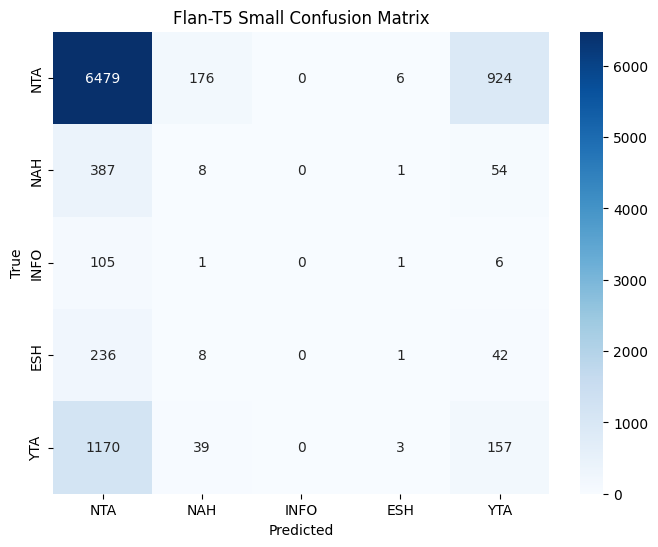


Classification report:

               precision    recall  f1-score   support

         NTA       0.77      0.85      0.81      7585
         NAH       0.03      0.02      0.02       450
        INFO       0.00      0.00      0.00       113
         ESH       0.08      0.00      0.01       287
         YTA       0.13      0.11      0.12      1369

    accuracy                           0.68      9804
   macro avg       0.20      0.20      0.19      9804
weighted avg       0.62      0.68      0.65      9804



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
evaluate_model_classifications(
  test_results=test_results,
  plot_title='Flan-T5 Small Confusion Matrix',
  output_directory='flanT5_small_evaluation',
  confusion_matrix_file='flanT5_small_confusion_matrix.csv',
  classification_report_file='flanT5_small_classification_report.txt'
)

In [ ]:
def evaluate_nlp_metrics():
